In [216]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from matplotlib.dates import DateFormatter

%matplotlib inline
pd.set_option('display.max_rows', 200)

In [217]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

**IMPORT AND FORMAT DATAFRAMES**

In [218]:
df = pd.read_excel('Data2.xlsx', sheet_name='data')

In [219]:
df.head()

,time,crude_ton_per_day,crude_m3h,crude_sg,crude_sulphur_wtpct,lssr_ton_per_day,lssr_sg,lssr_m3h,lssr_sulphur_wtpct,desalter_water_m3h,...,lssr_t002_sulphur_wtpct,lssr_t003_m3h,lssr_t003_sg,lssr_t003_sulphur_wtpct,j70a_on_off,j70b_on_off,j70c_on_off,steam_vent_new_t/h,steam_vent_cogen1_th,steam_vent_cogen2_th
0,PI TAG,CNM10041,CNM10012,CDNIN.00,CSUIN.00,CCFI0295,CDNBL.00,CPFI0295,CSUBL.00,CPFI0007,...,TSU002.00,UPFC2008,TDN003A.00,TSU003.00,CJRR070A,CJRR070B,CJRR070C,PPFC1138.C,MPHC1022.C,MPHC2037.C
1,2013-01-11 00:00:00,11133.8,555.98,0.8344,Arc Off-line,714.037,0.9445,37.553,0.58,10.3248,...,0.859,0,No Data,0.92,No Data,No Data,No Data,No Data,No Data,No Data
2,2013-01-12 00:00:00,10771.5,538.79,0.833,Arc Off-line,640.831,0.949,34.1541,0.582,9.39082,...,0.859,0,No Data,0.92,No Data,No Data,No Data,No Data,No Data,No Data
3,2013-01-13 00:00:00,11080.9,555.799,0.8305,Arc Off-line,1023.18,0.9439,51.4376,0.546,9.33179,...,0.859,0,No Data,0.92,No Data,No Data,No Data,No Data,No Data,No Data
4,2013-01-14 00:00:00,11534.8,577.177,0.8311,Arc Off-line,981.602,0.9399,48.3774,0.62,8.70376,...,0.859,0,No Data,0.92,NOTRUN,NOTRUN,RUN,No Data,No Data,No Data


In [220]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3103 entries, 0 to 3102
Data columns (total 306 columns):
 #   Column                           Dtype 
---  ------                           ----- 
 0   time                             object
 1   crude_ton_per_day                object
 2   crude_m3h                        object
 3   crude_sg                         object
 4   crude_sulphur_wtpct              object
 5   lssr_ton_per_day                 object
 6   lssr_sg                          object
 7   lssr_m3h                         object
 8   lssr_sulphur_wtpct               object
 9   desalter_water_m3h               object
 10  desalter_salt_in_ptb             object
 11  desalter_stg1_salt_out_ptb       object
 12  desalter_stg2_salt_out_ptb       object
 13  b1a_tin                          object
 14  b1a_tout                         object
 15  b1b_tin                          object
 16  b1b_tout                         object
 17  e1_flashzone_temp               

In [221]:
#extract tag data to separate dataframe
tags = pd.DataFrame(df.iloc[0,:])
tags.columns = ['pi_tags']
tags.drop(tags.index[0], inplace=True)

#drop the tags from main data df
df.drop(df.index[0], inplace=True)

In [222]:
df.time = pd.to_datetime(df.time, dayfirst=True)
df.set_index('time', inplace=True)

In [223]:
missing_data_list = ['Bad', 'Bad Input', 'I/O Timeout', 'Shutdown', 'No Data', 'Configure', '#VALUE!', 
                     'Calc Failed', 'Failed', 'Error', 'Tag not found', 'Arc Off-line']

In [224]:
# When processing Crude only (no LSSR) the LSSR pumps J70abc will not be in operation. 
# We can use this to help identify when only crude is being run..

df['j70a_on_off'].replace("NOTRUN", 0, inplace=True)
df['j70a_on_off'].replace("RUN", 1, inplace=True)

df['j70b_on_off'].replace("NOTRUN", 0, inplace=True)
df['j70b_on_off'].replace("RUN", 1, inplace=True)

df['j70c_on_off'].replace("NOTRUN", 0, inplace=True)
df['j70c_on_off'].replace("RUN", 1, inplace=True)

In [225]:
def missing_values_to_float(x):
    try:
        if x in missing_data_list:
            return np.nan
        else:
            return float(x)
    except:
        pass

In [226]:
for col in df.columns:
    df[col] = df[col].map(lambda x: missing_values_to_float(x))

In [227]:
# column indicating whether any of the J70abc pumps are in operation
df['j70abc_on_off'] = df['j70a_on_off'] + df['j70b_on_off'] + df['j70c_on_off']
df['j70abc_on_off'] = df['j70abc_on_off'].map(lambda x: 1 if x > 0 else 0)

In [228]:
#df.info(verbose=True)

In [229]:
#check that all columns are of type float
sum(df.dtypes=='float64') == len(df.columns)

False

In [230]:
#HEX Effective Area m2
hex_area = {'c1ab': 538.9,
            'c1a': 538.9/2,
            'c1b': 538.9/2,
            'c2ab': 404.3,
            'c3': 235.9,
            'c4ab': 408.8,
            'c5ab': 495,
            'c6ab': 765.2,
            'c7ab': 388.5,
            'c8ab': 799.3,
            'c9ab': 415.3,
            'c10ab': 702.2,
            'c11': 341.7,
            'c12ab': 528.4,
            'c13ab': 357.6,
            'c14abcd': 831.1,
            'c15abc': 467,
            'c70ab': 346.4 ,
            'c71abc': 525.6,
            'c72abcd': 786.4,
            'c73ab': 642.5,
          }

In [231]:
#HEX No. Shells
hex_shells = {'c1ab': 2,
            'c1a': 1,
            'c1b': 1,
            'c2ab': 2,
            'c3': 1,
            'c4ab': 2,
            'c5ab': 2,
            'c6ab': 2,
            'c7ab': 2,
            'c8ab': 2,
            'c9ab': 2,
            'c10ab': 2,
            'c11': 1,
            'c12ab': 2,
            'c13ab': 2,
            'c14abcd': 4,
            'c15abc': 3,
            'c70ab': 2 ,
            'c71abc': 3,
            'c72abcd': 4,
            'c73ab': 2,
          }

In [232]:
#Crude side datasheet pressure drops (allowable)
ds_dp_dict = {'c1ab_dp': 2.0,
            'c2ab_dp': 3.0,
            'c3_dp': 0.36,
            'c4ab_dp': 1.0,
            'c5ab_dp': 1.0,
            'c6ab_dp': 2.0,
            'c7ab_dp': 1.0,
            'c8ab_dp': 1.8,
            'c9ab_dp': 1.2,
            'c10ab_dp': 2.0,
            'c11_dp': 1.1,
            'c12ab_dp': 1.0,
            'c13ab_dp': 1.3,
            'c14abcd_dp': 1.6,
            'c15abc_dp': 1.9,
            'c70ab_dp': 0.3 ,
            'c71abc_dp': 1.35,
            'c72abcd_dp': 6.7,
            'c73ab_dp': 2.4 ,

          }

ds_u_dict = {'c1ab_Uclean': 290.7,
            'c1ab_Userv': 161.4,
            'c2ab_Uclean': 745.2,
            'c2ab_Userv': 212.5,
            'c3_Uclean': 394.1,
            'c3_Userv': 188.7,
            'c4ab_Uclean': 629.6,
            'c4ab_Userv': 226.1,
            'c5ab_Uclean': 365.8,
            'c5ab_Userv': 180.3,
            'c6ab_Uclean': 388.5,
            'c6ab_Userv': 184.5,
            'c7ab_Uclean': 233,
            'c7ab_Userv': 131.3,
            'c8ab_Uclean': 473.4,
            'c8ab_Userv': 191.4,
            'c9ab_Uclean': 596.9,
            'c9ab_Userv': 221.7,
            'c9a_Uclean': 596.9,
            'c9a_Userv': 221.7,
            'c9b_Uclean': 596.9,
            'c9b_Userv': 221.7,
            'c10ab_Uclean': 521.8,
            'c10ab_Userv': 208.8,
            'c11_Uclean': 426.5,
            'c11_Userv': 190.6,
            'c12ab_Uclean': 284.1,
            'c12ab_Userv': 159.6,
            'c13ab_Uclean': 560.7,
            'c13ab_Userv': 211.8,
            'c14abcd_Uclean': 434.4,
            'c14abcd_Userv': 177.4,
            'c15abc_Uclean': 376.4,
            'c15abc_Userv': 151.2,
            'c70ab_Uclean':285.2 ,
            'c70ab_Userv': 145.3,
            'c71abc_Uclean': 72.8,
            'c71abc_Userv': 58.5,
            'c72abcd_Uclean': 377,
            'c72abcd_Userv':168,
            'c73ab_Uclean':140.4 ,
            'c73ab_Userv': 96,
          }

In [233]:
#Used in code that recalculates the U values for each exchanger

hot_stream_dict = {
    'c1a': 'e7_tpa',
    'c1b': 'e7_tpa',
    'c2ab': 'e1_tpa',
    'c3': 'kero_prod',
    'c4ab': 'kpa',
    'c5ab': 'lgo_prod',
    'c6ab': 'hvgo',
    'c7ab': 'hgo_prod',
    'c8ab': 'hvgo',
    'c9ab': 'lgo_pa',
    'c10ab': 'hvgo',
    'c11': 'hgo_pa',
    'c12ab': 'hvgo',
    'c13ab': 'hgo_pa',
    'c14abcd': 'ar',
    'c15abc': 'vbr',
    'c70ab': 'e1_tpa',
    'c71abc': 'vbr',
    'c72abcd': 'hvgo',
    'c73ab': 'e3_bpa',
}

In [234]:
#Used to look up hot stream for cp calculations.
hot_stream_cp_dict = {'c1a': 'e7_tpa', 
                      'c1b': 'e7_tpa', 
                      'c2ab': 'e1_tpa', 
                      'c3': 'kero', 
                      'c4ab': 'kero', 
                      'c5ab': 'lgo', 
                      'c6ab': 'hvgo', 
                      'c7ab': 'hgo',
                      'c8ab': 'hvgo', 
                      'c9ab': 'lgo',
                      'c10ab': 'hvgo', 
                      'c11': 'hgo',
                      'c12ab': 'hvgo', 
                      'c13ab': 'hgo', 
                      'c14abcd': 'ar', 
                      'c15abc': 'vr', 
                      'c70ab': 'e1_tpa', 
                      'c71abc': 'vr', 
                      'c72abcd': 'hvgo',
                      'c73ab': 'vr'}

**CALCULATIONS**

In [235]:
def lmtd(hot_tin, hot_tout, cold_tin, cold_tout):
    
    dt1 = hot_tin - cold_tout
    dt2 = hot_tout - cold_tin
    
    try:
        return (dt1 - dt2) / np.log(dt1 / dt2)
    
    except:
        return np.nan

In [236]:
# Stream cP formulas (kcal/kgC) - based on hysys properties

def crude_cp(*temps, units='kcal_kg.c'):

    x = 0
    for temp in temps:
        x += temp
        avg_temp = x/len(temps)
        
    if units=='kcal_kg.c':
        return 0.001 * avg_temp + 0.4319
    
    elif units=='kj_kg.c':
        return 4.1868 * (0.001 * avg_temp + 0.4319)
    
    elif units=='j_kg.c':
        return 1000 *4.1868 * (0.001 * avg_temp + 0.4319)

    else:
        print('invalid arguements')

In [237]:
def e1_tpa_cp(*temps, units='kcal_kg.c'):

    x = 0
    for temp in temps:
        x += temp
        avg_temp = x/len(temps)
        
    if units=='kcal_kg.c':
        return 0.0011 * avg_temp + 0.424
    
    elif units=='kj_kg.c':
        return 4.184 * (0.0011 * avg_temp + 0.424)
    
    elif units=='j_kg.c':
        return 1000 * 4.184 * (0.0011 * avg_temp + 0.424)

    else:
        print('invalid arguements')


In [238]:
def kero_cp(*temps, units='kcal_kg.c'):

    x = 0
    for temp in temps:
        x += temp
        avg_temp = x/len(temps)
        
    if units=='kcal_kg.c':
        return 0.0011 * avg_temp + 0.4196
    
    elif units=='kj_kg.c':
        return 4.184 * (0.0011 * avg_temp + 0.4196)
    
    elif units=='j_kg.c':
        return 1000 * 4.184 * (0.0011 * avg_temp + 0.4196)

    else:
        print('invalid arguements')


In [239]:
def lgo_cp(*temps, units='kcal_kg.c'):

    x = 0
    for temp in temps:
        x += temp
        avg_temp = x/len(temps)
        
    if units=='kcal_kg.c':
        return 0.001 * avg_temp + 0.4212      
    
    elif units=='kj_kg.c':
        return 4.184 * (0.001 * avg_temp + 0.4212)
    
    elif units=='j_kg.c':
        return 1000 * 4.184 * (0.001 * avg_temp + 0.4212)

    else:
        print('invalid arguements')   

In [240]:
def hgo_cp(*temps, units='kcal_kg.c'):

    x = 0
    for temp in temps:
        x += temp
        avg_temp = x/len(temps)
        
    if units=='kcal_kg.c':
        return 0.0009 * avg_temp + 0.4366    
    
    elif units=='kj_kg.c':
        return 4.184 * (0.0009 * avg_temp + 0.4366)
    
    elif units=='j_kg.c':
        return 1000 *4.184 * (0.0009 * avg_temp + 0.4366)

    else:
        print('invalid arguements')   


In [241]:
def e7_tpa_cp(*temps, units='kcal_kg.c'):

    x = 0
    for temp in temps:
        x += temp
        avg_temp = x/len(temps)
        
    if units=='kcal_kg.c':
        return 0.0009 * avg_temp + 0.427     
    
    elif units=='kj_kg.c':
        return 4.184 * (0.0009 * avg_temp + 0.427)
    
    elif units=='j_kg.c':
        return 1000 *4.184 * (0.0009 * avg_temp + 0.427)

    else:
        print('invalid arguements')

In [242]:
def hvgo_cp(*temps, units='kcal_kg.c'):

    x = 0
    for temp in temps:
        x += temp
        avg_temp = x/len(temps)
        
    if units=='kcal_kg.c':
        return 0.0008 * avg_temp + 0.4473     
    
    elif units=='kj_kg.c':
        return 4.184 * (0.0008 * avg_temp + 0.4473)
    
    elif units=='j_kg.c':
        return 1000 *4.184 * (0.0008 * avg_temp + 0.4473)

    else:
        print('invalid arguements')

In [243]:
def ar_cp(*temps, units='kcal_kg.c'):

    x = 0
    for temp in temps:
        x += temp
        avg_temp = x/len(temps)
        
    if units=='kcal_kg.c':
        return 0.0008 * avg_temp + 0.4493     
    
    elif units=='kj_kg.c':
        return 4.184 * (0.0008 * avg_temp + 0.4493)
    
    elif units=='j_kg.c':
        return 1000 *4.184 * (0.0008 * avg_temp + 0.4493)

    else:
        print('invalid arguements')

In [244]:
def vr_cp(*temps, units='kcal_kg.c'):

    x = 0
    for temp in temps:
        x += temp
        avg_temp = x/len(temps)
        
    if units=='kcal_kg.c':
        return 0.0008 * avg_temp + 0.4547     
    
    elif units=='kj_kg.c':
        return 4.184 * (0.0008 * avg_temp + 0.4547)
    
    elif units=='j_kg.c':
        return 1000 *4.184 * (0.0008 * avg_temp + 0.4547)

    else:
        print('invalid arguements')

In [245]:
def lssr_cp(*temps, units='kcal_kg.c'):

    x = 0
    for temp in temps:
        x += temp
        avg_temp = x/len(temps)
        
    if units=='kcal_kg.c':
        return 0.0009 * avg_temp + 0.4277     
    
    elif units=='kj_kg.c':
        return 4.184 * (0.0009 * avg_temp + 0.4277)
    
    elif units=='j_kg.c':
        return 1000 *4.184 * (0.0009 * avg_temp + 0.4277)

    else:
        print('invalid arguements')

In [246]:
#flashed crude flowrate and SG also calculated by hysys at different temps (this may need to be updated depending on crude type)

def flashed_crude_sg(crude_sg, preflash_drum_temp):
    
     return crude_sg * (0.0003*preflash_drum_temp + 0.958)
      
def flashed_crude_m3h(crude_m3h, preflash_drum_temp):
    
    liq_fraction = (-0.0022*preflash_drum_temp + 1.2831)
    return crude_m3h * liq_fraction

def flashed_crude_cp(*temps, units='kcal_kg.c'):

    x = 0
    for temp in temps:
        x += temp
        avg_temp = x/len(temps)
        
    if units=='kcal_kg.c':
        return 0.001 * avg_temp + 0.4294     
    
    elif units=='kj_kg.c':
        return 4.184 * (0.001 * avg_temp + 0.4294)
    
    elif units=='j_kg.c':
        return 1000 * 4.184 * (0.001 * avg_temp + 0.4294)

    else:
        print('invalid arguements')

In [247]:
#ADD SOME MAIN STREAM MASS FLOWS

#Crude to main Crude preheat train ie. not including Crude to LSSR line
df['crude_tnh'] = df['crude_m3h'] * df['crude_sg']

df['crude_tot_tnh']  = (df['crude_m3h'] + df['lssr_m3h']*(1-df['j70abc_on_off'])) * df['crude_sg']

#df['lssr_tnh'] see below 
#df['flashed_crude_tnh'] see flashed_crude selection below
df['kero_prod_tnh'] = df['kero_m3h'] * df['kero_sg']
df['lgo_prod_tnh'] = df['lgo_m3h'] * df['lgo_sg']
df['hgo_prod_tnh'] = df['hgo_m3h'] * df['hgo_sg']
df['e7_lvgo_prod_tnh'] = df['e7_lvgo_m3h'] * df['e7_lvgo_sg']
df['e3_lvgo_prod_tnh'] = df['e3_lvgo_m3h'] * df['e3_lvgo_sg']
df['hvgo_prod_tnh'] = df['hvgo_m3h'] * df['hvgo_sg']
df['vr_tnh'] = df['vr_m3h'] * df['vr_sg']

In [248]:
#no measurement of Atm. Residue SG. Could calculate from flows/SGs of LVGO, HVGO and VR from the VDU, but this could lead to
#inaccuracies if one of more of those data points are off. Therefore, will simply enter a reasonable, fixed value for SG.
#This could be updated based on simulations of the current crude slate etc if this information was available...

df['ar_sg'] = 0.90

df['vfr_sg'] = 0.91

# For simplicity, use a fixed value of VBR SG.
# Use Vac res cp calc for vbr

df['vbr_sg'] = 1.00

In [249]:
# There are two alterntaive LSSR mass flowrates to choose from;
# 1. LSSR m3/h * SG
# 2. LSSR Ton Per Day / 24

#In calc1, use Crude sg when calculating flow through LSSR line in Crude only operation. To avoid adding addtional names to the program, crude running trough
#the LSSR line will continue to be referred to as 'lssr_tnh'

df['lssr_tnh_1'] = (df['lssr_m3h'] * df['lssr_sg'] * df['j70abc_on_off']) + (df['lssr_m3h'] * df['crude_sg'] * (1-df['j70abc_on_off'])) #use Crude SG when pump is off

df['lssr_tnh_2'] = df['lssr_ton_per_day'] / 24

lssr_tnh_select = 1

if lssr_tnh_select ==1:
    df['lssr_tnh'] = df['lssr_tnh_1']
    
elif lssr_tnh_select ==2:
    df['lssr_tnh'] = df['lssr_tnh_2']

else:
    print('Enter valid lssr flowrate selection')

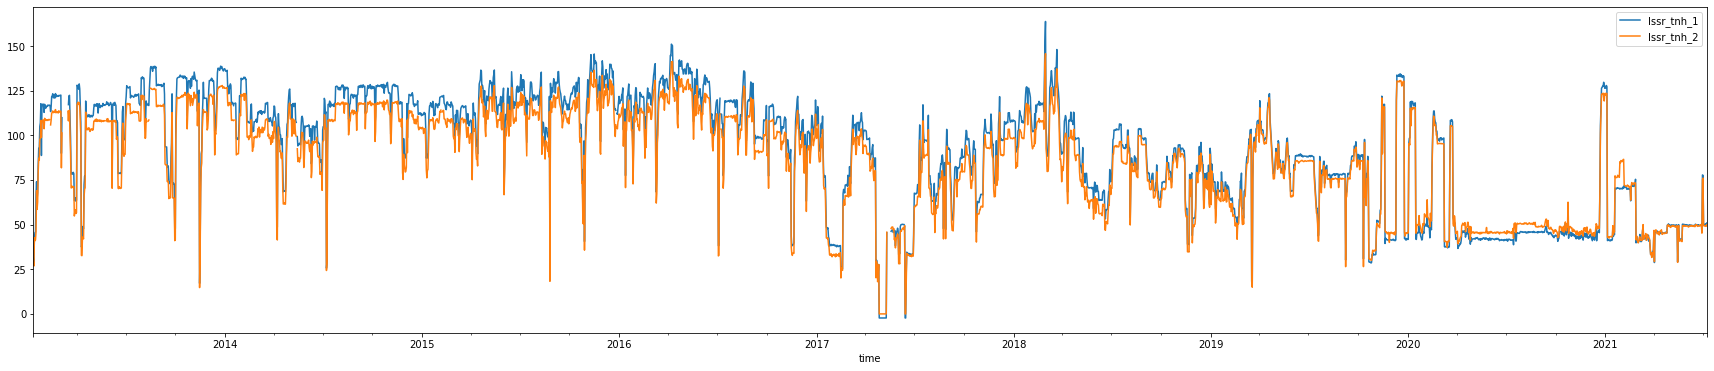

In [250]:
df['lssr_tnh_1'].plot(figsize=(30,6))
df['lssr_tnh_2'].plot()
plt.legend()

In [251]:
#HVGO

#Alternative total HVGO_rates (pa+prod). SELECT which one to use...

# 1. HVGO PA return (CPFI0050) + HVGO Prod (CPFI0060)
# 2. HVGO to C6AB (CPFI0288) + C6AB HVGO BYPASS (CPFI0289)
# 3. HVGO to C12AB (CPFI0296) + C72A-D (CPFI0306)
df['hvgo_tot_m3h_1'] = df['hvgo_prod_m3h'] + df['hvgo_pa_m3h']
df['hvgo_tot_m3h_2'] = df['c6ab_hvgo_m3h'] + df['c6ab_hvgo_bypass_m3h']
df['hvgo_tot_m3h_3'] = df['c12ab_hvgo_m3h'] + df['c72abcd_hvgo_m3h']



hvgo_tot_m3h_select = 1

if hvgo_tot_m3h_select == 1:
    df['hvgo_tot_m3h'] = df['hvgo_tot_m3h_1']
    
elif hvgo_tot_m3h_select == 2:
    df['hvgo_tot_m3h'] = df['hvgo_tot_m3h_2']
    
elif hvgo_tot_m3h_select == 3:
    df['hvgo_tot_m3h'] = df['hvgo_tot_m3h_3']

else:
    print('Enter valid HVGO flowrate selection')

array([[<AxesSubplot:xlabel='time'>],
       [<AxesSubplot:xlabel='time'>],
       [<AxesSubplot:xlabel='time'>]], dtype=object)

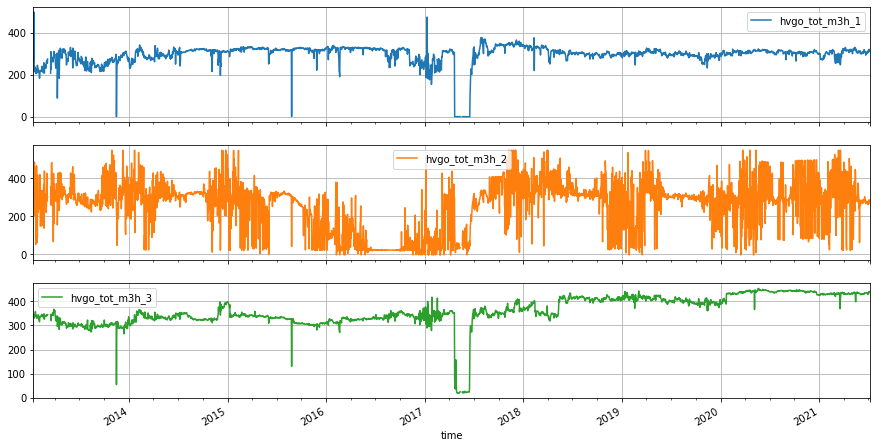

In [252]:
df[['hvgo_tot_m3h_1', 'hvgo_tot_m3h_2','hvgo_tot_m3h_3']].plot(subplots=True, layout=(3, 1), figsize=(15, 8), grid=True, sharex=True)

In [253]:
#Alternative Flashed Crude rates

# 1. Vol flow meters avg.(CPFI0019, CPFI018B, CPFI018,)
# 2. Based on Pre-flash Drum Temperature and HYSYS Simulation (for project crude mix)

df['flashed_crude_m3h_1'] =  (df['c10ab_flashed_crude_m3h_1of3'] + df['c10ab_flashed_crude_m3h_2of3'] + df['c10ab_flashed_crude_m3h_3of3'])/3
df['flashed_crude_m3h_2'] = flashed_crude_m3h(df['crude_m3h'], df['f15_tin'])

# Will use calc 2 as the flowmeters appear to suggest a much higher %flash #9~30%)in the Pre-Flash Drum that
# can't be squared with the simulation. The simulation %flash (~10%) tallies well with the data sheets flows also ie. crude to C9/C10


flashed_crude_m3h_select = 2

if flashed_crude_m3h_select == 1:
    df['flashed_crude_m3h'] = df['flashed_crude_m3h_1']
    
elif flashed_crude_m3h_select == 2:
    df['flashed_crude_m3h'] = df['flashed_crude_m3h_2']
    
else:
    print('Enter valid flashed_crude flowrate selection')    
    

df['flashed_crude_tnh'] = df.flashed_crude_m3h * flashed_crude_sg(df['crude_sg'], df['f15_tin'])


In [254]:
# There are three measurements for the net VBR flow (m3h), in addition to the VBR quench flowrate (to C15 only).

#1 : CPFI0284
#2 : VPFI0173
#3 : CPFI0080
# Quench: CPFI0013

vbr_prod_m3h_select = 1

if vbr_prod_m3h_select == 1:
    df['c71abc_vbr_m3h'] = df['c71abc_vbr_m3h_1of3']
    
elif vbr_prod_m3h_select == 2:
    df['c71abc_vbr_m3h'] = df['c71abc_vbr_m3h_2of3']
    
elif vbr_prod_m3h_select == 3:
    df['c71abc_vbr_m3h'] = df['c71abc_vbr_m3h_3of3']

else:
    print('Select VBR product flow measurement')
    
df['c15abc_vbr_m3h'] = df['c71abc_vbr_m3h'] + df['vbr_to_quench_m3h'].fillna(0)   #fill Nan values with zero for quench rate

array([[<AxesSubplot:xlabel='time'>],
       [<AxesSubplot:xlabel='time'>],
       [<AxesSubplot:xlabel='time'>]], dtype=object)

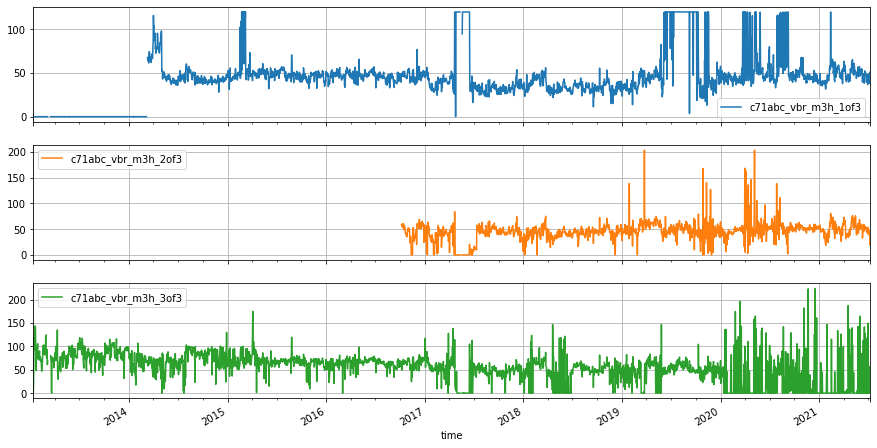

In [255]:
df[['c71abc_vbr_m3h_1of3', 'c71abc_vbr_m3h_2of3','c71abc_vbr_m3h_3of3']].plot(subplots=True, layout=(3, 1), figsize=(15, 8), grid=True, sharex=True)

In [256]:
df['vfr_to_e3_m3h'] = df['vfr_m3h'] - df['vfr_to_fcc_m3h'] - df['vfr_to_storage_m3h']

***C1-A/B (Crude, E7_TPA)***

In [257]:
df['c1ab_e7_tpa_m3h'] = df['c1a_e7_tpa_m3h'] + df['c1b_e7_tpa_m3h']
df['c1ab_crude_m3h'] = df['c1a_crude_m3h'] + df['c1b_crude_m3h']

df['c1ab_crude_tin'] = ((df['c1a_crude_m3h'] * df['c1a_crude_tin']) + (df['c1b_crude_m3h'] * df['c1b_crude_tin'])) / df['c1ab_crude_m3h']
df['c1ab_crude_tout'] = ((df['c1a_crude_m3h'] * df['c1a_crude_tout']) + (df['c1b_crude_m3h'] * df['c1b_crude_tout'])) / df['c1ab_crude_m3h']

#Log-Mean Temperature Difference
df['c1ab_lmtd'] =lmtd(df['c1ab_e7_tpa_tin'], df['c1ab_e7_tpa_tout'], df['c1ab_crude_tin'], df['c1ab_crude_tout'])

#calculate specfic heat capacites
df['c1a_crude_cp'] = crude_cp(df['c1a_crude_tin'],df['c1a_crude_tout'])
df['c1b_crude_cp'] = crude_cp(df['c1b_crude_tin'],df['c1b_crude_tout'])
df['c1ab_crude_cp'] = crude_cp(df['c1ab_crude_tin'],df['c1ab_crude_tout'])

df['c1a_e7_tpa_cp'] = e7_tpa_cp(df['c1ab_e7_tpa_tin'],df['c1a_e7_tpa_tout'])
df['c1b_e7_tpa_cp'] = e7_tpa_cp(df['c1ab_e7_tpa_tin'],df['c1b_e7_tpa_tout'])
df['c1ab_e7_tpa_cp'] = e7_tpa_cp(df['c1ab_e7_tpa_tin'],df['c1ab_e7_tpa_tout'])

#calculate duty on both shell and tube sides (Gcal/h)
df['c1ab_crude_gcalh'] = (df['crude_tnh'] * df['c1ab_crude_cp'] * (df['c1ab_crude_tout'] - df['c1ab_crude_tin']))/1000
df['c1ab_e7_tpa_gcalh'] = (df['c1ab_e7_tpa_m3h'] * df['e7_lvgo_sg'] * df['c1ab_e7_tpa_cp'] * (df['c1ab_e7_tpa_tout'] - df['c1ab_e7_tpa_tin']))/1000

#U calculations on tube and shell sides
df['c1ab_ucalc1'] = (df['c1ab_crude_gcalh']*1e6 / df['c1ab_lmtd'] / hex_area['c1ab'])
df['c1ab_ucalc2'] = -(df['c1ab_e7_tpa_gcalh']*1e6 / df['c1ab_lmtd'] / hex_area['c1ab'])

C:\Users\adam_\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


***C2-A/B (Crude, E1_TPA)***

In [258]:
df['c2ab_crude_tin'] = df['c1ab_crude_tout']

#Log-Mean Temperature Difference
df['c2ab_lmtd'] =lmtd(df['c2ab_e1_tpa_tin'], df['c2ab_e1_tpa_tout'], df['c2ab_crude_tin'], df['c2ab_crude_tout'])

#calculate specfic heat capacites
df['c2ab_crude_cp'] = crude_cp(df['c2ab_crude_tin'],df['c2ab_crude_tout'])
df['c2ab_e1_tpa_cp'] = e1_tpa_cp(df['c2ab_e1_tpa_tin'],df['c2ab_e1_tpa_tout'])

#calculate duty on both shell and tube sides (Gcal/h)
df['c2ab_crude_gcalh'] = (df['crude_tnh'] * df['c2ab_crude_cp'] * (df['c2ab_crude_tout'] - df['c2ab_crude_tin']))/1000
df['c2ab_e1_tpa_gcalh'] = (df['c2ab_e1_tpa_m3h'] * df['frsrn_sg'] * df['c2ab_e1_tpa_cp'] * (df['c2ab_e1_tpa_tout'] - df['c2ab_e1_tpa_tin']))/1000

#U calculations on tube and shell sides
df['c2ab_ucalc1'] = (df['c2ab_crude_gcalh']*1e6 / df['c2ab_lmtd'] / hex_area['c2ab'])
df['c2ab_ucalc2'] = -(df['c2ab_e1_tpa_gcalh']*1e6 / df['c2ab_lmtd'] / hex_area['c2ab'])

***C3 (Crude, Kero_Prod)***

In [259]:
df['c3_crude_tin'] = df['c2ab_crude_tout']

#Log-Mean Temperature Difference
df['c3_lmtd'] =lmtd(df['c3_kero_prod_tin'], df['c3_kero_prod_tout'], df['c3_crude_tin'], df['c3_crude_tout'])

#calculate specfic heat capacites
df['c3_crude_cp'] = crude_cp(df['c3_crude_tin'],df['c3_crude_tout'])
df['c3_kero_prod_cp'] = kero_cp(df['c3_kero_prod_tin'],df['c3_kero_prod_tout'])

#calculate duty on both shell and tube sides (Gcal/h)
df['c3_crude_gcalh'] = (df['crude_tnh'] * df['c3_crude_cp'] * (df['c3_crude_tout'] - df['c3_crude_tin']))/1000
df['c3_kero_prod_gcalh'] = (df['c3_kero_prod_m3h'] * df['kero_sg'] * df['c3_kero_prod_cp'] * (df['c3_kero_prod_tout'] - df['c3_kero_prod_tin']))/1000

#U calculations on tube and shell sides
df['c3_ucalc1'] = (df['c3_crude_gcalh']*1e6 / df['c3_lmtd'] / hex_area['c3'])
df['c3_ucalc2'] = -(df['c3_kero_prod_gcalh']*1e6 / df['c3_lmtd'] / hex_area['c3'])

***C4-A/B (Crude, Kero_PA)***

In [260]:
df['c4ab_crude_tin'] = df['c3_crude_tout']

#Log-Mean Temperature Difference
df['c4ab_lmtd'] =lmtd(df['c4ab_kpa_tin'], df['c4ab_kpa_tout'], df['c4ab_crude_tin'], df['c4ab_crude_tout'])

#calculate specfic heat capacites
df['c4ab_crude_cp'] = crude_cp(df['c4ab_crude_tin'],df['c4ab_crude_tout'])
df['c4ab_kpa_cp'] = kero_cp(df['c4ab_kpa_tin'],df['c4ab_kpa_tout'])

#calculate duty on both shell and tube sides (Gcal/h)
df['c4ab_crude_gcalh'] = (df['crude_tnh'] * df['c4ab_crude_cp'] * (df['c4ab_crude_tout'] - df['c4ab_crude_tin']))/1000
df['c4ab_kpa_gcalh'] = (df['c4ab_kpa_m3h'] * df['kero_sg'] * df['c4ab_kpa_cp'] * (df['c4ab_kpa_tout'] - df['c4ab_kpa_tin']))/1000

#U calculations on tube and shell sides
df['c4ab_ucalc1'] = (df['c4ab_crude_gcalh']*1e6 / df['c4ab_lmtd'] / hex_area['c4ab'])
df['c4ab_ucalc2'] = -(df['c4ab_kpa_gcalh']*1e6 / df['c4ab_lmtd'] / hex_area['c4ab'])

***C5-A/B (Crude, LGO_Prod)***

In [261]:
df['c5ab_lgo_prod_m3h'] = df['lgo_prod_m3/h'] - df['c5ab_lgo_prod_bypass_m3/h']

In [262]:
df['c5ab_crude_tin'] = df['c4ab_crude_tout']

#Log-Mean Temperature Difference
df['c5ab_lmtd'] =lmtd(df['c5ab_lgo_prod_tin'], df['c5ab_lgo_prod_tout'], df['c5ab_crude_tin'], df['c5ab_crude_tout'])

#calculate specfic heat capacites
df['c5ab_crude_cp'] = crude_cp(df['c5ab_crude_tin'],df['c5ab_crude_tout'])
df['c5ab_lgo_prod_cp'] = lgo_cp(df['c5ab_lgo_prod_tin'],df['c5ab_lgo_prod_tout'])

#calculate duty on both shell and tube sides (Gcal/h)
df['c5ab_crude_gcalh'] = (df['crude_tnh'] * df['c5ab_crude_cp'] * (df['c5ab_crude_tout'] - df['c5ab_crude_tin']))/1000
df['c5ab_lgo_prod_gcalh'] = (df['c5ab_lgo_prod_m3h'] * df['lgo_sg'] * df['c5ab_lgo_prod_cp'] * (df['c5ab_lgo_prod_tout'] - df['c5ab_lgo_prod_tin']))/1000

#U calculations on tube and shell sides
df['c5ab_ucalc1'] = (df['c5ab_crude_gcalh']*1e6 / df['c5ab_lmtd'] / hex_area['c5ab'])
df['c5ab_ucalc2'] = -(df['c5ab_lgo_prod_gcalh']*1e6 / df['c5ab_lmtd'] / hex_area['c5ab'])

***C6-A/B (Crude, HVGOPA/Prod)***

In [263]:
df['c6ab_crude_tin'] = df['c5ab_crude_tout']

#Log-Mean Temperature Difference
df['c6ab_lmtd'] =lmtd(df['c6ab_hvgo_tin'], df['c6ab_hvgo_tout'], df['c6ab_crude_tin'], df['c6ab_crude_tout'])

#calculate specfic heat capacites
df['c6ab_crude_cp'] = crude_cp(df['c6ab_crude_tin'],df['c6ab_crude_tout'])
df['c6ab_hvgo_cp'] = hvgo_cp(df['c6ab_hvgo_tin'],df['c6ab_hvgo_tout'])

#calculate duty on both shell and tube sides (Gcal/h)
df['c6ab_crude_gcalh'] = (df['crude_tnh'] * df['c6ab_crude_cp'] * (df['c6ab_crude_tout'] - df['c6ab_crude_tin']))/1000
df['c6ab_hvgo_gcalh'] = (df['c6ab_hvgo_m3h'] * df['hvgo_sg'] * df['c6ab_hvgo_cp'] * (df['c6ab_hvgo_tout'] - df['c6ab_hvgo_tin']))/1000

#U calculations on tube and shell sides
df['c6ab_ucalc1'] = (df['c6ab_crude_gcalh']*1e6 / df['c6ab_lmtd'] / hex_area['c6ab'])
df['c6ab_ucalc2'] = -(df['c6ab_hvgo_gcalh']*1e6 / df['c6ab_lmtd'] / hex_area['c6ab'])

***C7-A/B (Crude, HVGO_PA/Prod)***

In [264]:
#Log-Mean Temperature Difference
df['c7ab_lmtd'] =lmtd(df['c7ab_hgo_prod_tin'], df['c7ab_hgo_prod_tout'], df['c7ab_crude_tin'], df['c7ab_crude_tout'])

#calculate specfic heat capacites
df['c7ab_crude_cp'] = crude_cp(df['c7ab_crude_tin'],df['c7ab_crude_tout'])
df['c7ab_hgo_prod_cp'] = hgo_cp(df['c7ab_hgo_prod_tin'],df['c7ab_hgo_prod_tout'])

#calculate duty on both shell and tube sides (Gcal/h)
df['c7ab_crude_gcalh'] = (df['crude_tnh'] * df['c7ab_crude_cp'] * (df['c7ab_crude_tout'] - df['c7ab_crude_tin']))/1000
df['c7ab_hgo_prod_gcalh'] = (df['c7ab_hgo_prod_m3h'] * df['hgo_sg'] * df['c7ab_hgo_prod_cp'] * (df['c7ab_hgo_prod_tout'] - df['c7ab_hgo_prod_tin']))/1000

#U calculations on tube and shell sides
df['c7ab_ucalc1'] = (df['c7ab_crude_gcalh']*1e6 / df['c7ab_lmtd'] / hex_area['c7ab'])
df['c7ab_ucalc2'] = -(df['c7ab_hgo_prod_gcalh']*1e6 / df['c7ab_lmtd'] / hex_area['c7ab'])

***C8-A/B (Crude, HVGOPA/Prod)***

In [265]:
#will use the hvgo rate as calculated by the pa rate plus the prod rate
df['c8ab_hvgo_m3h'] = df.hvgo_tot_m3h

df['c8ab_crude_tin'] = df['c7ab_crude_tout']

#Log-Mean Temperature Difference
df['c8ab_lmtd'] =lmtd(df['c8ab_hvgo_tin'], df['c8ab_hvgo_tout'], df['c8ab_crude_tin'], df['c8ab_crude_tout'])

#calculate specfic heat capacites
df['c8ab_crude_cp'] = crude_cp(df['c8ab_crude_tin'],df['c8ab_crude_tout'])
df['c8ab_hvgo_cp'] = hvgo_cp(df['c8ab_hvgo_tin'],df['c8ab_hvgo_tout'])

#calculate duty on both shell and tube sides (Gcal/h)
df['c8ab_crude_gcalh'] = (df['crude_tnh'] * df['c8ab_crude_cp'] * (df['c8ab_crude_tout'] - df['c8ab_crude_tin']))/1000
df['c8ab_hvgo_gcalh'] = (df['c8ab_hvgo_m3h'] * df['hvgo_sg'] * df['c8ab_hvgo_cp'] * (df['c8ab_hvgo_tout'] - df['c8ab_hvgo_tin']))/1000

#U calculations on tube and shell sides
df['c8ab_ucalc1'] = (df['c8ab_crude_gcalh']*1e6 / df['c8ab_lmtd'] / hex_area['c8ab'])
df['c8ab_ucalc2'] = -(df['c8ab_hvgo_gcalh']*1e6 / df['c8ab_lmtd'] / hex_area['c8ab'])

***C9-A/B (Crude, LGO_PA)***

In [266]:
df['c9ab_crude_tin'] = df['c8ab_crude_tout']

#Log-Mean Temperature Difference
df['c9ab_lmtd'] =lmtd(df['c9ab_lgo_pa_tin'], df['c9ab_lgo_pa_tout'], df['c9ab_crude_tin'], df['c9ab_crude_tout'])

#calculate specfic heat capacites
df['c9ab_crude_cp'] = crude_cp(df['c9ab_crude_tin'],df['c9ab_crude_tout'])
df['c9ab_lgo_pa_cp'] = lgo_cp(df['c9ab_lgo_pa_tin'],df['c9ab_lgo_pa_tout'])

#calculate duty on both shell and tube sides (Gcal/h)
df['c9ab_crude_gcalh'] = (df['crude_tnh'] * df['c9ab_crude_cp'] * (df['c9ab_crude_tout'] - df['c9ab_crude_tin']))/1000
df['c9ab_lgo_pa_gcalh'] = (df['c9ab_lgo_pa_m3h'] * df['lgo_sg'] * df['c9ab_lgo_pa_cp'] * (df['c9ab_lgo_pa_tout'] - df['c9ab_lgo_pa_tin']))/1000

#U calculations on tube and shell sides
df['c9ab_ucalc1'] = (df['c9ab_crude_gcalh']*1e6 / df['c9ab_lmtd'] / hex_area['c9ab'])
df['c9ab_ucalc2'] = -(df['c9ab_lgo_pa_gcalh']*1e6 / df['c9ab_lmtd'] / hex_area['c9ab'])

***C10-A/B (Crude, HVGO_PA/PROD)***

In [267]:
#Calculate Tin from outlet of C12AB and C72AB. 

#Note: HVGO flow is NOT based on HVGO to C72 + C12 (see C8AB calcs above)
#Therefore, to be consistent, the flow to C72 and C12 will be calculated based on the total flow and the flow ratio to each
#exchanger as given in the data sheets.

# IF HVGO flow IS based on flows to C12 + C72, then can use these flows also in the hex calcs

if hvgo_tot_m3h_select == 1 or hvgo_tot_m3h_select == 2:
    
    c12ab_hvgo_frac = 0.2
    c72abcd_hvgo_frac = (1 - c12ab_hvgo_frac)
    
    df['c12ab_hvgo_m3h'] = df.hvgo_tot_m3h * c12ab_hvgo_frac
    df['c72abcd_hvgo_m3h'] = df.hvgo_tot_m3h * c72abcd_hvgo_frac
    
else:
    pass 
    #and the measured flows to c12 and c72 will be used
    
df['c10ab_hvgo_tin'] = ((df['c12ab_hvgo_m3h'] * df['c12ab_hvgo_tout'] + df['c72abcd_hvgo_m3h'] * df['c72abcd_hvgo_tout'])
                        / (df['c12ab_hvgo_m3h'] + df['c72abcd_hvgo_m3h']))

df['c10ab_hvgo_m3h'] = df.hvgo_tot_m3h

In [268]:
#Log-Mean Temperature Difference
df['c10ab_lmtd'] =lmtd(df['c10ab_hvgo_tin'], df['c10ab_hvgo_tout'], df['c10ab_flashed_crude_tin'], df['c10ab_flashed_crude_tout'])

#calculate specfic heat capacites
df['c10ab_flashed_crude_cp'] = flashed_crude_cp(df['c10ab_flashed_crude_tin'],df['c10ab_flashed_crude_tout'])
df['c10ab_hvgo_cp'] = hvgo_cp(df['c10ab_hvgo_tin'],df['c10ab_hvgo_tout'])

#calculate duty on both shell and tube sides (Gcal/h)
df['c10ab_flashed_crude_gcalh'] = (df.flashed_crude_tnh * df['c10ab_flashed_crude_cp'] * (df['c10ab_flashed_crude_tout'] - df['c10ab_flashed_crude_tin']))/1000
df['c10ab_hvgo_gcalh'] = (df['c10ab_hvgo_m3h'] * df.hvgo_sg * df['c10ab_hvgo_cp'] * (df['c10ab_hvgo_tout'] - df['c10ab_hvgo_tin']))/1000

#U calculations on tube and shell sides
df['c10ab_ucalc1'] = (df['c10ab_flashed_crude_gcalh']*1e6 / df['c10ab_lmtd'] / hex_area['c10ab'])
df['c10ab_ucalc2'] = -(df['c10ab_hvgo_gcalh']*1e6 / df['c10ab_lmtd'] / hex_area['c10ab'])

***C11 (Crude, HGO_PA)***

In [269]:
df['c11_flashed_crude_tin'] = df['c10ab_flashed_crude_tout']

#Log-Mean Temperature Difference
df['c11_lmtd'] =lmtd(df['c11_hgo_pa_tin'], df['c11_hgo_pa_tout'], df['c11_flashed_crude_tin'], df['c11_flashed_crude_tout'])

#calculate specfic heat capacites
df['c11_flashed_crude_cp'] = flashed_crude_cp(df['c11_flashed_crude_tin'],df['c11_flashed_crude_tout'])
df['c11_hgo_pa_cp'] = hgo_cp(df['c11_hgo_pa_tin'],df['c11_hgo_pa_tout'])

#calculate duty on both shell and tube sides (Gcal/h)
df['c11_flashed_crude_gcalh'] = (df.flashed_crude_tnh * df['c11_flashed_crude_cp'] * (df['c11_flashed_crude_tout'] - df['c11_flashed_crude_tin']))/1000
df['c11_hgo_pa_gcalh'] = (df['c11_hgo_pa_m3h'] * df.hgo_sg * df['c11_hgo_pa_cp'] * (df['c11_hgo_pa_tout'] - df['c11_hgo_pa_tin']))/1000

#U calculations on tube and shell sides
df['c11_ucalc1'] = (df['c11_flashed_crude_gcalh']*1e6 / df['c11_lmtd'] / hex_area['c11'])
df['c11_ucalc2'] = -(df['c11_hgo_pa_gcalh']*1e6 / df['c11_lmtd'] / hex_area['c11'])

***C12-A/B (Crude, HVGO_PA/PROD)***

In [270]:
df['c12ab_flashed_crude_tin'] = df['c11_flashed_crude_tout']

#Log-Mean Temperature Difference
df['c12ab_lmtd'] =lmtd(df['c12ab_hvgo_tin'], df['c12ab_hvgo_tout'], df['c12ab_flashed_crude_tin'], df['c12ab_flashed_crude_tout'])

#calculate specfic heat capacites
df['c12ab_flashed_crude_cp'] = flashed_crude_cp(df['c12ab_flashed_crude_tin'],df['c12ab_flashed_crude_tout'])
df['c12ab_hvgo_cp'] = hvgo_cp(df['c12ab_hvgo_tin'],df['c12ab_hvgo_tout'])

#calculate duty on both shell and tube sides (Gcal/h)
df['c12ab_flashed_crude_gcalh'] = (df.flashed_crude_tnh * df['c12ab_flashed_crude_cp'] * (df['c12ab_flashed_crude_tout'] - df['c12ab_flashed_crude_tin']))/1000
df['c12ab_hvgo_gcalh'] = (df['c12ab_hvgo_m3h'] * df.hvgo_sg * df['c12ab_hvgo_cp'] * (df['c12ab_hvgo_tout'] - df['c12ab_hvgo_tin']))/1000

#U calculations on tube and shell sides
df['c12ab_ucalc1'] = (df['c12ab_flashed_crude_gcalh']*1e6 / df['c12ab_lmtd'] / hex_area['c12ab'])
df['c12ab_ucalc2'] = -(df['c12ab_hvgo_gcalh']*1e6 / df['c12ab_lmtd'] / hex_area['c12ab'])

***C13-A/B (Crude, HGO_PA)***

In [271]:
df['c13ab_flashed_crude_tin'] = df['c12ab_flashed_crude_tout']

#Log-Mean Temperature Difference
df['c13ab_lmtd'] =lmtd(df['c13ab_hgo_pa_tin'], df['c13ab_hgo_pa_tout'], df['c13ab_flashed_crude_tin'], df['c13ab_flashed_crude_tout'])

#calculate specfic heat capacites
df['c13ab_flashed_crude_cp'] = flashed_crude_cp(df['c13ab_flashed_crude_tin'],df['c13ab_flashed_crude_tout'])
df['c13ab_hgo_pa_cp'] = hgo_cp(df['c13ab_hgo_pa_tin'],df['c13ab_hgo_pa_tout'])

#calculate duty on both shell and tube sides (Gcal/h)
df['c13ab_flashed_crude_gcalh'] = (df.flashed_crude_tnh * df['c13ab_flashed_crude_cp'] * (df['c13ab_flashed_crude_tout'] - df['c13ab_flashed_crude_tin']))/1000
df['c13ab_hgo_pa_gcalh'] = (df['c13ab_hgo_pa_m3h'] * df.hgo_sg * df['c13ab_hgo_pa_cp'] * (df['c13ab_hgo_pa_tout'] - df['c13ab_hgo_pa_tin']))/1000

#U calculations on tube and shell sides
df['c13ab_ucalc1'] = (df['c13ab_flashed_crude_gcalh']*1e6 / df['c13ab_lmtd'] / hex_area['c13ab'])
df['c13ab_ucalc2'] = -(df['c13ab_hgo_pa_gcalh']*1e6 / df['c13ab_lmtd'] / hex_area['c13ab'])

***C14-A/B/C/D (Crude, AR)***

In [272]:
df['c14abcd_flashed_crude_tin'] = df['c13ab_flashed_crude_tout']

#Log-Mean Temperature Difference
df['c14abcd_lmtd'] =lmtd(df['c14abcd_ar_tin'], df['c14abcd_ar_tout'], df['c14abcd_flashed_crude_tin'], df['c14abcd_flashed_crude_tout'])

#calculate specfic heat capacites
df['c14abcd_flashed_crude_cp'] = flashed_crude_cp(df['c14abcd_flashed_crude_tin'],df['c14abcd_flashed_crude_tout'])
df['c14abcd_ar_cp'] = ar_cp(df['c14abcd_ar_tin'],df['c14abcd_ar_tout'])

#calculate duty on both shell and tube sides (Gcal/h)
df['c14abcd_flashed_crude_gcalh'] = (df.flashed_crude_tnh * df['c14abcd_flashed_crude_cp'] * (df['c14abcd_flashed_crude_tout'] - df['c14abcd_flashed_crude_tin']))/1000
df['c14abcd_ar_gcalh'] = (df['c14abcd_ar_m3h'] * df.ar_sg * df['c14abcd_ar_cp'] * (df['c14abcd_ar_tout'] - df['c14abcd_ar_tin']))/1000

#U calculations on tube and shell sides
df['c14abcd_ucalc1'] = (df['c14abcd_flashed_crude_gcalh']*1e6 / df['c14abcd_lmtd'] / hex_area['c14abcd'])
df['c14abcd_ucalc2'] = -(df['c14abcd_ar_gcalh']*1e6 / df['c14abcd_lmtd'] / hex_area['c14abcd'])

***C15-A/B/C (Crude, Visbroken Residue)***

In [273]:
df['c15abc_flashed_crude_tin'] = df['c14abcd_flashed_crude_tout']

#Log-Mean Temperature Difference
df['c15abc_lmtd'] =lmtd(df['c15abc_vbr_tin'], df['c15abc_vbr_tout'], df['c15abc_flashed_crude_tin'], df['c15abc_flashed_crude_tout'])

#calculate specfic heat capacites
df['c15abc_flashed_crude_cp'] = flashed_crude_cp(df['c15abc_flashed_crude_tin'],df['c15abc_flashed_crude_tout'])
df['c15abc_vbr_cp'] = vr_cp(df['c15abc_vbr_tin'],df['c15abc_vbr_tout'])

#calculate duty on both shell and tube sides (Gcal/h)
df['c15abc_flashed_crude_gcalh'] = (df.flashed_crude_tnh * df['c15abc_flashed_crude_cp'] * (df['c15abc_flashed_crude_tout'] - df['c15abc_flashed_crude_tin']))/1000
df['c15abc_vbr_gcalh'] = (df['c15abc_vbr_m3h'] * df.vbr_sg * df['c15abc_vbr_cp'] * (df['c15abc_vbr_tout'] - df['c15abc_vbr_tin']))/1000

#U calculations on tube and shell sides
df['c15abc_ucalc1'] = (df['c15abc_flashed_crude_gcalh']*1e6 / df['c15abc_lmtd'] / hex_area['c15abc'])
df['c15abc_ucalc2'] = -(df['c15abc_vbr_gcalh']*1e6 / df['c15abc_lmtd'] / hex_area['c15abc'])

<AxesSubplot:xlabel='time'>

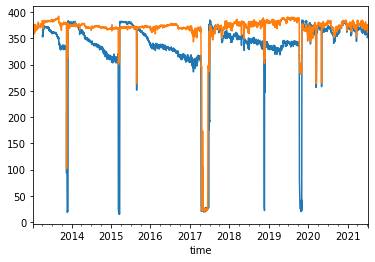

In [274]:
df['c15abc_vbr_tin_alt'].plot()
df['c15abc_vbr_tin'].plot()

***C70-A/B (LSSR, CDU TPA)***

In [275]:
#Log-Mean Temperature Difference
df['c70ab_lmtd'] =lmtd(df['c70ab_e1_tpa_tin'], df['c70ab_e1_tpa_tout'], df['c70ab_lssr_tin'], df['c70ab_lssr_tout'])

#calculate specfic heat capacites
#if Crude through LSSR preheat train, then use Crude cp calc
df['c70ab_lssr_cp'] = lssr_cp(df['c70ab_lssr_tin'],df['c70ab_lssr_tout'])*df['j70abc_on_off']  +  crude_cp(df['c70ab_lssr_tin'],df['c70ab_lssr_tout'])*(1-df['j70abc_on_off'])
df['c70ab_e1_tpa_cp'] = e1_tpa_cp(df['c70ab_e1_tpa_tin'],df['c70ab_e1_tpa_tout'])

#calculate duty on both shell and tube sides (Gcal/h)
df['c70ab_lssr_gcalh'] = (df.lssr_tnh * df['c70ab_lssr_cp'] * (df['c70ab_lssr_tout'] - df['c70ab_lssr_tin']))/1000
df['c70ab_e1_tpa_gcalh'] = (df['c70ab_e1_tpa_m3h'] * df.frsrn_sg * df['c70ab_e1_tpa_cp'] * (df['c70ab_e1_tpa_tout'] - df['c70ab_e1_tpa_tin']))/1000

#U calculations on tube and shell sides
df['c70ab_ucalc1'] = (df['c70ab_lssr_gcalh']*1e6 / df['c70ab_lmtd'] / hex_area['c70ab'])
df['c70ab_ucalc2'] = -(df['c70ab_e1_tpa_gcalh']*1e6 / df['c70ab_lmtd'] / hex_area['c70ab'])

C:\Users\adam_\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


***C71-A/B/C (LSSR, VBR)***

In [276]:
df['c71abc_lssr_tin'] = df['c70ab_lssr_tout']

#Log-Mean Temperature Difference
df['c71abc_lmtd'] =lmtd(df['c71abc_vbr_tin'], df['c71abc_vbr_tout'], df['c71abc_lssr_tin'], df['c71abc_lssr_tout'])

#calculate specfic heat capacites
df['c71abc_lssr_cp'] = lssr_cp(df['c71abc_lssr_tin'],df['c71abc_lssr_tout'])*df['j70abc_on_off']  +  crude_cp(df['c70ab_lssr_tin'],df['c70ab_lssr_tout'])*(1-df['j70abc_on_off'])
df['c71abc_vbr_cp'] = vr_cp(df['c71abc_vbr_tin'],df['c71abc_vbr_tout'])

#calculate duty on both shell and tube sides (Gcal/h)
df['c71abc_lssr_gcalh'] = (df.lssr_tnh * df['c71abc_lssr_cp'] * (df['c71abc_lssr_tout'] - df['c71abc_lssr_tin']))/1000
df['c71abc_vbr_gcalh'] = (df['c71abc_vbr_m3h'] * df.vbr_sg * df['c71abc_vbr_cp'] * (df['c71abc_vbr_tout'] - df['c71abc_vbr_tin']))/1000

#U calculations on tube and shell sides
df['c71abc_ucalc1'] = (df['c71abc_lssr_gcalh']*1e6 / df['c71abc_lmtd'] / hex_area['c71abc'])
df['c71abc_ucalc2'] = -(df['c71abc_vbr_gcalh']*1e6 / df['c71abc_lmtd'] / hex_area['c71abc'])

***C72-A/B/C/D (LSSR, HVGO)***

In [277]:
df['c72abcd_lssr_tin'] = df['c71abc_lssr_tout']

#Log-Mean Temperature Difference
df['c72abcd_lmtd'] =lmtd(df['c72abcd_hvgo_tin'], df['c72abcd_hvgo_tout'], df['c72abcd_lssr_tin'], df['c72abcd_lssr_tout'])

#calculate specfic heat capacites
df['c72abcd_lssr_cp'] = lssr_cp(df['c72abcd_lssr_tin'],df['c72abcd_lssr_tout'])*df['j70abc_on_off']  +  crude_cp(df['c70ab_lssr_tin'],df['c70ab_lssr_tout'])*(1-df['j70abc_on_off'])
df['c72abcd_hvgo_cp'] = hvgo_cp(df['c72abcd_hvgo_tin'],df['c72abcd_hvgo_tout'])

#calculate duty on both shell and tube sides (Gcal/h)
df['c72abcd_lssr_gcalh'] = (df.lssr_tnh * df['c72abcd_lssr_cp'] * (df['c72abcd_lssr_tout'] - df['c72abcd_lssr_tin']))/1000
df['c72abcd_hvgo_gcalh'] = (df['c72abcd_hvgo_m3h'] * df.hvgo_sg * df['c72abcd_hvgo_cp'] * (df['c72abcd_hvgo_tout'] - df['c72abcd_hvgo_tin']))/1000

#U calculations on tube and shell sides
df['c72abcd_ucalc1'] = (df['c72abcd_lssr_gcalh']*1e6 / df['c72abcd_lmtd'] / hex_area['c72abcd'])
df['c72abcd_ucalc2'] = -(df['c72abcd_hvgo_gcalh']*1e6 / df['c72abcd_lmtd'] / hex_area['c72abcd'])

***C73-A/B (LSSR, E3-BPA)***

In [278]:
#Use LSSR SG for E3 feed

#Log-Mean Temperature Difference
df['c73ab_lmtd'] =lmtd(df['c73ab_e3_bpa_tin'], df['c73ab_e3_bpa_tout'], df['c73ab_e3_feed_tin'], df['c73ab_e3_feed_tout'])

#calculate specfic heat capacites
df['c73ab_e3_feed_cp'] = lssr_cp(df['c73ab_e3_feed_tin'],df['c73ab_e3_feed_tout'])
df['c73ab_e3_bpa_cp'] = vr_cp(df['c73ab_e3_bpa_tin'],df['c73ab_e3_bpa_tout'])

#calculate duty on both shell and tube sides (Gcal/h)
df['c73ab_e3_feed_gcalh'] = (df.c73ab_e3_feed_m3h * df.lssr_sg * df['c73ab_e3_feed_cp'] * (df['c73ab_e3_feed_tout'] - df['c73ab_e3_feed_tin']))/1000 #assume sg of vfr is similar to lssr
df['c73ab_e3_bpa_gcalh'] = (df['c73ab_e3_bpa_m3h'] * df.vr_sg * df['c73ab_e3_bpa_cp'] * (df['c73ab_e3_bpa_tout'] - df['c73ab_e3_bpa_tin']))/1000

#U calculations on tube and shell sides
df['c73ab_ucalc1'] = (df['c73ab_e3_feed_gcalh']*1e6 / df['c73ab_lmtd'] / hex_area['c73ab'])
df['c73ab_ucalc2'] = -(df['c73ab_e3_bpa_gcalh']*1e6 / df['c73ab_lmtd'] / hex_area['c73ab'])

***DATA QUALITY CHECKS***

In [279]:
hx='c71abc'
cold_stream = 'lssr'
hot_stream = 'vbr'
df[hx+'_dodgy_u'] = np.where((df[hx+'_'+cold_stream+'_tout'] <  df[hx+'_'+cold_stream+'_tin']) |
                             (df[hx+'_'+hot_stream+'_tout'] >  df[hx+'_'+hot_stream+'_tin'])   | 
                             (df[hx+'_'+cold_stream+'_tout'] >  df[hx+'_'+hot_stream+'_tin'])  |
                             (df[hx+'_'+hot_stream+'_tout'] <  df[hx+'_'+cold_stream+'_tin'])        
                             , df[hx+'_ucalc1'], np.nan)

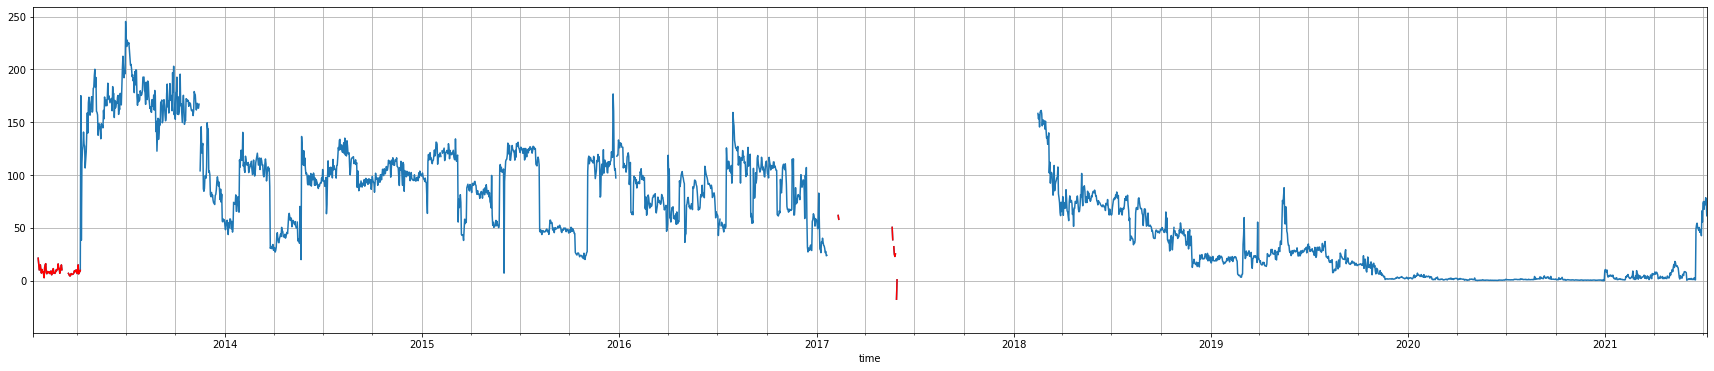

In [280]:
df['c71abc_ucalc1'].plot(figsize=(30,6))
df['c71abc_dodgy_u'].plot(color='red')
#plt.xlim('2013-01-01','2013-04-01')
plt.grid(which='both')

<AxesSubplot:xlabel='time'>

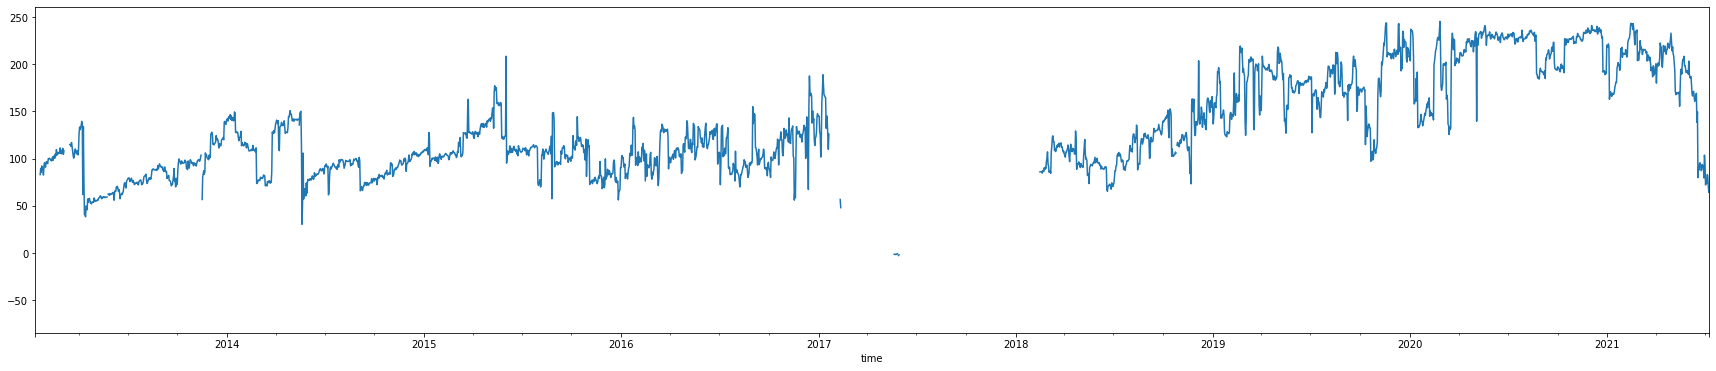

In [281]:
df['c71abc_lmtd'].plot(figsize=(30,6))

In [282]:
# dates and values of suspicious data - to plot/highlight in a different colour over trends
#separate dataframe of dodgy data for all exchangers ie. index is dates, columns are exchangers, and entries are 1 or 0 depending on dodge or not..?

In [283]:
def plot_hex(hex_list, df=df, start=df.index[0], end=df.index[-1]):
    
    '''Input a list of exchanger names to return a plot of U values and pressure drops, where available'''
    
    fig, ax = plt.subplots(nrows = len(hex_list), figsize=(25,6*len(hex_list)), sharex=False)
    for irow, hx in enumerate(hex_list):
        
        try:
            U_clean = ds_U_dict[hx+'_Uclean']
            y_limit = U_clean*1.2
        except:
            U_clean = np.NaN
            y_limit = 800
        try:
            U_serv = ds_U_dict[hx+'_Userv']
        except:
            U_serv = np.NaN     
        try:
            allow_dp = ds_dp_dict[hx+'_dp']
        except:
            allow_dp = np.NaN      

        fig.text(0.08, 0.5, 'Heat Transfer Coefficient', ha='center', va='center', rotation='vertical', size=15)

        ax[irow].set_title(hx, size=16)
        ax[irow].set_ylabel('U (kcal/m2.C)', size=13)
        #ax[irow].set_yticks(fontsize=11)

        ax[irow].set_ylim([0, y_limit])
        df[hx+'_ucalc1'].fillna(value=0).plot(ax=ax[irow], lw=0.6, color='b')
        df[hx+'_ucalc2'].fillna(value=0).plot(ax=ax[irow], lw=0.7, color='cornflowerblue')


        ax[irow].axhline(y=U_clean, color='g', linestyle='--', lw=1)   #U (clean)
        ax[irow].axhline(y=U_serv, color='purple', linestyle='--', lw=1)    #U (service)

        ax[irow].legend(['U_calc1', 'U_calc2', 'U_clean', 'U_service', 'U_sim'],loc=[1.04,0.3], fontsize=12, shadow=True, fancybox=True)

        ax[irow].set_xlim(pd.Timestamp(start), pd.Timestamp(end))
        
        #Plot presure drop across hex
        ax2 = ax[irow].twinx()
        ax2.set_ylabel('dP (bar)', size=13)
        try:
            df[hx+'_dp'].fillna(value=0).plot(ax=ax2, color='tomato', lw=0.4, linestyle='-')   #plant data pressure drop
            ax2.axhline(y=allow_dp, color='tomato', linestyle='--', lw=1)   #allowable pressure drop (bar)
        except:
            pass
        
        ax2.set_ylim(0, 10)
        ax2.legend(['Pressure_drop', 'Allow. dP'],loc=[1.04,0.10], fontsize=12, shadow=True, fancybox=True)
        

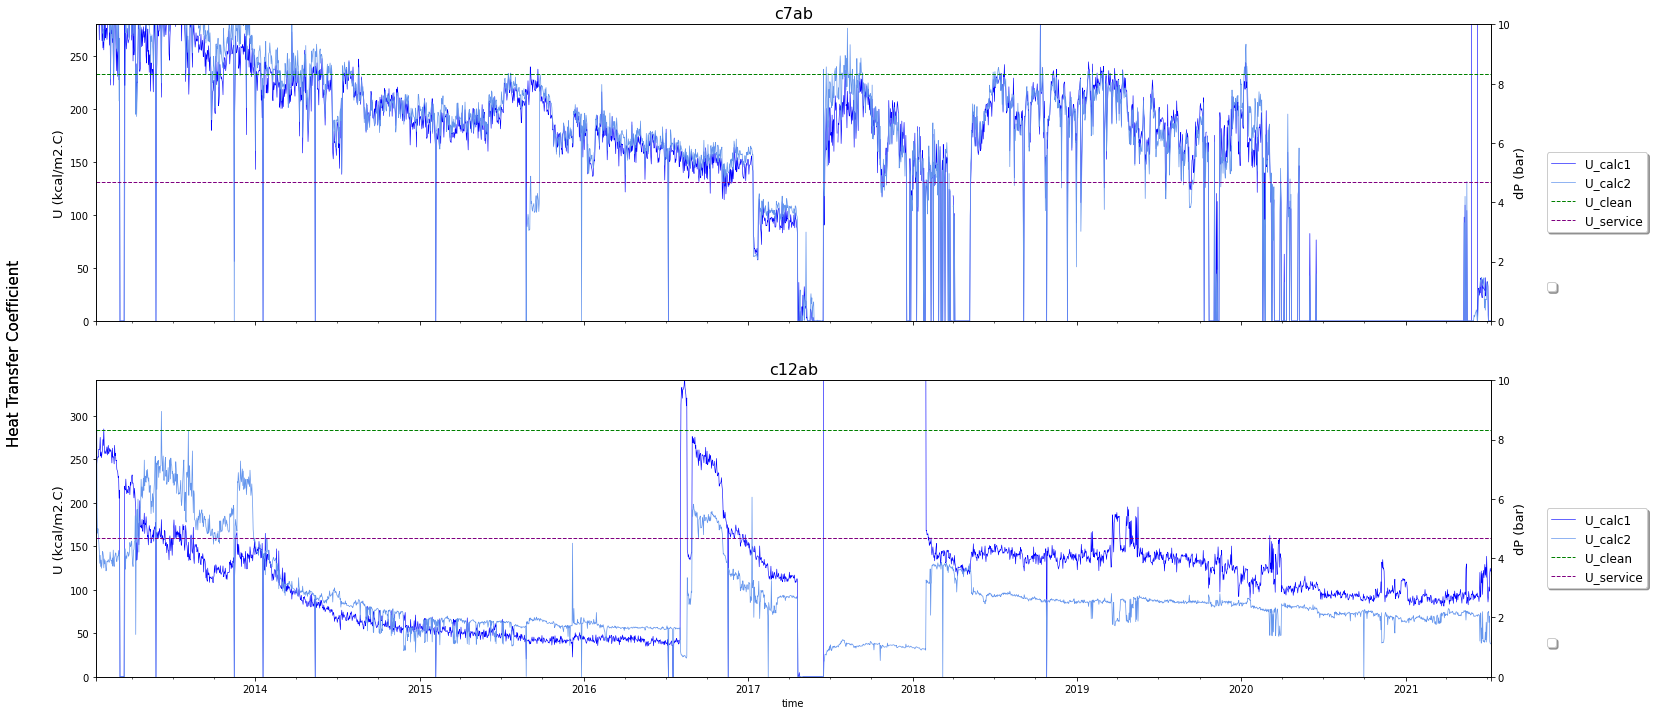

In [284]:
plot_hex(['c7ab', 'c12ab'])

In [285]:
#hex_list = [input("Enter Heat Exchanger : ")]

<AxesSubplot:xlabel='time'>

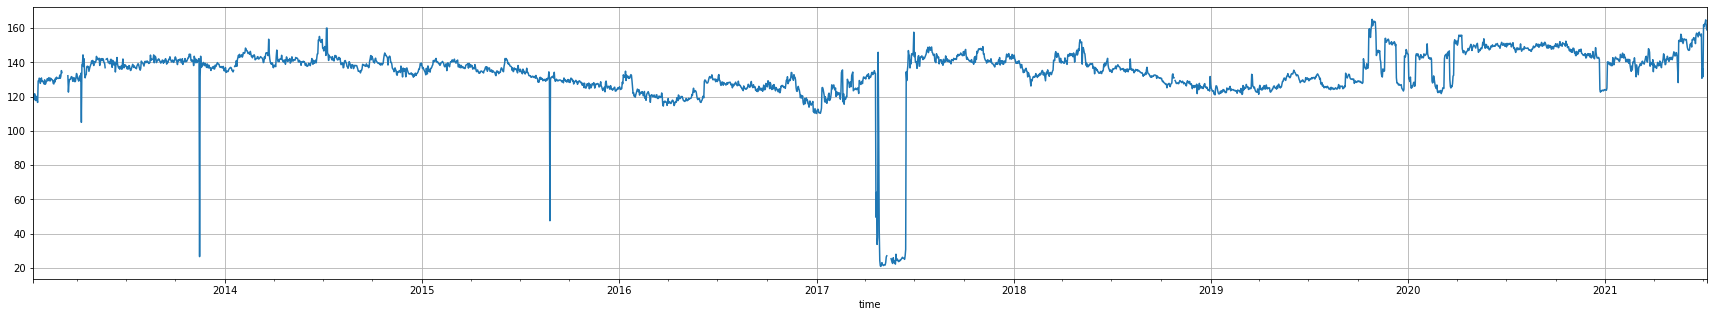

In [286]:
df['c6ab_crude_tout'].plot(figsize=(30,5), grid=True)

In [287]:
df['cdu_pa_duty'] = df['c1ab_crude_gcalh'] + df['c4ab_crude_gcalh'] + df['c9ab_crude_gcalh'] + df['c11_flashed_crude_gcalh'] + df['c13ab_flashed_crude_gcalh']

<AxesSubplot:xlabel='time'>

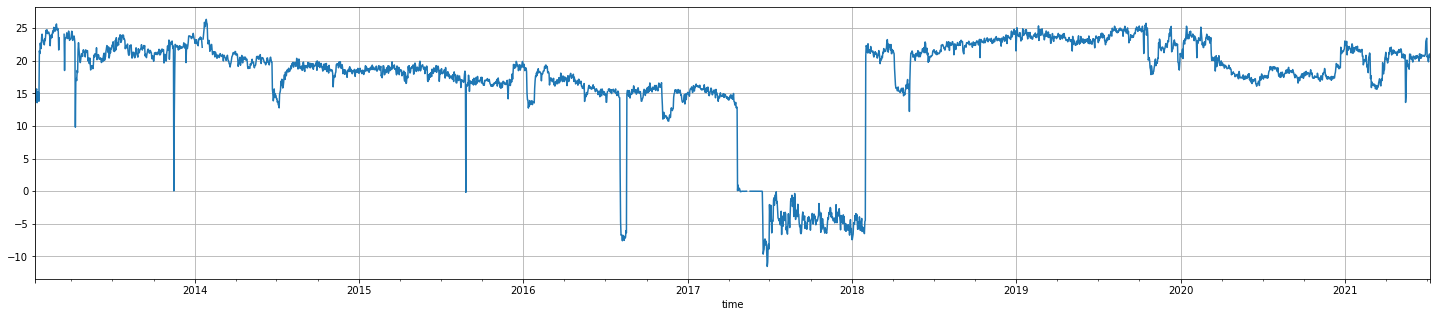

In [288]:
df['cdu_pa_duty'].plot(figsize=(25,5), grid=True)

In [289]:
# TOTAL heat to Crude
df['pht_crude_gcalh'] = (df['c1ab_crude_gcalh'] + 
                         df['c2ab_crude_gcalh'] +
                         df['c3_crude_gcalh'] +
                         df['c4ab_crude_gcalh'] +
                         df['c5ab_crude_gcalh'] + 
                         df['c6ab_crude_gcalh'] + 
                         df['c7ab_crude_gcalh'] + 
                         df['c8ab_crude_gcalh'] +
                         df['c9ab_crude_gcalh'] +
                         df['c10ab_flashed_crude_gcalh'] + 
                         df['c11_flashed_crude_gcalh'] +
                         df['c12ab_flashed_crude_gcalh'] +
                         df['c13ab_flashed_crude_gcalh'] +
                         df['c14abcd_flashed_crude_gcalh'] +
                         df['c15abc_flashed_crude_gcalh'] +
                         
                         df['j70abc_on_off'] * (df['c70ab_lssr_gcalh'] + df['c71abc_lssr_gcalh'] + df['c72abcd_hvgo_gcalh']))

<AxesSubplot:xlabel='time'>

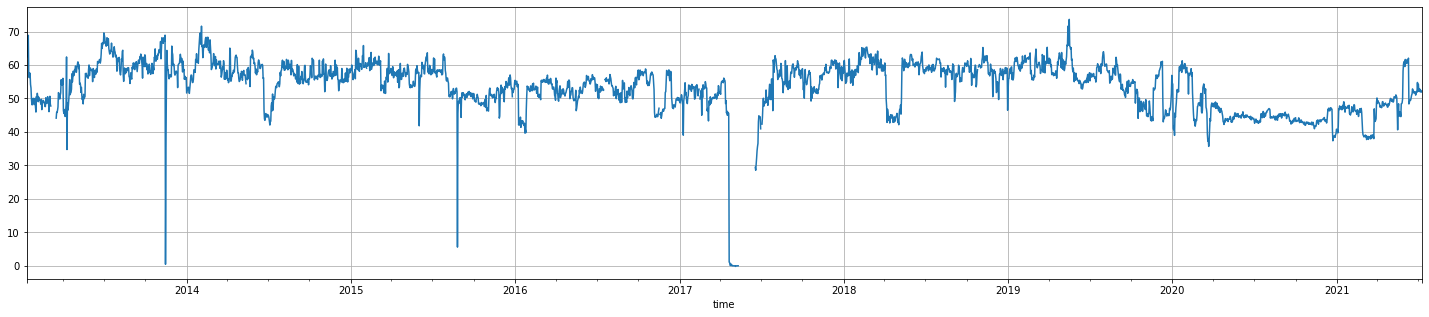

In [290]:
(df['pht_crude_gcalh']).plot(figsize=(25,5), grid=True)

In [291]:
df['hvgo_pa_duty_gcalh'] = df['c12ab_flashed_crude_gcalh'] + df['c72abcd_lssr_gcalh'] + df['c10ab_flashed_crude_gcalh'] + df['c8ab_crude_gcalh'] + df['c6ab_crude_gcalh']

<AxesSubplot:xlabel='time'>

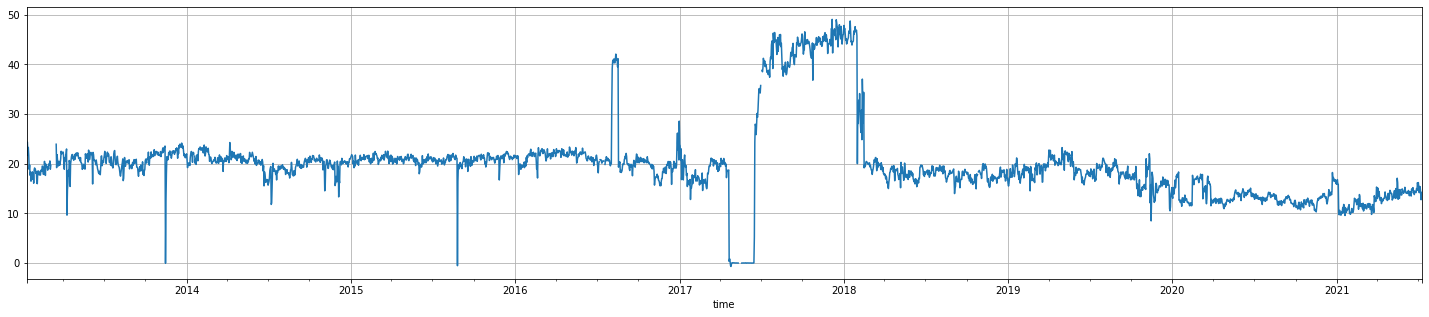

In [292]:
df['hvgo_pa_duty_gcalh'].plot(figsize=(25,5), grid=True)

In [293]:
df['cdu_pa_gcalh'] = df['c4ab_crude_gcalh'] + df['c9ab_crude_gcalh'] + df['c11_flashed_crude_gcalh'] + df['c13ab_flashed_crude_gcalh']

In [294]:
cp_min = []
cp_max = []
sg_min = []
sg_max = []
for col in [col for col in df.columns if 'cp' in col]:
    cp_min.append(df[col].min())
    cp_max.append(df[col].max())
    
for col in [col for col in df.columns if 'sg' in col]:
    sg_min.append(df[col].min())
    sg_max.append(df[col].max())
    
#make dataframe of stream cps min and max values
df_cps = pd.DataFrame(zip(cp_min, cp_max), index=[col for col in df.columns if 'cp' in col], columns=['min', 'max'])

#make dataframe of stream SGs min and max values
df_sgs = pd.DataFrame(zip(sg_min, sg_max), index=[col for col in df.columns if 'sg' in col], columns=['min', 'max'])

In [295]:
df_sgs

,min,max
crude_sg,0.8003,0.87399
lssr_sg,0.9000,1.02470
frsrn_sg,0.7000,0.79390
kero_sg,0.7591,0.81760
lgo_sg,0.8000,0.87900
hgo_sg,0.8118,0.89459
e7_lvgo_sg,0.0000,0.88550
e3_lvgo_sg,0.8012,0.95000
hvgo_sg,0.8042,1.00000
vr_sg,0.0000,0.97150


In [296]:
#df_cps

***HEXCHANGER***

In [297]:
from ht import effectiveness_NTU_method

In [298]:
class Stream:
    def __init__(self, massflow, temp, stream_type='crude', units=['kg/s', 'C', 'J/kgC']):
        self.massflow = massflow
        self.temp = temp
        self.stream_type = stream_type
        self.units = units

    def cp(self):
        if self.stream_type == 'crude':
             return crude_cp(self.temp, units='j_kg.c')

        elif self.stream_type == 'flashed_crude':
            return flashed_crude_cp(self.temp, units='j_kg.c')

        elif self.stream_type == 'lssr':
            return lssr_cp(self.temp, units='j_kg.c')

        elif self.stream_type == 'e1_tpa':
            return e1_tpa_cp(self.temp, units='j_kg.c')

        elif self.stream_type == 'kero':
            return kero_cp(self.temp, units='j_kg.c')

        elif self.stream_type == 'lgo':
            return lgo_cp(self.temp, units='j_kg.c')

        elif self.stream_type == 'hgo':
            return hgo_cp(self.temp, units='j_kg.c')

        elif self.stream_type == 'ar':
            return ar_cp(self.temp, units='j_kg.c')

        elif self.stream_type == 'e7_tpa':
            return e7_tpa_cp(self.temp, units='j_kg.c')

        elif self.stream_type == 'hvgo':
            return hvgo_cp(self.temp, units='j_kg.c')

        elif self.stream_type == 'vr':
            return vr_cp(self.temp, units='j_kg.c')

        elif self.stream_type == 'vbr':
            return vr_cp(self.temp, units='j_kg.c')
        
        else:
            print('enter valid stream type')
            
    def __str__(self):
        return(f'Massflow(kg/s):{round(self.massflow,2)}, temp(C):{round(self.temp,2)}, stream_type:{self.stream_type}')

In [299]:
def stream_mixer(*streams):
    '''Mix 2 or more Streams together, to return combined Stream object.
       Note: Streams must be of same type eg. both crude. As the specific heat capacity is not taken into account.
    '''
    massflow = 0
    for stream in streams:
        massflow += stream.massflow
        
    mass_temp = 0
    for stream in streams:
        mass_temp += (stream.massflow * stream.temp)
    temp = mass_temp/massflow
    
    if len(set([stream.stream_type for stream in streams])) !=1:
        print("Ensure alls streams are of same 'stream_type'")
    
    stream_type = streams[0].stream_type
    
    return Stream(massflow, temp, stream_type)

In [300]:
def stream_mixer_temp(*streams):
    '''Mix 2 or more Streams together, to return combined temperature
       Note: Assumes streams must be of ~same type eg. both crude, as the specific heat capacity is not taken into account.
    '''
    massflow = 0
    for stream in streams:
        massflow += stream.massflow
        
    mass_temp = 0
    for stream in streams:
        mass_temp += (stream.massflow * stream.temp)
    temp = mass_temp/massflow
    
    return temp

In [301]:
class Hex:
    def __init__(self, name, cold_in, cold_out, hot_in, hot_out, u, area_shell, n_shells):
        self.name = name
        self.cold_in = cold_in
        self.cold_out = cold_out
        self.hot_in = hot_in
        self.hot_out = hot_out
        self.u = u
        self.area_shell = area_shell
        self.n_shells = n_shells
        
    def hot_tout(self):
        hex_calc = effectiveness_NTU_method(mh = self.hot_in.massflow,
                                 mc = self.cold_in.massflow, 
                                 Cph = (self.hot_in.cp() + self.hot_out.cp())/2, 
                                 Cpc = (self.cold_in.cp() + self.cold_out.cp())/2,
                                 subtype = str(self.n_shells)+'S&T', 
                                 Tci = self.cold_in.temp, 
                                 Thi = self.hot_in.temp,
                                 UA = self.u * self.area_shell * self.n_shells)
        return hex_calc['Tho']
    
    def cold_tout(self):
        hex_calc = effectiveness_NTU_method(mh = self.hot_in.massflow,
                                 mc = self.cold_in.massflow, 
                                 Cph = (self.hot_in.cp() + self.hot_out.cp())/2, 
                                 Cpc = (self.cold_in.cp() + self.cold_out.cp())/2,
                                 subtype = str(self.n_shells)+'S&T', 
                                 Tci = self.cold_in.temp, 
                                 Thi = self.hot_in.temp,
                                 UA = self.u * self.area_shell * self.n_shells)
        return hex_calc['Tco']    
    
    def cold_stream_out(self):
        return Stream(self.cold_in.massflow, self.cold_tout(), self.cold_in.stream_type)
    
    def hot_stream_out(self):
        return Stream(self.hot_in.massflow, self.hot_tout(), self.hot_in.stream_type)
    
    def duty_cold(self, units='gcal_h'):
        cold_stream_duty = self.cold_in.massflow * 0.5*(self.cold_in.cp() + self.cold_out.cp()) * (self.cold_tout() - self.cold_in.temp)
        if units=='gcal_h':
            return cold_stream_duty/1163000
        else:
            print('invalid arguments')
    
    def duty_hot(self, units='gcal_h'):
        hot_stream_duty = self.hot_in.massflow * 0.5*(self.hot_in.cp() + self.hot_out.cp()) * (self.hot_tout() - self.hot_in.temp)
        if units=='gcal_h':
            return hot_stream_duty/1163000
        else:
            print('invalid arguments')
            
    def lmtd(self):
        return lmtd(self.hot_in.temp, self.hot_tout(), self.cold_in.temp, self.cold_tout())    
    
    def energy_balance(self):
        return abs(abs(self.duty_cold()) - abs(self.duty_hot()))/1163000
    
    def __str__(self):
        return(f'{self.name}: {self.cold_in.stream_type},{self.hot_in.stream_type} Gcal/h:{round(self.duty_cold(),2)}, Tci:{round(self.cold_in.temp,2)}C, Tco:{round(self.cold_tout(),2)}C, \
        Thi:{round(self.hot_in.temp,2)}C, Tho:{round(self.hot_tout(),2)}C, U(W/m2.K):{round(self.u,2)}, Area_shell(m2):{round(self.area_shell,1)}, n_shells:{self.n_shells}, energy_balance:{round(self.energy_balance(),3)}')
    

In [302]:
#extract mass flows of key streams not already calculated

#CRUDE
# FUTURE: may want to add check that flow to c1a + c1b equals total crude rate (to train 1). Or simply ratio 50:50 to each..
df['c1a_crude_tnh'] = df.c1a_crude_m3h * df.crude_sg
df['c1b_crude_tnh'] = df.c1b_crude_m3h * df.crude_sg
                                       
#LSSR

df['c73ab_e3_feed_tnh'] = df.c73ab_e3_feed_m3h * df.lssr_sg

#VFR
df['vfr_tnh']         = df.vfr_m3h * df.vfr_sg
df['vfr_to_e3_tnh']   = df.vfr_to_e3_m3h * df.vfr_sg
df['vfr_to_fcc_tnh']   = df.vfr_to_fcc_m3h * df.vfr_sg
df['vfr_to_storage_tnh']   = df.vfr_to_storage_m3h * df.vfr_sg

df['e3_feed_tnh'] = df['c73ab_e3_feed_tnh']

#PUMPAROUNDS
df['e1_tpa_tnh']  = df.c2ab_e1_tpa_m3h * df.frsrn_sg
df['c1a_e7_tpa_tnh'] =  df.c1a_e7_tpa_m3h * df.e7_lvgo_sg
df['c1b_e7_tpa_tnh'] = df.c1b_e7_tpa_m3h * df.e7_lvgo_sg
df['c2ab_e1_tpa_tnh'] = df.c2ab_e1_tpa_m3h * df.frsrn_sg
df['c70ab_e1_tpa_tnh'] = df.c70ab_e1_tpa_m3h * df.frsrn_sg

df['kpa_tnh']     = df.c4ab_kpa_m3h * df.kero_sg
df['lgo_pa_tnh']  = df.c9ab_lgo_pa_m3h * df.lgo_sg
df['hgo_pa_tnh']  = df.c11_hgo_pa_m3h * df.hgo_sg
df['e7_tpa_tnh']  = df.c1ab_e7_tpa_m3h * df.e7_lvgo_sg

df['hvgo_pa_tnh'] = df.hvgo_tot_m3h * df.hvgo_sg   #remove this?
df['hvgo_tnh'] = df.hvgo_tot_m3h * df.hvgo_sg


df['c12ab_hvgo_tnh'] = df.c12ab_hvgo_m3h * df.hvgo_sg
df['c72abcd_hvgo_tnh'] = df.c72abcd_hvgo_m3h * df.hvgo_sg
df['e3_bpa_tnh'] = df.c73ab_e3_bpa_m3h * df.vr_sg

#PRODUCTS
df['ar_tnh']         = df.ar_to_e7_m3h * df.ar_sg
df['c14abcd_ar_tnh'] = df.c14abcd_ar_m3h * df.ar_sg

df['c15abc_vbr_tnh'] = df.c15abc_vbr_m3h * df.vbr_sg
df['c71abc_vbr_tnh'] = df.c71abc_vbr_m3h * df.vbr_sg
df['vbr_tnh']        = df.c71abc_vbr_tnh

In [303]:
#SAVE PROCESSED FRAME FOR USE ON OTHER PROGRAMS WHERE REQUIRED
# import pickle

# filename = 'pht_df.pickle'
# outfile = open(filename, 'wb')
# pickle.dump(df, outfile)
# outfile.close()

In [304]:
#NEED TO ACCOUNT FOR HOT TIN WHEN WE WANT THE CALCULATED ONE eg c72abcd Tout calc, instead of the plant measured one.......... 
#order list of exchangers so that the intermediate temperatures can be saved/used by the subsequent ones where necessary

ordered_hex_list = ['c12ab',   #hvgo_pa
                 'c72abcd',
                 'c10ab',
                 'c8ab',
                 'c6ab',
                 'c13ab',   #hgo_pa
                 'c11',
                 'c15abc',    #vbr
                 'c71abc',
                 'c1a',
                 'c1b',
                 'c2ab',
                 'c3',
                 'c4ab',
                 'c5ab',
                 'c7ab',
                 'c9ab',
                 'c14abcd',
                 'c70ab',
                 'c73ab'
                 ]

In [305]:
#Initial calcs based on plant data looks at C1ab as a whole, whereas HEXchanger calcs treat each parallel exchanger individually. For ease, will assume equal Tin and Duty for each exchanger
df['c1a_crude_gcalh'] = df['c1ab_crude_gcalh']/2
df['c1b_crude_gcalh'] = df['c1ab_crude_gcalh']/2

df['c1a_e7_tpa_tin'] = df['c1ab_e7_tpa_tin']
df['c1b_e7_tpa_tin'] = df['c1ab_e7_tpa_tin']

***INITIALIZE THE EXCHANGERS***

In [308]:
#INITIALIZE THE EXCHANGERS
date='2020-01-01'

crude_tnh         = df['crude_tnh'].fillna(method='ffill')[date]
c1a_crude_tnh     = df['c1a_crude_tnh'].fillna(method='ffill')[date]
c1b_crude_tnh     = df['c1b_crude_tnh'].fillna(method='ffill')[date]
flashed_crude_tnh = df['flashed_crude_tnh'].fillna(method='ffill')[date]

lssr_tnh          = df['lssr_tnh'].fillna(method='ffill')[date]
c73ab_e3_feed_tnh = df['c73ab_e3_feed_tnh'].fillna(method='ffill')[date]

#PUMPAROUNDS
c1a_e7_tpa_tnh    = df['c1a_e7_tpa_tnh'].fillna(method='ffill')[date]
c1b_e7_tpa_tnh    = df['c1b_e7_tpa_tnh'].fillna(method='ffill')[date]

e1_tpa_tnh        = df['e1_tpa_tnh'].fillna(method='ffill')[date]
c2ab_e1_tpa_tnh   = df['c2ab_e1_tpa_tnh'].fillna(method='ffill')[date]
c70ab_e1_tpa_tnh  = df['c70ab_e1_tpa_tnh'].fillna(method='ffill')[date]

kpa_tnh           = df['kpa_tnh'].fillna(method='ffill')[date]
lgo_pa_tnh        = df['lgo_pa_tnh'].fillna(method='ffill')[date]
hgo_pa_tnh        = df['hgo_pa_tnh'].fillna(method='ffill')[date]
e7_tpa_tnh        = df['e7_tpa_tnh'].fillna(method='ffill')[date]

hvgo_pa_tnh       = df['hvgo_pa_tnh'].fillna(method='ffill')[date]
hvgo_tnh = hvgo_pa_tnh

c12ab_hvgo_tnh = df['c12ab_hvgo_tnh'].fillna(method='ffill')[date]
c72abcd_hvgo_tnh = df['c72abcd_hvgo_tnh'].fillna(method='ffill')[date]
e3_bpa_tnh         = df['e3_bpa_tnh'].fillna(method='ffill')[date]

#PRODUCTS
kero_prod_tnh     = df['kero_prod_tnh'].fillna(method='ffill')[date]
lgo_prod_tnh      = df['lgo_prod_tnh'].fillna(method='ffill')[date]
hgo_prod_tnh      = df['hgo_prod_tnh'].fillna(method='ffill')[date]
e7_lvgo_prod_tnh  = df['e7_lvgo_prod_tnh'].fillna(method='ffill')[date]
e3_lvgo_prod_tnh  = df['e3_lvgo_prod_tnh'].fillna(method='ffill')[date]
hvgo_prod_tnh     = df['hvgo_prod_tnh'].fillna(method='ffill')[date]
ar_tnh            = df['ar_tnh'].fillna(method='ffill')[date]
c14abcd_ar_tnh    = df['c14abcd_ar_tnh'].fillna(method='ffill')[date]
vfr_to_e3_tnh     = df['vfr_to_e3_tnh'].fillna(method='ffill')[date]
vfr_to_fcc_tnh    = df['vfr_to_fcc_tnh'].fillna(method='ffill')[date]
vr_tnh            = df['vr_tnh'].fillna(method='ffill')[date]
vbr_tnh           = df['vbr_tnh'].fillna(method='ffill')[date]
c71abc_vbr_tnh    = df['c71abc_vbr_tnh'].fillna(method='ffill')[date]

#TEMPERATURES
c1a_crude_tin     = df['c1a_crude_tin'].fillna(method='ffill')[date]
c1b_crude_tin     = df['c1a_crude_tin'].fillna(method='ffill')[date]

#ADD FORMULA/FUNTION TO CALC FLASHED CRUDE TEMP

c70ab_lssr_tin    = df['c70ab_lssr_tin'].fillna(method='ffill')[date]
c1a_e7_tpa_tin    = df['c1a_e7_tpa_tin'].fillna(method='ffill')[date]
c1b_e7_tpa_tin    = df['c1a_e7_tpa_tin'].fillna(method='ffill')[date]
c2ab_e1_tpa_tin   = df['c2ab_e1_tpa_tin'].fillna(method='ffill')[date] 
c3_kero_prod_tin  = df['c3_kero_prod_tin'].fillna(method='ffill')[date]  
c4ab_kpa_tin      = df['c4ab_kpa_tin'].fillna(method='ffill')[date]      
c5ab_lgo_prod_tin = df['c5ab_lgo_prod_tin'].fillna(method='ffill')[date]
c7ab_hgo_prod_tin = df['c7ab_hgo_prod_tin'].fillna(method='ffill')[date]
c9ab_lgo_pa_tin   = df['c9ab_lgo_pa_tin'].fillna(method='ffill')[date]
c12ab_hvgo_tin  = df['c12ab_hvgo_tin'].fillna(method='ffill')[date]
c13ab_hgo_pa_tin  = df['c13ab_hgo_pa_tin'].fillna(method='ffill')[date]
c14abcd_ar_tin    = df['c14abcd_ar_tin'].fillna(method='ffill')[date]
c73ab_e3_bpa_tin  = df['c73ab_e3_bpa_tin'].fillna(method='ffill')[date]
c15abc_vbr_tin    = df['c15abc_vbr_tin'].fillna(method='ffill')[date]    
c72abcd_hvgo_tin = df['c72abcd_hvgo_tin'].fillna(method='ffill')[date]

#Set initialisation temperature to allow the program to solve
init_temp = 99

#SET STREAMS WITH INITIAL CONDITIONS

c1a_cold_in  = Stream(c1a_crude_tnh * (1000/3600),   c1a_crude_tin,        stream_type='crude')
c1a_cold_out = Stream(c1a_crude_tnh * (1000/3600),   init_temp,            stream_type='crude')
c1a_hot_in   = Stream(c1a_e7_tpa_tnh * (1000/3600) , c1a_e7_tpa_tin,       stream_type='e7_tpa')
c1a_hot_out  = Stream(c1a_e7_tpa_tnh * (1000/3600) , init_temp,            stream_type='e7_tpa')

c1b_cold_in  = Stream(c1b_crude_tnh * (1000/3600),  c1b_crude_tin,         stream_type='crude')
c1b_cold_out = Stream(c1b_crude_tnh * (1000/3600),  init_temp,             stream_type='crude')
c1b_hot_in   = Stream(c1b_e7_tpa_tnh * (1000/3600), c1b_e7_tpa_tin,        stream_type='e7_tpa')
c1b_hot_out  = Stream(c1b_e7_tpa_tnh * (1000/3600), init_temp,             stream_type='e7_tpa')

c2ab_cold_in  = Stream(crude_tnh * (1000/3600),       init_temp,           stream_type='crude')
c2ab_cold_out = Stream(crude_tnh * (1000/3600),       init_temp,           stream_type='crude')
c2ab_hot_in   = Stream(c2ab_e1_tpa_tnh * (1000/3600), c2ab_e1_tpa_tin,     stream_type='e1_tpa')
c2ab_hot_out  = Stream(c2ab_e1_tpa_tnh * (1000/3600), init_temp,           stream_type='e1_tpa')

c3_cold_in  = Stream(crude_tnh * (1000/3600),     init_temp,               stream_type='crude')
c3_cold_out = Stream(crude_tnh * (1000/3600),     init_temp,               stream_type='crude')
c3_hot_in   = Stream(kero_prod_tnh * (1000/3600), c3_kero_prod_tin,        stream_type='kero')
c3_hot_out  = Stream(kero_prod_tnh * (1000/3600), init_temp,               stream_type='kero')

c4ab_cold_in  = Stream(crude_tnh * (1000/3600), init_temp,                 stream_type='crude')
c4ab_cold_out = Stream(crude_tnh * (1000/3600), init_temp,                 stream_type='crude')
c4ab_hot_in   = Stream(kpa_tnh * (1000/3600),   c4ab_kpa_tin,              stream_type='kero')
c4ab_hot_out  = Stream(kpa_tnh * (1000/3600),   init_temp,                 stream_type='kero')

c5ab_cold_in  = Stream(crude_tnh * (1000/3600), init_temp,                 stream_type='crude')
c5ab_cold_out = Stream(crude_tnh * (1000/3600), init_temp,                 stream_type='crude')
c5ab_hot_in   = Stream(lgo_prod_tnh * (1000/3600), c5ab_lgo_prod_tin,      stream_type='lgo')
c5ab_hot_out  = Stream(lgo_prod_tnh * (1000/3600),  init_temp,             stream_type='lgo')

c6ab_cold_in  = Stream(crude_tnh * (1000/3600),   init_temp,           stream_type='crude')
c6ab_cold_out = Stream(crude_tnh * (1000/3600),   init_temp,           stream_type='crude')
c6ab_hot_in   = Stream(hvgo_pa_tnh * (1000/3600), init_temp,           stream_type='hvgo')
c6ab_hot_out  = Stream(hvgo_pa_tnh * (1000/3600), init_temp,           stream_type='hvgo')

c7ab_cold_in  = Stream(crude_tnh * (1000/3600), init_temp,             stream_type='crude')
c7ab_cold_out = Stream(crude_tnh * (1000/3600), init_temp,             stream_type='crude')
c7ab_hot_in   = Stream(hgo_prod_tnh * (1000/3600), c7ab_hgo_prod_tin,  stream_type='hgo')
c7ab_hot_out  = Stream(hgo_prod_tnh * (1000/3600),  init_temp,         stream_type='hgo')

c8ab_cold_in  = Stream(crude_tnh * (1000/3600),   init_temp,           stream_type='crude')
c8ab_cold_out = Stream(crude_tnh * (1000/3600),   init_temp,           stream_type='crude')
c8ab_hot_in   = Stream(hvgo_pa_tnh * (1000/3600), init_temp,           stream_type='hvgo')
c8ab_hot_out  = Stream(hvgo_pa_tnh * (1000/3600), init_temp,           stream_type='hvgo')

c9ab_cold_in  = Stream(crude_tnh * (1000/3600),  init_temp,            stream_type='crude')
c9ab_cold_out = Stream(crude_tnh * (1000/3600),  init_temp,            stream_type='crude')
c9ab_hot_in   = Stream(lgo_pa_tnh * (1000/3600), c9ab_lgo_pa_tin,      stream_type='lgo')
c9ab_hot_out  = Stream(lgo_pa_tnh * (1000/3600), init_temp,            stream_type='lgo')

#FLASHED CRUDE

c10ab_cold_in  = Stream(flashed_crude_tnh * (1000/3600),   init_temp, stream_type='flashed_crude')
c10ab_cold_out = Stream(flashed_crude_tnh * (1000/3600),   init_temp, stream_type='crude')
c10ab_hot_in   = Stream(hvgo_pa_tnh * (1000/3600),         init_temp, stream_type='hvgo')
c10ab_hot_out  = Stream(hvgo_pa_tnh * (1000/3600),         init_temp, stream_type='hvgo')

c11_cold_in  = Stream(flashed_crude_tnh * (1000/3600),  init_temp, stream_type='crude')
c11_cold_out = Stream(flashed_crude_tnh * (1000/3600),  init_temp, stream_type='crude')
c11_hot_in   = Stream(hgo_pa_tnh * (1000/3600),         init_temp, stream_type='hgo')
c11_hot_out  = Stream(hgo_pa_tnh * (1000/3600),         init_temp, stream_type='hgo')

c12ab_cold_in  = Stream(flashed_crude_tnh * (1000/3600),   init_temp, stream_type='crude')
c12ab_cold_out = Stream(flashed_crude_tnh * (1000/3600),   init_temp, stream_type='crude')
c12ab_hot_in   = Stream(c12ab_hvgo_tnh * (1000/3600),   c12ab_hvgo_tin, stream_type='hvgo')
c12ab_hot_out  = Stream(c12ab_hvgo_tnh * (1000/3600),   init_temp, stream_type='hvgo')

c13ab_cold_in  = Stream(flashed_crude_tnh * (1000/3600),  init_temp, stream_type='crude')
c13ab_cold_out = Stream(flashed_crude_tnh * (1000/3600),  init_temp, stream_type='crude')
c13ab_hot_in   = Stream(hgo_pa_tnh * (1000/3600),         c13ab_hgo_pa_tin, stream_type='hgo')
c13ab_hot_out  = Stream(hgo_pa_tnh * (1000/3600),         init_temp, stream_type='hgo')

#start with all AR going to C14. Use function to tune outlet temp of outlet/bypass to 280C...
c14abcd_cold_in  = Stream(flashed_crude_tnh * (1000/3600),  init_temp, stream_type='crude')
c14abcd_cold_out = Stream(flashed_crude_tnh * (1000/3600),  init_temp, stream_type='crude')
c14abcd_hot_in   = Stream(ar_tnh * (1000/3600),             c14abcd_ar_tin, stream_type='ar')
c14abcd_hot_out  = Stream(ar_tnh * (1000/3600),             init_temp, stream_type='ar')

c15abc_cold_in  = Stream(flashed_crude_tnh * (1000/3600),  init_temp, stream_type='crude')
c15abc_cold_out = Stream(flashed_crude_tnh * (1000/3600),  init_temp, stream_type='crude')
c15abc_hot_in   = Stream(vbr_tnh * (1000/3600),             c15abc_vbr_tin, stream_type='ar')
c15abc_hot_out  = Stream(vbr_tnh * (1000/3600),             init_temp, stream_type='ar')

#LSSR

c70ab_cold_in  = Stream(lssr_tnh * (1000/3600),         c70ab_lssr_tin,         stream_type='lssr')
c70ab_cold_out = Stream(lssr_tnh * (1000/3600),         init_temp,              stream_type='lssr')
c70ab_hot_in   = Stream(c70ab_e1_tpa_tnh * (1000/3600), c2ab_e1_tpa_tin, stream_type='e1_tpa')
c70ab_hot_out  = Stream(c70ab_e1_tpa_tnh * (1000/3600), init_temp,              stream_type='e1_tpa')

c71abc_cold_in  = Stream(lssr_tnh * (1000/3600),        init_temp, stream_type='lssr')
c71abc_cold_out = Stream(lssr_tnh * (1000/3600),        init_temp, stream_type='lssr')
c71abc_hot_in   = Stream(c71abc_vbr_tnh * (1000/3600),  init_temp, stream_type='vbr')
c71abc_hot_out  = Stream(c71abc_vbr_tnh * (1000/3600),  init_temp, stream_type='vbr')

c72abcd_cold_in  = Stream(lssr_tnh * (1000/3600),             init_temp,           stream_type='lssr')
c72abcd_cold_out = Stream(lssr_tnh * (1000/3600),             init_temp,           stream_type='lssr')
c72abcd_hot_in   = Stream(c72abcd_hvgo_tnh * (1000/3600),  c72abcd_hvgo_tin, stream_type='hvgo')
c72abcd_hot_out  = Stream(c72abcd_hvgo_tnh * (1000/3600),  init_temp,           stream_type='hvgo')

vfr_to_e3      = Stream(vfr_to_e3_tnh * (1000/3600), 255, stream_type='lssr')     #enter estimated vfr temp for now. Assume lssr for cp calc

c73ab_cold_in  = Stream(c73ab_e3_feed_tnh * (1000/3600),        init_temp, stream_type='lssr')
c73ab_cold_out = Stream(c73ab_e3_feed_tnh * (1000/3600),        init_temp, stream_type='lssr')
c73ab_hot_in   = Stream(e3_bpa_tnh * (1000/3600),  c73ab_e3_bpa_tin, stream_type='vr')
c73ab_hot_out  = Stream(e3_bpa_tnh * (1000/3600),  init_temp, stream_type='vr')


#Pick out U values at selected date
#convert units from  kcal/hr.m2C to w/m2.C
#Forward fill missing values for now...

c1ab_ucalc1 = df['c1ab_ucalc1'].fillna(method='ffill')[date] * 1.163
c1a_ucalc1 = df['c1ab_ucalc1'].fillna(method='ffill')[date] * 1.163
c1b_ucalc1 = df['c1ab_ucalc1'].fillna(method='ffill')[date] * 1.163

c2ab_ucalc1 = df['c2ab_ucalc1'].fillna(method='ffill')[date]* 1.163
c3_ucalc1   = df['c3_ucalc1'].fillna(method='ffill')[date]* 1.163
c4ab_ucalc1 = df['c4ab_ucalc1'].fillna(method='ffill')[date]* 1.163
c5ab_ucalc1 = df['c5ab_ucalc1'].fillna(method='ffill')[date]* 1.163
c6ab_ucalc1 = df['c6ab_ucalc1'].fillna(method='ffill')[date]* 1.163
c7ab_ucalc1 = df['c7ab_ucalc1'].fillna(method='ffill')[date]* 1.163
c8ab_ucalc1 = df['c8ab_ucalc1'].fillna(method='ffill')[date]* 1.163
c9ab_ucalc1 = df['c9ab_ucalc1'].fillna(method='ffill')[date]* 1.163
c10ab_ucalc1 = df['c10ab_ucalc1'].fillna(method='ffill')[date]* 1.163
c11_ucalc1 = df['c11_ucalc1'].fillna(method='ffill')[date]* 1.163
c12ab_ucalc1 = df['c12ab_ucalc1'].fillna(method='ffill')[date]* 1.163
c13ab_ucalc1 = df['c13ab_ucalc1'].fillna(method='ffill')[date]* 1.163
c14abcd_ucalc1 = df['c14abcd_ucalc1'].fillna(method='ffill')[date]* 1.163
c15abc_ucalc1 = df['c15abc_ucalc1'].fillna(method='ffill')[date]* 1.163
c70ab_ucalc1 = df['c70ab_ucalc1'].fillna(method='ffill')[date]* 1.163
c71abc_ucalc1 = df['c71abc_ucalc1'].fillna(method='ffill')[date]* 1.163
c72abcd_ucalc1 = df['c72abcd_ucalc1'].fillna(method='ffill')[date]* 1.163
c73ab_ucalc1 = df['c73ab_ucalc1'].fillna(method='ffill')[date]* 1.163

#Create the exchangers 
c1a = Hex(name     ='c1a',
          cold_in    = c1a_cold_in, 
          cold_out   = c1a_cold_out, 
          hot_in     = c1a_hot_in,
          hot_out    = c1a_hot_out, 
          u          = c1ab_ucalc1, 
          area_shell = 269.4, 
          n_shells   = 1
          )

c1b = Hex(name     ='c1b',
          cold_in    = c1b_cold_in, 
          cold_out   = c1b_cold_out, 
          hot_in     = c1b_hot_in,
          hot_out    = c1b_hot_out, 
          u          = c1ab_ucalc1, 
          area_shell = 269.4, 
          n_shells   = 1
          )

c2ab = Hex(name     ='c2ab',
           cold_in    = c2ab_cold_in, 
           cold_out   = c2ab_cold_out, 
           hot_in     = c2ab_hot_in,
           hot_out    = c2ab_hot_out, 
           u          = c2ab_ucalc1, 
           area_shell = 195.8, 
           n_shells   = 2
           )

c3 = Hex(name     ='c3',
          cold_in     = c3_cold_in, 
          cold_out   = c3_cold_out, 
          hot_in     = c3_hot_in,
          hot_out    = c3_hot_out, 
          u          = c3_ucalc1, 
          area_shell = 233.4, 
          n_shells   = 1
          )

c4ab = Hex(name     ='c4ab',
           cold_in    = c4ab_cold_in, 
           cold_out   = c4ab_cold_out, 
           hot_in     = c4ab_hot_in,
           hot_out    = c4ab_hot_out, 
           u          = c4ab_ucalc1, 
           area_shell = 204.4, 
           n_shells   = 2
           )

c5ab = Hex(name     ='c5ab',
           cold_in    = c5ab_cold_in, 
           cold_out   = c5ab_cold_out, 
           hot_in     = c5ab_hot_in,
           hot_out    = c5ab_hot_out, 
           u          = c5ab_ucalc1, 
           area_shell = 247.5, 
           n_shells   = 2
           )

c6ab = Hex(name     ='c6ab',
          cold_in    = c6ab_cold_in, 
           cold_out   = c6ab_cold_out, 
           hot_in     = c6ab_hot_in,
           hot_out    = c6ab_hot_out, 
           u          = c6ab_ucalc1, 
           area_shell = 382.6, 
           n_shells   = 2
           )

c7ab = Hex(name     ='c7ab',
          cold_in    = c7ab_cold_in, 
           cold_out   = c7ab_cold_out, 
           hot_in     = c7ab_hot_in,
           hot_out    = c7ab_hot_out, 
           u          = c7ab_ucalc1, 
           area_shell = 194.2, 
           n_shells   = 2
           )

c8ab = Hex(name     ='c8ab',
          cold_in    = c8ab_cold_in, 
           cold_out   = c8ab_cold_out, 
           hot_in     = c8ab_hot_in,
           hot_out    = c8ab_hot_out, 
           u          = c8ab_ucalc1, 
           area_shell = 399.6, 
           n_shells   = 2
           )

c9ab = Hex(name     ='c9ab',
           cold_in    = c9ab_cold_in, 
           cold_out   = c9ab_cold_out, 
           hot_in     = c9ab_hot_in,
           hot_out    = c9ab_hot_out, 
           u          = c9ab_ucalc1, 
           area_shell = 207.6, 
           n_shells   = 2
          )

c10ab = Hex(name     ='c10ab',
           cold_in   = c10ab_cold_in, 
           cold_out   = c10ab_cold_out, 
           hot_in     = c10ab_hot_in,
           hot_out    = c10ab_hot_out, 
           u          = c10ab_ucalc1, 
           area_shell = 351.1, 
           n_shells   = 2
           )

c11 = Hex(name     ='c11',
           cold_in     = c11_cold_in, 
           cold_out   = c11_cold_out, 
           hot_in     = c11_hot_in,
           hot_out    = c11_hot_out, 
           u          = c11_ucalc1, 
           area_shell = 341.7, 
           n_shells   = 1
           )

c12ab = Hex(name     ='c12ab',
           cold_in   = c12ab_cold_in, 
           cold_out   = c12ab_cold_out, 
           hot_in     = c12ab_hot_in,
           hot_out    = c12ab_hot_out, 
           u          = c12ab_ucalc1, 
           area_shell = 264.2, 
           n_shells   = 2
           )

c13ab = Hex(name     ='c13ab',
          cold_in   = c13ab_cold_in, 
           cold_out   = c13ab_cold_out, 
           hot_in     = c13ab_hot_in,
           hot_out    = c13ab_hot_out, 
           u          = c13ab_ucalc1, 
           area_shell = 178.8, 
           n_shells   = 2
           )

c14abcd = Hex(name     ='c14abcd',
           cold_in = c14abcd_cold_in, 
           cold_out   = c14abcd_cold_out, 
           hot_in     = c14abcd_hot_in,
           hot_out    = c14abcd_hot_out, 
           u          = c14abcd_ucalc1, 
           area_shell = 207.8, 
           n_shells   = 4
           )           

c15abc = Hex(name     ='c15abc',
           cold_in  = c15abc_cold_in, 
           cold_out   = c15abc_cold_out, 
           hot_in     = c15abc_hot_in,
           hot_out    = c15abc_hot_out, 
           u          = c15abc_ucalc1, 
           area_shell = 155.7, 
           n_shells   = 3
           )           

c70ab = Hex(name     ='c70ab',
       cold_in   = c70ab_cold_in, 
           cold_out   = c70ab_cold_out, 
           hot_in     = c70ab_hot_in,
           hot_out    = c70ab_hot_out, 
           u          = c70ab_ucalc1, 
           area_shell = 173.2, 
           n_shells   = 2
           )           

c71abc = Hex(name     ='c71abc',
           cold_in  = c71abc_cold_in, 
           cold_out   = c71abc_cold_out, 
           hot_in     = c71abc_hot_in,
           hot_out    = c71abc_hot_out, 
           u          = c71abc_ucalc1, 
           area_shell = 175.2, 
           n_shells   = 3
           )             

c72abcd = Hex(name     ='c72abcd',
           cold_in = c72abcd_cold_in, 
           cold_out   = c72abcd_cold_out, 
           hot_in     = c72abcd_hot_in,
           hot_out    = c72abcd_hot_out, 
           u          = c72abcd_ucalc1, 
           area_shell = 196.6, 
           n_shells   = 4
           )            

c73ab = Hex(name     ='c73ab',
           cold_in   = c73ab_cold_in, 
           cold_out   = c73ab_cold_out, 
           hot_in     = c73ab_hot_in,
           hot_out    = c73ab_hot_out, 
           u          = c73ab_ucalc1, 
           area_shell = 321.2, 
           n_shells   = 2
           )  

*** U Value Tuning - Use Cold_In, Cold_Out and Hot_In streams to recalculate T_hot_out. Use new Tho for U calc...***

In [309]:
#Initialise an exchanger

hx = 'c2ab'
date = '2019-01-31'

init_temp =99

if hx =='c70ab'or hx=='c71abc' or hx=='c72abcd':
    cold_stream = 'lssr'
elif hx == 'c73ab':
    cold_stream = 'e3_feed'
elif hx =='c10ab'or hx=='c11' or hx=='c12ab' or hx=='c13ab' or hx=='c14abcd' or hx=='c15abc':
    cold_stream = 'flashed_crude'
else:
    cold_stream = 'crude'


globals()[hx+'_cold_in']  = Stream(df[cold_stream+'_tnh'][date]*(1000/3600),             init_temp,           stream_type=cold_stream)
globals()[hx+'_cold_out'] = Stream(df[cold_stream+'_tnh'][date]*(1000/3600),             init_temp,           stream_type=cold_stream)
try: 
    globals()[hx+'_hot_in']   = Stream(df[hx+'_'+hot_stream_dict[hx]+'_tnh'][date]*(1000/3600),  df[hx+'_'+hot_stream_dict[hx]+'_tin'][date], stream_type=hot_stream_cp_dict[hx])
    globals()[hx+'_hot_out']  = Stream(df[hx+'_'+hot_stream_dict[hx]+'_tnh'][date]*(1000/3600),  init_temp,           stream_type=hot_stream_cp_dict[hx])
except:    #hot stream massflow
    globals()[hx+'_hot_in']   = Stream(df[hot_stream_dict[hx]+'_tnh'][date]*(1000/3600),  df[hx+'_'+hot_stream_dict[hx]+'_tin'][date], stream_type=hot_stream_cp_dict[hx])
    globals()[hx+'_hot_out']  = Stream(df[hot_stream_dict[hx]+'_tnh'][date]*(1000/3600),  init_temp,           stream_type=hot_stream_cp_dict[hx])


globals()[hx] = Hex(name     =hx,
               cold_in = globals()[hx+'_cold_in'], 
               cold_out   = globals()[hx+'_cold_out'], 
               hot_in     = globals()[hx+'_hot_in'],
               hot_out    = globals()[hx+'_hot_out'], 
               u          = df[hx+'_ucalc1'][date], 
               area_shell = hex_area[hx], 
               n_shells   =  hex_shells[hx]
               )          
print(df[hx+'_ucalc1'][date])

227.85941654622724


***Recalculate U - Method 1***

By inputting updated Thot_out into ltmd >> U calc

Note that as UA is provided in the Hex_NTUeff calc, the stream temps may change slightly from those inputted...

Note that in this instance, the tuned U values can vary widely to the original values

In [310]:
#date = '2019-01-31'
#hx = 'c72abcd'
for i in range(0,7):

    if hx =='c70ab'or hx=='c71abc' or hx=='c72abcd':
        cold_stream = 'lssr'
    elif hx == 'c73ab':
        cold_stream = 'e3_feed'
    elif hx =='c10ab'or hx=='c11' or hx=='c12ab' or hx=='c13ab' or hx=='c14abcd' or hx=='c15abc':
        cold_stream = 'flashed_crude'
    else:
        cold_stream = 'crude'

    #connect calculated hot_in temps to appropriate exchangers
    if hx=='c6ab':
        c6ab.hot_in.temp = c8ab.hot_out.temp
    elif hx=='c8ab':
        c8ab.hot_in.temp = c10ab.hot_out.temp
    elif hx=='c10ab':
        c10ab.hot_in.temp = stream_mixer_temp(c12ab.hot_out, c72abcd.hot_out)

    globals()[hx+'_cold_in']  = Stream(globals()[hx].cold_in.massflow,     df[hx+'_'+cold_stream+'_tin'][date],              stream_type=globals()[hx].cold_in.stream_type)
    globals()[hx+'_cold_out'] = Stream(globals()[hx].cold_in.massflow,     getattr(Hex, 'cold_tout')(globals()[hx]),         stream_type=globals()[hx].cold_out.stream_type)
    globals()[hx+'_hot_in']  =  Stream(globals()[hx].hot_in.massflow,      globals()[hx].hot_in.temp,                        stream_type=globals()[hx].hot_in.stream_type)
    globals()[hx+'_hot_out']  = Stream(globals()[hx].hot_in.massflow,      getattr(Hex, 'hot_tout')(globals()[hx]),          stream_type=globals()[hx].hot_out.stream_type)

    #recalculate the U value
    globals()[hx+'_ucalc1'] = df[hx+'_'+cold_stream+'_gcalh'][date]*1e6/(hex_area[hx]*getattr(Hex, 'lmtd')(globals()[hx]))*1.163

    #Update the exchanger
    globals()[hx] = Hex     (name     ='hx',
                           cold_in    = globals()[hx+'_cold_in'], 
                           cold_out   = globals()[hx+'_cold_out'], 
                           hot_in     = globals()[hx+'_hot_in'],
                           hot_out    = globals()[hx+'_hot_out'], 
                           u          = globals()[hx+'_ucalc1'], 
                           area_shell = globals()[hx].area_shell, 
                           n_shells   = globals()[hx].n_shells
                             )
    print(f'Ucalc: {globals()[hx].u}')
print('\n')    
print(f"Tci calc: {globals()[hx].cold_in.temp}          Plant: {df[hx+'_'+cold_stream+'_tin'][date]}")
print(f"Tco calc: {globals()[hx].cold_out.temp}   Plant: {df[hx+'_'+cold_stream+'_tout'][date]}\n")
print(f"Thi calc: {globals()[hx].hot_in.temp}          Plant: {df[hx+'_'+hot_stream_dict[hx]+'_tin'][date]}")
print(f"Tho calc: {globals()[hx].hot_out.temp}   Plant: {df[hx+'_'+hot_stream_dict[hx]+'_tout'][date]}\n")

print(f"Duty plant (cold): {df[hx+'_'+cold_stream+'_gcalh'][date]}")
print(f"Duty calc (cold): {globals()[hx].duty_cold()}\n")
print(f"Duty plant (hot): {df[hx+'_'+hot_stream_dict[hx]+'_gcalh'][date]}")
print(f"Duty calc (hot): {globals()[hx].duty_hot()}\n")

Ucalc: 900.9709824477635
Ucalc: 614.9695401974839
Ucalc: 595.1099255709022
Ucalc: 591.0838023489573
Ucalc: 590.2126370470386
Ucalc: 590.0210837345927
Ucalc: 589.9788264539537


Tci calc: 44.939167875281605          Plant: 44.939167875281605
Tco calc: 62.5145096722263   Plant: 59.41191101

Thi calc: 134.2136993          Plant: 134.2136993
Tho calc: 46.26002502969733   Plant: 62.18699646

Duty plant (cold): 3.6138471019601472
Duty calc (cold): 4.402628132167299

Duty plant (hot): -3.66819836804549
Duty calc (hot): -4.402628132167298



***Alternative U Tuning Calc - Method 2***

Unlike the above calc, the eff_ntu_calc doesn't take in a UA value. This fixes the inlet stream temps. If the calculated Thot_out is, for instance, less than Tcold_in then the UA calc will fail. <br>
The Temp out is adjusted. However, perhaps the temp is okay, but the mass flow is wrong...??

Note the tuned U values are close to the original values.

In [311]:
#NO UA PROVIDED - COLD TIN, TOUT and HOT TIN remain as measured - HEX EFFECTIVENESS >1!
#hx='c72abcd'
#date= '2019-01-31'


if hx =='c70ab'or hx=='c71abc' or hx=='c72abcd':
    cold_stream = 'lssr'
elif hx == 'c73ab':
    cold_stream = 'e3_feed'
elif hx =='c10ab'or hx=='c11' or hx=='c12ab' or hx=='c13ab' or hx=='c14abcd' or hx=='c15abc':
    cold_stream = 'flashed_crude'
else:
    cold_stream = 'crude'


test = effectiveness_NTU_method(
            mh = globals()[hx].hot_in.massflow, 
            mc = globals()[hx].cold_in.massflow,
            Cph = df[hx+'_'+hot_stream_dict[hx]+'_cp'][date]*1000*4.1868,
            Cpc = df[hx+'_'+cold_stream+'_cp'][date]*1000*4.1868,
            subtype = str(globals()[hx].n_shells)+'S&T',
            Thi =  df[hx+'_'+hot_stream_dict[hx]+'_tin'][date],
            Tho = None,
            Tci = df[hx+'_'+cold_stream+'_tin'][date],
            Tco = df[hx+'_'+cold_stream+'_tout'][date],
            UA = None,)
print(f"U_new:  {test['Q'] / (hex_area[hx] *lmtd(test['Thi'], test['Tho'], test['Tci'], test['Tco']))}")

#update Cph calc with new Tho
for i in range(0,4):
    test = effectiveness_NTU_method(
                mh = globals()[hx].hot_in.massflow, 
                mc = globals()[hx].cold_in.massflow,
                Cph = globals()[hot_stream_cp_dict[hx]+'_cp'](test['Thi'], test['Tho'], units='j_kg.c'),
                Cpc = df[hx+'_'+cold_stream+'_cp'][date]*1000*4.1868,
                subtype = str(globals()[hx].n_shells)+'S&T',
                Thi =  df[hx+'_'+hot_stream_dict[hx]+'_tin'][date],
                Tho = None,
                Tci = df[hx+'_'+cold_stream+'_tin'][date],
                Tco = df[hx+'_'+cold_stream+'_tout'][date],
                UA = None,)
    print(f"U_new:  {test['Q'] / (hex_area[hx] *lmtd(test['Thi'], test['Tho'], test['Tci'], test['Tco']))}")

print('\n')    
print(f"Tci calc: {test['Tci']}          Plant: {df[hx+'_'+cold_stream+'_tin'][date]}")
print(f"Tco calc: {test['Tco']}          Plant: {df[hx+'_'+cold_stream+'_tout'][date]}\n")
print(f"Thi calc: {test['Thi']}          Plant: {df[hx+'_'+hot_stream_dict[hx]+'_tin'][date]}")
print(f"Tho calc: {test['Tho']}   Plant: {df[hx+'_'+hot_stream_dict[hx]+'_tout'][date]}\n")
print(f"Duty plant (cold): {df[hx+'_'+cold_stream+'_gcalh'][date]}")
print(f"Duty calc (cold): {test['Q']/1163000}\n")
print(f"Duty plant (cold): {df[hx+'_'+cold_stream+'_gcalh'][date]}")
print(f"Duty plant (hot): {df[hx+'_'+hot_stream_dict[hx]+'_gcalh'][date]}")


U_new:  258.9584381044751
U_new:  258.79050029854176
U_new:  258.77821327504597
U_new:  258.77731344252356
U_new:  258.77724753921996


Tci calc: 44.939167875281605          Plant: 44.939167875281605
Tco calc: 59.41191101          Plant: 59.41191101

Thi calc: 134.2136993          Plant: 134.2136993
Tho calc: 63.287405106708064   Plant: 62.18699646

Duty plant (cold): 3.6138471019601472
Duty calc (cold): 3.613847101960147

Duty plant (cold): 3.6138471019601472
Duty plant (hot): -3.66819836804549


In [312]:
#Original U values calculated using LMTD derived from plant measurement data. However, as some of these measurements are likely incorrect (as seen when cold_duty "!= hot_duty" , we'd like to recalculate the U values with consistent
#temperatures. 
#FOR EACH EXCHANGER IN TURN; Using the measured Crude/LSSR Tin and Tout and Hot_tout(we assume these are correct), this recalculates the U value with the calculated Hot Tout.
u_list_dict = {}
for hx in ordered_hex_list:
    
    globals()[hx+'_u_list'] = []
    
    for i in range(0,15):
    
        if hx =='c70ab'or hx=='c71abc' or hx=='c72abcd':
            cold_stream = 'lssr'
        elif hx == 'c73ab':
            cold_stream = 'e3_feed'
        elif hx =='c10ab'or hx=='c11' or hx=='c12ab' or hx=='c13ab' or hx=='c14abcd' or hx=='c15abc':
            cold_stream = 'flashed_crude'
        else:
            cold_stream = 'crude'
        
        #connect calculated hot_in temps to appropriate exchangers
        if hx=='c6ab':
            c6ab.hot_in.temp = c8ab.hot_out.temp
        elif hx=='c8ab':
            c8ab.hot_in.temp = c10ab.hot_out.temp
        elif hx=='c10ab':
            c10ab.hot_in.temp = stream_mixer_temp(c12ab.hot_out, c72abcd.hot_out)

        globals()[hx+'_cold_in']  = Stream(globals()[hx].cold_in.massflow,     df[hx+'_'+cold_stream+'_tin'][date],              stream_type=globals()[hx].cold_in.stream_type)
        globals()[hx+'_cold_out'] = Stream(globals()[hx].cold_in.massflow,     getattr(Hex, 'cold_tout')(globals()[hx]),         stream_type=globals()[hx].cold_out.stream_type)

        globals()[hx+'_hot_in']  = Stream(globals()[hx].hot_in.massflow,       globals()[hx].hot_in.temp,      stream_type=globals()[hx].hot_in.stream_type)
        globals()[hx+'_hot_out']  = Stream(globals()[hx].hot_in.massflow,      getattr(Hex, 'hot_tout')(globals()[hx]),          stream_type=globals()[hx].hot_out.stream_type)

        #recalculate the U value
        globals()[hx+'_ucalc1'] = df[hx+'_'+cold_stream+'_gcalh'][date]*1e6/(hex_area[hx]*getattr(Hex, 'lmtd')(globals()[hx]))*1.163

        #Update the exchanger
        globals()[hx] = Hex     (name     ='hx',
                               cold_in    = globals()[hx+'_cold_in'], 
                               cold_out   = globals()[hx+'_cold_out'], 
                               hot_in     = globals()[hx+'_hot_in'],
                               hot_out    = globals()[hx+'_hot_out'], 
                               u          = globals()[hx+'_ucalc1'], 
                               area_shell = globals()[hx].area_shell, 
                               n_shells   = globals()[hx].n_shells
                                 )
        
        globals()[hx+'_u_list'].append(globals()[hx+'_ucalc1'])
    u_list_dict[hx]=globals()[hx+'_u_list']

<ipython-input-235-799f42d1a2ac>:7: RuntimeWarning: invalid value encountered in double_scalars
  return (dt1 - dt2) / np.log(dt1 / dt2)


***TEST COMPARISON ***

In [313]:
#METHOD 2 - NO UA PROVIDED - COLD TIN, TOUT and HOT TIN remain as measured - HEX EFFECTIVENESS >1!
date= '2019-01-31'

test = effectiveness_NTU_method(
            mh = df['hgo_prod_tnh'][date]/3.6, 
            mc = df['crude_tnh'][date]/3.6,
            Cph = df['c7ab'+'_'+hot_stream_dict['c7ab']+'_cp'][date]*1000*4.1868,
            Cpc = df['c7ab'+'_crude_cp'][date]*1000*4.1868,
            subtype = str(globals()['c7ab'].n_shells)+'S&T',
            Thi =  df['c7ab_hgo_prod_tin'][date],
            Tho = None,
            Tci = df['c7ab_crude_tin'][date],
            Tco = df['c7ab_crude_tout'][date],
            UA = None,)
test

C:\Users\adam_\anaconda3\lib\site-packages\ht\hx.py:532: RuntimeWarning: invalid value encountered in double_scalars
  F = ((effectiveness*Cr - 1.)/(effectiveness - 1.))**(1./shells)


{'Q': 3584712.5423026877,
 'UA': nan,
 'Cr': 0.06709866798753866,
 'Cmin': 22614.908029630646,
 'Cmax': 337039.5971769605,
 'effectiveness': 1.0009622456786562,
 'NTU': nan,
 'Thi': 282.9584351,
 'Tho': 124.44739726575793,
 'Tci': 124.5997772,
 'Tco': 135.2356567}

In [314]:
#METHOD 1 UA NOW PROVIDED - EXCHANGER NOW SOLVES, BUT CHANGES COLD TIN to BALANCE and SOLVE - HENCE SLIGHTLY SMALLER DUTY
date= '2019-01-31'

test = effectiveness_NTU_method(
            mh = df['hgo_prod_tnh'][date]/3.6, 
            mc = df['crude_tnh'][date]/3.6,
            Cph = df['c7ab'+'_'+hot_stream_dict['c7ab']+'_cp'][date]*1000*4.1868,
            Cpc = df['c7ab'+'_crude_cp'][date]*1000*4.1868,
            subtype = str(globals()['c7ab'].n_shells)+'S&T',
            Thi =  df['c7ab_hgo_prod_tin'][date],
            Tho = None,
            Tci = df['c7ab_crude_tin'][date],
            Tco = df['c7ab_crude_tout'][date],
            UA = c7ab.u * hex_area['c7ab'],)
test

{'Q': 3089161.015755933,
 'UA': 47264.28844931206,
 'Cr': 0.06709866798753866,
 'Cmin': 22614.908029630646,
 'Cmax': 337039.5971769605,
 'effectiveness': 0.8625889833854695,
 'NTU': 2.0899615593123415,
 'Thi': 282.9584351,
 'Tho': 146.36000137175165,
 'Tci': 126.07008374765046,
 'Tco': 135.2356567}

In [315]:
test['Q']/1163000

2.656200357485755

In [316]:
test['UA']/hex_area['c7ab']

121.65840012692937

In [317]:
c7ab.u

121.65840012692937

***U VALUE CORRECTION***

Will use the 'Alternative' U value calc shown above, as this maintains the crude/lssr cold side duty, which we are assuming is correct from the plant data. However, when this calculation does not work - such as when the given flows and temps in the data lead to an effectiveness>1 (eg. shown in 'Test Comparison') - then we will use the original U value calc, and record the data an unreliable (shown by plotting in a different colour for eg).

In [318]:
#RECALCULATED U VALUES
for x, u in u_list_dict.items():
    print(f'{x}:, {round(u[-1],1)}')

c12ab:, 314.7
c72abcd:, 88.2
c10ab:, 205.1
c8ab:, 77.3
c6ab:, 150.2
c13ab:, 729.2
c11:, nan
c15abc:, 111.4
c71abc:, nan
c1a:, 234.9
c1b:, 233.8
c2ab:, 590.0
c3:, 186.3
c4ab:, 175.4
c5ab:, 159.2
c7ab:, 121.7
c9ab:, 53.2
c14abcd:, 139.3
c70ab:, 253.0
c73ab:, 47.7


In [133]:
#hex_list = [c1a, c1b, c2ab, c3, c4ab, c5ab, c6ab, c7ab, c8ab, c9ab, c10ab, c11, c12ab, c13ab, c14abcd, c15abc, c70ab, c71abc, c72abcd, c73ab]

In [134]:
# for hx in (hex_list):
#     print(f'{hx.name}, U:{round(hx.u,)}, Tout: {round(hx.cold_tout(),1)}')

In [136]:
# for hx in hex_list:
#     try:
#         print(hx.name)
#         print(f'hex: {round(hx.cold_tout(),1)}')
#         print(f"act: {round(df[hx.name+'_crude_tout'][date],1)}\n")
#     except:
#         print(f"act: {round(df[hx.name+'_lssr_tout'][date],1)}\n")

To ADD:

- A cooler to mimic Desalter temperature drop (or simply a temp reduction function)

- function which estimates preflashed crude temp (as function of PFD temp and crude types?).


***#TEST VS HYSYS RIGOROUS HEX***

In [321]:
#Data from 'Hysys - Pi Data Link (PHT) rev3'

#MASSFLOWS
crude_tnh         = 522.1
c1a_crude_tnh     = 522.1/2
c1b_crude_tnh     = 522.1/2
flashed_crude_tnh = 497.4

lssr_tnh          = 81.04

c73ab_e3_feed_tnh = 148.3

#PUMPAROUNDS
c1a_e7_tpa_tnh    = 246.4/2
c1b_e7_tpa_tnh    = 246.4/2

e1_tpa_tnh        = 99.57+199.1
c2ab_e1_tpa_tnh   = 99.57
c70ab_e1_tpa_tnh  = 199.1

kpa_tnh           = 239.7
lgo_pa_tnh        = 230.4
hgo_pa_tnh        = 147.9
e7_tpa_tnh        = 246.4

hvgo_pa_tnh       = 285.2
c12ab_hvgo_tnh = 104.1
c72abcd_hvgo_tnh = 285.2-104.1
e3_bpa_tnh         = 42

#PRODUCTS
kero_prod_tnh     = 73.61
lgo_prod_tnh      = 63.84
hgo_prod_tnh      = 27.5
#e7_lvgo_prod_tnh  = df['e7_lvgo_prod_tnh'].fillna(method='ffill')[date]
#e3_lvgo_prod_tnh  = df['e3_lvgo_prod_tnh'].fillna(method='ffill')[date]
#hvgo_prod_tnh     = df['hvgo_prod_tnh'].fillna(method='ffill')[date]
ar_tnh            = 251
#c14abcd_ar_tnh    = df['c14abcd_ar_tnh'].fillna(method='ffill')[date]
vfr_to_e3_tnh     = df['vfr_to_e3_tnh'].fillna(method='ffill')[date]
vfr_to_fcc_tnh    = df['vfr_to_fcc_tnh'].fillna(method='ffill')[date]
#vr_tnh            = df['vr_tnh'].fillna(method='ffill')[date]
vbr_tnh           = 45.43
c71abc_vbr_tnh    = 45.43

#TEMPERATURES
c1a_crude_tin     = 24
c1b_crude_tin     = 24
#ADD FORMULA/FUNTION TO CALC FLASHED CRUDE TEMP

c70ab_lssr_tin    = 56
c1a_e7_tpa_tin    = 109
c1b_e7_tpa_tin    = 109
c2ab_e1_tpa_tin   = 134.3
c3_kero_prod_tin  = 186
c4ab_kpa_tin      = 193
c5ab_lgo_prod_tin = 241
c7ab_hgo_prod_tin = 282
c9ab_lgo_pa_tin   = 251
c12ab_hvgo_tin  = 264
c13ab_hgo_pa_tin  = 292.3
c14abcd_ar_tin    = 323
c73ab_e3_bpa_tin  = 336
c15abc_vbr_tin    = 338   #use the alternative vbr measuremnent
c72abcd_hvgo_tin = 264


#Set initialisation temperature to allow the program to solve
init_temp = 99

#SET STREAMS WITH INITIAL CONDITIONS

c1a_cold_in  = Stream(c1a_crude_tnh / 3.6,   c1a_crude_tin,        stream_type='crude')
c1a_cold_out = Stream(c1a_crude_tnh / 3.6,   init_temp,            stream_type='crude')
c1a_hot_in   = Stream(c1a_e7_tpa_tnh / 3.6 , c1a_e7_tpa_tin,       stream_type='e7_tpa')
c1a_hot_out  = Stream(c1a_e7_tpa_tnh / 3.6 , init_temp,            stream_type='e7_tpa')

c1b_cold_in  = Stream(c1b_crude_tnh / 3.6,  c1b_crude_tin,         stream_type='crude')
c1b_cold_out = Stream(c1b_crude_tnh / 3.6,  init_temp,             stream_type='crude')
c1b_hot_in   = Stream(c1b_e7_tpa_tnh / 3.6, c1b_e7_tpa_tin,        stream_type='e7_tpa')
c1b_hot_out  = Stream(c1b_e7_tpa_tnh / 3.6, init_temp,             stream_type='e7_tpa')

c2ab_cold_in  = Stream(crude_tnh / 3.6,       init_temp,              stream_type='crude')
c2ab_cold_out = Stream(crude_tnh / 3.6,       init_temp,              stream_type='crude')
c2ab_hot_in   = Stream(c2ab_e1_tpa_tnh / 3.6, c2ab_e1_tpa_tin, stream_type='e1_tpa')
c2ab_hot_out  = Stream(c2ab_e1_tpa_tnh / 3.6, init_temp,              stream_type='e1_tpa')

c3_cold_in  = Stream(crude_tnh / 3.6,     init_temp,               stream_type='crude')
c3_cold_out = Stream(crude_tnh / 3.6,     init_temp,               stream_type='crude')
c3_hot_in   = Stream(kero_prod_tnh / 3.6, c3_kero_prod_tin, stream_type='kero')
c3_hot_out  = Stream(kero_prod_tnh / 3.6, init_temp,               stream_type='kero')

c4ab_cold_in  = Stream(crude_tnh / 3.6, init_temp,           stream_type='crude')
c4ab_cold_out = Stream(crude_tnh / 3.6, init_temp,           stream_type='crude')
c4ab_hot_in   = Stream(kpa_tnh / 3.6,   c4ab_kpa_tin, stream_type='kero')
c4ab_hot_out  = Stream(kpa_tnh / 3.6,   init_temp,           stream_type='kero')

c5ab_cold_in  = Stream(crude_tnh / 3.6, init_temp,                   stream_type='crude')
c5ab_cold_out = Stream(crude_tnh / 3.6, init_temp,                   stream_type='crude')
c5ab_hot_in   = Stream(lgo_prod_tnh / 3.6, c5ab_lgo_prod_tin, stream_type='lgo')
c5ab_hot_out  = Stream(lgo_prod_tnh / 3.6,  init_temp,               stream_type='lgo')

c6ab_cold_in  = Stream(crude_tnh / 3.6,   init_temp, stream_type='crude')
c6ab_cold_out = Stream(crude_tnh / 3.6,   init_temp, stream_type='crude')
c6ab_hot_in   = Stream(hvgo_pa_tnh / 3.6, init_temp, stream_type='hvgo')
c6ab_hot_out  = Stream(hvgo_pa_tnh / 3.6, init_temp, stream_type='hvgo')

c7ab_cold_in  = Stream(crude_tnh / 3.6, init_temp,             stream_type='crude')
c7ab_cold_out = Stream(crude_tnh / 3.6, init_temp,             stream_type='crude')
c7ab_hot_in   = Stream(hgo_prod_tnh / 3.6, c7ab_hgo_prod_tin,  stream_type='hgo')
c7ab_hot_out  = Stream(hgo_prod_tnh / 3.6,  init_temp,         stream_type='hgo')

c8ab_cold_in  = Stream(crude_tnh / 3.6,   init_temp, stream_type='crude')
c8ab_cold_out = Stream(crude_tnh / 3.6,   init_temp, stream_type='crude')
c8ab_hot_in   = Stream(hvgo_pa_tnh / 3.6, init_temp, stream_type='hvgo')
c8ab_hot_out  = Stream(hvgo_pa_tnh / 3.6, init_temp, stream_type='hvgo')

c9ab_cold_in  = Stream(crude_tnh / 3.6,  init_temp,              stream_type='crude')
c9ab_cold_out = Stream(crude_tnh / 3.6,  init_temp,              stream_type='crude')
c9ab_hot_in   = Stream(lgo_pa_tnh / 3.6, c9ab_lgo_pa_tin, stream_type='lgo')
c9ab_hot_out  = Stream(lgo_pa_tnh / 3.6, init_temp,              stream_type='lgo')

#FLASHED CRUDE

c10ab_cold_in  = Stream(flashed_crude_tnh / 3.6,   init_temp, stream_type='crude')
c10ab_cold_out = Stream(flashed_crude_tnh / 3.6,   init_temp, stream_type='crude')
c10ab_hot_in   = Stream(hvgo_pa_tnh / 3.6,         init_temp, stream_type='hvgo')
c10ab_hot_out  = Stream(hvgo_pa_tnh / 3.6,         init_temp, stream_type='hvgo')

c11_cold_in  = Stream(flashed_crude_tnh / 3.6,  init_temp, stream_type='crude')
c11_cold_out = Stream(flashed_crude_tnh / 3.6,  init_temp, stream_type='crude')
c11_hot_in   = Stream(hgo_pa_tnh / 3.6,         init_temp, stream_type='hgo')
c11_hot_out  = Stream(hgo_pa_tnh / 3.6,         init_temp, stream_type='hgo')

c12ab_cold_in  = Stream(flashed_crude_tnh / 3.6,   init_temp, stream_type='crude')
c12ab_cold_out = Stream(flashed_crude_tnh / 3.6,   init_temp, stream_type='crude')
c12ab_hot_in   = Stream(c12ab_hvgo_tnh / 3.6,   c12ab_hvgo_tin, stream_type='hvgo')
c12ab_hot_out  = Stream(c12ab_hvgo_tnh / 3.6,   init_temp, stream_type='hvgo')

c13ab_cold_in  = Stream(flashed_crude_tnh / 3.6,  init_temp, stream_type='crude')
c13ab_cold_out = Stream(flashed_crude_tnh / 3.6,  init_temp, stream_type='crude')
c13ab_hot_in   = Stream(hgo_pa_tnh / 3.6,         c13ab_hgo_pa_tin, stream_type='hgo')
c13ab_hot_out  = Stream(hgo_pa_tnh / 3.6,         init_temp, stream_type='hgo')

#start with all AR going to C14. Use function to tune outlet temp of outlet/bypass to 280C...
c14abcd_cold_in  = Stream(flashed_crude_tnh / 3.6,  init_temp, stream_type='crude')
c14abcd_cold_out = Stream(flashed_crude_tnh / 3.6,  init_temp, stream_type='crude')
c14abcd_hot_in   = Stream(ar_tnh / 3.6,             c14abcd_ar_tin, stream_type='ar')
c14abcd_hot_out  = Stream(ar_tnh / 3.6,             init_temp, stream_type='ar')

c15abc_cold_in  = Stream(flashed_crude_tnh / 3.6,  init_temp, stream_type='crude')
c15abc_cold_out = Stream(flashed_crude_tnh / 3.6,  init_temp, stream_type='crude')
c15abc_hot_in   = Stream(ar_tnh / 3.6,             c15abc_vbr_tin, stream_type='ar')
c15abc_hot_out  = Stream(ar_tnh / 3.6,             init_temp, stream_type='ar')

#LSSR

c70ab_cold_in  = Stream(lssr_tnh / 3.6,         c70ab_lssr_tin,              stream_type='lssr')
c70ab_cold_out = Stream(lssr_tnh / 3.6,         init_temp,              stream_type='lssr')
c70ab_hot_in   = Stream(c70ab_e1_tpa_tnh / 3.6, c2ab_e1_tpa_tin, stream_type='e1_tpa')
c70ab_hot_out  = Stream(c70ab_e1_tpa_tnh / 3.6, init_temp,              stream_type='e1_tpa')

c71abc_cold_in  = Stream(lssr_tnh / 3.6,        init_temp, stream_type='lssr')
c71abc_cold_out = Stream(lssr_tnh / 3.6,        init_temp, stream_type='lssr')
c71abc_hot_in   = Stream(c71abc_vbr_tnh / 3.6,  init_temp, stream_type='vbr')
c71abc_hot_out  = Stream(c71abc_vbr_tnh / 3.6,  init_temp, stream_type='vbr')

c72abcd_cold_in  = Stream(lssr_tnh / 3.6,             init_temp,           stream_type='lssr')
c72abcd_cold_out = Stream(lssr_tnh / 3.6,             init_temp,           stream_type='lssr')
c72abcd_hot_in   = Stream(c72abcd_hvgo_tnh / 3.6,  c72abcd_hvgo_tin, stream_type='hvgo')
c72abcd_hot_out  = Stream(c72abcd_hvgo_tnh / 3.6,  init_temp,           stream_type='hvgo')

vfr_to_e3      = Stream(vfr_to_e3_tnh / 3.6, 255, stream_type='lssr')     #enter estimated vfr temp for now. Assume lssr for cp calc

c73ab_cold_in  = Stream(c73ab_e3_feed_tnh / 3.6,        init_temp, stream_type='lssr')
c73ab_cold_out = Stream(c73ab_e3_feed_tnh / 3.6,        init_temp, stream_type='lssr')
c73ab_hot_in   = Stream(e3_bpa_tnh / 3.6,  c73ab_e3_bpa_tin, stream_type='vr')
c73ab_hot_out  = Stream(e3_bpa_tnh / 3.6,  init_temp, stream_type='vr')

#Use same U values as Hysys sim
#convert units from  kcal/hr.m2C to w/m2.C

c1ab_ucalc1 = 183.7
c2ab_ucalc1 = 179.7
c3_ucalc1   = 179.7
c4ab_ucalc1 = 282.2
c5ab_ucalc1 = 197
c6ab_ucalc1 = 216.9
c7ab_ucalc1 = 142.9
c8ab_ucalc1 = 222.9
c9ab_ucalc1 = 254.1
c10ab_ucalc1 = 237
c11_ucalc1 = 233.5
c12ab_ucalc1 = 215.6
c13ab_ucalc1 = 255
c14abcd_ucalc1 = 208
c15abc_ucalc1 = 202.4
c70ab_ucalc1 = 145.4
c71abc_ucalc1 = 93.2
c72abcd_ucalc1 = 202.8
c73ab_ucalc1 = 140.4

# tolerance = 0.5

# while (c2ab.energy_balance() > tolerance or c3.energy_balance() > tolerance
#       or c4ab.energy_balance() > tolerance or c5ab.energy_balance() > tolerance): 
count = 0
for iteration in range(0,50):

    #Create/Update the exchangers with updated streams
    c1a = Hex(name     ='c1a',
              cold_in    = c1a_cold_in, 
              cold_out   = c1a_cold_out, 
              hot_in     = c1a_hot_in,
              hot_out    = c1a_hot_out, 
              u          = c1ab_ucalc1, 
              area_shell = 269.4, 
              n_shells   = 1
              )

    c1b = Hex(name     ='c1b',
              cold_in    = c1b_cold_in, 
              cold_out   = c1b_cold_out, 
              hot_in     = c1b_hot_in,
              hot_out    = c1b_hot_out, 
              u          = c1ab_ucalc1, 
              area_shell = 269.4, 
              n_shells   = 1
              )

    c2ab = Hex(name     ='c2ab',
               cold_in    = c2ab_cold_in, 
               cold_out   = c2ab_cold_out, 
               hot_in     = c2ab_hot_in,
               hot_out    = c2ab_hot_out, 
               u          = c2ab_ucalc1, 
               area_shell = 195.8, 
               n_shells   = 2
               )

    c3 = Hex(name     ='c3',
              cold_in     = c3_cold_in, 
              cold_out   = c3_cold_out, 
              hot_in     = c3_hot_in,
              hot_out    = c3_hot_out, 
              u          = c3_ucalc1, 
              area_shell = 233.4, 
              n_shells   = 1
              )

    c4ab = Hex(name     ='c4ab',
               cold_in    = c4ab_cold_in, 
               cold_out   = c4ab_cold_out, 
               hot_in     = c4ab_hot_in,
               hot_out    = c4ab_hot_out, 
               u          = c4ab_ucalc1, 
               area_shell = 204.4, 
               n_shells   = 2
               )

    c5ab = Hex(name     ='c5ab',
               cold_in    = c5ab_cold_in, 
               cold_out   = c5ab_cold_out, 
               hot_in     = c5ab_hot_in,
               hot_out    = c5ab_hot_out, 
               u          = c5ab_ucalc1, 
               area_shell = 247.5, 
               n_shells   = 2
               )

    c6ab = Hex(name     ='c6ab',
              cold_in    = c6ab_cold_in, 
               cold_out   = c6ab_cold_out, 
               hot_in     = c6ab_hot_in,
               hot_out    = c6ab_hot_out, 
               u          = c6ab_ucalc1, 
               area_shell = 382.6, 
               n_shells   = 2
               )

    c7ab = Hex(name     ='c7ab',
              cold_in    = c7ab_cold_in, 
               cold_out   = c7ab_cold_out, 
               hot_in     = c7ab_hot_in,
               hot_out    = c7ab_hot_out, 
               u          = c7ab_ucalc1, 
               area_shell = 194.2, 
               n_shells   = 2
               )

    c8ab = Hex(name     ='c8ab',
              cold_in    = c8ab_cold_in, 
               cold_out   = c8ab_cold_out, 
               hot_in     = c8ab_hot_in,
               hot_out    = c8ab_hot_out, 
               u          = c8ab_ucalc1, 
               area_shell = 399.6, 
               n_shells   = 2
               )

    c9ab = Hex(name     ='c9ab',
               cold_in    = c9ab_cold_in, 
               cold_out   = c9ab_cold_out, 
               hot_in     = c9ab_hot_in,
               hot_out    = c9ab_hot_out, 
               u          = c9ab_ucalc1, 
               area_shell = 207.6, 
               n_shells   = 2
              )

    c10ab = Hex(name     ='c10ab',
               cold_in   = c10ab_cold_in, 
               cold_out   = c10ab_cold_out, 
               hot_in     = c10ab_hot_in,
               hot_out    = c10ab_hot_out, 
               u          = c10ab_ucalc1, 
               area_shell = 351.1, 
               n_shells   = 2
               )

    c11 = Hex(name     ='c11',
               cold_in     = c11_cold_in, 
               cold_out   = c11_cold_out, 
               hot_in     = c11_hot_in,
               hot_out    = c11_hot_out, 
               u          = c11_ucalc1, 
               area_shell = 341.7, 
               n_shells   = 1
               )

    c12ab = Hex(name     ='c12ab',
               cold_in   = c12ab_cold_in, 
               cold_out   = c12ab_cold_out, 
               hot_in     = c12ab_hot_in,
               hot_out    = c12ab_hot_out, 
               u          = c12ab_ucalc1, 
               area_shell = 264.2, 
               n_shells   = 2
               )

    c13ab = Hex(name     ='c13ab',
              cold_in   = c13ab_cold_in, 
               cold_out   = c13ab_cold_out, 
               hot_in     = c13ab_hot_in,
               hot_out    = c13ab_hot_out, 
               u          = c13ab_ucalc1, 
               area_shell = 178.8, 
               n_shells   = 2
               )

    c14abcd = Hex(name     ='c14abcd',
               cold_in = c14abcd_cold_in, 
               cold_out   = c14abcd_cold_out, 
               hot_in     = c14abcd_hot_in,
               hot_out    = c14abcd_hot_out, 
               u          = c14abcd_ucalc1, 
               area_shell = 207.8, 
               n_shells   = 4
               )           

    c15abc = Hex(name     ='c15abc',
               cold_in  = c15abc_cold_in, 
               cold_out   = c15abc_cold_out, 
               hot_in     = c15abc_hot_in,
               hot_out    = c15abc_hot_out, 
               u          = c15abc_ucalc1, 
               area_shell = 155.7, 
               n_shells   = 3
               )           

    c70ab = Hex(name     ='c70ab',
           cold_in   = c70ab_cold_in, 
               cold_out   = c70ab_cold_out, 
               hot_in     = c70ab_hot_in,
               hot_out    = c70ab_hot_out, 
               u          = c70ab_ucalc1, 
               area_shell = 173.2, 
               n_shells   = 2
               )           

    c71abc = Hex(name     ='c71abc',
               cold_in  = c71abc_cold_in, 
               cold_out   = c71abc_cold_out, 
               hot_in     = c71abc_hot_in,
               hot_out    = c71abc_hot_out, 
               u          = c71abc_ucalc1, 
               area_shell = 175.2, 
               n_shells   = 3
               )             

    c72abcd = Hex(name     ='c72abcd',
               cold_in = c72abcd_cold_in, 
               cold_out   = c72abcd_cold_out, 
               hot_in     = c72abcd_hot_in,
               hot_out    = c72abcd_hot_out, 
               u          = c72abcd_ucalc1, 
               area_shell = 196.6, 
               n_shells   = 4
               )            

    c73ab = Hex(name     ='c73ab',
               cold_in   = c73ab_cold_in, 
               cold_out   = c73ab_cold_out, 
               hot_in     = c73ab_hot_in,
               hot_out    = c73ab_hot_out, 
               u          = c73ab_ucalc1, 
               area_shell = 321.2, 
               n_shells   = 2
               )         

    ##Update stream temps with exchanger calcs

    c1a_cold_in  = Stream(c1a_crude_tnh / 3.6,   c1a_crude_tin, stream_type='crude')
    c1a_cold_out = Stream(c1a_crude_tnh / 3.6,   c1a.cold_tout(),            stream_type='crude')
    c1a_hot_in   = Stream(c1a_e7_tpa_tnh / 3.6 , c1a_e7_tpa_tin,stream_type='e7_tpa')
    c1a_hot_out  = Stream(c1a_e7_tpa_tnh / 3.6 , c1a.hot_tout(),            stream_type='e7_tpa')

    c1b_cold_in  = Stream(c1b_crude_tnh / 3.6,  c1b_crude_tin,  stream_type='crude')
    c1b_cold_out = Stream(c1b_crude_tnh / 3.6,  c1b.cold_tout(),             stream_type='crude')
    c1b_hot_in   = Stream(c1b_e7_tpa_tnh / 3.6, c1b_e7_tpa_tin, stream_type='e7_tpa')
    c1b_hot_out  = Stream(c1b_e7_tpa_tnh / 3.6, c1b.hot_tout(),             stream_type='e7_tpa')

    c2ab_cold_in  = stream_mixer(c1a_cold_out, c1b_cold_out)
    #c2ab_cold_in = Stream(crude_tnh / 3.6,       init_temp,         stream_type='crude')
    c2ab_cold_out = Stream(crude_tnh / 3.6,       c2ab.cold_tout(),  stream_type='crude')
    c2ab_hot_in   = Stream(c2ab_e1_tpa_tnh / 3.6, c2ab_e1_tpa_tin,   stream_type='e1_tpa')
    c2ab_hot_out  = Stream(c2ab_e1_tpa_tnh / 3.6, c2ab.hot_tout(),   stream_type='e1_tpa')

    c3_cold_in  = c2ab_cold_out
    c3_cold_out = Stream(crude_tnh / 3.6,     c3.cold_tout(),       stream_type='crude')
    c3_hot_in   = Stream(kero_prod_tnh / 3.6, c3_kero_prod_tin,     stream_type='kero')
    c3_hot_out  = Stream(kero_prod_tnh / 3.6, c3.hot_tout(),        stream_type='kero')

    c4ab_cold_in  = c3_cold_out
    c4ab_cold_out = Stream(crude_tnh / 3.6, c4ab.cold_tout(),       stream_type='crude')
    c4ab_hot_in   = Stream(kpa_tnh / 3.6,   c4ab_kpa_tin,           stream_type='kero')
    c4ab_hot_out  = Stream(kpa_tnh / 3.6,   c4ab.hot_tout(),        stream_type='kero')

    c5ab_cold_in  = c4ab_cold_out
    c5ab_cold_out = Stream(crude_tnh / 3.6,    c5ab.cold_tout(),    stream_type='crude')
    c5ab_hot_in   = Stream(lgo_prod_tnh / 3.6, c5ab_lgo_prod_tin,   stream_type='lgo')
    c5ab_hot_out  = Stream(lgo_prod_tnh / 3.6, c5ab.hot_tout(),     stream_type='lgo')

    c6ab_cold_in  = c5ab_cold_out
    c6ab_cold_out = Stream(crude_tnh / 3.6,   c6ab.cold_tout(), stream_type='crude')
    c6ab_hot_in   = c8ab_hot_out
    c6ab_hot_out  = Stream(hvgo_pa_tnh / 3.6, c6ab.hot_tout(), stream_type='hvgo')

    #DESALTER

    c7ab_cold_in  = Stream(crude_tnh / 3.6,    c6ab.cold_tout()-3, stream_type='crude')   #estimate desalter temp drop for now
    c7ab_cold_out = Stream(crude_tnh / 3.6,    c7ab.cold_tout(),   stream_type='crude')
    c7ab_hot_in   = Stream(hgo_prod_tnh / 3.6, c7ab_hgo_prod_tin,  stream_type='hgo')
    c7ab_hot_out  = Stream(hgo_prod_tnh / 3.6, c7ab.hot_tout(),    stream_type='hgo')

    c8ab_cold_in  = c7ab_cold_out
    c8ab_cold_out = Stream(crude_tnh / 3.6,   c8ab.cold_tout(), stream_type='crude')
    c8ab_hot_in   = c10ab_hot_out
    c8ab_hot_out  = Stream(hvgo_pa_tnh / 3.6, c8ab.hot_tout(),  stream_type='hvgo')

    c9ab_cold_in  = c8ab_cold_out
    c9ab_cold_out = Stream(crude_tnh / 3.6,  c9ab.cold_tout(),   stream_type='crude')
    c9ab_hot_in   = Stream(lgo_pa_tnh / 3.6, c9ab_lgo_pa_tin,    stream_type='lgo')
    c9ab_hot_out  = Stream(lgo_pa_tnh / 3.6, c9ab.hot_tout(),     stream_type='lgo')

    #FLASHED CRUDE

    c10ab_cold_in  = Stream(flashed_crude_tnh / 3.6,   c9ab.cold_tout()-5 , stream_type='crude')  #estimate temp drop over pre-flash drum for now
    c10ab_cold_out = Stream(flashed_crude_tnh / 3.6,   c10ab.cold_tout(),   stream_type='crude')
    c10ab_hot_in   = stream_mixer(c12ab_hot_out, c72abcd_hot_out)
    #c10ab_hot_in   = Stream(hvgo_pa_tnh / 3.6,        init_temp,           stream_type='hvgo')
    c10ab_hot_out  = Stream(hvgo_pa_tnh / 3.6,         c10ab.hot_tout(),    stream_type='hvgo')

    c11_cold_in  = c10ab_cold_out
    c11_cold_out = Stream(flashed_crude_tnh / 3.6, c11.cold_tout(),stream_type='crude')
    c11_hot_in   = c13ab_hot_out
    c11_hot_out  = Stream(hgo_pa_tnh / 3.6,        c11.hot_tout(), stream_type='hgo')

    c12ab_cold_in  = c11_cold_out
    c12ab_cold_out = Stream(flashed_crude_tnh / 3.6,   c12ab.cold_tout(), stream_type='crude')
    c12ab_hot_in   = Stream(c12ab_hvgo_tnh / 3.6,   c12ab_hvgo_tin,    stream_type='hvgo')
    c12ab_hot_out  = Stream(c12ab_hvgo_tnh / 3.6,   c12ab.hot_tout(),  stream_type='hvgo')

    c13ab_cold_in  = c12ab_cold_out
    c13ab_cold_out = Stream(flashed_crude_tnh / 3.6,  c13ab.cold_tout(), stream_type='crude')
    c13ab_hot_in   = Stream(hgo_pa_tnh / 3.6,         c13ab_hgo_pa_tin, stream_type='hgo')
    c13ab_hot_out  = Stream(hgo_pa_tnh / 3.6,         c13ab.hot_tout(), stream_type='hgo')

    #start with all AR going to C14. Add function to tune outlet temp of outlet/bypass to 280C...
    #XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

    #all AR to c14
    c14abcd_ar_tnh = ar_tnh
    c14_bypass = Stream((ar_tnh - c14abcd_ar_tnh)/ 3.6, c14abcd.hot_in.temp, stream_type='ar')

    e7_feed_target_temp = 280
    c14abcd_ar_tnh = ar_tnh * (e7_feed_target_temp - c14_bypass.temp) / (c14abcd.hot_tout() - c14abcd.hot_in.temp)

    if c14abcd_ar_tnh > ar_tnh:
        c14abcd_ar_tnh = ar_tnh
    elif c14abcd_ar_tnh < 0:
        c14abcd_ar_tnh = 0
    else:
        pass

    c14_bypass = Stream((ar_tnh - c14abcd_ar_tnh)/ 3.6, c14_bypass.temp, stream_type='ar')
    e7_feed = stream_mixer(c14abcd_hot_out, c14_bypass)

    c14abcd_cold_in  = c13ab_cold_out
    c14abcd_cold_out = Stream(flashed_crude_tnh / 3.6,  c14abcd.cold_tout(), stream_type='crude')
    c14abcd_hot_in   = Stream(c14abcd_ar_tnh / 3.6,             c14abcd_ar_tin,      stream_type='ar')
    c14abcd_hot_out  = Stream(c14abcd_ar_tnh / 3.6,             c14abcd.hot_tout(),  stream_type='ar')

    c15abc_cold_in  = c14abcd_cold_out
    c15abc_cold_out = Stream(flashed_crude_tnh / 3.6,  c15abc.cold_tout(), stream_type='crude')
    c15abc_hot_in   = Stream(vbr_tnh / 3.6,             c15abc_vbr_tin,     stream_type='vbr')
    c15abc_hot_out  = Stream(vbr_tnh / 3.6,             c15abc.hot_tout(),  stream_type='vbr')

    #LSSR

    c70ab_cold_in  = Stream(lssr_tnh / 3.6,         c70ab_lssr_tin,     stream_type='lssr')
    c70ab_cold_out = Stream(lssr_tnh / 3.6,         c70ab.cold_tout(),  stream_type='lssr')
    c70ab_hot_in   = Stream(c70ab_e1_tpa_tnh / 3.6, c2ab_e1_tpa_tin,    stream_type='e1_tpa')
    c70ab_hot_out  = Stream(c70ab_e1_tpa_tnh / 3.6, c70ab.hot_tout(),   stream_type='e1_tpa')

    c71abc_cold_in  = c70ab_cold_out
    c71abc_cold_out = Stream(lssr_tnh / 3.6,        c71abc.cold_tout(), stream_type='lssr')
    c71abc_hot_in   = Stream(c71abc_vbr_tnh / 3.6,  c15abc.hot_tout(),  stream_type='vbr')
    c71abc_hot_out  = Stream(c71abc_vbr_tnh / 3.6,  c71abc.hot_tout(),  stream_type='vbr')

    c72abcd_cold_in  = c71abc_cold_out
    c72abcd_cold_out = Stream(lssr_tnh / 3.6,            c72abcd.cold_tout(), stream_type='lssr')
    c72abcd_hot_in   = Stream(c72abcd_hvgo_tnh / 3.6, c72abcd_hvgo_tin,    stream_type='hvgo')
    c72abcd_hot_out  = Stream(c72abcd_hvgo_tnh / 3.6, c72abcd.hot_tout(),  stream_type='hvgo')

    c73ab_cold_in  = stream_mixer(vfr_to_e3, c72abcd_cold_out)  #assumes vfr and lssr are similar for the sake of cp calc
    c73ab_cold_out = Stream(c73ab_e3_feed_tnh / 3.6,  c73ab.cold_tout(), stream_type='lssr')
    c73ab_hot_in   = Stream(e3_bpa_tnh / 3.6,         c73ab_e3_bpa_tin, stream_type='vr')
    c73ab_hot_out  = Stream(e3_bpa_tnh / 3.6,         c73ab.hot_tout(), stream_type='vr')
    
    


In [322]:
#Hysys Desalter Temp - 130C
c6ab.cold_tout()

128.10183449965223

In [323]:
#Hysys PFD Temp - 172C
c9ab.cold_tout()

171.32589851482842

In [324]:
#HYSYS flashed crude = 588m3/h
flashed_crude_m3h(625, 171.37)

566.3037499999999

In [325]:
#HYSYS flashed crude SG = 0.8457
flashed_crude_sg(0.8362, 171.37)

0.8440694782000001

In [326]:
#Hysys PHT - 249C
c15abc.cold_tout()

247.50926182207962

***DATA RECONCILLIATION***

For Each Heat Exchanger Assume: <br>

- Inlet stream flows and temps = True <br>
- Crude flow = True <br>
- Crude Tin/Tout = True <br>
- Q_crude = True <br>
- Hot_tin = True. Where Hot_tin relies on temperature from another exchanger, calculate this stream first and use <br>
 <br>
LMTD calculated using measured values <br>
Calc U = Q / A*LMTD <br><br>

Calculate hex network 

If Q_hot != Q_old then hot_flow and/or hot_tout could be incorrect: <br>
    - Assume hot_flow = True <br>
    - Calc hot_tout independently and update LMTD calc <br>
    - Recalculate U value <br>
    - Repeat until U value stabilises <br>

In [336]:
b1_tin_act_list = []
b1_tin_calc_list = []
desalter_temp_calc_list = []
pfd_temp_calc_list = []
c1ab_duty_calc_list = []
c2ab_duty_calc_list = []
c3_duty_calc_list = []
c4ab_duty_calc_list = []
c5ab_duty_calc_list = []
c6ab_duty_calc_list = []
c7ab_duty_calc_list = []
c8ab_duty_calc_list = []
c9ab_duty_calc_list = []
c10ab_duty_calc_list = []
c11_duty_calc_list = []
c12ab_duty_calc_list = []
c13ab_duty_calc_list = []
c14abcd_duty_calc_list = []
c15abc_duty_calc_list = []
c70ab_duty_calc_list = []
c71abc_duty_calc_list = []
c72abcd_duty_calc_list = []
c73ab_duty_calc_list = []

#crude temps
c1ab_crude_tout_list = []
c2ab_crude_tout_list = []
c3_crude_tout_list = []
c4ab_crude_tout_list = []
c5ab_crude_tout_list = []
c6ab_crude_tout_list = []
c7ab_crude_tout_list = []
c8ab_crude_tout_list = []
c9ab_crude_tout_list = []
c10ab_flashed_crude_tout_list = []
c11_flashed_crude_tout_list = []
c12ab_flashed_crude_tout_list = []
c13ab_flashed_crude_tout_list = []
c14abcd_flashed_crude_tout_list = []
c15abc_flashed_crude_tout_list = []
c70ab_crude_tout_list = []
c71abc_crude_tout_list = []
c72abcd_crude_tout_list = []
c73ab_crude_tout_list = []

#hvgo_pa temps

c12ab_hvgo_tout_list = []
c72abcd_hvgo_tout_list = []
c10ab_hvgo_tout_list = []
c8ab_hvgo_tout_list = []
c6ab_hvgo_tout_list = []

e7_feed_temp_list = []

#NEW U VALUES
c1ab_u_new_list= []
c1a_u_new_list= []
c1b_u_new_list= []
c2ab_u_new_list= []
c3_u_new_list= []
c4ab_u_new_list= []
c5ab_u_new_list= []
c6ab_u_new_list= []
c7ab_u_new_list= []
c8ab_u_new_list= []
c9ab_u_new_list= []
c10ab_u_new_list= []
c11_u_new_list= []
c12ab_u_new_list= []
c13ab_u_new_list= []
c14abcd_u_new_list= []
c15abc_u_new_list= []
c70ab_u_new_list= []
c71abc_u_new_list= []
c72abcd_u_new_list= []
c73ab_u_new_list= []

pht_error = []
pht_squared_error = []

date_indx = []


#for date in df.index:
    
for date in df[(df.index.year==2019) & (df.index.month==1)].index:
#for date in ['2014-01-01', '2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01']:

#select which data to use ie. from which date. Default will be latest measurements

# latest_date = df.index[-1]

# while True:
#     date = input("Enter date (yyyy-mm-dd). Leave blank to use latest : ")
    
#     if date == "":
#         date = latest_date
#         print(date)
#         break 
#     elif date not in df.index:
#         print("Invalid date")       
#     else:
#         break

#Extract the massflows and temperatures of inlet streams at the selected date

    try:
        #MASSFLOWS
        crude_tnh         = df['crude_tnh'].fillna(method='ffill')[date]
        c1a_crude_tnh     = df['c1a_crude_tnh'].fillna(method='ffill')[date]
        c1b_crude_tnh     = df['c1b_crude_tnh'].fillna(method='ffill')[date]
        flashed_crude_tnh = df['flashed_crude_tnh'].fillna(method='ffill')[date]

        lssr_tnh          = df['lssr_tnh'].fillna(method='ffill')[date]
        c73ab_e3_feed_tnh = df['c73ab_e3_feed_tnh'].fillna(method='ffill')[date]

        #PUMPAROUNDS
        c1a_e7_tpa_tnh    = df['c1a_e7_tpa_tnh'].fillna(method='ffill')[date]
        c1b_e7_tpa_tnh    = df['c1b_e7_tpa_tnh'].fillna(method='ffill')[date]

        e1_tpa_tnh        = df['e1_tpa_tnh'].fillna(method='ffill')[date]
        c2ab_e1_tpa_tnh   = df['c2ab_e1_tpa_tnh'].fillna(method='ffill')[date]
        c70ab_e1_tpa_tnh  = df['c70ab_e1_tpa_tnh'].fillna(method='ffill')[date]

        kpa_tnh           = df['kpa_tnh'].fillna(method='ffill')[date]
        lgo_pa_tnh        = df['lgo_pa_tnh'].fillna(method='ffill')[date]
        hgo_pa_tnh        = df['hgo_pa_tnh'].fillna(method='ffill')[date]
        e7_tpa_tnh        = df['e7_tpa_tnh'].fillna(method='ffill')[date]

        hvgo_pa_tnh       = df['hvgo_pa_tnh'].fillna(method='ffill')[date]
        hvgo_tnh = hvgo_pa_tnh

        c12ab_hvgo_tnh = df['c12ab_hvgo_tnh'].fillna(method='ffill')[date]
        c72abcd_hvgo_tnh = df['c72abcd_hvgo_tnh'].fillna(method='ffill')[date]
        e3_bpa_tnh         = df['e3_bpa_tnh'].fillna(method='ffill')[date]

        #PRODUCTS
        kero_prod_tnh     = df['kero_prod_tnh'].fillna(method='ffill')[date]
        lgo_prod_tnh      = df['lgo_prod_tnh'].fillna(method='ffill')[date]
        hgo_prod_tnh      = df['hgo_prod_tnh'].fillna(method='ffill')[date]
        e7_lvgo_prod_tnh  = df['e7_lvgo_prod_tnh'].fillna(method='ffill')[date]
        e3_lvgo_prod_tnh  = df['e3_lvgo_prod_tnh'].fillna(method='ffill')[date]
        hvgo_prod_tnh     = df['hvgo_prod_tnh'].fillna(method='ffill')[date]
        ar_tnh            = df['ar_tnh'].fillna(method='ffill')[date]
        c14abcd_ar_tnh    = df['c14abcd_ar_tnh'].fillna(method='ffill')[date]
        vfr_to_e3_tnh     = df['vfr_to_e3_tnh'].fillna(method='ffill')[date]
        vfr_to_fcc_tnh    = df['vfr_to_fcc_tnh'].fillna(method='ffill')[date]
        vr_tnh            = df['vr_tnh'].fillna(method='ffill')[date]
        vbr_tnh           = df['vbr_tnh'].fillna(method='ffill')[date]
        c71abc_vbr_tnh    = df['c71abc_vbr_tnh'].fillna(method='ffill')[date]

        #TEMPERATURES
        c1a_crude_tin     = df['c1a_crude_tin'].fillna(method='ffill')[date]
        c1b_crude_tin     = df['c1a_crude_tin'].fillna(method='ffill')[date]

        #ADD FORMULA/FUNTION TO CALC FLASHED CRUDE TEMP

        c70ab_lssr_tin    = df['c70ab_lssr_tin'].fillna(method='ffill')[date]
        c1a_e7_tpa_tin    = df['c1a_e7_tpa_tin'].fillna(method='ffill')[date]
        c1b_e7_tpa_tin    = df['c1a_e7_tpa_tin'].fillna(method='ffill')[date]
        c2ab_e1_tpa_tin   = df['c2ab_e1_tpa_tin'].fillna(method='ffill')[date] 
        c3_kero_prod_tin  = df['c3_kero_prod_tin'].fillna(method='ffill')[date]  
        c4ab_kpa_tin      = df['c4ab_kpa_tin'].fillna(method='ffill')[date]      
        c5ab_lgo_prod_tin = df['c5ab_lgo_prod_tin'].fillna(method='ffill')[date]
        c7ab_hgo_prod_tin = df['c7ab_hgo_prod_tin'].fillna(method='ffill')[date]
        c9ab_lgo_pa_tin   = df['c9ab_lgo_pa_tin'].fillna(method='ffill')[date]
        c12ab_hvgo_tin  = df['c12ab_hvgo_tin'].fillna(method='ffill')[date]
        c13ab_hgo_pa_tin  = df['c13ab_hgo_pa_tin'].fillna(method='ffill')[date]
        c14abcd_ar_tin    = df['c14abcd_ar_tin'].fillna(method='ffill')[date]
        c73ab_e3_bpa_tin  = df['c73ab_e3_bpa_tin'].fillna(method='ffill')[date]
        c15abc_vbr_tin    = df['c15abc_vbr_tin_alt'].fillna(method='ffill')[date]    #use the alternative vbr measuremnent
        c72abcd_hvgo_tin = df['c72abcd_hvgo_tin'].fillna(method='ffill')[date]

        #Set initialisation temperature to allow the program to solve
        init_temp = 99

        #SET STREAMS WITH INITIAL CONDITIONS

        c1a_cold_in  = Stream(c1a_crude_tnh * (1000/3600),   c1a_crude_tin,        stream_type='crude')
        c1a_cold_out = Stream(c1a_crude_tnh * (1000/3600),   init_temp,            stream_type='crude')
        c1a_hot_in   = Stream(c1a_e7_tpa_tnh * (1000/3600) , c1a_e7_tpa_tin,       stream_type='e7_tpa')
        c1a_hot_out  = Stream(c1a_e7_tpa_tnh * (1000/3600) , init_temp,            stream_type='e7_tpa')

        c1b_cold_in  = Stream(c1b_crude_tnh * (1000/3600),  c1b_crude_tin,         stream_type='crude')
        c1b_cold_out = Stream(c1b_crude_tnh * (1000/3600),  init_temp,             stream_type='crude')
        c1b_hot_in   = Stream(c1b_e7_tpa_tnh * (1000/3600), c1b_e7_tpa_tin,        stream_type='e7_tpa')
        c1b_hot_out  = Stream(c1b_e7_tpa_tnh * (1000/3600), init_temp,             stream_type='e7_tpa')

        c2ab_cold_in  = Stream(crude_tnh * (1000/3600),       init_temp,           stream_type='crude')
        c2ab_cold_out = Stream(crude_tnh * (1000/3600),       init_temp,           stream_type='crude')
        c2ab_hot_in   = Stream(c2ab_e1_tpa_tnh * (1000/3600), c2ab_e1_tpa_tin,     stream_type='e1_tpa')
        c2ab_hot_out  = Stream(c2ab_e1_tpa_tnh * (1000/3600), init_temp,           stream_type='e1_tpa')

        c3_cold_in  = Stream(crude_tnh * (1000/3600),     init_temp,               stream_type='crude')
        c3_cold_out = Stream(crude_tnh * (1000/3600),     init_temp,               stream_type='crude')
        c3_hot_in   = Stream(kero_prod_tnh * (1000/3600), c3_kero_prod_tin,        stream_type='kero')
        c3_hot_out  = Stream(kero_prod_tnh * (1000/3600), init_temp,               stream_type='kero')

        c4ab_cold_in  = Stream(crude_tnh * (1000/3600), init_temp,                 stream_type='crude')
        c4ab_cold_out = Stream(crude_tnh * (1000/3600), init_temp,                 stream_type='crude')
        c4ab_hot_in   = Stream(kpa_tnh * (1000/3600),   c4ab_kpa_tin,              stream_type='kero')
        c4ab_hot_out  = Stream(kpa_tnh * (1000/3600),   init_temp,                 stream_type='kero')

        c5ab_cold_in  = Stream(crude_tnh * (1000/3600), init_temp,                 stream_type='crude')
        c5ab_cold_out = Stream(crude_tnh * (1000/3600), init_temp,                 stream_type='crude')
        c5ab_hot_in   = Stream(lgo_prod_tnh * (1000/3600), c5ab_lgo_prod_tin,      stream_type='lgo')
        c5ab_hot_out  = Stream(lgo_prod_tnh * (1000/3600),  init_temp,             stream_type='lgo')

        c6ab_cold_in  = Stream(crude_tnh * (1000/3600),   init_temp,           stream_type='crude')
        c6ab_cold_out = Stream(crude_tnh * (1000/3600),   init_temp,           stream_type='crude')
        c6ab_hot_in   = Stream(hvgo_pa_tnh * (1000/3600), init_temp,           stream_type='hvgo')
        c6ab_hot_out  = Stream(hvgo_pa_tnh * (1000/3600), init_temp,           stream_type='hvgo')

        c7ab_cold_in  = Stream(crude_tnh * (1000/3600), init_temp,             stream_type='crude')
        c7ab_cold_out = Stream(crude_tnh * (1000/3600), init_temp,             stream_type='crude')
        c7ab_hot_in   = Stream(hgo_prod_tnh * (1000/3600), c7ab_hgo_prod_tin,  stream_type='hgo')
        c7ab_hot_out  = Stream(hgo_prod_tnh * (1000/3600),  init_temp,         stream_type='hgo')

        c8ab_cold_in  = Stream(crude_tnh * (1000/3600),   init_temp,           stream_type='crude')
        c8ab_cold_out = Stream(crude_tnh * (1000/3600),   init_temp,           stream_type='crude')
        c8ab_hot_in   = Stream(hvgo_pa_tnh * (1000/3600), init_temp,           stream_type='hvgo')
        c8ab_hot_out  = Stream(hvgo_pa_tnh * (1000/3600), init_temp,           stream_type='hvgo')

        c9ab_cold_in  = Stream(crude_tnh * (1000/3600),  init_temp,            stream_type='crude')
        c9ab_cold_out = Stream(crude_tnh * (1000/3600),  init_temp,            stream_type='crude')
        c9ab_hot_in   = Stream(lgo_pa_tnh * (1000/3600), c9ab_lgo_pa_tin,      stream_type='lgo')
        c9ab_hot_out  = Stream(lgo_pa_tnh * (1000/3600), init_temp,            stream_type='lgo')

        #FLASHED CRUDE

        c10ab_cold_in  = Stream(flashed_crude_tnh * (1000/3600),   init_temp, stream_type='flashed_crude')
        c10ab_cold_out = Stream(flashed_crude_tnh * (1000/3600),   init_temp, stream_type='crude')
        c10ab_hot_in   = Stream(hvgo_pa_tnh * (1000/3600),         init_temp, stream_type='hvgo')
        c10ab_hot_out  = Stream(hvgo_pa_tnh * (1000/3600),         init_temp, stream_type='hvgo')

        c11_cold_in  = Stream(flashed_crude_tnh * (1000/3600),  init_temp, stream_type='crude')
        c11_cold_out = Stream(flashed_crude_tnh * (1000/3600),  init_temp, stream_type='crude')
        c11_hot_in   = Stream(hgo_pa_tnh * (1000/3600),         init_temp, stream_type='hgo')
        c11_hot_out  = Stream(hgo_pa_tnh * (1000/3600),         init_temp, stream_type='hgo')

        c12ab_cold_in  = Stream(flashed_crude_tnh * (1000/3600),   init_temp, stream_type='crude')
        c12ab_cold_out = Stream(flashed_crude_tnh * (1000/3600),   init_temp, stream_type='crude')
        c12ab_hot_in   = Stream(c12ab_hvgo_tnh * (1000/3600),   c12ab_hvgo_tin, stream_type='hvgo')
        c12ab_hot_out  = Stream(c12ab_hvgo_tnh * (1000/3600),   init_temp, stream_type='hvgo')

        c13ab_cold_in  = Stream(flashed_crude_tnh * (1000/3600),  init_temp, stream_type='crude')
        c13ab_cold_out = Stream(flashed_crude_tnh * (1000/3600),  init_temp, stream_type='crude')
        c13ab_hot_in   = Stream(hgo_pa_tnh * (1000/3600),         c13ab_hgo_pa_tin, stream_type='hgo')
        c13ab_hot_out  = Stream(hgo_pa_tnh * (1000/3600),         init_temp, stream_type='hgo')

        #start with all AR going to C14. Use function to tune outlet temp of outlet/bypass to 280C...
        c14abcd_cold_in  = Stream(flashed_crude_tnh * (1000/3600),  init_temp, stream_type='crude')
        c14abcd_cold_out = Stream(flashed_crude_tnh * (1000/3600),  init_temp, stream_type='crude')
        c14abcd_hot_in   = Stream(ar_tnh * (1000/3600),             c14abcd_ar_tin, stream_type='ar')
        c14abcd_hot_out  = Stream(ar_tnh * (1000/3600),             init_temp, stream_type='ar')

        c15abc_cold_in  = Stream(flashed_crude_tnh * (1000/3600),  init_temp, stream_type='crude')
        c15abc_cold_out = Stream(flashed_crude_tnh * (1000/3600),  init_temp, stream_type='crude')
        c15abc_hot_in   = Stream(vbr_tnh * (1000/3600),             c15abc_vbr_tin, stream_type='ar')
        c15abc_hot_out  = Stream(vbr_tnh * (1000/3600),             init_temp, stream_type='ar')

        #LSSR

        c70ab_cold_in  = Stream(lssr_tnh * (1000/3600),         c70ab_lssr_tin,              stream_type='lssr')
        c70ab_cold_out = Stream(lssr_tnh * (1000/3600),         init_temp,              stream_type='lssr')
        c70ab_hot_in   = Stream(c70ab_e1_tpa_tnh * (1000/3600), c2ab_e1_tpa_tin, stream_type='e1_tpa')
        c70ab_hot_out  = Stream(c70ab_e1_tpa_tnh * (1000/3600), init_temp,              stream_type='e1_tpa')

        c71abc_cold_in  = Stream(lssr_tnh * (1000/3600),        init_temp, stream_type='lssr')
        c71abc_cold_out = Stream(lssr_tnh * (1000/3600),        init_temp, stream_type='lssr')
        c71abc_hot_in   = Stream(c71abc_vbr_tnh * (1000/3600),  init_temp, stream_type='vbr')
        c71abc_hot_out  = Stream(c71abc_vbr_tnh * (1000/3600),  init_temp, stream_type='vbr')

        c72abcd_cold_in  = Stream(lssr_tnh * (1000/3600),             init_temp,           stream_type='lssr')
        c72abcd_cold_out = Stream(lssr_tnh * (1000/3600),             init_temp,           stream_type='lssr')
        c72abcd_hot_in   = Stream(c72abcd_hvgo_tnh * (1000/3600),  c72abcd_hvgo_tin, stream_type='hvgo')
        c72abcd_hot_out  = Stream(c72abcd_hvgo_tnh * (1000/3600),  init_temp,           stream_type='hvgo')

        vfr_to_e3      = Stream(vfr_to_e3_tnh * (1000/3600), 255, stream_type='lssr')     #enter estimated vfr temp for now. Assume lssr for cp calc

        c73ab_cold_in  = Stream(c73ab_e3_feed_tnh * (1000/3600),        init_temp, stream_type='lssr')
        c73ab_cold_out = Stream(c73ab_e3_feed_tnh * (1000/3600),        init_temp, stream_type='lssr')
        c73ab_hot_in   = Stream(e3_bpa_tnh * (1000/3600),  c73ab_e3_bpa_tin, stream_type='vr')
        c73ab_hot_out  = Stream(e3_bpa_tnh * (1000/3600),  init_temp, stream_type='vr')


        #Pick out U values at selected date
        #convert units from  kcal/hr.m2C to w/m2.C
        #Forward fill missing values for now...

        c1ab_ucalc1 = df['c1ab_ucalc1'].fillna(method='ffill')[date] * 1.163
        c1a_ucalc1 = df['c1ab_ucalc1'].fillna(method='ffill')[date] * 1.163
        c1b_ucalc1 = df['c1ab_ucalc1'].fillna(method='ffill')[date] * 1.163

        c2ab_ucalc1 = df['c2ab_ucalc1'].fillna(method='ffill')[date]* 1.163
        c3_ucalc1   = df['c3_ucalc1'].fillna(method='ffill')[date]* 1.163
        c4ab_ucalc1 = df['c4ab_ucalc1'].fillna(method='ffill')[date]* 1.163
        c5ab_ucalc1 = df['c5ab_ucalc1'].fillna(method='ffill')[date]* 1.163
        c6ab_ucalc1 = df['c6ab_ucalc1'].fillna(method='ffill')[date]* 1.163
        c7ab_ucalc1 = df['c7ab_ucalc1'].fillna(method='ffill')[date]* 1.163
        c8ab_ucalc1 = df['c8ab_ucalc1'].fillna(method='ffill')[date]* 1.163
        c9ab_ucalc1 = df['c9ab_ucalc1'].fillna(method='ffill')[date]* 1.163
        c10ab_ucalc1 = df['c10ab_ucalc1'].fillna(method='ffill')[date]* 1.163
        c11_ucalc1 = df['c11_ucalc1'].fillna(method='ffill')[date]* 1.163
        c12ab_ucalc1 = df['c12ab_ucalc1'].fillna(method='ffill')[date]* 1.163
        c13ab_ucalc1 = df['c13ab_ucalc1'].fillna(method='ffill')[date]* 1.163
        c14abcd_ucalc1 = df['c14abcd_ucalc1'].fillna(method='ffill')[date]* 1.163
        c15abc_ucalc1 = df['c15abc_ucalc1'].fillna(method='ffill')[date]* 1.163
        c70ab_ucalc1 = df['c70ab_ucalc1'].fillna(method='ffill')[date]* 1.163
        c71abc_ucalc1 = df['c71abc_ucalc1'].fillna(method='ffill')[date]* 1.163
        c72abcd_ucalc1 = df['c72abcd_ucalc1'].fillna(method='ffill')[date]* 1.163
        c73ab_ucalc1 = df['c73ab_ucalc1'].fillna(method='ffill')[date]* 1.163


#TRY ANY INITIAL U VALUE

#         c1ab_ucalc1 = 200
#         c1a_ucalc1 = 200
#         c1b_ucalc1 = 200

#         c2ab_ucalc1 = 200
#         c3_ucalc1   = 200
#         c4ab_ucalc1 = 200
#         c5ab_ucalc1 = 200
#         c6ab_ucalc1 = 200
#         c7ab_ucalc1 = 200
#         c8ab_ucalc1 = 200
#         c9ab_ucalc1 = 200
#         c10ab_ucalc1 = 200
#         c11_ucalc1 = 200
#         c12ab_ucalc1 = 200
#         c13ab_ucalc1 = 200
#         c14abcd_ucalc1 = 200
#         c15abc_ucalc1 = 200
#         c70ab_ucalc1 = 200
#         c71abc_ucalc1 = 200
#         c72abcd_ucalc1 = 200
#         c73ab_ucalc1 = 200

        #Create the exchangers 
        c1a = Hex(name     ='c1a',
                  cold_in    = c1a_cold_in, 
                  cold_out   = c1a_cold_out, 
                  hot_in     = c1a_hot_in,
                  hot_out    = c1a_hot_out, 
                  u          = c1ab_ucalc1, 
                  area_shell = 269.4, 
                  n_shells   = 1
                  )

        c1b = Hex(name     ='c1b',
                  cold_in    = c1b_cold_in, 
                  cold_out   = c1b_cold_out, 
                  hot_in     = c1b_hot_in,
                  hot_out    = c1b_hot_out, 
                  u          = c1ab_ucalc1, 
                  area_shell = 269.4, 
                  n_shells   = 1
                  )

        c2ab = Hex(name     ='c2ab',
                   cold_in    = c2ab_cold_in, 
                   cold_out   = c2ab_cold_out, 
                   hot_in     = c2ab_hot_in,
                   hot_out    = c2ab_hot_out, 
                   u          = c2ab_ucalc1, 
                   area_shell = 195.8, 
                   n_shells   = 2
                   )

        c3 = Hex(name     ='c3',
                  cold_in     = c3_cold_in, 
                  cold_out   = c3_cold_out, 
                  hot_in     = c3_hot_in,
                  hot_out    = c3_hot_out, 
                  u          = c3_ucalc1, 
                  area_shell = 233.4, 
                  n_shells   = 1
                  )

        c4ab = Hex(name     ='c4ab',
                   cold_in    = c4ab_cold_in, 
                   cold_out   = c4ab_cold_out, 
                   hot_in     = c4ab_hot_in,
                   hot_out    = c4ab_hot_out, 
                   u          = c4ab_ucalc1, 
                   area_shell = 204.4, 
                   n_shells   = 2
                   )

        c5ab = Hex(name     ='c5ab',
                   cold_in    = c5ab_cold_in, 
                   cold_out   = c5ab_cold_out, 
                   hot_in     = c5ab_hot_in,
                   hot_out    = c5ab_hot_out, 
                   u          = c5ab_ucalc1, 
                   area_shell = 247.5, 
                   n_shells   = 2
                   )

        c6ab = Hex(name     ='c6ab',
                  cold_in    = c6ab_cold_in, 
                   cold_out   = c6ab_cold_out, 
                   hot_in     = c6ab_hot_in,
                   hot_out    = c6ab_hot_out, 
                   u          = c6ab_ucalc1, 
                   area_shell = 382.6, 
                   n_shells   = 2
                   )

        c7ab = Hex(name     ='c7ab',
                  cold_in    = c7ab_cold_in, 
                   cold_out   = c7ab_cold_out, 
                   hot_in     = c7ab_hot_in,
                   hot_out    = c7ab_hot_out, 
                   u          = c7ab_ucalc1, 
                   area_shell = 194.2, 
                   n_shells   = 2
                   )

        c8ab = Hex(name     ='c8ab',
                  cold_in    = c8ab_cold_in, 
                   cold_out   = c8ab_cold_out, 
                   hot_in     = c8ab_hot_in,
                   hot_out    = c8ab_hot_out, 
                   u          = c8ab_ucalc1, 
                   area_shell = 399.6, 
                   n_shells   = 2
                   )

        c9ab = Hex(name     ='c9ab',
                   cold_in    = c9ab_cold_in, 
                   cold_out   = c9ab_cold_out, 
                   hot_in     = c9ab_hot_in,
                   hot_out    = c9ab_hot_out, 
                   u          = c9ab_ucalc1, 
                   area_shell = 207.6, 
                   n_shells   = 2
                  )

        c10ab = Hex(name     ='c10ab',
                   cold_in   = c10ab_cold_in, 
                   cold_out   = c10ab_cold_out, 
                   hot_in     = c10ab_hot_in,
                   hot_out    = c10ab_hot_out, 
                   u          = c10ab_ucalc1, 
                   area_shell = 351.1, 
                   n_shells   = 2
                   )

        c11 = Hex(name     ='c11',
                   cold_in     = c11_cold_in, 
                   cold_out   = c11_cold_out, 
                   hot_in     = c11_hot_in,
                   hot_out    = c11_hot_out, 
                   u          = c11_ucalc1, 
                   area_shell = 341.7, 
                   n_shells   = 1
                   )

        c12ab = Hex(name     ='c12ab',
                   cold_in   = c12ab_cold_in, 
                   cold_out   = c12ab_cold_out, 
                   hot_in     = c12ab_hot_in,
                   hot_out    = c12ab_hot_out, 
                   u          = c12ab_ucalc1, 
                   area_shell = 264.2, 
                   n_shells   = 2
                   )

        c13ab = Hex(name     ='c13ab',
                  cold_in   = c13ab_cold_in, 
                   cold_out   = c13ab_cold_out, 
                   hot_in     = c13ab_hot_in,
                   hot_out    = c13ab_hot_out, 
                   u          = c13ab_ucalc1, 
                   area_shell = 178.8, 
                   n_shells   = 2
                   )

        c14abcd = Hex(name     ='c14abcd',
                   cold_in = c14abcd_cold_in, 
                   cold_out   = c14abcd_cold_out, 
                   hot_in     = c14abcd_hot_in,
                   hot_out    = c14abcd_hot_out, 
                   u          = c14abcd_ucalc1, 
                   area_shell = 207.8, 
                   n_shells   = 4
                   )           

        c15abc = Hex(name     ='c15abc',
                   cold_in  = c15abc_cold_in, 
                   cold_out   = c15abc_cold_out, 
                   hot_in     = c15abc_hot_in,
                   hot_out    = c15abc_hot_out, 
                   u          = c15abc_ucalc1, 
                   area_shell = 155.7, 
                   n_shells   = 3
                   )           

        c70ab = Hex(name     ='c70ab',
               cold_in   = c70ab_cold_in, 
                   cold_out   = c70ab_cold_out, 
                   hot_in     = c70ab_hot_in,
                   hot_out    = c70ab_hot_out, 
                   u          = c70ab_ucalc1, 
                   area_shell = 173.2, 
                   n_shells   = 2
                   )           

        c71abc = Hex(name     ='c71abc',
                   cold_in  = c71abc_cold_in, 
                   cold_out   = c71abc_cold_out, 
                   hot_in     = c71abc_hot_in,
                   hot_out    = c71abc_hot_out, 
                   u          = c71abc_ucalc1, 
                   area_shell = 175.2, 
                   n_shells   = 3
                   )             

        c72abcd = Hex(name     ='c72abcd',
                   cold_in = c72abcd_cold_in, 
                   cold_out   = c72abcd_cold_out, 
                   hot_in     = c72abcd_hot_in,
                   hot_out    = c72abcd_hot_out, 
                   u          = c72abcd_ucalc1, 
                   area_shell = 196.6, 
                   n_shells   = 4
                   )            

        c73ab = Hex(name     ='c73ab',
                   cold_in   = c73ab_cold_in, 
                   cold_out   = c73ab_cold_out, 
                   hot_in     = c73ab_hot_in,
                   hot_out    = c73ab_hot_out, 
                   u          = c73ab_ucalc1, 
                   area_shell = 321.2, 
                   n_shells   = 2
                   )  

        tolerance = 0.5

        '''while (c2ab.energy_balance() > tolerance or c3.energy_balance() > tolerance
              or c4ab.energy_balance() > tolerance or c5ab.energy_balance() > tolerance):  '''

    
        #Original U values calculated using LMTD derived from plant measurement data. However, as some of these measurements are likely incorrect (as seen when cold_duty "!= hot_duty" , we'd like to recalculate the U values with consistent
        #temperatures. 
        #FOR EACH EXCHANGER IN TURN; Using the measured Crude/LSSR Tin and Tout (we assume these are correct), this recalculates the U value with the calculated Hot Tin/Tout.
        u_list_dict = {}
        for hx in ordered_hex_list:

            globals()[hx+'_u_list'] = []

            for i in range(0,20):

                if hx =='c70ab'or hx=='c71abc' or hx=='c72abcd':
                    cold_stream = 'lssr'
                elif hx == 'c73ab':
                    cold_stream = 'e3_feed'
                else:
                    cold_stream = 'crude'

                #connect calculated hot_in temps to appropriate exchangers
                if hx=='c6ab':
                    c6ab.hot_in.temp = c8ab.hot_out.temp
                elif hx=='c8ab':
                    c8ab.hot_in.temp = c10ab.hot_out.temp
                elif hx=='c10ab':
                    c10ab.hot_in.temp = stream_mixer_temp(c12ab.hot_out, c72abcd.hot_out)
                elif hx=='c11':
                    c11.hot_in.temp = c13ab.hot_out.temp
                else:
                    pass #and hot in temp from inlet stream plant data 

                #update streams with calculated hot_tout. And hot_tin where applicable
                globals()[hx+'_cold_in']  = Stream(globals()[hx].cold_in.massflow,     df[hx+'_'+cold_stream+'_tin'][date],              stream_type=globals()[hx].cold_in.stream_type)
                globals()[hx+'_cold_out'] = Stream(globals()[hx].cold_in.massflow,     getattr(Hex, 'cold_tout')(globals()[hx]),         stream_type=globals()[hx].cold_out.stream_type)

                globals()[hx+'_hot_in']  = Stream(globals()[hx].hot_in.massflow,       globals()[hx].hot_in.temp,                        stream_type=globals()[hx].hot_in.stream_type)
                globals()[hx+'_hot_out']  = Stream(globals()[hx].hot_in.massflow,      getattr(Hex, 'hot_tout')(globals()[hx]),          stream_type=globals()[hx].hot_out.stream_type)

                #recalculate the U value
                globals()[hx+'_ucalc_new'] = df[hx+'_'+cold_stream+'_gcalh'][date]*1e6/(hex_area[hx]*getattr(Hex, 'lmtd')(globals()[hx]))*1.163

                #Update the exchanger
                globals()[hx] = Hex     (name     ='hx',
                                       cold_in    = globals()[hx+'_cold_in'], 
                                       cold_out   = globals()[hx+'_cold_out'], 
                                       hot_in     = globals()[hx+'_hot_in'],
                                       hot_out    = globals()[hx+'_hot_out'], 
                                       u          = globals()[hx+'_ucalc1'], 
                                       area_shell = globals()[hx].area_shell, 
                                       n_shells   = globals()[hx].n_shells
                                         )

                globals()[hx+'_u_list'].append(globals()[hx+'_ucalc_new'])
            u_list_dict[hx]=globals()[hx+'_u_list']

        #Retrieve the most tuned U value ie. end of list of U calc iterations
        c1ab_ucalc_new = u_list_dict['c1a'][-1]
        c2ab_ucalc_new = u_list_dict['c2ab'][-1]
        c3_ucalc_new   = u_list_dict['c3'][-1]
        c4ab_ucalc_new = u_list_dict['c4ab'][-1]
        c5ab_ucalc_new = u_list_dict['c5ab'][-1]
        c6ab_ucalc_new = u_list_dict['c6ab'][-1]
        c7ab_ucalc_new = u_list_dict['c7ab'][-1]
        c8ab_ucalc_new = u_list_dict['c8ab'][-1]
        c9ab_ucalc_new = u_list_dict['c9ab'][-1]
        c10ab_ucalc_new = u_list_dict['c10ab'][-1]
        c11_ucalc_new = u_list_dict['c11'][-1]
        c12ab_ucalc_new = u_list_dict['c12ab'][-1]
        c13ab_ucalc_new = u_list_dict['c13ab'][-1]
        c14abcd_ucalc_new = u_list_dict['c14abcd'][-1]
        c15abc_ucalc_new = u_list_dict['c15abc'][-1]
        c70ab_ucalc_new = u_list_dict['c70ab'][-1]
        c71abc_ucalc_new = u_list_dict['c71abc'][-1]
        c72abcd_ucalc_new = u_list_dict['c72abcd'][-1]
        c73ab_ucalc_new = u_list_dict['c73ab'][-1]

        for i in range(0,50):
            #Update the exchangers with updated streams
            c1a = Hex(name     ='c1a',
                      cold_in    = c1a_cold_in, 
                      cold_out   = c1a_cold_out, 
                      hot_in     = c1a_hot_in,
                      hot_out    = c1a_hot_out, 
                      u          = c1ab_ucalc_new, 
                      area_shell = 269.4, 
                      n_shells   = 1
                      )

            c1b = Hex(name     ='c1b',
                      cold_in    = c1b_cold_in, 
                      cold_out   = c1b_cold_out, 
                      hot_in     = c1b_hot_in,
                      hot_out    = c1b_hot_out, 
                      u          = c1ab_ucalc_new, 
                      area_shell = 269.4, 
                      n_shells   = 1
                      )

            c2ab = Hex(name     ='c2ab',
                       cold_in    = c2ab_cold_in, 
                       cold_out   = c2ab_cold_out, 
                       hot_in     = c2ab_hot_in,
                       hot_out    = c2ab_hot_out, 
                       u          = c2ab_ucalc_new, 
                       area_shell = 195.8, 
                       n_shells   = 2
                       )

            c3 = Hex(name     ='c3',
                      cold_in     = c3_cold_in, 
                      cold_out   = c3_cold_out, 
                      hot_in     = c3_hot_in,
                      hot_out    = c3_hot_out, 
                      u          = c3_ucalc_new, 
                      area_shell = 233.4, 
                      n_shells   = 1
                      )

            c4ab = Hex(name     ='c4ab',
                       cold_in    = c4ab_cold_in, 
                       cold_out   = c4ab_cold_out, 
                       hot_in     = c4ab_hot_in,
                       hot_out    = c4ab_hot_out, 
                       u          = c4ab_ucalc_new, 
                       area_shell = 204.4, 
                       n_shells   = 2
                       )

            c5ab = Hex(name     ='c5ab',
                       cold_in    = c5ab_cold_in, 
                       cold_out   = c5ab_cold_out, 
                       hot_in     = c5ab_hot_in,
                       hot_out    = c5ab_hot_out, 
                       u          = c5ab_ucalc_new, 
                       area_shell = 247.5, 
                       n_shells   = 2
                       )

            c6ab = Hex(name     ='c6ab',
                      cold_in    = c6ab_cold_in, 
                       cold_out   = c6ab_cold_out, 
                       hot_in     = c6ab_hot_in,
                       hot_out    = c6ab_hot_out, 
                       u          = c6ab_ucalc_new, 
                       area_shell = 382.6, 
                       n_shells   = 2
                       )

            c7ab = Hex(name     ='c7ab',
                      cold_in    = c7ab_cold_in, 
                       cold_out   = c7ab_cold_out, 
                       hot_in     = c7ab_hot_in,
                       hot_out    = c7ab_hot_out, 
                       u          = c7ab_ucalc_new, 
                       area_shell = 194.2, 
                       n_shells   = 2
                       )

            c8ab = Hex(name     ='c8ab',
                      cold_in    = c8ab_cold_in, 
                       cold_out   = c8ab_cold_out, 
                       hot_in     = c8ab_hot_in,
                       hot_out    = c8ab_hot_out, 
                       u          = c8ab_ucalc_new, 
                       area_shell = 399.6, 
                       n_shells   = 2
                       )

            c9ab = Hex(name     ='c9ab',
                       cold_in    = c9ab_cold_in, 
                       cold_out   = c9ab_cold_out, 
                       hot_in     = c9ab_hot_in,
                       hot_out    = c9ab_hot_out, 
                       u          = c9ab_ucalc_new, 
                       area_shell = 207.6, 
                       n_shells   = 2
                      )

            c10ab = Hex(name     ='c10ab',
                       cold_in   = c10ab_cold_in, 
                       cold_out   = c10ab_cold_out, 
                       hot_in     = c10ab_hot_in,
                       hot_out    = c10ab_hot_out, 
                       u          = c10ab_ucalc_new, 
                       area_shell = 351.1, 
                       n_shells   = 2
                       )

            c11 = Hex(name     ='c11',
                       cold_in     = c11_cold_in, 
                       cold_out   = c11_cold_out, 
                       hot_in     = c11_hot_in,
                       hot_out    = c11_hot_out, 
                       u          = c11_ucalc_new, 
                       area_shell = 341.7, 
                       n_shells   = 1
                       )

            c12ab = Hex(name     ='c12ab',
                       cold_in   = c12ab_cold_in, 
                       cold_out   = c12ab_cold_out, 
                       hot_in     = c12ab_hot_in,
                       hot_out    = c12ab_hot_out, 
                       u          = c12ab_ucalc_new, 
                       area_shell = 264.2, 
                       n_shells   = 2
                       )

            c13ab = Hex(name     ='c13ab',
                      cold_in   = c13ab_cold_in, 
                       cold_out   = c13ab_cold_out, 
                       hot_in     = c13ab_hot_in,
                       hot_out    = c13ab_hot_out, 
                       u          = c13ab_ucalc_new, 
                       area_shell = 178.8, 
                       n_shells   = 2
                       )

            c14abcd = Hex(name     ='c14abcd',
                       cold_in = c14abcd_cold_in, 
                       cold_out   = c14abcd_cold_out, 
                       hot_in     = c14abcd_hot_in,
                       hot_out    = c14abcd_hot_out, 
                       u          = c14abcd_ucalc_new, 
                       area_shell = 207.8, 
                       n_shells   = 4
                       )           

            c15abc = Hex(name     ='c15abc',
                       cold_in  = c15abc_cold_in, 
                       cold_out   = c15abc_cold_out, 
                       hot_in     = c15abc_hot_in,
                       hot_out    = c15abc_hot_out, 
                       u          = c15abc_ucalc_new, 
                       area_shell = 155.7, 
                       n_shells   = 3
                       )           

            c70ab = Hex(name     ='c70ab',
                   cold_in   = c70ab_cold_in, 
                       cold_out   = c70ab_cold_out, 
                       hot_in     = c70ab_hot_in,
                       hot_out    = c70ab_hot_out, 
                       u          = c70ab_ucalc_new, 
                       area_shell = 173.2, 
                       n_shells   = 2
                       )           

            c71abc = Hex(name     ='c71abc',
                       cold_in  = c71abc_cold_in, 
                       cold_out   = c71abc_cold_out, 
                       hot_in     = c71abc_hot_in,
                       hot_out    = c71abc_hot_out, 
                       u          = c71abc_ucalc_new, 
                       area_shell = 175.2, 
                       n_shells   = 3
                       )             

            c72abcd = Hex(name     ='c72abcd',
                       cold_in = c72abcd_cold_in, 
                       cold_out   = c72abcd_cold_out, 
                       hot_in     = c72abcd_hot_in,
                       hot_out    = c72abcd_hot_out, 
                       u          = c72abcd_ucalc_new, 
                       area_shell = 196.6, 
                       n_shells   = 4
                       )            

            c73ab = Hex(name     ='c73ab',
                       cold_in   = c73ab_cold_in, 
                       cold_out   = c73ab_cold_out, 
                       hot_in     = c73ab_hot_in,
                       hot_out    = c73ab_hot_out, 
                       u          = c73ab_ucalc_new, 
                       area_shell = 321.2, 
                       n_shells   = 2
                       )         

            ##Update stream temps with exchanger calcs

            c1a_cold_in  = Stream(c1a_crude_tnh * (1000/3600),   c1a_crude_tin, stream_type='crude')
            c1a_cold_out = Stream(c1a_crude_tnh * (1000/3600),   c1a.cold_tout(),            stream_type='crude')
            c1a_hot_in   = Stream(c1a_e7_tpa_tnh * (1000/3600) , c1a_e7_tpa_tin,stream_type='e7_tpa')
            c1a_hot_out  = Stream(c1a_e7_tpa_tnh * (1000/3600) , c1a.hot_tout(),            stream_type='e7_tpa')

            c1b_cold_in  = Stream(c1b_crude_tnh * (1000/3600),  c1b_crude_tin,  stream_type='crude')
            c1b_cold_out = Stream(c1b_crude_tnh * (1000/3600),  c1b.cold_tout(),             stream_type='crude')
            c1b_hot_in   = Stream(c1b_e7_tpa_tnh * (1000/3600), c1b_e7_tpa_tin, stream_type='e7_tpa')
            c1b_hot_out  = Stream(c1b_e7_tpa_tnh * (1000/3600), c1b.hot_tout(),             stream_type='e7_tpa')

            c2ab_cold_in  = stream_mixer(c1a_cold_out, c1b_cold_out)
            c2ab_cold_out = Stream(crude_tnh * (1000/3600),       c2ab.cold_tout(),  stream_type='crude')
            c2ab_hot_in   = Stream(c2ab_e1_tpa_tnh * (1000/3600), c2ab_e1_tpa_tin,   stream_type='e1_tpa')
            c2ab_hot_out  = Stream(c2ab_e1_tpa_tnh * (1000/3600), c2ab.hot_tout(),   stream_type='e1_tpa')

            c3_cold_in  = c2ab_cold_out
            c3_cold_out = Stream(crude_tnh * (1000/3600),     c3.cold_tout(),       stream_type='crude')
            c3_hot_in   = Stream(kero_prod_tnh * (1000/3600), c3_kero_prod_tin,     stream_type='kero')
            c3_hot_out  = Stream(kero_prod_tnh * (1000/3600), c3.hot_tout(),        stream_type='kero')

            c4ab_cold_in  = c3_cold_out
            c4ab_cold_out = Stream(crude_tnh * (1000/3600), c4ab.cold_tout(),       stream_type='crude')
            c4ab_hot_in   = Stream(kpa_tnh * (1000/3600),   c4ab_kpa_tin,           stream_type='kero')
            c4ab_hot_out  = Stream(kpa_tnh * (1000/3600),   c4ab.hot_tout(),        stream_type='kero')

            c5ab_cold_in  = c4ab_cold_out
            c5ab_cold_out = Stream(crude_tnh * (1000/3600),    c5ab.cold_tout(),    stream_type='crude')
            c5ab_hot_in   = Stream(lgo_prod_tnh * (1000/3600), c5ab_lgo_prod_tin,   stream_type='lgo')
            c5ab_hot_out  = Stream(lgo_prod_tnh * (1000/3600), c5ab.hot_tout(),     stream_type='lgo')

            c6ab_cold_in  = c5ab_cold_out
            c6ab_cold_out = Stream(crude_tnh * (1000/3600),   c6ab.cold_tout(), stream_type='crude')
            c6ab_hot_in   = c8ab_hot_out
            c6ab_hot_out  = Stream(hvgo_pa_tnh * (1000/3600), c6ab.hot_tout(), stream_type='hvgo')

            #DESALTER

            c7ab_cold_in  = Stream(crude_tnh * (1000/3600),    c6ab.cold_tout()-5, stream_type='crude')   #estimate desalter temp drop for now
            c7ab_cold_out = Stream(crude_tnh * (1000/3600),    c7ab.cold_tout(),   stream_type='crude')
            c7ab_hot_in   = Stream(hgo_prod_tnh * (1000/3600), c7ab_hgo_prod_tin,  stream_type='hgo')
            c7ab_hot_out  = Stream(hgo_prod_tnh * (1000/3600), c7ab.hot_tout(),    stream_type='hgo')

            c8ab_cold_in  = c7ab_cold_out
            c8ab_cold_out = Stream(crude_tnh * (1000/3600),   c8ab.cold_tout(), stream_type='crude')
            c8ab_hot_in   = c10ab_hot_out
            c8ab_hot_out  = Stream(hvgo_pa_tnh * (1000/3600), c8ab.hot_tout(),  stream_type='hvgo')

            c9ab_cold_in  = c8ab_cold_out
            c9ab_cold_out = Stream(crude_tnh * (1000/3600),  c9ab.cold_tout(),   stream_type='crude')
            c9ab_hot_in   = Stream(lgo_pa_tnh * (1000/3600), c9ab_lgo_pa_tin,    stream_type='lgo')
            c9ab_hot_out  = Stream(lgo_pa_tnh * (1000/3600), c9ab.hot_tout(),     stream_type='lgo')

            #FLASHED CRUDE

            c10ab_cold_in  = Stream(flashed_crude_tnh * (1000/3600),   c9ab.cold_tout()-6 , stream_type='crude')  #estimate temp drop over pre-flash drum for now
            c10ab_cold_out = Stream(flashed_crude_tnh * (1000/3600),   c10ab.cold_tout(),   stream_type='crude')
            c10ab_hot_in   = stream_mixer(c12ab_hot_out, c72abcd_hot_out)
            c10ab_hot_out  = Stream(hvgo_pa_tnh * (1000/3600),         c10ab.hot_tout(),    stream_type='hvgo')

            c11_cold_in  = c10ab_cold_out
            c11_cold_out = Stream(flashed_crude_tnh * (1000/3600), c11.cold_tout(),stream_type='crude')
            c11_hot_in   = c13ab_hot_out
            c11_hot_out  = Stream(hgo_pa_tnh * (1000/3600),        c11.hot_tout(), stream_type='hgo')

            c12ab_cold_in  = c11_cold_out
            c12ab_cold_out = Stream(flashed_crude_tnh * (1000/3600),   c12ab.cold_tout(), stream_type='crude')
            c12ab_hot_in   = Stream(c12ab_hvgo_tnh * (1000/3600),   c12ab_hvgo_tin,    stream_type='hvgo')
            c12ab_hot_out  = Stream(c12ab_hvgo_tnh * (1000/3600),   c12ab.hot_tout(),  stream_type='hvgo')

            c13ab_cold_in  = c12ab_cold_out
            c13ab_cold_out = Stream(flashed_crude_tnh * (1000/3600),  c13ab.cold_tout(), stream_type='crude')
            c13ab_hot_in   = Stream(hgo_pa_tnh * (1000/3600),         c13ab_hgo_pa_tin, stream_type='hgo')
            c13ab_hot_out  = Stream(hgo_pa_tnh * (1000/3600),         c13ab.hot_tout(), stream_type='hgo')

            #start with all AR going to C14. Add function to tune outlet temp of outlet/bypass to 280C...
            #XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

            #all AR to c14
            c14abcd_ar_tnh = ar_tnh
            c14_bypass = Stream((ar_tnh - c14abcd_ar_tnh)*(1000/3600), c14abcd.hot_in.temp, stream_type='ar')

            e7_feed_target_temp = 280
            c14abcd_ar_tnh = ar_tnh * (e7_feed_target_temp - c14_bypass.temp) / (c14abcd.hot_tout() - c14abcd.hot_in.temp)

            if c14abcd_ar_tnh > ar_tnh:
                c14abcd_ar_tnh = ar_tnh
            elif c14abcd_ar_tnh < 0:
                c14abcd_ar_tnh = 0
            else:
                pass

            c14_bypass = Stream((ar_tnh - c14abcd_ar_tnh)*(1000/3600), c14_bypass.temp, stream_type='ar')
            e7_feed = stream_mixer(c14abcd_hot_out, c14_bypass)

            c14abcd_cold_in  = c13ab_cold_out
            c14abcd_cold_out = Stream(flashed_crude_tnh * (1000/3600),  c14abcd.cold_tout(), stream_type='crude')
            c14abcd_hot_in   = Stream(c14abcd_ar_tnh * (1000/3600),             c14abcd_ar_tin,      stream_type='ar')
            c14abcd_hot_out  = Stream(c14abcd_ar_tnh * (1000/3600),             c14abcd.hot_tout(),  stream_type='ar')

            c15abc_cold_in  = c14abcd_cold_out
            c15abc_cold_out = Stream(flashed_crude_tnh * (1000/3600),  c15abc.cold_tout(), stream_type='crude')
            c15abc_hot_in   = Stream(vbr_tnh * (1000/3600),             c15abc_vbr_tin,     stream_type='vbr')
            c15abc_hot_out  = Stream(vbr_tnh * (1000/3600),             c15abc.hot_tout(),  stream_type='vbr')

            #LSSR

            c70ab_cold_in  = Stream(lssr_tnh * (1000/3600),         c70ab_lssr_tin,     stream_type='lssr')
            c70ab_cold_out = Stream(lssr_tnh * (1000/3600),         c70ab.cold_tout(),  stream_type='lssr')
            c70ab_hot_in   = Stream(c70ab_e1_tpa_tnh * (1000/3600), c2ab_e1_tpa_tin,    stream_type='e1_tpa')
            c70ab_hot_out  = Stream(c70ab_e1_tpa_tnh * (1000/3600), c70ab.hot_tout(),   stream_type='e1_tpa')

            c71abc_cold_in  = c70ab_cold_out
            c71abc_cold_out = Stream(lssr_tnh * (1000/3600),        c71abc.cold_tout(), stream_type='lssr')
            c71abc_hot_in   = Stream(c71abc_vbr_tnh * (1000/3600),  c15abc.hot_tout(),  stream_type='vbr')
            c71abc_hot_out  = Stream(c71abc_vbr_tnh * (1000/3600),  c71abc.hot_tout(),  stream_type='vbr')

            c72abcd_cold_in  = c71abc_cold_out
            c72abcd_cold_out = Stream(lssr_tnh * (1000/3600),            c72abcd.cold_tout(), stream_type='lssr')
            c72abcd_hot_in   = Stream(c72abcd_hvgo_tnh * (1000/3600), c72abcd_hvgo_tin,    stream_type='hvgo')
            c72abcd_hot_out  = Stream(c72abcd_hvgo_tnh * (1000/3600), c72abcd.hot_tout(),  stream_type='hvgo')

            c73ab_cold_in  = stream_mixer(vfr_to_e3, c72abcd_cold_out)  #assumes vfr and lssr are similar for the sake of cp calc
            c73ab_cold_out = Stream(c73ab_e3_feed_tnh * (1000/3600),  c73ab.cold_tout(), stream_type='lssr')
            c73ab_hot_in   = Stream(e3_bpa_tnh * (1000/3600),         c73ab_e3_bpa_tin, stream_type='vr')
            c73ab_hot_out  = Stream(e3_bpa_tnh * (1000/3600),         c73ab.hot_tout(), stream_type='vr')

        #UPDATE LISTS 
        
        #HEX DUTIES
        b1_tin_act_list.append(df['b1a_tin'].loc[date])
        b1_tin_calc_list.append(c15abc.cold_tout())

        desalter_temp_calc_list.append(c6ab.cold_tout())
        pfd_temp_calc_list.append(c9ab.cold_tout())
        c1ab_duty_calc_list.append(c1a.duty_cold() + c1b.duty_cold())
        c2ab_duty_calc_list.append(c2ab.duty_cold())
        c3_duty_calc_list.append(c3.duty_cold())
        c4ab_duty_calc_list.append(c4ab.duty_cold())
        c5ab_duty_calc_list.append(c5ab.duty_cold())
        c6ab_duty_calc_list.append(c6ab.duty_cold())
        c7ab_duty_calc_list.append(c7ab.duty_cold())
        c8ab_duty_calc_list.append(c8ab.duty_cold())
        c9ab_duty_calc_list.append(c9ab.duty_cold())
        c10ab_duty_calc_list.append(c10ab.duty_cold())
        c11_duty_calc_list.append(c11.duty_cold())
        c12ab_duty_calc_list.append(c12ab.duty_cold())
        c13ab_duty_calc_list.append(c13ab.duty_cold())
        c14abcd_duty_calc_list.append(c14abcd.duty_cold())
        c15abc_duty_calc_list.append(c15abc.duty_cold())
        c70ab_duty_calc_list.append(c70ab.duty_cold())
        c71abc_duty_calc_list.append(c71abc.duty_cold())
        c72abcd_duty_calc_list.append(c72abcd.duty_cold())
        c73ab_duty_calc_list.append(c73ab.duty_cold())
        
        #STREAM TEMPERATURES
        c1ab_crude_tout_list.append(0.5* (c1a.cold_tout() + c1b.cold_tout()))
        c2ab_crude_tout_list.append(c2ab.cold_tout())
        c3_crude_tout_list.append(c3.cold_tout())
        c4ab_crude_tout_list.append(c4ab.cold_tout())
        c5ab_crude_tout_list.append(c5ab.cold_tout())
        c6ab_crude_tout_list.append(c6ab.cold_tout())
        c7ab_crude_tout_list.append(c7ab.cold_tout())
        c8ab_crude_tout_list.append(c8ab.cold_tout())
        c9ab_crude_tout_list.append(c9ab.cold_tout())
        c10ab_flashed_crude_tout_list.append(c10ab.cold_tout())
        c11_flashed_crude_tout_list.append(c11.cold_tout())
        c12ab_flashed_crude_tout_list.append(c12ab.cold_tout())
        c13ab_flashed_crude_tout_list.append(c13ab.cold_tout())
        c14abcd_flashed_crude_tout_list.append(c14abcd.cold_tout())
        c15abc_flashed_crude_tout_list.append(c15abc.cold_tout())
        c70ab_crude_tout_list.append(c70ab.cold_tout())
        c71abc_crude_tout_list.append(c71abc.cold_tout())
        c72abcd_crude_tout_list.append(c72abcd.cold_tout())
        c73ab_crude_tout_list.append(c73ab.cold_tout())

        c12ab_hvgo_tout_list.append(c12ab.hot_tout())
        c72abcd_hvgo_tout_list.append(c72abcd.hot_tout())
        c10ab_hvgo_tout_list.append(c10ab.hot_tout())
        c8ab_hvgo_tout_list.append(c8ab.hot_tout())
        c6ab_hvgo_tout_list.append(c6ab.hot_tout())

        e7_feed_temp_list.append(e7_feed.temp)
        
        #NEW U VALUES
        c1ab_u_new_list.append(c1ab_ucalc_new)
        c1a_u_new_list.append(c1a_ucalc_new)
        c1b_u_new_list.append(c1a_ucalc_new)

        c2ab_u_new_list.append(c2ab_ucalc_new)
        c3_u_new_list.append(c3_ucalc_new)
        c4ab_u_new_list.append(c4ab_ucalc_new)
        c5ab_u_new_list.append(c5ab_ucalc_new)
        c6ab_u_new_list.append(c6ab_ucalc_new)
        c7ab_u_new_list.append(c7ab_ucalc_new)
        c8ab_u_new_list.append(c8ab_ucalc_new)
        c9ab_u_new_list.append(c9ab_ucalc_new)
        c10ab_u_new_list.append(c10ab_ucalc_new)
        c11_u_new_list.append(c11_ucalc_new)
        c12ab_u_new_list.append(c12ab_ucalc_new)
        c13ab_u_new_list.append(c13ab_ucalc_new)
        c14abcd_u_new_list.append(c14abcd_ucalc_new)
        c15abc_u_new_list.append(c15abc_ucalc_new)
        c70ab_u_new_list.append(c70ab_ucalc_new)
        c71abc_u_new_list.append(c71abc_ucalc_new)
        c72abcd_u_new_list.append(c72abcd_ucalc_new)
        c73ab_u_new_list.append(c73ab_ucalc_new)
        
        pht_error.append(abs(c15abc_cold_out.temp - df['c15abc_flashed_crude_tout'][date]))
        pht_squared_error.append((c15abc_cold_out.temp - df['c15abc_flashed_crude_tout'][date])**2)

        date_indx.append(date)
        
    except:
        print(date)


2019-01-01 00:00:00
2019-01-02 00:00:00
2019-01-03 00:00:00
2019-01-04 00:00:00
2019-01-05 00:00:00
2019-01-06 00:00:00
2019-01-07 00:00:00
2019-01-08 00:00:00
2019-01-09 00:00:00
2019-01-10 00:00:00
2019-01-11 00:00:00
2019-01-12 00:00:00
2019-01-13 00:00:00
2019-01-14 00:00:00
2019-01-15 00:00:00
2019-01-16 00:00:00
2019-01-17 00:00:00
2019-01-18 00:00:00
2019-01-19 00:00:00
2019-01-20 00:00:00
2019-01-21 00:00:00
2019-01-22 00:00:00
2019-01-23 00:00:00
2019-01-24 00:00:00
2019-01-25 00:00:00
2019-01-26 00:00:00
2019-01-27 00:00:00
2019-01-28 00:00:00
2019-01-29 00:00:00
2019-01-30 00:00:00
2019-01-31 00:00:00


In [332]:
total_hex_duty_calc_list = [sum(x) for x in zip(c1ab_duty_calc_list,
c2ab_duty_calc_list,
c3_duty_calc_list,
c4ab_duty_calc_list,
c5ab_duty_calc_list,
c6ab_duty_calc_list,
c7ab_duty_calc_list,
c8ab_duty_calc_list,
c9ab_duty_calc_list,
c10ab_duty_calc_list,
c11_duty_calc_list,
c12ab_duty_calc_list,
c13ab_duty_calc_list,
c14abcd_duty_calc_list,
c15abc_duty_calc_list,
c70ab_duty_calc_list,
c71abc_duty_calc_list,
c72abcd_duty_calc_list)]

In [331]:
# ROOT MEAN SQUARED ERROR - Crude Preheat
#MEAN ABSOLUTE ERROR
mae_list = [x for x in pht_error if str(x) !='nan']
print(f'MAE = {sum(mae_list)/len(mae_list)}')


mse_list = [x for x in pht_error if str(x) !='nan']
print(f'RMSE = {(sum(mse_list)/len(mse_list))**0.5}')

ZeroDivisionError: division by zero

In [ ]:
#RECALCULATED U VALUES
for x, u in u_list_dict.items():
    print(f'{x}:, {round(u[-1],1)}')

In [ ]:
def plot_ucalcs(hx, cold=True, hot=True):
    
    fig, ax = plt.subplots(figsize=(30,6))
    plt.xlim(date_indx[0], date_indx[-1])
    if cold:
        ax.plot(df[hx.lower()+'_ucalc1']*1.163)
        ax.plot(date_indx, globals()[hx.lower()+'_u_new_list'])
        plt.legend(['ucalc1', 'ucal_new'])
        plt.grid()
    if hot:
        ax.plot(df[hx.lower()+'_ucalc2']*1.163)
        plt.legend(['ucalc1', 'ucal_new', 'ucalc2'])
    
    plt.title(hx.upper()+' U Values', size=16)
    

In [ ]:
plot_ucalcs('C13ab')

In [ ]:
plot_ucalcs('C9ab')

In [ ]:
plot_ucalcs('C9ab')

In [ ]:
fig, ax = plt.subplots(figsize=(30,6))
ax.plot(df['c15abc_flashed_crude_tout'])
ax.plot(date_indx, c15abc_flashed_crude_tout_list)
plt.legend(['plant', 'ucal'])
plt.grid()
plt.ylim(200,300)
plt.xlim(date_indx[0], date_indx[-1])
plt.title('C15abc Tout', size=16)

In [ ]:
# ROOT MEAN SQUARED ERROR - Crude Preheat
#MEAN ABSOLUTE ERROR
mae_list = [x for x in pht_error if str(x) !='nan']
print(f'MAE = {sum(mae_list)/len(mae_list)}')


mse_list = [x for x in pht_error if str(x) !='nan']
print(f'RMSE = {(sum(mse_list)/len(mse_list))**0.5}')


In [ ]:
fig, ax = plt.subplots(figsize=(30,6))
ax.plot(df['c6ab_crude_tout'])
ax.plot(date_indx, c6ab_crude_tout_list)
plt.legend(['plant data', 'calc'])
plt.grid()
#plt.ylim(150,300)
plt.xlim(date_indx[0], date_indx[-1])
plt.title('Desalter Temp', size=16)

In [ ]:
fig, ax = plt.subplots(figsize=(30,6))
ax.plot(df['c9ab_crude_tout'])
ax.plot(date_indx, c9ab_crude_tout_list)
plt.legend(['plant data', 'calc'])
plt.grid()
#plt.ylim(150,300)
plt.xlim(date_indx[0], date_indx[-1])
plt.title('Pre-Flash Drum Temp', size=16)

In [ ]:
fig, ax = plt.subplots(figsize=(30,6))
ax.plot(df['c13ab_flashed_crude_tout'])
ax.plot(date_indx, c13ab_flashed_crude_tout_list)
plt.legend(['plant data', 'calc'])
plt.grid()
#plt.ylim(150,300)
plt.xlim(date_indx[0], date_indx[-1])
plt.title('C13abcd Tout', size=16)

In [ ]:
fig, ax = plt.subplots(figsize=(30,6))
ax.plot(date_indx, e7_feed_temp_list, color='orange')
plt.legend(['calc'])
plt.grid()
#plt.ylim(150,300)
plt.xlim(date_indx[0], date_indx[-1])
plt.title('VF Feed Temp', size=16)

In [ ]:
fig, ax = plt.subplots(figsize=(30,6))
ax.plot(df['c72abcd_lssr_tout'])
ax.plot(date_indx, c72abcd_crude_tout_list)
plt.legend(['plant data', 'calc'])
plt.grid()
plt.ylim(0,400)
plt.xlim(date_indx[0], date_indx[-1])
plt.title('C72abcd Tout', size=16)

In [ ]:
fig, ax = plt.subplots(figsize=(30,6))
ax.plot(df['c73ab_e3_feed_tout'])
ax.plot(date_indx, c73ab_crude_tout_list)
plt.legend(['plant data', 'calc'])
plt.grid()
plt.ylim(150,400)
plt.xlim(date_indx[0], date_indx[-1])
plt.title('C73ab Tout', size=16)

In [338]:
#UPDATE U VALUE CALCS USING FIXED DUTY AND UPDATED (CALCULATED) HOT STREAM TEMPS

date='2019-01-31'

c13ab_cold_in  = Stream(flashed_crude_tnh * (1000/3600),            df['c13ab_flashed_crude_tin'][date],     stream_type='flashed_crude')
c13ab_cold_out = Stream(flashed_crude_tnh * (1000/3600),            df['c13ab_flashed_crude_tout'][date],    stream_type='flashed_crude')
c13ab_hot_in   = Stream(hgo_pa_tnh * (1000/3600),                   df['c13ab_hgo_pa_tin'][date],     stream_type='hgo')
c13ab_hot_out  = Stream(hgo_pa_tnh * (1000/3600),                   c13ab.hot_out.temp,              stream_type='hgo')

c13ab_ucalc1 = df['c13ab_flashed_crude_gcalh'][date]*1e6/(hex_area['c13ab']*c13ab.lmtd())*1.163

c13ab = Hex(name      ='c13ab',
           cold_in    = c13ab_cold_in, 
           cold_out   = c13ab_cold_out, 
           hot_in     = c13ab_hot_in,
           hot_out    = c13ab_hot_out, 
           u          = c13ab_ucalc1, 
           area_shell = c13ab.area_shell, 
           n_shells   = c13ab.n_shells
             )

print(c13ab_ucalc1)
print(c13ab.duty_cold())

298.0778073350182
5.2355389019577565


In [339]:
print(c13ab_ucalc1)

298.0778073350182


In [340]:
df['c13ab_ucalc1'][date]*1.163

514.2644671715492

In [341]:
df['c13ab_ucalc2'][date]*1.163

466.9718255641934

In [342]:
df['c13ab_flashed_crude_gcalh'][date]

7.464291737441913

In [343]:
c13ab.duty_cold()

5.2355389019577565

In [344]:
print(f"cold_in: {df['c13ab_flashed_crude_tin'][date]}")
print(f"cold_out: {df['c13ab_flashed_crude_tout'][date]}")

cold_in: 184.1473541
cold_out: 208.1521606


In [345]:
print(f"cold_in: {c13ab.cold_in.temp}")
print(f"cold_out: {c13ab.cold_out.temp}")


cold_in: 184.1473541
cold_out: 208.1521606


In [346]:
print(f"hot_in: {df['c13ab_hgo_pa_tin'][date]}")
print(f"hot_out: {df['c13ab_hgo_pa_tout'][date]}\n")

print(f"hot_in: {c13ab.hot_in.temp}")
print(f"hot_out: {c13ab.hot_out.temp}")


hot_in: 282.9584351
hot_out: 211.5529938

hot_in: 282.9584351
hot_out: 99


In [347]:
date='2019-01-31'

for i in range(0,20):
    c13ab_cold_in  = Stream(df.flashed_crude_tnh[date] * (1000/3600),      df['c13ab_flashed_crude_tin'][date],    stream_type='flashed_crude')
    c13ab_cold_out = c13ab.cold_stream_out()
    c13ab_hot_in   = Stream(hgo_pa_tnh * (1000/3600), df['c13ab_hgo_pa_tin'][date],    stream_type='hgo')
    c13ab_hot_out  = c13ab.hot_stream_out()

    c13ab_ucalc1 = df['c13ab_flashed_crude_gcalh'][date]*1e6/(hex_area['c13ab']*c13ab.lmtd())*1.163

    c13ab = Hex(name     ='c13ab',
               cold_in = c13ab_cold_in, 
               cold_out   = c13ab_cold_out, 
               hot_in     = c13ab_hot_in,
               hot_out    = c13ab_hot_out, 
               u          = c13ab_ucalc1, 
               area_shell = c13ab.area_shell, 
               n_shells   = c13ab.n_shells
                 )
    print(c13ab_ucalc1)

419.5484535140701
474.4360866479459
506.0710386949046
524.3274966005933
534.8228739429857
540.8413718273196
544.2872620734394
546.2583712317901
547.3852658430043
548.0293147834103
548.3973382578706
548.6076128921951
548.7277486562208
548.7963832241664
548.8355939615317
548.8579946963782
548.8707919492159
548.8781028291612
548.882279417287
548.8846654320687


In [ ]:
#UPDATE U VALUE CALCS USING FIXED DUTY AND UPDATED (CALCULATED) HOT STREAM TEMPS

date='2019-01-31'

c13ab_cold_in  = Stream(flashed_crude_tnh * (1000/3600),            df['c13ab_flashed_crude_tin'][date],    stream_type='flashed_crude')
c13ab_cold_out = Stream(flashed_crude_tnh * (1000/3600),            c13ab.cold_tout(), stream_type='flashed_crude')
c13ab_hot_in   = Stream(hgo_pa_tnh * (1000/3600), c13ab_hgo_pa_tin,    stream_type='hgo')
c13ab_hot_out  = Stream(hgo_pa_tnh * (1000/3600), c13ab.hot_tout(),  stream_type='hgo')

c13ab_ucalc1 = df['c13ab_flashed_crude_gcalh'][date]*1e6/(hex_area['c13ab']*c13ab.lmtd())*1.163

c13ab = Hex(name     ='c13ab',
           cold_in = c13ab_cold_in, 
           cold_out   = c13ab_cold_out, 
           hot_in     = c13ab_hot_in,
           hot_out    = c13ab_hot_out, 
           u          = c13ab_ucalc1, 
           area_shell = c13ab.area_shell,
           n_shells   = c13ab.n_shells
             )

print(c13ab_ucalc1)
print(c13ab.duty_cold())

In [ ]:
print(c13ab)

In [ ]:
print(df['c13ab_ucalc1'][date])
print(df['c13ab_flashed_crude_gcalh'][date])

In [ ]:
date='2019-01-31'

test = effectiveness_NTU_method(
                    mh = df['hgo_pa_tnh'][date]/3.6, 
                    mc = df['flashed_crude_tnh'][date]/3.6,
                    Cph = df['c13ab_hgo_pa_cp'][date]*1000 * 4.1868,
                    Cpc = df['c13ab_flashed_crude_cp'][date]*1000 * 4.1868,
                    subtype ='2S&T',
                    Thi = df['c13ab_hgo_pa_tin'][date],
                    Tho = None,
                    Tci = df['c13ab_flashed_crude_tin'][date],
                    Tco = df['c13ab_flashed_crude_tout'][date],
                    UA = None,)

In [ ]:
print(test)

In [ ]:
print(f"cold_in: {df['c13ab_flashed_crude_tin'][date]}")
print(f"cold_out: {df['c13ab_flashed_crude_tout'][date]}")

In [ ]:
print(f"hot_in: {df['c13ab_hgo_pa_tin'][date]}")
print(f"hot_out: {df['c13ab_hgo_pa_tout'][date]}\n")

print(f"hot_in: {test['Thi']}")
print(f"hot_out: {test['Tho']}\n")

In [ ]:
print(df['c13ab_flashed_crude_gcalh'][date])
print(df['c13ab_hgo_pa_gcalh'][date])

In [ ]:
test['Q']/1163000

In [ ]:
print(df['c13ab_ucalc1'][date]*1.163)
print(df['c13ab_ucalc2'][date]*1.163)

In [ ]:
test['UA']/hex_area['c13ab']

In [ ]:
#update cp with tho util value stabilises
tho = test['Thi'] - (df['flashed_crude_tnh'][date] * flashed_crude_cp(test['Tci'], test['Tco'], units='j_kg.c') * (test['Tco']-test['Tci']))  / (df['hgo_pa_tnh'][date] * hgo_cp(test['Thi'], test['Tho'], units='j_kg.c'))
tho

In [ ]:
tho = test['Thi'] - (df['flashed_crude_tnh'][date] * flashed_crude_cp(test['Tci'], test['Tco'], units='j_kg.c') * (test['Tco']-test['Tci']))  / (df['hgo_pa_tnh'][date] * hgo_cp(test['Thi'], tho, units='j_kg.c'))
tho

In [ ]:
tho_new = test['Thi'] - (df['flashed_crude_tnh'][date] * flashed_crude_cp(test['Tci'], test['Tco'], units='j_kg.c') * (test['Tco']-test['Tci']))  / (df['hgo_pa_tnh'][date] * hgo_cp(test['Thi'], tho, units='j_kg.c'))
while round(tho_new,2) != round(tho,2): 
    print(tho_new)
    tho_new = test['Thi'] - (df['flashed_crude_tnh'][date] * flashed_crude_cp(test['Tci'], test['Tco'], units='j_kg.c') * (test['Tco']-test['Tci']))  / (df['hgo_pa_tnh'][date] * hgo_cp(test['Thi'], tho_new, units='j_kg.c'))
tho_new

In [ ]:
#recalculate U with updated lmtd
test['Q']/(hex_area['c13ab'] * lmtd(test['Thi'], tho, test['Tci'], test['Tco']))

In [ ]:
test['Q']/1163000

In [ ]:
1.163 * df['c13ab_flashed_crude_gcalh'][date]*1e6/ hex_area['c13ab'] / lmtd(test['Thi'],test['Tho'],test['Tci'],test['Tco'])

In [ ]:
test2 = effectiveness_NTU_method(c13ab.hot_in.massflow, c13ab.cold_in.massflow,
                    Cph =hgo_cp(test2['Thi'],test2['Tho'], units='j_kg.c'),
                    Cpc = df['c13ab_flashed_crude_cp'][date]*1000 * 4.184,
                    subtype='2S&T',
                    Thi=df['c13ab_hgo_pa_tin'][date],
                    Tho=None,
                    Tci=df['c13ab_flashed_crude_tin'][date],
                    #Tco=df['c13ab_flashed_crude_tout'][date],
                    UA=hex_area['c13ab']*1.163 * df['c13ab_flashed_crude_gcalh'][date]*1e6/ hex_area['c13ab'] / lmtd(test2['Thi'],test2['Tho'],test2['Tci'],test2['Tco']),)

print(test2['Tco'])
test2['Q']/1163000

In [ ]:
print(test2)

In [ ]:

c13ab.cold_in.massflow*3.6 * flashed_crude_cp(test2['Tci'],test2['Tco']) * (test2['Tco'] - test2['Tci'])/1000

In [ ]:
flashed_crude_cp(test2['Tci'],test2['Tco'])

In [ ]:
df['c13ab_flashed_crude_cp'][date]

In [ ]:
c5ab = Hex(name     ='c5ab',
           cold_in = c5ab_cold_in, 
           cold_out   = c5ab_cold_out, 
           hot_in     = c5ab_hot_in,
           hot_out    = c5ab_hot_out, 
           u          = 200, 
           area_shell = c5ab.area_shell,
           n_shells   = c5ab.n_shells
             )

In [ ]:
#UPDATE U VALUE CALCS USING FIXED DUTY AND UPDATED (CALCULATED) HOT STREAM TEMPS

date='2019-01-30'

print(df['c5ab_ucalc1'][date]*1.163)
print(df['c5ab_crude_gcalh'][date])
print('...........................')


for i in range(0,5):
    c5ab_cold_in  = Stream(flashed_crude_tnh * (1000/3600),            df['c5ab_crude_tin'][date],    stream_type='crude')
    c5ab_cold_out = Stream(flashed_crude_tnh * (1000/3600),            c5ab.cold_tout(), stream_type='crude')
    c5ab_hot_in   = Stream(lgo_prod_tnh * (1000/3600), c5ab_lgo_prod_tin,    stream_type='lgo')
    c5ab_hot_out  = Stream(lgo_prod_tnh * (1000/3600), c5ab.hot_tout(),  stream_type='lgo')

    c5ab_ucalc1 = df['c5ab_crude_gcalh'][date]*1e6/(hex_area['c5ab']*c5ab.lmtd())*1.163

    c5ab = Hex(name     ='c5ab',
               cold_in = c5ab_cold_in, 
               cold_out   = c5ab_cold_out, 
               hot_in     = c5ab_hot_in,
               hot_out    = c5ab_hot_out, 
               u          = c5ab_ucalc1, 
               area_shell = c5ab.area_shell,
               n_shells   = c5ab.n_shells
                 )

    print(c5ab_ucalc1)
    print(c5ab.duty_cold())
    print('\n')

In [ ]:
date='2019-01-31'

test = effectiveness_NTU_method(
                    mh = df['hgo_pa_tnh'][date]/3.6, 
                    mc = df['flashed_crude_tnh'][date]/3.6,
                    Cph = df['c13ab_hgo_pa_cp'][date]*1000 * 4.1868,
                    Cpc = df['c13ab_flashed_crude_cp'][date]*1000 * 4.1868,
                    subtype ='2S&T',
                    Thi = df['c13ab_hgo_pa_tin'][date],
                    Tho = None,
                    Tci = df['c13ab_flashed_crude_tin'][date],
                    Tco = df['c13ab_flashed_crude_tout'][date],
                    UA = None,)

In [ ]:
date= '2019-01-31'

u_tuned_dict = {}

for hx in ordered_hex_list:

    if hx =='c70ab'or hx=='c71abc' or hx=='c72abcd':
        cold_stream = 'lssr'
    elif hx == 'c73ab':
        cold_stream = 'e3_feed'
    elif hx =='c10ab'or hx=='c11' or hx=='c12ab' or hx=='c13ab' or hx=='c14abcd' or hx=='c15abc':
        cold_stream = 'flashed_crude'
    else:
        cold_stream = 'crude'

    #connect calculated hot_in temps to appropriate exchangers
    if hx=='c6ab':
        c6ab.hot_in.temp = c8ab.hot_out.temp
    elif hx=='c8ab':
        c8ab.hot_in.temp = c10ab.hot_out.temp
    elif hx=='c10ab':
        c10ab.hot_in.temp = stream_mixer_temp(c12ab.hot_out, c72abcd.hot_out)
    elif hx=='c11':
        c11.hot_in.temp = c13ab.hot_out.temp
    else:
        pass #and hot in temp from inlet stream plant data 
    
    hex_calc = effectiveness_NTU_method(
                mh = df[hot_stream_dict[hx]+'_tnh'][date]/3.6, 
                mc = df[cold_stream+'_tnh'][date]/3.6,
                Cph = df[hx+'_'+hot_stream_dict[hx]+'_cp'][date]*1000*4.1868,
                Cpc = df[hx+'_'+cold_stream+'_cp'][date]*1000*4.1868,
                subtype = str(globals()[hx].n_shells)+'S&T',
                Thi = globals()[hx].hot_in.temp,
                Tho = None,
                Tci = df[hx+'_'+cold_stream+'_tin'][date],
                Tco = df[hx+'_'+cold_stream+'_tout'][date],
                UA = None,)

    
    #Tho = Thi - m1cp1(dT1) / m2cp2
    tho = hex_calc['Thi'] - (df[cold_stream+'_tnh'][date]/3.6 * globals()[cold_stream+'_cp'](hex_calc['Tci'], hex_calc['Tco'], units='j_kg.c') * (hex_calc['Tco']-hex_calc['Tci']))  / (df[hot_stream_dict[hx]+'_tnh'][date]/3.6 * globals()[hot_stream_cp_dict[hx]+'_cp'](hex_calc['Thi'], hex_calc['Tho'], units='j_kg.c'))
    #update cp with recalculated Tho until value stabilises
    for i in range(0,3):
        tho = hex_calc['Thi'] - (df[cold_stream+'_tnh'][date]/3.6 * globals()[cold_stream+'_cp'](hex_calc['Tci'],hex_calc['Tco'],units='j_kg.c') * (hex_calc['Tco']-hex_calc['Tci']))  / (df[hot_stream_dict[hx]+'_tnh'][date]/3.6 * globals()[hot_stream_cp_dict[hx]+'_cp'](hex_calc['Thi'], tho, units='j_kg.c'))
   
    #recalculate U with updated lmtd
    #u_tuned = hex_calc['Q']/(hex_area[str(hx)] * lmtd(hex_calc['Thi'], tho, hex_calc['Tci'], hex_calc['Tco']))
    u_tuned = hex_calc['Q']/(hex_area[str(hx)] * lmtd(hex_calc['Thi'],  hex_calc['Tho'], hex_calc['Tci'], hex_calc['Tco']))
    
    
    u_tuned_dict[hx]=u_tuned
       
   # globals()[hx].hot_out.temp = tho
    globals()[hx].hot_out.temp = hex_calc['Tho']

    
    #print(f"{hx}:\nTci: {hex_calc['Tci']}\nTco: {hex_calc['Tco']}\nThi: {hex_calc['Thi']}\nTho: {tho}\n")
    #print(f'{hx} {hex_calc} tho: {tho}\n')
    print(f'{hx}: {u_tuned}')

In [ ]:
c10ab_u_new_list

In [ ]:
plot_hex(['c72abcd','c10ab'])

In [ ]:
u_tuned_dict.items()

In [ ]:
date= '2019-01-31'

test = effectiveness_NTU_method(
            mh = df['hgo_prod_tnh'][date]/3.6, 
            mc = df['crude_tnh'][date]/3.6,
            Cph = df['c7ab'+'_'+hot_stream_dict['c7ab']+'_cp'][date]*1000*4.1868,
            Cpc = df['c7ab'+'_crude_cp'][date]*1000*4.1868,
            subtype = str(globals()['c7ab'].n_shells)+'S&T',
            Thi =  df['c7ab_hgo_prod_tin'][date],
            Tho = None,
            Tci = df['c7ab_crude_tin'][date],
            Tco = df['c7ab_crude_tout'][date],
            UA = None,)
test

In [ ]:
df['hgo_prod_tnh'][date]/3.6

In [ ]:
effectiveness_NTU_method(
        mh =  df['hgo_prod_tnh'][date]/3.6, 
        mc = df['crude_tnh'][date]/3.6,
        Cph = 2610,
        Cpc = df['c7ab'+'_crude_cp'][date]*1000*4.1868,
        subtype = str(globals()['c7ab'].n_shells)+'S&T',
        Thi = df['c7ab_hgo_prod_tin'][date],
        Tho = None,
        Tci = df['c7ab_crude_tin'][date],
        Tco = df['c7ab_crude_tout'][date],
        UA = None,)

In [ ]:
df['hgo_prod_tnh'][date]

In [ ]:
df['c7ab'+'_'+hot_stream_dict['c7ab']+'_cp'][date]*1000*4.1868

In [ ]:
df['c7ab_hgo_prod_tout'][date]

In [ ]:
test['Thi'] - (df['flashed_crude_tnh'][date] * crude_cp(test['Tci'], test['Tco'], units='j_kg.c') * (test['Tco']-test['Tci']))  / (df['hgo_prod_tnh'][date] * hgo_cp(test['Thi'], tho, units='j_kg.c'))

In [ ]:
#TUNED U VALUES (ALT CALC)
fig, ax = plt.subplots(figsize=(30,6))
ax.plot(df['c15abc_flashed_crude_tout'])
ax.plot(date_indx, c15abc_flashed_crude_tout_list)
plt.legend(['Plant', 'Calc'])
plt.grid()
#plt.ylim(0,700)
plt.xlim(date_indx[0], date_indx[-1])
plt.title('C15abc Tout', size=16)

In [ ]:
# ROOT MEAN SQUARED ERROR - Crude Preheat
#MEAN ABSOLUTE ERROR
mae_list = [x for x in pht_error if str(x) !='nan']
print(f'MAE = {sum(mae_list)/len(mae_list)}')


mse_list = [x for x in pht_error if str(x) !='nan']
print(f'RMSE = {(sum(mse_list)/len(mse_list))**0.5}')

In [ ]:
#USING ORIGINAL U CALCS ONLY
fig, ax = plt.subplots(figsize=(30,6))
ax.plot(df['c15abc_flashed_crude_tout'])
ax.plot(date_indx, c15abc_flashed_crude_tout_list)
plt.legend(['Plant', 'Calc'])
plt.grid()
#plt.ylim(0,700)
plt.xlim(date_indx[0], date_indx[-1])
plt.title('C15abc Tout', size=16)

In [ ]:
# ROOT MEAN SQUARED ERROR - Crude Preheat
#MEAN ABSOLUTE ERROR
mae_list = [x for x in pht_error if str(x) !='nan']
print(f'MAE = {sum(mae_list)/len(mae_list)}')


mse_list = [x for x in pht_error if str(x) !='nan']
print(f'RMSE = {(sum(mse_list)/len(mse_list))**0.5}')

In [ ]:
#USING INITAL UNEW METHOD 1
fig, ax = plt.subplots(figsize=(30,6))
ax.plot(df['c15abc_flashed_crude_tout'])
ax.plot(date_indx, c15abc_flashed_crude_tout_list)
plt.legend(['Plant', 'Calc'])
plt.grid()
plt.ylim(0,300)
plt.xlim(date_indx[0], date_indx[-1])
plt.title('C15abc Tout', size=16)

In [ ]:
# ROOT MEAN SQUARED ERROR - Crude Preheat
#MEAN ABSOLUTE ERROR
mae_list = [x for x in pht_error if str(x) !='nan']
print(f'MAE = {sum(mae_list)/len(mae_list)}')


mse_list = [x for x in pht_error if str(x) !='nan']
print(f'RMSE = {(sum(mse_list)/len(mse_list))**0.5}')

In [ ]:
((df['vfr_to_fcc_tnh']*257 + df['hvgo_prod_tnh']*df['c6ab_hvgo_tout'])/(df['vfr_to_fcc_tnh']+df['hvgo_prod_tnh'])).plot(figsize=(25,6))
(df['vfr_to_fcc_tnh']+df['hvgo_prod_tnh']).plot(grid=True)
plt.legend(['FCC_feed_temp', 'FCC_feedrate'])

In [ ]:
df['e3_feed_tnh'].plot(figsize=(25,5), grid=True)

In [ ]:
(df['vfr_to_e3_tnh']/df['vfr_tnh']).plot(figsize=(30,7), grid=True)
plt.title('Black Feed Fraction to VDU', fontsize=19)
plt.xticks(size=12)
plt.yticks(size=12)

In [ ]:
df['lssr_m3h'].plot(figsize=(30,7), grid=True)

In [ ]:
df[df.index>'2020-12-01']['lssr_m3h'].plot(figsize=(30,7), grid=True)

In [ ]:
df[df.index>'2020-12-01']['e3_tin'].plot(figsize=(30,5), grid=True)
df[df.index>'2020-12-01']['b1c_tout_1of4'].plot(figsize=(30,5), grid=True)
plt.ylim(330,400)

In [ ]:
df['e3_tin'].plot(figsize=(30,5))
df['b1c_tout_1of4'].plot(grid=True)
plt.ylim(350,405)

***USING ORIGINAL CALCULATED U VALUES***

In [ ]:
desalter_temp_calc_list = []
pfd_temp_calc_list = []
c1ab_duty_calc_list = []
c2ab_duty_calc_list = []
c3_duty_calc_list = []
c4ab_duty_calc_list = []
c5ab_duty_calc_list = []
c6ab_duty_calc_list = []
c7ab_duty_calc_list = []
c8ab_duty_calc_list = []
c9ab_duty_calc_list = []
c10ab_duty_calc_list = []
c11_duty_calc_list = []
c12ab_duty_calc_list = []
c13ab_duty_calc_list = []
c14abcd_duty_calc_list = []
c15abc_duty_calc_list = []
c70ab_duty_calc_list = []
c71abc_duty_calc_list = []
c72abcd_duty_calc_list = []
c73ab_duty_calc_list = []

#crude temps
c1ab_crude_tout_list = []
c2ab_crude_tout_list = []
c3_crude_tout_list = []
c4ab_crude_tout_list = []
c5ab_crude_tout_list = []
c6ab_crude_tout_list = []
c7ab_crude_tout_list = []
c8ab_crude_tout_list = []
c9ab_crude_tout_list = []
c10ab_flashed_crude_tout_list = []
c11_flashed_crude_tout_list = []
c12ab_flashed_crude_tout_list = []
c13ab_flashed_crude_tout_list = []
c14abcd_flashed_crude_tout_list = []
c15abc_flashed_crude_tout_list = []
c70ab_crude_tout_list = []
c71abc_crude_tout_list = []
c72abcd_crude_tout_list = []
c73ab_crude_tout_list = []

#hvgo_pa temps

c12ab_hvgo_tout_list = []
c72abcd_hvgo_tout_list = []
c10ab_hvgo_tout_list = []
c8ab_hvgo_tout_list = []
c6ab_hvgo_tout_list = []

e7_feed_temp_list = []

#NEW U VALUES
c1ab_u_new_list= []
c1a_u_new_list= []
c1b_u_new_list= []
c2ab_u_new_list= []
c3_u_new_list= []
c4ab_u_new_list= []
c5ab_u_new_list= []
c6ab_u_new_list= []
c7ab_u_new_list= []
c8ab_u_new_list= []
c9ab_u_new_list= []
c10ab_u_new_list= []
c11_u_new_list= []
c12ab_u_new_list= []
c13ab_u_new_list= []
c14abcd_u_new_list= []
c15abc_u_new_list= []
c70ab_u_new_list= []
c71abc_u_new_list= []
c72abcd_u_new_list= []
c73ab_u_new_list= []

pht_error = []
pht_squared_error = []

date_indx = []


for date in df.index:
    
#for date in df[(df.index.year==2019)].index:
#for date in ['2014-01-01', '2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01']:
#for date in ['2019-01-31']:

#select which data to use ie. from which date. Default will be latest measurements

# latest_date = df.index[-1]

# while True:
#     date = input("Enter date (yyyy-mm-dd). Leave blank to use latest : ")
    
#     if date == "":
#         date = latest_date
#         print(date)
#         break 
#     elif date not in df.index:
#         print("Invalid date")       
#     else:
#         break

#Extract the massflows and temperatures of inlet streams at the selected date

    try:
        #MASSFLOWS
        crude_tnh         = df['crude_tnh'].fillna(method='ffill')[date]
        c1a_crude_tnh     = df['c1a_crude_tnh'].fillna(method='ffill')[date]
        c1b_crude_tnh     = df['c1b_crude_tnh'].fillna(method='ffill')[date]
        flashed_crude_tnh = df['flashed_crude_tnh'].fillna(method='ffill')[date]

        lssr_tnh          = df['lssr_tnh'].fillna(method='ffill')[date]
        c73ab_e3_feed_tnh = df['c73ab_e3_feed_tnh'].fillna(method='ffill')[date]

        #PUMPAROUNDS
        c1a_e7_tpa_tnh    = df['c1a_e7_tpa_tnh'].fillna(method='ffill')[date]
        c1b_e7_tpa_tnh    = df['c1b_e7_tpa_tnh'].fillna(method='ffill')[date]

        e1_tpa_tnh        = df['e1_tpa_tnh'].fillna(method='ffill')[date]
        c2ab_e1_tpa_tnh   = df['c2ab_e1_tpa_tnh'].fillna(method='ffill')[date]
        c70ab_e1_tpa_tnh  = df['c70ab_e1_tpa_tnh'].fillna(method='ffill')[date]

        kpa_tnh           = df['kpa_tnh'].fillna(method='ffill')[date]
        lgo_pa_tnh        = df['lgo_pa_tnh'].fillna(method='ffill')[date]
        hgo_pa_tnh        = df['hgo_pa_tnh'].fillna(method='ffill')[date]
        e7_tpa_tnh        = df['e7_tpa_tnh'].fillna(method='ffill')[date]

        hvgo_pa_tnh       = df['hvgo_pa_tnh'].fillna(method='ffill')[date]
        hvgo_tnh = hvgo_pa_tnh

        c12ab_hvgo_tnh = df['c12ab_hvgo_tnh'].fillna(method='ffill')[date]
        c72abcd_hvgo_tnh = df['c72abcd_hvgo_tnh'].fillna(method='ffill')[date]
        e3_bpa_tnh         = df['e3_bpa_tnh'].fillna(method='ffill')[date]

        #PRODUCTS
        kero_prod_tnh     = df['kero_prod_tnh'].fillna(method='ffill')[date]
        lgo_prod_tnh      = df['lgo_prod_tnh'].fillna(method='ffill')[date]
        hgo_prod_tnh      = df['hgo_prod_tnh'].fillna(method='ffill')[date]
        e7_lvgo_prod_tnh  = df['e7_lvgo_prod_tnh'].fillna(method='ffill')[date]
        e3_lvgo_prod_tnh  = df['e3_lvgo_prod_tnh'].fillna(method='ffill')[date]
        hvgo_prod_tnh     = df['hvgo_prod_tnh'].fillna(method='ffill')[date]
        ar_tnh            = df['ar_tnh'].fillna(method='ffill')[date]
        c14abcd_ar_tnh    = df['c14abcd_ar_tnh'].fillna(method='ffill')[date]
        vfr_to_e3_tnh     = df['vfr_to_e3_tnh'].fillna(method='ffill')[date]
        vfr_to_fcc_tnh    = df['vfr_to_fcc_tnh'].fillna(method='ffill')[date]
        vr_tnh            = df['vr_tnh'].fillna(method='ffill')[date]
        vbr_tnh           = df['vbr_tnh'].fillna(method='ffill')[date]
        c71abc_vbr_tnh    = df['c71abc_vbr_tnh'].fillna(method='ffill')[date]

        #TEMPERATURES
        c1a_crude_tin     = df['c1a_crude_tin'].fillna(method='ffill')[date]
        c1b_crude_tin     = df['c1a_crude_tin'].fillna(method='ffill')[date]

        #ADD FORMULA/FUNTION TO CALC FLASHED CRUDE TEMP

        c70ab_lssr_tin    = df['c70ab_lssr_tin'].fillna(method='ffill')[date]
        c1a_e7_tpa_tin    = df['c1a_e7_tpa_tin'].fillna(method='ffill')[date]
        c1b_e7_tpa_tin    = df['c1a_e7_tpa_tin'].fillna(method='ffill')[date]
        c2ab_e1_tpa_tin   = df['c2ab_e1_tpa_tin'].fillna(method='ffill')[date] 
        c3_kero_prod_tin  = df['c3_kero_prod_tin'].fillna(method='ffill')[date]  
        c4ab_kpa_tin      = df['c4ab_kpa_tin'].fillna(method='ffill')[date]      
        c5ab_lgo_prod_tin = df['c5ab_lgo_prod_tin'].fillna(method='ffill')[date]
        c7ab_hgo_prod_tin = df['c7ab_hgo_prod_tin'].fillna(method='ffill')[date]
        c9ab_lgo_pa_tin   = df['c9ab_lgo_pa_tin'].fillna(method='ffill')[date]
        c12ab_hvgo_tin  = df['c12ab_hvgo_tin'].fillna(method='ffill')[date]
        c13ab_hgo_pa_tin  = df['c13ab_hgo_pa_tin'].fillna(method='ffill')[date]
        c14abcd_ar_tin    = df['c14abcd_ar_tin'].fillna(method='ffill')[date]
        c73ab_e3_bpa_tin  = df['c73ab_e3_bpa_tin'].fillna(method='ffill')[date]
        c15abc_vbr_tin    = df['c15abc_vbr_tin_alt'].fillna(method='ffill')[date]    #use the alternative vbr measuremnent
        c72abcd_hvgo_tin = df['c72abcd_hvgo_tin'].fillna(method='ffill')[date]


        #Pick out U values at selected date
        #convert units from  kcal/hr.m2C to w/m2.C
        #Forward fill missing values for now...

        c1ab_ucalc1 = df['c1ab_ucalc1'].fillna(method='ffill')[date] * 1.163
        c1a_ucalc1 = df['c1ab_ucalc1'].fillna(method='ffill')[date] * 1.163
        c1b_ucalc1 = df['c1ab_ucalc1'].fillna(method='ffill')[date] * 1.163

        c2ab_ucalc1 = df['c2ab_ucalc1'].fillna(method='ffill')[date]* 1.163
        c3_ucalc1   = df['c3_ucalc1'].fillna(method='ffill')[date]* 1.163
        c4ab_ucalc1 = df['c4ab_ucalc1'].fillna(method='ffill')[date]* 1.163
        c5ab_ucalc1 = df['c5ab_ucalc1'].fillna(method='ffill')[date]* 1.163
        c6ab_ucalc1 = df['c6ab_ucalc1'].fillna(method='ffill')[date]* 1.163
        c7ab_ucalc1 = df['c7ab_ucalc1'].fillna(method='ffill')[date]* 1.163
        c8ab_ucalc1 = df['c8ab_ucalc1'].fillna(method='ffill')[date]* 1.163
        c9ab_ucalc1 = df['c9ab_ucalc1'].fillna(method='ffill')[date]* 1.163
        c10ab_ucalc1 = df['c10ab_ucalc1'].fillna(method='ffill')[date]* 1.163
        c11_ucalc1 = df['c11_ucalc1'].fillna(method='ffill')[date]* 1.163
        c12ab_ucalc1 = df['c12ab_ucalc1'].fillna(method='ffill')[date]* 1.163
        c13ab_ucalc1 = df['c13ab_ucalc1'].fillna(method='ffill')[date]* 1.163
        c14abcd_ucalc1 = df['c14abcd_ucalc1'].fillna(method='ffill')[date]* 1.163
        c15abc_ucalc1 = df['c15abc_ucalc1'].fillna(method='ffill')[date]* 1.163
        c70ab_ucalc1 = df['c70ab_ucalc1'].fillna(method='ffill')[date]* 1.163
        c71abc_ucalc1 = df['c71abc_ucalc1'].fillna(method='ffill')[date]* 1.163
        c72abcd_ucalc1 = df['c72abcd_ucalc1'].fillna(method='ffill')[date]* 1.163
        c73ab_ucalc1 = df['c73ab_ucalc1'].fillna(method='ffill')[date]* 1.163

        #Set initialisation temperature to allow the program to solve
        init_temp = 99


        #Create the exchangers and streams
        c1a = Hex(name       ='c1a',
                  cold_in    = Stream(c1a_crude_tnh/3.6,   c1a_crude_tin,        stream_type='crude'), 
                  cold_out   = Stream(c1a_crude_tnh/3.6,   init_temp,            stream_type='crude'), 
                  hot_in     = Stream(c1a_e7_tpa_tnh/3.6 , c1a_e7_tpa_tin,       stream_type='e7_tpa'),
                  hot_out    = Stream(c1a_e7_tpa_tnh/3.6 , init_temp,            stream_type='e7_tpa'), 
                  u          = c1ab_ucalc1, 
                  area_shell = 269.4, 
                  n_shells   = 1
                  )

        c1b = Hex(name       ='c1b',
                  cold_in    = Stream(c1b_crude_tnh/3.6,  c1b_crude_tin,         stream_type='crude'), 
                  cold_out   = Stream(c1b_crude_tnh/3.6,  init_temp,             stream_type='crude'), 
                  hot_in     = Stream(c1b_e7_tpa_tnh/3.6, c1b_e7_tpa_tin,        stream_type='e7_tpa'),
                  hot_out    = Stream(c1b_e7_tpa_tnh/3.6, init_temp,             stream_type='e7_tpa'), 
                  u          = c1ab_ucalc1, 
                  area_shell = 269.4, 
                  n_shells   = 1
                  )

        c2ab = Hex(name       ='c2ab',
                   cold_in    = Stream(crude_tnh/3.6,       init_temp,           stream_type='crude'), 
                   cold_out   = Stream(crude_tnh/3.6,       init_temp,           stream_type='crude'), 
                   hot_in     = Stream(c2ab_e1_tpa_tnh/3.6, c2ab_e1_tpa_tin,     stream_type='e1_tpa'),
                   hot_out    = Stream(c2ab_e1_tpa_tnh/3.6, init_temp,           stream_type='e1_tpa'), 
                   u          = c2ab_ucalc1, 
                   area_shell = 195.8, 
                   n_shells   = 2
                   )

        c3 = Hex(name        ='c3',
                  cold_in    = Stream(crude_tnh/3.6,     init_temp,               stream_type='crude'), 
                  cold_out   = Stream(crude_tnh/3.6,     init_temp,               stream_type='crude'), 
                  hot_in     = Stream(kero_prod_tnh/3.6, c3_kero_prod_tin,        stream_type='kero'),
                  hot_out    = Stream(kero_prod_tnh/3.6, init_temp,               stream_type='kero'), 
                  u          = c3_ucalc1, 
                  area_shell = 233.4, 
                  n_shells   = 1
                  )

        c4ab = Hex(name       ='c4ab',
                   cold_in    = Stream(crude_tnh/3.6, init_temp,                 stream_type='crude'), 
                   cold_out   = Stream(crude_tnh/3.6, init_temp,                 stream_type='crude'), 
                   hot_in     = Stream(kpa_tnh/3.6,   c4ab_kpa_tin,              stream_type='kero'),
                   hot_out    = Stream(kpa_tnh/3.6,   init_temp,                 stream_type='kero'), 
                   u          = c4ab_ucalc1, 
                   area_shell = 204.4, 
                   n_shells   = 2
                   )

        c5ab = Hex(name     ='c5ab',
                   cold_in    = Stream(crude_tnh/3.6, init_temp,                 stream_type='crude'), 
                   cold_out   = Stream(crude_tnh/3.6, init_temp,                 stream_type='crude'), 
                   hot_in     = Stream(lgo_prod_tnh/3.6, c5ab_lgo_prod_tin,      stream_type='lgo'),
                   hot_out    = Stream(lgo_prod_tnh/3.6,  init_temp,             stream_type='lgo'), 
                   u          = c5ab_ucalc1, 
                   area_shell = 247.5, 
                   n_shells   = 2
                   )

        c6ab = Hex(name     ='c6ab',
                  cold_in    = Stream(crude_tnh/3.6,   init_temp,           stream_type='crude'), 
                   cold_out   = Stream(crude_tnh/3.6,   init_temp,           stream_type='crude'), 
                   hot_in     = Stream(hvgo_pa_tnh/3.6, init_temp,           stream_type='hvgo'),
                   hot_out    = Stream(hvgo_pa_tnh/3.6, init_temp,           stream_type='hvgo'), 
                   u          = c6ab_ucalc1, 
                   area_shell = 382.6, 
                   n_shells   = 2
                   )

        c7ab = Hex(name     ='c7ab',
                  cold_in    = Stream(crude_tnh/3.6, init_temp,             stream_type='crude'), 
                   cold_out   = Stream(crude_tnh/3.6, init_temp,             stream_type='crude'), 
                   hot_in     = Stream(hgo_prod_tnh/3.6, c7ab_hgo_prod_tin,  stream_type='hgo'),
                   hot_out    = Stream(hgo_prod_tnh/3.6,  init_temp,         stream_type='hgo'), 
                   u          = c7ab_ucalc1, 
                   area_shell = 194.2, 
                   n_shells   = 2
                   )

        c8ab = Hex(name     ='c8ab',
                  cold_in    = Stream(crude_tnh/3.6,   init_temp,           stream_type='crude'), 
                   cold_out   = Stream(crude_tnh/3.6,   init_temp,           stream_type='crude'), 
                   hot_in     = Stream(hvgo_pa_tnh/3.6, init_temp,           stream_type='hvgo'),
                   hot_out    = Stream(hvgo_pa_tnh/3.6, init_temp,           stream_type='hvgo'), 
                   u          = c8ab_ucalc1, 
                   area_shell = 399.6, 
                   n_shells   = 2
                   )

        c9ab = Hex(name     ='c9ab',
                   cold_in    = Stream(crude_tnh/3.6,  init_temp,            stream_type='crude'), 
                   cold_out   = Stream(crude_tnh/3.6,  init_temp,            stream_type='crude'), 
                   hot_in     = Stream(lgo_pa_tnh/3.6, c9ab_lgo_pa_tin,      stream_type='lgo'),
                   hot_out    = Stream(lgo_pa_tnh/3.6, init_temp,            stream_type='lgo'), 
                   u          = c9ab_ucalc1, 
                   area_shell = 207.6, 
                   n_shells   = 2
                  )

        c10ab = Hex(name      ='c10ab',
                   cold_in    = Stream(flashed_crude_tnh/3.6,   init_temp, stream_type='flashed_crude'), 
                   cold_out   = Stream(flashed_crude_tnh/3.6,   init_temp, stream_type='flashed_crude'), 
                   hot_in     = Stream(hvgo_pa_tnh/3.6,         init_temp, stream_type='hvgo'),
                   hot_out    = Stream(hvgo_pa_tnh/3.6,         init_temp, stream_type='hvgo'), 
                   u          = c10ab_ucalc1, 
                   area_shell = 351.1, 
                   n_shells   = 2
                   )

        c11 = Hex(name        ='c11',
                   cold_in    = Stream(flashed_crude_tnh/3.6,  init_temp, stream_type='flashed_crude'), 
                   cold_out   = Stream(flashed_crude_tnh/3.6,  init_temp, stream_type='flashed_crude'), 
                   hot_in     = Stream(hgo_pa_tnh/3.6,         init_temp, stream_type='hgo'),
                   hot_out    = Stream(hgo_pa_tnh/3.6,         init_temp, stream_type='hgo'), 
                   u          = c11_ucalc1, 
                   area_shell = 341.7, 
                   n_shells   = 1
                   )

        c12ab = Hex(name      ='c12ab',
                   cold_in    = Stream(flashed_crude_tnh/3.6,   init_temp, stream_type='flashed_crude'), 
                   cold_out   = Stream(flashed_crude_tnh/3.6,   init_temp, stream_type='flashed_crude'), 
                   hot_in     = Stream(c12ab_hvgo_tnh/3.6,      c12ab_hvgo_tin, stream_type='hvgo'),
                   hot_out    = Stream(c12ab_hvgo_tnh/3.6,      init_temp, stream_type='hvgo'), 
                   u          = c12ab_ucalc1, 
                   area_shell = 264.2, 
                   n_shells   = 2
                   )

        c13ab = Hex(name      ='c13ab',
                  cold_in     = Stream(flashed_crude_tnh/3.6,  init_temp, stream_type='flashed_crude'), 
                   cold_out   = Stream(flashed_crude_tnh/3.6,  init_temp, stream_type='flashed_crude'), 
                   hot_in     = Stream(hgo_pa_tnh/3.6,         c13ab_hgo_pa_tin, stream_type='hgo'),
                   hot_out    = Stream(hgo_pa_tnh/3.6,         init_temp, stream_type='hgo'), 
                   u          = c13ab_ucalc1, 
                   area_shell = 178.8, 
                   n_shells   = 2
                   )

        c14abcd = Hex(name    ='c14abcd',
                   cold_in    = Stream(flashed_crude_tnh/3.6,  init_temp, stream_type='flashed_crude'), 
                   cold_out   = Stream(flashed_crude_tnh/3.6,  init_temp, stream_type='flashed_crude'), 
                   hot_in     = Stream(ar_tnh/3.6,             c14abcd_ar_tin, stream_type='ar'),
                   hot_out    = Stream(ar_tnh/3.6,             init_temp, stream_type='ar'), 
                   u          = c14abcd_ucalc1, 
                   area_shell = 207.8, 
                   n_shells   = 4
                   )           

        c15abc = Hex(name     ='c15abc',
                   cold_in    = Stream(flashed_crude_tnh/3.6,   init_temp, stream_type='flashed_crude'), 
                   cold_out   = Stream(flashed_crude_tnh/3.6,   init_temp, stream_type='flashed_crude'), 
                   hot_in     = Stream(vbr_tnh/3.6,             c15abc_vbr_tin, stream_type='ar'),
                   hot_out    = Stream(vbr_tnh/3.6,             init_temp, stream_type='ar'), 
                   u          = c15abc_ucalc1, 
                   area_shell = 155.7, 
                   n_shells   = 3
                   )           

        c70ab = Hex(name      ='c70ab',
                   cold_in    = Stream(lssr_tnh/3.6,          c70ab_lssr_tin,         stream_type='lssr'), 
                   cold_out   = Stream(lssr_tnh/3.6,          init_temp,              stream_type='lssr'), 
                   hot_in     = Stream(c70ab_e1_tpa_tnh/3.6,  c2ab_e1_tpa_tin,        stream_type='e1_tpa'),
                   hot_out    = Stream(c70ab_e1_tpa_tnh/3.6,  init_temp,              stream_type='e1_tpa'), 
                   u          = c70ab_ucalc1, 
                   area_shell = 173.2, 
                   n_shells   = 2
                   )           

        c71abc = Hex(name     ='c71abc',
                   cold_in    = Stream(lssr_tnh/3.6,        init_temp, stream_type='lssr'), 
                   cold_out   = Stream(lssr_tnh/3.6,        init_temp, stream_type='lssr'), 
                   hot_in     = Stream(c71abc_vbr_tnh/3.6,  init_temp, stream_type='vbr'),
                   hot_out    = Stream(c71abc_vbr_tnh/3.6,  init_temp, stream_type='vbr'), 
                   u          = c71abc_ucalc1, 
                   area_shell = 175.2, 
                   n_shells   = 3
                   )             

        c72abcd = Hex(name    ='c72abcd',
                   cold_in    = Stream(lssr_tnh/3.6,             init_temp,           stream_type='lssr'), 
                   cold_out   = Stream(lssr_tnh/3.6,             init_temp,           stream_type='lssr'), 
                   hot_in     = Stream(c72abcd_hvgo_tnh/3.6,  c72abcd_hvgo_tin, stream_type='hvgo'),
                   hot_out    = Stream(c72abcd_hvgo_tnh/3.6,  init_temp,           stream_type='hvgo'), 
                   u          = c72abcd_ucalc1, 
                   area_shell = 196.6, 
                   n_shells   = 4
                   )            

        vfr_to_e3      = Stream(vfr_to_e3_tnh/3.6, 255, stream_type='lssr')     #enter estimated vfr temp for now. Assume lssr for cp calc

        c73ab = Hex(name      ='c73ab',
                   cold_in    = Stream(c73ab_e3_feed_tnh/3.6,        init_temp, stream_type='lssr'), 
                   cold_out   = Stream(c73ab_e3_feed_tnh/3.6,        init_temp, stream_type='lssr'), 
                   hot_in     = Stream(e3_bpa_tnh/3.6,  c73ab_e3_bpa_tin, stream_type='vr'),
                   hot_out    = Stream(e3_bpa_tnh/3.6,  init_temp, stream_type='vr'), 
                   u          = c73ab_ucalc1, 
                   area_shell = 321.2, 
                   n_shells   = 2
                   )  
       

        #update exchangers/streams
        for i in range(0,50):

            c1a = Hex(name     ='c1a',
                      cold_in    = c1a.cold_in, 
                      cold_out   = c1a.cold_stream_out(), 
                      hot_in     = c1a.hot_in,
                      hot_out    = c1a.hot_stream_out(), 
                      u          = c1ab_ucalc1, 
                      area_shell = 269.4, 
                      n_shells   = 1
                      )

            c1b = Hex(name     ='c1b',
                      cold_in    = c1b.cold_in, 
                      cold_out   = c1b.cold_stream_out(), 
                      hot_in     = c1b.hot_in,
                      hot_out    = c1b.hot_stream_out(), 
                      u          = c1ab_ucalc1, 
                      area_shell = 269.4, 
                      n_shells   = 1
                      )

            c2ab = Hex(name     ='c2ab',
                       cold_in    = stream_mixer(c1a.cold_stream_out(), c1b.cold_stream_out()), 
                       cold_out   = c2ab.cold_stream_out(), 
                       hot_in     = c2ab.hot_in,
                       hot_out    = c2ab.hot_stream_out(), 
                       u          = c2ab_ucalc1, 
                       area_shell = 195.8, 
                       n_shells   = 2
                       )

            c3 = Hex(name     ='c3',
                      cold_in    = c2ab.cold_stream_out(), 
                      cold_out   = c3.cold_stream_out(), 
                      hot_in     = c3.hot_in,
                      hot_out    = c3.hot_stream_out(), 
                      u          = c3_ucalc1, 
                      area_shell = 233.4, 
                      n_shells   = 1
                      )

            c4ab = Hex(name     ='c4ab',
                       cold_in    = c3.cold_stream_out(), 
                       cold_out   = c4ab.cold_stream_out(), 
                       hot_in     = c4ab.hot_in,
                       hot_out    = c4ab.hot_stream_out(), 
                       u          = c4ab_ucalc1, 
                       area_shell = 204.4, 
                       n_shells   = 2
                       )

            c5ab = Hex(name     ='c5ab',
                       cold_in    = c4ab.cold_stream_out(), 
                       cold_out   = c5ab.cold_stream_out(), 
                       hot_in     = c5ab.hot_in,
                       hot_out    = c5ab.hot_stream_out(), 
                       u          = c5ab_ucalc1, 
                       area_shell = 247.5, 
                       n_shells   = 2
                       )

            c6ab = Hex(name     ='c6ab',
                       cold_in    = c5ab.cold_stream_out(), 
                       cold_out   = c6ab.cold_stream_out(), 
                       hot_in     = c8ab.hot_stream_out(),
                       hot_out    = c6ab.hot_stream_out(), 
                       u          = c6ab_ucalc1, 
                       area_shell = 382.6, 
                       n_shells   = 2
                       )

            c7ab = Hex(name     ='c7ab',
                       cold_in    = Stream(crude_tnh/3.6,    c6ab.cold_tout()-5, stream_type='crude'),   #estimate desalter temp drop for now 
                       cold_out   = c7ab.cold_stream_out(), 
                       hot_in     = c7ab.hot_in,
                       hot_out    = c7ab.hot_stream_out(), 
                       u          = c7ab_ucalc1, 
                       area_shell = 194.2, 
                       n_shells   = 2
                       )

            c8ab = Hex(name     ='c8ab',
                       cold_in    = c7ab.cold_stream_out(), 
                       cold_out   = c8ab.cold_stream_out(), 
                       hot_in     = c10ab.hot_stream_out(),
                       hot_out    = c8ab.hot_stream_out(), 
                       u          = c8ab_ucalc1, 
                       area_shell = 399.6, 
                       n_shells   = 2
                       )

            c9ab = Hex(name     ='c9ab',
                       cold_in    = c8ab.cold_stream_out(), 
                       cold_out   = c9ab.cold_stream_out(), 
                       hot_in     = c9ab.hot_in,
                       hot_out    = c9ab.hot_stream_out(), 
                       u          = c9ab_ucalc1, 
                       area_shell = 207.6, 
                       n_shells   = 2
                      )

            c10ab = Hex(name     ='c10ab',
                       cold_in   = Stream(flashed_crude_tnh/3.6,   c9ab.cold_tout()-6 , stream_type='crude'),  #estimate temp drop over pre-flash drum for now
                       cold_out   = c10ab.cold_stream_out(), 
                       hot_in     = stream_mixer(c12ab.hot_stream_out(), c72abcd.hot_stream_out()),
                       hot_out    = c10ab.hot_stream_out(), 
                       u          = c10ab_ucalc1, 
                       area_shell = 351.1, 
                       n_shells   = 2
                       )

            c11 = Hex(name     ='c11',
                       cold_in     = c10ab.cold_stream_out(), 
                       cold_out   = c11.cold_stream_out(), 
                       hot_in     = c13ab.hot_stream_out(),
                       hot_out    = c11.hot_stream_out(), 
                       u          = c11_ucalc1, 
                       area_shell = 341.7, 
                       n_shells   = 1
                       )

            c12ab = Hex(name     ='c12ab',
                       cold_in   = c11.cold_stream_out(), 
                       cold_out   = c12ab.cold_stream_out(), 
                       hot_in     = c12ab.hot_in,
                       hot_out    = c12ab.hot_stream_out(), 
                       u          = c12ab_ucalc1, 
                       area_shell = 264.2, 
                       n_shells   = 2
                       )

            c13ab = Hex(name     ='c13ab',
                       cold_in   = c12ab.cold_stream_out(), 
                       cold_out   = c13ab.cold_stream_out(), 
                       hot_in     = c13ab.hot_in,
                       hot_out    = c13ab.hot_stream_out(), 
                       u          = c13ab_ucalc1, 
                       area_shell = 178.8, 
                       n_shells   = 2
                       )

            #Calc AR to c14 to match target VF feed temp
            c14abcd_ar_tnh = ar_tnh
            c14_bypass = Stream((ar_tnh - c14abcd_ar_tnh)*(1000/3600), c14abcd.hot_in.temp, stream_type='ar')

            e7_feed_target_temp = 280
            c14abcd_ar_tnh = ar_tnh * (e7_feed_target_temp - c14_bypass.temp) / (c14abcd.hot_tout() - c14abcd.hot_in.temp)

            if c14abcd_ar_tnh > ar_tnh:
                c14abcd_ar_tnh = ar_tnh
            elif c14abcd_ar_tnh < 0:
                c14abcd_ar_tnh = 0
            else:
                pass

            c14_bypass = Stream((ar_tnh - c14abcd_ar_tnh)*(1000/3600), c14_bypass.temp, stream_type='ar')

            c14abcd = Hex(name    ='c14abcd',
                       cold_in    = c13ab.cold_stream_out(), 
                       cold_out   = c14abcd.cold_stream_out(), 
                       hot_in     = Stream(c14abcd_ar_tnh/3.6, c14abcd_ar_tin, stream_type='ar'),
                       hot_out    = c14abcd.hot_stream_out(), 
                       u          = c14abcd_ucalc1, 
                       area_shell = 207.8, 
                       n_shells   = 4
                       )           

            e7_feed = stream_mixer(c14abcd.hot_stream_out(), c14_bypass)

            c15abc = Hex(name     ='c15abc',
                       cold_in    = c14abcd.cold_stream_out(), 
                       cold_out   = c15abc.cold_stream_out(), 
                       hot_in     = c15abc.hot_in,
                       hot_out    = c15abc.hot_stream_out(), 
                       u          = c15abc_ucalc1, 
                       area_shell = 155.7, 
                       n_shells   = 3
                       )           

            c70ab = Hex(name     ='c70ab',
                       cold_in   = c70ab.cold_in, 
                       cold_out   = c70ab.cold_stream_out(), 
                       hot_in     = c70ab.hot_in,
                       hot_out    = c70ab.hot_stream_out(), 
                       u          = c70ab_ucalc1, 
                       area_shell = 173.2, 
                       n_shells   = 2
                       )           

            c71abc = Hex(name     ='c71abc',
                       cold_in    = c70ab.cold_stream_out(), 
                       cold_out   = c71abc.cold_stream_out(), 
                       hot_in     = Stream(c71abc_vbr_tnh/3.6,  c15abc.hot_tout(),  stream_type='vbr'),
                       hot_out    = c71abc.hot_stream_out(), 
                       u          = c71abc_ucalc1, 
                       area_shell = 175.2, 
                       n_shells   = 3
                       )             

            c72abcd = Hex(name    ='c72abcd',
                       cold_in    = c71abc.cold_stream_out(), 
                       cold_out   = c72abcd.cold_stream_out(), 
                       hot_in     = c72abcd.hot_in,
                       hot_out    = c72abcd.hot_stream_out(), 
                       u          = c72abcd_ucalc1, 
                       area_shell = 196.6, 
                       n_shells   = 4
                       )            

            c73ab = Hex(name      ='c73ab',
                       cold_in    = stream_mixer(vfr_to_e3, c72abcd.cold_stream_out()),  #assumes vfr and lssr are similar for the sake of cp calc
                       cold_out   = c73ab.cold_stream_out(), 
                       hot_in     = c73ab.hot_in,
                       hot_out    = c73ab.hot_stream_out(), 
                       u          = c73ab_ucalc1, 
                       area_shell = 321.2, 
                       n_shells   = 2
                       )         


        #HEX DUTIES

        desalter_temp_calc_list.append(c6ab.cold_tout())
        pfd_temp_calc_list.append(c9ab.cold_tout())
        c1ab_duty_calc_list.append(c1a.duty_cold() + c1b.duty_cold())
        c2ab_duty_calc_list.append(c2ab.duty_cold())
        c3_duty_calc_list.append(c3.duty_cold())
        c4ab_duty_calc_list.append(c4ab.duty_cold())
        c5ab_duty_calc_list.append(c5ab.duty_cold())
        c6ab_duty_calc_list.append(c6ab.duty_cold())
        c7ab_duty_calc_list.append(c7ab.duty_cold())
        c8ab_duty_calc_list.append(c8ab.duty_cold())
        c9ab_duty_calc_list.append(c9ab.duty_cold())
        c10ab_duty_calc_list.append(c10ab.duty_cold())
        c11_duty_calc_list.append(c11.duty_cold())
        c12ab_duty_calc_list.append(c12ab.duty_cold())
        c13ab_duty_calc_list.append(c13ab.duty_cold())
        c14abcd_duty_calc_list.append(c14abcd.duty_cold())
        c15abc_duty_calc_list.append(c15abc.duty_cold())
        c70ab_duty_calc_list.append(c70ab.duty_cold())
        c71abc_duty_calc_list.append(c71abc.duty_cold())
        c72abcd_duty_calc_list.append(c72abcd.duty_cold())
        c73ab_duty_calc_list.append(c73ab.duty_cold())

        #STREAM TEMPERATURES
        c1ab_crude_tout_list.append(0.5* (c1a.cold_tout() + c1b.cold_tout()))
        c2ab_crude_tout_list.append(c2ab.cold_tout())
        c3_crude_tout_list.append(c3.cold_tout())
        c4ab_crude_tout_list.append(c4ab.cold_tout())
        c5ab_crude_tout_list.append(c5ab.cold_tout())
        c6ab_crude_tout_list.append(c6ab.cold_tout())
        c7ab_crude_tout_list.append(c7ab.cold_tout())
        c8ab_crude_tout_list.append(c8ab.cold_tout())
        c9ab_crude_tout_list.append(c9ab.cold_tout())
        c10ab_flashed_crude_tout_list.append(c10ab.cold_tout())
        c11_flashed_crude_tout_list.append(c11.cold_tout())
        c12ab_flashed_crude_tout_list.append(c12ab.cold_tout())
        c13ab_flashed_crude_tout_list.append(c13ab.cold_tout())
        c14abcd_flashed_crude_tout_list.append(c14abcd.cold_tout())
        c15abc_flashed_crude_tout_list.append(c15abc.cold_tout())
        c70ab_crude_tout_list.append(c70ab.cold_tout())
        c71abc_crude_tout_list.append(c71abc.cold_tout())
        c72abcd_crude_tout_list.append(c72abcd.cold_tout())
        c73ab_crude_tout_list.append(c73ab.cold_tout())

        c12ab_hvgo_tout_list.append(c12ab.hot_tout())
        c72abcd_hvgo_tout_list.append(c72abcd.hot_tout())
        c10ab_hvgo_tout_list.append(c10ab.hot_tout())
        c8ab_hvgo_tout_list.append(c8ab.hot_tout())
        c6ab_hvgo_tout_list.append(c6ab.hot_tout())

        e7_feed_temp_list.append(e7_feed.temp)

        pht_error.append(abs(c15abc.cold_stream_out().temp - df['c15abc_flashed_crude_tout'][date]))
        pht_squared_error.append((c15abc.cold_tout() - df['c15abc_flashed_crude_tout'][date])**2)

        date_indx.append(date)

    except:
        print(date)

***U VALUE TUNING METHOD 1  ***

In [ ]:
desalter_temp_calc_list = []
pfd_temp_calc_list = []
c1ab_duty_calc_list = []
c2ab_duty_calc_list = []
c3_duty_calc_list = []
c4ab_duty_calc_list = []
c5ab_duty_calc_list = []
c6ab_duty_calc_list = []
c7ab_duty_calc_list = []
c8ab_duty_calc_list = []
c9ab_duty_calc_list = []
c10ab_duty_calc_list = []
c11_duty_calc_list = []
c12ab_duty_calc_list = []
c13ab_duty_calc_list = []
c14abcd_duty_calc_list = []
c15abc_duty_calc_list = []
c70ab_duty_calc_list = []
c71abc_duty_calc_list = []
c72abcd_duty_calc_list = []
c73ab_duty_calc_list = []

#crude temps
c1ab_crude_tout_list = []
c2ab_crude_tout_list = []
c3_crude_tout_list = []
c4ab_crude_tout_list = []
c5ab_crude_tout_list = []
c6ab_crude_tout_list = []
c7ab_crude_tout_list = []
c8ab_crude_tout_list = []
c9ab_crude_tout_list = []
c10ab_flashed_crude_tout_list = []
c11_flashed_crude_tout_list = []
c12ab_flashed_crude_tout_list = []
c13ab_flashed_crude_tout_list = []
c14abcd_flashed_crude_tout_list = []
c15abc_flashed_crude_tout_list = []
c70ab_crude_tout_list = []
c71abc_crude_tout_list = []
c72abcd_crude_tout_list = []
c73ab_crude_tout_list = []

#hvgo_pa temps

c12ab_hvgo_tout_list = []
c72abcd_hvgo_tout_list = []
c10ab_hvgo_tout_list = []
c8ab_hvgo_tout_list = []
c6ab_hvgo_tout_list = []

e7_feed_temp_list = []

#NEW U VALUES
c1ab_u_new_list= []
c1a_u_new_list= []
c1b_u_new_list= []
c2ab_u_new_list= []
c3_u_new_list= []
c4ab_u_new_list= []
c5ab_u_new_list= []
c6ab_u_new_list= []
c7ab_u_new_list= []
c8ab_u_new_list= []
c9ab_u_new_list= []
c10ab_u_new_list= []
c11_u_new_list= []
c12ab_u_new_list= []
c13ab_u_new_list= []
c14abcd_u_new_list= []
c15abc_u_new_list= []
c70ab_u_new_list= []
c71abc_u_new_list= []
c72abcd_u_new_list= []
c73ab_u_new_list= []

pht_error = []
pht_squared_error = []

date_indx = []


for date in df.index:
    
#for date in df[(df.index.year==2019)].index:
#for date in ['2014-01-01', '2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01']:
#for date in ['2019-01-31']:

#select which data to use ie. from which date. Default will be latest measurements

# latest_date = df.index[-1]

# while True:
#     date = input("Enter date (yyyy-mm-dd). Leave blank to use latest : ")
    
#     if date == "":
#         date = latest_date
#         print(date)
#         break 
#     elif date not in df.index:
#         print("Invalid date")       
#     else:
#         break

#Extract the massflows and temperatures of inlet streams at the selected date

    try:
        #MASSFLOWS
        crude_tnh         = df['crude_tnh'].fillna(method='ffill')[date]
        c1a_crude_tnh     = df['c1a_crude_tnh'].fillna(method='ffill')[date]
        c1b_crude_tnh     = df['c1b_crude_tnh'].fillna(method='ffill')[date]
        flashed_crude_tnh = df['flashed_crude_tnh'].fillna(method='ffill')[date]

        lssr_tnh          = df['lssr_tnh'].fillna(method='ffill')[date]
        c73ab_e3_feed_tnh = df['c73ab_e3_feed_tnh'].fillna(method='ffill')[date]

        #PUMPAROUNDS
        c1a_e7_tpa_tnh    = df['c1a_e7_tpa_tnh'].fillna(method='ffill')[date]
        c1b_e7_tpa_tnh    = df['c1b_e7_tpa_tnh'].fillna(method='ffill')[date]

        e1_tpa_tnh        = df['e1_tpa_tnh'].fillna(method='ffill')[date]
        c2ab_e1_tpa_tnh   = df['c2ab_e1_tpa_tnh'].fillna(method='ffill')[date]
        c70ab_e1_tpa_tnh  = df['c70ab_e1_tpa_tnh'].fillna(method='ffill')[date]

        kpa_tnh           = df['kpa_tnh'].fillna(method='ffill')[date]
        lgo_pa_tnh        = df['lgo_pa_tnh'].fillna(method='ffill')[date]
        hgo_pa_tnh        = df['hgo_pa_tnh'].fillna(method='ffill')[date]
        e7_tpa_tnh        = df['e7_tpa_tnh'].fillna(method='ffill')[date]

        hvgo_pa_tnh       = df['hvgo_pa_tnh'].fillna(method='ffill')[date]
        hvgo_tnh = hvgo_pa_tnh

        c12ab_hvgo_tnh = df['c12ab_hvgo_tnh'].fillna(method='ffill')[date]
        c72abcd_hvgo_tnh = df['c72abcd_hvgo_tnh'].fillna(method='ffill')[date]
        e3_bpa_tnh         = df['e3_bpa_tnh'].fillna(method='ffill')[date]

        #PRODUCTS
        kero_prod_tnh     = df['kero_prod_tnh'].fillna(method='ffill')[date]
        lgo_prod_tnh      = df['lgo_prod_tnh'].fillna(method='ffill')[date]
        hgo_prod_tnh      = df['hgo_prod_tnh'].fillna(method='ffill')[date]
        e7_lvgo_prod_tnh  = df['e7_lvgo_prod_tnh'].fillna(method='ffill')[date]
        e3_lvgo_prod_tnh  = df['e3_lvgo_prod_tnh'].fillna(method='ffill')[date]
        hvgo_prod_tnh     = df['hvgo_prod_tnh'].fillna(method='ffill')[date]
        ar_tnh            = df['ar_tnh'].fillna(method='ffill')[date]
        c14abcd_ar_tnh    = df['c14abcd_ar_tnh'].fillna(method='ffill')[date]
        vfr_to_e3_tnh     = df['vfr_to_e3_tnh'].fillna(method='ffill')[date]
        vfr_to_fcc_tnh    = df['vfr_to_fcc_tnh'].fillna(method='ffill')[date]
        vr_tnh            = df['vr_tnh'].fillna(method='ffill')[date]
        vbr_tnh           = df['vbr_tnh'].fillna(method='ffill')[date]
        c71abc_vbr_tnh    = df['c71abc_vbr_tnh'].fillna(method='ffill')[date]

        #TEMPERATURES
        c1a_crude_tin     = df['c1a_crude_tin'].fillna(method='ffill')[date]
        c1b_crude_tin     = df['c1a_crude_tin'].fillna(method='ffill')[date]

        #ADD FORMULA/FUNTION TO CALC FLASHED CRUDE TEMP

        c70ab_lssr_tin    = df['c70ab_lssr_tin'].fillna(method='ffill')[date]
        c1a_e7_tpa_tin    = df['c1a_e7_tpa_tin'].fillna(method='ffill')[date]
        c1b_e7_tpa_tin    = df['c1a_e7_tpa_tin'].fillna(method='ffill')[date]
        c2ab_e1_tpa_tin   = df['c2ab_e1_tpa_tin'].fillna(method='ffill')[date] 
        c3_kero_prod_tin  = df['c3_kero_prod_tin'].fillna(method='ffill')[date]  
        c4ab_kpa_tin      = df['c4ab_kpa_tin'].fillna(method='ffill')[date]      
        c5ab_lgo_prod_tin = df['c5ab_lgo_prod_tin'].fillna(method='ffill')[date]
        c7ab_hgo_prod_tin = df['c7ab_hgo_prod_tin'].fillna(method='ffill')[date]
        c9ab_lgo_pa_tin   = df['c9ab_lgo_pa_tin'].fillna(method='ffill')[date]
        c12ab_hvgo_tin  = df['c12ab_hvgo_tin'].fillna(method='ffill')[date]
        c13ab_hgo_pa_tin  = df['c13ab_hgo_pa_tin'].fillna(method='ffill')[date]
        c14abcd_ar_tin    = df['c14abcd_ar_tin'].fillna(method='ffill')[date]
        c73ab_e3_bpa_tin  = df['c73ab_e3_bpa_tin'].fillna(method='ffill')[date]
        c15abc_vbr_tin    = df['c15abc_vbr_tin_alt'].fillna(method='ffill')[date]    #use the alternative vbr measuremnent
        c72abcd_hvgo_tin = df['c72abcd_hvgo_tin'].fillna(method='ffill')[date]


        #Pick out U values at selected date
        #convert units from  kcal/hr.m2C to w/m2.C
        #Forward fill missing values for now...

        c1ab_ucalc1 = df['c1ab_ucalc1'].fillna(method='ffill')[date] * 1.163
        c1a_ucalc1 = df['c1ab_ucalc1'].fillna(method='ffill')[date] * 1.163
        c1b_ucalc1 = df['c1ab_ucalc1'].fillna(method='ffill')[date] * 1.163

        c2ab_ucalc1 = df['c2ab_ucalc1'].fillna(method='ffill')[date]* 1.163
        c3_ucalc1   = df['c3_ucalc1'].fillna(method='ffill')[date]* 1.163
        c4ab_ucalc1 = df['c4ab_ucalc1'].fillna(method='ffill')[date]* 1.163
        c5ab_ucalc1 = df['c5ab_ucalc1'].fillna(method='ffill')[date]* 1.163
        c6ab_ucalc1 = df['c6ab_ucalc1'].fillna(method='ffill')[date]* 1.163
        c7ab_ucalc1 = df['c7ab_ucalc1'].fillna(method='ffill')[date]* 1.163
        c8ab_ucalc1 = df['c8ab_ucalc1'].fillna(method='ffill')[date]* 1.163
        c9ab_ucalc1 = df['c9ab_ucalc1'].fillna(method='ffill')[date]* 1.163
        c10ab_ucalc1 = df['c10ab_ucalc1'].fillna(method='ffill')[date]* 1.163
        c11_ucalc1 = df['c11_ucalc1'].fillna(method='ffill')[date]* 1.163
        c12ab_ucalc1 = df['c12ab_ucalc1'].fillna(method='ffill')[date]* 1.163
        c13ab_ucalc1 = df['c13ab_ucalc1'].fillna(method='ffill')[date]* 1.163
        c14abcd_ucalc1 = df['c14abcd_ucalc1'].fillna(method='ffill')[date]* 1.163
        c15abc_ucalc1 = df['c15abc_ucalc1'].fillna(method='ffill')[date]* 1.163
        c70ab_ucalc1 = df['c70ab_ucalc1'].fillna(method='ffill')[date]* 1.163
        c71abc_ucalc1 = df['c71abc_ucalc1'].fillna(method='ffill')[date]* 1.163
        c72abcd_ucalc1 = df['c72abcd_ucalc1'].fillna(method='ffill')[date]* 1.163
        c73ab_ucalc1 = df['c73ab_ucalc1'].fillna(method='ffill')[date]* 1.163

        #Set initialisation temperature to allow the program to solve
        init_temp = 99


        #Create the exchangers and streams
        c1a = Hex(name       ='c1a',
                  cold_in    = Stream(c1a_crude_tnh/3.6,   c1a_crude_tin,        stream_type='crude'), 
                  cold_out   = Stream(c1a_crude_tnh/3.6,   init_temp,            stream_type='crude'), 
                  hot_in     = Stream(c1a_e7_tpa_tnh/3.6 , c1a_e7_tpa_tin,       stream_type='e7_tpa'),
                  hot_out    = Stream(c1a_e7_tpa_tnh/3.6 , init_temp,            stream_type='e7_tpa'), 
                  u          = c1ab_ucalc1, 
                  area_shell = 269.4, 
                  n_shells   = 1
                  )

        c1b = Hex(name       ='c1b',
                  cold_in    = Stream(c1b_crude_tnh/3.6,  c1b_crude_tin,         stream_type='crude'), 
                  cold_out   = Stream(c1b_crude_tnh/3.6,  init_temp,             stream_type='crude'), 
                  hot_in     = Stream(c1b_e7_tpa_tnh/3.6, c1b_e7_tpa_tin,        stream_type='e7_tpa'),
                  hot_out    = Stream(c1b_e7_tpa_tnh/3.6, init_temp,             stream_type='e7_tpa'), 
                  u          = c1ab_ucalc1, 
                  area_shell = 269.4, 
                  n_shells   = 1
                  )

        c2ab = Hex(name       ='c2ab',
                   cold_in    = Stream(crude_tnh/3.6,       init_temp,           stream_type='crude'), 
                   cold_out   = Stream(crude_tnh/3.6,       init_temp,           stream_type='crude'), 
                   hot_in     = Stream(c2ab_e1_tpa_tnh/3.6, c2ab_e1_tpa_tin,     stream_type='e1_tpa'),
                   hot_out    = Stream(c2ab_e1_tpa_tnh/3.6, init_temp,           stream_type='e1_tpa'), 
                   u          = c2ab_ucalc1, 
                   area_shell = 195.8, 
                   n_shells   = 2
                   )

        c3 = Hex(name        ='c3',
                  cold_in    = Stream(crude_tnh/3.6,     init_temp,               stream_type='crude'), 
                  cold_out   = Stream(crude_tnh/3.6,     init_temp,               stream_type='crude'), 
                  hot_in     = Stream(kero_prod_tnh/3.6, c3_kero_prod_tin,        stream_type='kero'),
                  hot_out    = Stream(kero_prod_tnh/3.6, init_temp,               stream_type='kero'), 
                  u          = c3_ucalc1, 
                  area_shell = 233.4, 
                  n_shells   = 1
                  )

        c4ab = Hex(name       ='c4ab',
                   cold_in    = Stream(crude_tnh/3.6, init_temp,                 stream_type='crude'), 
                   cold_out   = Stream(crude_tnh/3.6, init_temp,                 stream_type='crude'), 
                   hot_in     = Stream(kpa_tnh/3.6,   c4ab_kpa_tin,              stream_type='kero'),
                   hot_out    = Stream(kpa_tnh/3.6,   init_temp,                 stream_type='kero'), 
                   u          = c4ab_ucalc1, 
                   area_shell = 204.4, 
                   n_shells   = 2
                   )

        c5ab = Hex(name     ='c5ab',
                   cold_in    = Stream(crude_tnh/3.6, init_temp,                 stream_type='crude'), 
                   cold_out   = Stream(crude_tnh/3.6, init_temp,                 stream_type='crude'), 
                   hot_in     = Stream(lgo_prod_tnh/3.6, c5ab_lgo_prod_tin,      stream_type='lgo'),
                   hot_out    = Stream(lgo_prod_tnh/3.6,  init_temp,             stream_type='lgo'), 
                   u          = c5ab_ucalc1, 
                   area_shell = 247.5, 
                   n_shells   = 2
                   )

        c6ab = Hex(name     ='c6ab',
                  cold_in    = Stream(crude_tnh/3.6,   init_temp,           stream_type='crude'), 
                   cold_out   = Stream(crude_tnh/3.6,   init_temp,           stream_type='crude'), 
                   hot_in     = Stream(hvgo_pa_tnh/3.6, init_temp,           stream_type='hvgo'),
                   hot_out    = Stream(hvgo_pa_tnh/3.6, init_temp,           stream_type='hvgo'), 
                   u          = c6ab_ucalc1, 
                   area_shell = 382.6, 
                   n_shells   = 2
                   )

        c7ab = Hex(name     ='c7ab',
                  cold_in    = Stream(crude_tnh/3.6, init_temp,             stream_type='crude'), 
                   cold_out   = Stream(crude_tnh/3.6, init_temp,             stream_type='crude'), 
                   hot_in     = Stream(hgo_prod_tnh/3.6, c7ab_hgo_prod_tin,  stream_type='hgo'),
                   hot_out    = Stream(hgo_prod_tnh/3.6,  init_temp,         stream_type='hgo'), 
                   u          = c7ab_ucalc1, 
                   area_shell = 194.2, 
                   n_shells   = 2
                   )

        c8ab = Hex(name     ='c8ab',
                  cold_in    = Stream(crude_tnh/3.6,   init_temp,           stream_type='crude'), 
                   cold_out   = Stream(crude_tnh/3.6,   init_temp,           stream_type='crude'), 
                   hot_in     = Stream(hvgo_pa_tnh/3.6, init_temp,           stream_type='hvgo'),
                   hot_out    = Stream(hvgo_pa_tnh/3.6, init_temp,           stream_type='hvgo'), 
                   u          = c8ab_ucalc1, 
                   area_shell = 399.6, 
                   n_shells   = 2
                   )

        c9ab = Hex(name     ='c9ab',
                   cold_in    = Stream(crude_tnh/3.6,  init_temp,            stream_type='crude'), 
                   cold_out   = Stream(crude_tnh/3.6,  init_temp,            stream_type='crude'), 
                   hot_in     = Stream(lgo_pa_tnh/3.6, c9ab_lgo_pa_tin,      stream_type='lgo'),
                   hot_out    = Stream(lgo_pa_tnh/3.6, init_temp,            stream_type='lgo'), 
                   u          = c9ab_ucalc1, 
                   area_shell = 207.6, 
                   n_shells   = 2
                  )

        c10ab = Hex(name      ='c10ab',
                   cold_in    = Stream(flashed_crude_tnh/3.6,   init_temp, stream_type='flashed_crude'), 
                   cold_out   = Stream(flashed_crude_tnh/3.6,   init_temp, stream_type='flashed_crude'), 
                   hot_in     = Stream(hvgo_pa_tnh/3.6,         init_temp, stream_type='hvgo'),
                   hot_out    = Stream(hvgo_pa_tnh/3.6,         init_temp, stream_type='hvgo'), 
                   u          = c10ab_ucalc1, 
                   area_shell = 351.1, 
                   n_shells   = 2
                   )

        c11 = Hex(name        ='c11',
                   cold_in    = Stream(flashed_crude_tnh/3.6,  init_temp, stream_type='flashed_crude'), 
                   cold_out   = Stream(flashed_crude_tnh/3.6,  init_temp, stream_type='flashed_crude'), 
                   hot_in     = Stream(hgo_pa_tnh/3.6,         init_temp, stream_type='hgo'),
                   hot_out    = Stream(hgo_pa_tnh/3.6,         init_temp, stream_type='hgo'), 
                   u          = c11_ucalc1, 
                   area_shell = 341.7, 
                   n_shells   = 1
                   )

        c12ab = Hex(name      ='c12ab',
                   cold_in    = Stream(flashed_crude_tnh/3.6,   init_temp, stream_type='flashed_crude'), 
                   cold_out   = Stream(flashed_crude_tnh/3.6,   init_temp, stream_type='flashed_crude'), 
                   hot_in     = Stream(c12ab_hvgo_tnh/3.6,      c12ab_hvgo_tin, stream_type='hvgo'),
                   hot_out    = Stream(c12ab_hvgo_tnh/3.6,      init_temp, stream_type='hvgo'), 
                   u          = c12ab_ucalc1, 
                   area_shell = 264.2, 
                   n_shells   = 2
                   )

        c13ab = Hex(name      ='c13ab',
                  cold_in     = Stream(flashed_crude_tnh/3.6,  init_temp, stream_type='flashed_crude'), 
                   cold_out   = Stream(flashed_crude_tnh/3.6,  init_temp, stream_type='flashed_crude'), 
                   hot_in     = Stream(hgo_pa_tnh/3.6,         c13ab_hgo_pa_tin, stream_type='hgo'),
                   hot_out    = Stream(hgo_pa_tnh/3.6,         init_temp, stream_type='hgo'), 
                   u          = c13ab_ucalc1, 
                   area_shell = 178.8, 
                   n_shells   = 2
                   )

        c14abcd = Hex(name    ='c14abcd',
                   cold_in    = Stream(flashed_crude_tnh/3.6,  init_temp, stream_type='flashed_crude'), 
                   cold_out   = Stream(flashed_crude_tnh/3.6,  init_temp, stream_type='flashed_crude'), 
                   hot_in     = Stream(ar_tnh/3.6,             c14abcd_ar_tin, stream_type='ar'),
                   hot_out    = Stream(ar_tnh/3.6,             init_temp, stream_type='ar'), 
                   u          = c14abcd_ucalc1, 
                   area_shell = 207.8, 
                   n_shells   = 4
                   )           

        c15abc = Hex(name     ='c15abc',
                   cold_in    = Stream(flashed_crude_tnh/3.6,   init_temp, stream_type='flashed_crude'), 
                   cold_out   = Stream(flashed_crude_tnh/3.6,   init_temp, stream_type='flashed_crude'), 
                   hot_in     = Stream(vbr_tnh/3.6,             c15abc_vbr_tin, stream_type='ar'),
                   hot_out    = Stream(vbr_tnh/3.6,             init_temp, stream_type='ar'), 
                   u          = c15abc_ucalc1, 
                   area_shell = 155.7, 
                   n_shells   = 3
                   )           

        c70ab = Hex(name      ='c70ab',
                   cold_in    = Stream(lssr_tnh/3.6,          c70ab_lssr_tin,         stream_type='lssr'), 
                   cold_out   = Stream(lssr_tnh/3.6,          init_temp,              stream_type='lssr'), 
                   hot_in     = Stream(c70ab_e1_tpa_tnh/3.6,  c2ab_e1_tpa_tin,        stream_type='e1_tpa'),
                   hot_out    = Stream(c70ab_e1_tpa_tnh/3.6,  init_temp,              stream_type='e1_tpa'), 
                   u          = c70ab_ucalc1, 
                   area_shell = 173.2, 
                   n_shells   = 2
                   )           

        c71abc = Hex(name     ='c71abc',
                   cold_in    = Stream(lssr_tnh/3.6,        init_temp, stream_type='lssr'), 
                   cold_out   = Stream(lssr_tnh/3.6,        init_temp, stream_type='lssr'), 
                   hot_in     = Stream(c71abc_vbr_tnh/3.6,  init_temp, stream_type='vbr'),
                   hot_out    = Stream(c71abc_vbr_tnh/3.6,  init_temp, stream_type='vbr'), 
                   u          = c71abc_ucalc1, 
                   area_shell = 175.2, 
                   n_shells   = 3
                   )             

        c72abcd = Hex(name    ='c72abcd',
                   cold_in    = Stream(lssr_tnh/3.6,             init_temp,           stream_type='lssr'), 
                   cold_out   = Stream(lssr_tnh/3.6,             init_temp,           stream_type='lssr'), 
                   hot_in     = Stream(c72abcd_hvgo_tnh/3.6,  c72abcd_hvgo_tin, stream_type='hvgo'),
                   hot_out    = Stream(c72abcd_hvgo_tnh/3.6,  init_temp,           stream_type='hvgo'), 
                   u          = c72abcd_ucalc1, 
                   area_shell = 196.6, 
                   n_shells   = 4
                   )            

        vfr_to_e3      = Stream(vfr_to_e3_tnh/3.6, 255, stream_type='lssr')     #enter estimated vfr temp for now. Assume lssr for cp calc

        c73ab = Hex(name      ='c73ab',
                   cold_in    = Stream(c73ab_e3_feed_tnh/3.6,        init_temp, stream_type='lssr'), 
                   cold_out   = Stream(c73ab_e3_feed_tnh/3.6,        init_temp, stream_type='lssr'), 
                   hot_in     = Stream(e3_bpa_tnh/3.6,  c73ab_e3_bpa_tin, stream_type='vr'),
                   hot_out    = Stream(e3_bpa_tnh/3.6,  init_temp, stream_type='vr'), 
                   u          = c73ab_ucalc1, 
                   area_shell = 321.2, 
                   n_shells   = 2
                   )  
       
                              

        #Original U values calculated using LMTD derived from plant measurement data. However, as some of these measurements are likely incorrect (as seen when cold_duty "!= hot_duty" , we'd like to recalculate the U values with consistent
        #temperatures. 
        #FOR EACH EXCHANGER IN TURN; Using the measured Crude/LSSR Tin and Tout (we assume these are correct), this recalculates the U value with the calculated Hot Tin/Tout.

            u_list_dict = {}
            for hx in ordered_hex_list:

                globals()[hx+'_u_list'] = []

                for i in range(0,20):

                    if hx =='c70ab'or hx=='c71abc' or hx=='c72abcd':
                        cold_stream = 'lssr'
                    elif hx == 'c73ab':
                        cold_stream = 'e3_feed'
                    elif hx =='c10ab'or hx=='c11' or hx=='c12ab' or hx=='c13ab' or hx=='c14abcd' or hx=='c15abc':
                        cold_stream = 'flashed_crude'
                    else:
                        cold_stream = 'crude'

                    #connect calculated hot_in temps to appropriate exchangers
                    if hx=='c6ab':
                        c6ab.hot_in.temp = c8ab.hot_out.temp
                    elif hx=='c8ab':
                        c8ab.hot_in.temp = c10ab.hot_out.temp
                    elif hx=='c10ab':
                        c10ab.hot_in.temp = stream_mixer_temp(c12ab.hot_out, c72abcd.hot_out)
                    elif hx=='c11':
                        c11.hot_in.temp = c13ab.hot_out.temp
                    else:
                        pass #and hot in temp from inlet stream plant data 

                    #update streams with calculated hot_tout. And hot_tin where applicable
                    globals()[hx+'_cold_in']  = Stream(globals()[hx].cold_in.massflow,     df[hx+'_'+cold_stream+'_tin'][date],              stream_type=globals()[hx].cold_in.stream_type)
                    globals()[hx+'_cold_out'] = Stream(globals()[hx].cold_in.massflow,     getattr(Hex, 'cold_tout')(globals()[hx]),         stream_type=globals()[hx].cold_out.stream_type)

                    globals()[hx+'_hot_in']  = Stream(globals()[hx].hot_in.massflow,       globals()[hx].hot_in.temp,      stream_type=globals()[hx].hot_in.stream_type)
                    globals()[hx+'_hot_out']  = Stream(globals()[hx].hot_in.massflow,      getattr(Hex, 'hot_tout')(globals()[hx]),          stream_type=globals()[hx].hot_out.stream_type)

                    #recalculate the U value
                    globals()[hx+'_ucalc_new'] = 1.163*df[hx+'_'+cold_stream+'_gcalh'][date]*1e6/(hex_area[hx]*getattr(Hex, 'lmtd')(globals()[hx]))

                    #Update the exchanger
                    globals()[hx] = Hex     (name     ='hx',
                                           cold_in    = globals()[hx+'_cold_in'], 
                                           cold_out   = globals()[hx+'_cold_out'], 
                                           hot_in     = globals()[hx+'_hot_in'],
                                           hot_out    = globals()[hx+'_hot_out'], 
                                           u          = globals()[hx+'_ucalc1'], 
                                           area_shell = globals()[hx].area_shell, 
                                           n_shells   = globals()[hx].n_shells
                                             )

                    globals()[hx+'_u_list'].append(globals()[hx+'_ucalc_new'])
                u_list_dict[hx]=globals()[hx+'_u_list']


            #Retrieve the most tuned U value ie. end of list of U calc iterations
            c1ab_ucalc_new = u_list_dict['c1a'][-1]
            c2ab_ucalc_new = u_list_dict['c2ab'][-1]
            c3_ucalc_new   = u_list_dict['c3'][-1]
            c4ab_ucalc_new = u_list_dict['c4ab'][-1]
            c5ab_ucalc_new = u_list_dict['c5ab'][-1]
            c6ab_ucalc_new = u_list_dict['c6ab'][-1]
            c7ab_ucalc_new = u_list_dict['c7ab'][-1]
            c8ab_ucalc_new = u_list_dict['c8ab'][-1]
            c9ab_ucalc_new = u_list_dict['c9ab'][-1]
            c10ab_ucalc_new = u_list_dict['c10ab'][-1]
            c11_ucalc_new = u_list_dict['c11'][-1]
            c12ab_ucalc_new = u_list_dict['c12ab'][-1]
            c13ab_ucalc_new = u_list_dict['c13ab'][-1]
            c14abcd_ucalc_new = u_list_dict['c14abcd'][-1]
            c15abc_ucalc_new = u_list_dict['c15abc'][-1]
            c70ab_ucalc_new = u_list_dict['c70ab'][-1]
            c71abc_ucalc_new = u_list_dict['c71abc'][-1]
            c72abcd_ucalc_new = u_list_dict['c72abcd'][-1]
            c73ab_ucalc_new = u_list_dict['c73ab'][-1]

        #update exchangers/streams
        for i in range(0,50):

            c1a = Hex(name     ='c1a',
                      cold_in    = c1a.cold_in, 
                      cold_out   = c1a.cold_stream_out(), 
                      hot_in     = c1a.hot_in,
                      hot_out    = c1a.hot_stream_out(), 
                      u          = c1ab_ucalc_new, 
                      area_shell = 269.4, 
                      n_shells   = 1
                      )

            c1b = Hex(name     ='c1b',
                      cold_in    = c1b.cold_in, 
                      cold_out   = c1b.cold_stream_out(), 
                      hot_in     = c1b.hot_in,
                      hot_out    = c1b.hot_stream_out(), 
                      u          = c1ab_ucalc_new, 
                      area_shell = 269.4, 
                      n_shells   = 1
                      )

            c2ab = Hex(name     ='c2ab',
                       cold_in    = stream_mixer(c1a.cold_stream_out(), c1b.cold_stream_out()), 
                       cold_out   = c2ab.cold_stream_out(), 
                       hot_in     = c2ab.hot_in,
                       hot_out    = c2ab.hot_stream_out(), 
                       u          = c2ab_ucalc_new, 
                       area_shell = 195.8, 
                       n_shells   = 2
                       )

            c3 = Hex(name     ='c3',
                      cold_in    = c2ab.cold_stream_out(), 
                      cold_out   = c3.cold_stream_out(), 
                      hot_in     = c3.hot_in,
                      hot_out    = c3.hot_stream_out(), 
                      u          = c3_ucalc_new, 
                      area_shell = 233.4, 
                      n_shells   = 1
                      )

            c4ab = Hex(name     ='c4ab',
                       cold_in    = c3.cold_stream_out(), 
                       cold_out   = c4ab.cold_stream_out(), 
                       hot_in     = c4ab.hot_in,
                       hot_out    = c4ab.hot_stream_out(), 
                       u          = c4ab_ucalc_new, 
                       area_shell = 204.4, 
                       n_shells   = 2
                       )

            c5ab = Hex(name     ='c5ab',
                       cold_in    = c4ab.cold_stream_out(), 
                       cold_out   = c5ab.cold_stream_out(), 
                       hot_in     = c5ab.hot_in,
                       hot_out    = c5ab.hot_stream_out(), 
                       u          = c5ab_ucalc_new, 
                       area_shell = 247.5, 
                       n_shells   = 2
                       )

            c6ab = Hex(name     ='c6ab',
                       cold_in    = c5ab.cold_stream_out(), 
                       cold_out   = c6ab.cold_stream_out(), 
                       hot_in     = c8ab.hot_stream_out(),
                       hot_out    = c6ab.hot_stream_out(), 
                       u          = c6ab_ucalc_new, 
                       area_shell = 382.6, 
                       n_shells   = 2
                       )

            c7ab = Hex(name     ='c7ab',
                       cold_in    = Stream(crude_tnh/3.6,    c6ab.cold_tout()-5, stream_type='crude'),   #estimate desalter temp drop for now 
                       cold_out   = c7ab.cold_stream_out(), 
                       hot_in     = c7ab.hot_in,
                       hot_out    = c7ab.hot_stream_out(), 
                       u          = c7ab_ucalc_new, 
                       area_shell = 194.2, 
                       n_shells   = 2
                       )

            c8ab = Hex(name     ='c8ab',
                       cold_in    = c7ab.cold_stream_out(), 
                       cold_out   = c8ab.cold_stream_out(), 
                       hot_in     = c10ab.hot_stream_out(),
                       hot_out    = c8ab.hot_stream_out(), 
                       u          = c8ab_ucalc_new, 
                       area_shell = 399.6, 
                       n_shells   = 2
                       )

            c9ab = Hex(name     ='c9ab',
                       cold_in    = c8ab.cold_stream_out(), 
                       cold_out   = c9ab.cold_stream_out(), 
                       hot_in     = c9ab.hot_in,
                       hot_out    = c9ab.hot_stream_out(), 
                       u          = c9ab_ucalc_new, 
                       area_shell = 207.6, 
                       n_shells   = 2
                      )

            c10ab = Hex(name     ='c10ab',
                       cold_in   = Stream(flashed_crude_tnh/3.6,   c9ab.cold_tout()-6 , stream_type='crude'),  #estimate temp drop over pre-flash drum for now
                       cold_out   = c10ab.cold_stream_out(), 
                       hot_in     = stream_mixer(c12ab.hot_stream_out(), c72abcd.hot_stream_out()),
                       hot_out    = c10ab.hot_stream_out(), 
                       u          = c10ab_ucalc_new, 
                       area_shell = 351.1, 
                       n_shells   = 2
                       )

            c11 = Hex(name     ='c11',
                       cold_in     = c10ab.cold_stream_out(), 
                       cold_out   = c11.cold_stream_out(), 
                       hot_in     = c13ab.hot_stream_out(),
                       hot_out    = c11.hot_stream_out(), 
                       u          = c11_ucalc_new, 
                       area_shell = 341.7, 
                       n_shells   = 1
                       )

            c12ab = Hex(name     ='c12ab',
                       cold_in   = c11.cold_stream_out(), 
                       cold_out   = c12ab.cold_stream_out(), 
                       hot_in     = c12ab.hot_in,
                       hot_out    = c12ab.hot_stream_out(), 
                       u          = c12ab_ucalc_new, 
                       area_shell = 264.2, 
                       n_shells   = 2
                       )

            c13ab = Hex(name     ='c13ab',
                       cold_in   = c12ab.cold_stream_out(), 
                       cold_out   = c13ab.cold_stream_out(), 
                       hot_in     = c13ab.hot_in,
                       hot_out    = c13ab.hot_stream_out(), 
                       u          = c13ab_ucalc_new, 
                       area_shell = 178.8, 
                       n_shells   = 2
                       )

            #Calc AR to c14 to match target VF feed temp
            c14abcd_ar_tnh = ar_tnh
            c14_bypass = Stream((ar_tnh - c14abcd_ar_tnh)*(1000/3600), c14abcd.hot_in.temp, stream_type='ar')

            e7_feed_target_temp = 280
            c14abcd_ar_tnh = ar_tnh * (e7_feed_target_temp - c14_bypass.temp) / (c14abcd.hot_tout() - c14abcd.hot_in.temp)

            if c14abcd_ar_tnh > ar_tnh:
                c14abcd_ar_tnh = ar_tnh
            elif c14abcd_ar_tnh < 0:
                c14abcd_ar_tnh = 0
            else:
                pass

            c14_bypass = Stream((ar_tnh - c14abcd_ar_tnh)*(1000/3600), c14_bypass.temp, stream_type='ar')

            c14abcd = Hex(name    ='c14abcd',
                       cold_in    = c13ab.cold_stream_out(), 
                       cold_out   = c14abcd.cold_stream_out(), 
                       hot_in     = Stream(c14abcd_ar_tnh/3.6, c14abcd_ar_tin, stream_type='ar'),
                       hot_out    = c14abcd.hot_stream_out(), 
                       u          = c14abcd_ucalc_new, 
                       area_shell = 207.8, 
                       n_shells   = 4
                       )           

            e7_feed = stream_mixer(c14abcd.hot_stream_out(), c14_bypass)

            c15abc = Hex(name     ='c15abc',
                       cold_in    = c14abcd.cold_stream_out(), 
                       cold_out   = c15abc.cold_stream_out(), 
                       hot_in     = c15abc.hot_in,
                       hot_out    = c15abc.hot_stream_out(), 
                       u          = c15abc_ucalc_new, 
                       area_shell = 155.7, 
                       n_shells   = 3
                       )           

            c70ab = Hex(name     ='c70ab',
                       cold_in   = c70ab.cold_in, 
                       cold_out   = c70ab.cold_stream_out(), 
                       hot_in     = c70ab.hot_in,
                       hot_out    = c70ab.hot_stream_out(), 
                       u          = c70ab_ucalc_new, 
                       area_shell = 173.2, 
                       n_shells   = 2
                       )           

            c71abc = Hex(name     ='c71abc',
                       cold_in    = c70ab.cold_stream_out(), 
                       cold_out   = c71abc.cold_stream_out(), 
                       hot_in     = Stream(c71abc_vbr_tnh/3.6,  c15abc.hot_tout(),  stream_type='vbr'),
                       hot_out    = c71abc.hot_stream_out(), 
                       u          = c71abc_ucalc_new, 
                       area_shell = 175.2, 
                       n_shells   = 3
                       )             

            c72abcd = Hex(name    ='c72abcd',
                       cold_in    = c71abc.cold_stream_out(), 
                       cold_out   = c72abcd.cold_stream_out(), 
                       hot_in     = c72abcd.hot_in,
                       hot_out    = c72abcd.hot_stream_out(), 
                       u          = c72abcd_ucalc_new, 
                       area_shell = 196.6, 
                       n_shells   = 4
                       )            

            c73ab = Hex(name      ='c73ab',
                       cold_in    = stream_mixer(vfr_to_e3, c72abcd.cold_stream_out()),  #assumes vfr and lssr are similar for the sake of cp calc
                       cold_out   = c73ab.cold_stream_out(), 
                       hot_in     = c73ab.hot_in,
                       hot_out    = c73ab.hot_stream_out(), 
                       u          = c73ab_ucalc_new, 
                       area_shell = 321.2, 
                       n_shells   = 2
                       )         


        #HEX DUTIES

        desalter_temp_calc_list.append(c6ab.cold_tout())
        pfd_temp_calc_list.append(c9ab.cold_tout())
        c1ab_duty_calc_list.append(c1a.duty_cold() + c1b.duty_cold())
        c2ab_duty_calc_list.append(c2ab.duty_cold())
        c3_duty_calc_list.append(c3.duty_cold())
        c4ab_duty_calc_list.append(c4ab.duty_cold())
        c5ab_duty_calc_list.append(c5ab.duty_cold())
        c6ab_duty_calc_list.append(c6ab.duty_cold())
        c7ab_duty_calc_list.append(c7ab.duty_cold())
        c8ab_duty_calc_list.append(c8ab.duty_cold())
        c9ab_duty_calc_list.append(c9ab.duty_cold())
        c10ab_duty_calc_list.append(c10ab.duty_cold())
        c11_duty_calc_list.append(c11.duty_cold())
        c12ab_duty_calc_list.append(c12ab.duty_cold())
        c13ab_duty_calc_list.append(c13ab.duty_cold())
        c14abcd_duty_calc_list.append(c14abcd.duty_cold())
        c15abc_duty_calc_list.append(c15abc.duty_cold())
        c70ab_duty_calc_list.append(c70ab.duty_cold())
        c71abc_duty_calc_list.append(c71abc.duty_cold())
        c72abcd_duty_calc_list.append(c72abcd.duty_cold())
        c73ab_duty_calc_list.append(c73ab.duty_cold())

        #STREAM TEMPERATURES
        c1ab_crude_tout_list.append(0.5* (c1a.cold_tout() + c1b.cold_tout()))
        c2ab_crude_tout_list.append(c2ab.cold_tout())
        c3_crude_tout_list.append(c3.cold_tout())
        c4ab_crude_tout_list.append(c4ab.cold_tout())
        c5ab_crude_tout_list.append(c5ab.cold_tout())
        c6ab_crude_tout_list.append(c6ab.cold_tout())
        c7ab_crude_tout_list.append(c7ab.cold_tout())
        c8ab_crude_tout_list.append(c8ab.cold_tout())
        c9ab_crude_tout_list.append(c9ab.cold_tout())
        c10ab_flashed_crude_tout_list.append(c10ab.cold_tout())
        c11_flashed_crude_tout_list.append(c11.cold_tout())
        c12ab_flashed_crude_tout_list.append(c12ab.cold_tout())
        c13ab_flashed_crude_tout_list.append(c13ab.cold_tout())
        c14abcd_flashed_crude_tout_list.append(c14abcd.cold_tout())
        c15abc_flashed_crude_tout_list.append(c15abc.cold_tout())
        c70ab_crude_tout_list.append(c70ab.cold_tout())
        c71abc_crude_tout_list.append(c71abc.cold_tout())
        c72abcd_crude_tout_list.append(c72abcd.cold_tout())
        c73ab_crude_tout_list.append(c73ab.cold_tout())

        c12ab_hvgo_tout_list.append(c12ab.hot_tout())
        c72abcd_hvgo_tout_list.append(c72abcd.hot_tout())
        c10ab_hvgo_tout_list.append(c10ab.hot_tout())
        c8ab_hvgo_tout_list.append(c8ab.hot_tout())
        c6ab_hvgo_tout_list.append(c6ab.hot_tout())

        e7_feed_temp_list.append(e7_feed.temp)

        #NEW U VALUES
        c1ab_u_new_list.append(c1ab_ucalc_new)
        c1a_u_new_list.append(c1a_ucalc_new)
        c1b_u_new_list.append(c1a_ucalc_new)

        c2ab_u_new_list.append(c2ab_ucalc_new)
        c3_u_new_list.append(c3_ucalc_new)
        c4ab_u_new_list.append(c4ab_ucalc_new)
        c5ab_u_new_list.append(c5ab_ucalc_new)
        c6ab_u_new_list.append(c6ab_ucalc_new)
        c7ab_u_new_list.append(c7ab_ucalc_new)
        c8ab_u_new_list.append(c8ab_ucalc_new)
        c9ab_u_new_list.append(c9ab_ucalc_new)
        c10ab_u_new_list.append(c10ab_ucalc_new)
        c11_u_new_list.append(c11_ucalc_new)
        c12ab_u_new_list.append(c12ab_ucalc_new)
        c13ab_u_new_list.append(c13ab_ucalc_new)
        c14abcd_u_new_list.append(c14abcd_ucalc_new)
        c15abc_u_new_list.append(c15abc_ucalc_new)
        c70ab_u_new_list.append(c70ab_ucalc_new)
        c71abc_u_new_list.append(c71abc_ucalc_new)
        c72abcd_u_new_list.append(c72abcd_ucalc_new)
        c73ab_u_new_list.append(c73ab_ucalc_new)

        pht_error.append(abs(c15abc.cold_stream_out().temp - df['c15abc_flashed_crude_tout'][date]))
        pht_squared_error.append((c15abc.cold_tout() - df['c15abc_flashed_crude_tout'][date])**2)

        date_indx.append(date)

    except:
        print(date)


***U VALUE TUNING METHOD 2 (PREFERRED - Similiar results to Method 1 but runs much faster)***

In [30]:
desalter_temp_calc_list = []
pfd_temp_calc_list = []
c1ab_duty_calc_list = []
c2ab_duty_calc_list = []
c3_duty_calc_list = []
c4ab_duty_calc_list = []
c5ab_duty_calc_list = []
c6ab_duty_calc_list = []
c7ab_duty_calc_list = []
c8ab_duty_calc_list = []
c9ab_duty_calc_list = []
c10ab_duty_calc_list = []
c11_duty_calc_list = []
c12ab_duty_calc_list = []
c13ab_duty_calc_list = []
c14abcd_duty_calc_list = []
c15abc_duty_calc_list = []
c70ab_duty_calc_list = []
c71abc_duty_calc_list = []
c72abcd_duty_calc_list = []
c73ab_duty_calc_list = []

#crude temps
c1ab_crude_tout_list = []
c2ab_crude_tout_list = []
c3_crude_tout_list = []
c4ab_crude_tout_list = []
c5ab_crude_tout_list = []
c6ab_crude_tout_list = []
c7ab_crude_tout_list = []
c8ab_crude_tout_list = []
c9ab_crude_tout_list = []
c10ab_flashed_crude_tout_list = []
c11_flashed_crude_tout_list = []
c12ab_flashed_crude_tout_list = []
c13ab_flashed_crude_tout_list = []
c14abcd_flashed_crude_tout_list = []
c15abc_flashed_crude_tout_list = []
c70ab_crude_tout_list = []
c71abc_crude_tout_list = []
c72abcd_crude_tout_list = []
c73ab_crude_tout_list = []

#hvgo_pa temps

c12ab_hvgo_tout_list = []
c72abcd_hvgo_tout_list = []
c10ab_hvgo_tout_list = []
c8ab_hvgo_tout_list = []
c6ab_hvgo_tout_list = []

e7_feed_temp_list = []

#NEW U VALUES
c1ab_u_new_list= []
c1a_u_new_list= []
c1b_u_new_list= []
c2ab_u_new_list= []
c3_u_new_list= []
c4ab_u_new_list= []
c5ab_u_new_list= []
c6ab_u_new_list= []
c7ab_u_new_list= []
c8ab_u_new_list= []
c9ab_u_new_list= []
c10ab_u_new_list= []
c11_u_new_list= []
c12ab_u_new_list= []
c13ab_u_new_list= []
c14abcd_u_new_list= []
c15abc_u_new_list= []
c70ab_u_new_list= []
c71abc_u_new_list= []
c72abcd_u_new_list= []
c73ab_u_new_list= []

pht_error = []
pht_squared_error = []

date_indx = []


for date in df.index:
    
#for date in df[(df.index.year==2019)].index:
#for date in ['2014-01-01', '2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01']:
#for date in ['2019-01-31']:

#select which data to use ie. from which date. Default will be latest measurements

# latest_date = df.index[-1]

# while True:
#     date = input("Enter date (yyyy-mm-dd). Leave blank to use latest : ")
    
#     if date == "":
#         date = latest_date
#         print(date)
#         break 
#     elif date not in df.index:
#         print("Invalid date")       
#     else:
#         break

#Extract the massflows and temperatures of inlet streams at the selected date

    try:
        #MASSFLOWS
        crude_tnh         = df['crude_tnh'].fillna(method='ffill')[date]
        c1a_crude_tnh     = df['c1a_crude_tnh'].fillna(method='ffill')[date]
        c1b_crude_tnh     = df['c1b_crude_tnh'].fillna(method='ffill')[date]
        flashed_crude_tnh = df['flashed_crude_tnh'].fillna(method='ffill')[date]

        lssr_tnh          = df['lssr_tnh'].fillna(method='ffill')[date]
        c73ab_e3_feed_tnh = df['c73ab_e3_feed_tnh'].fillna(method='ffill')[date]

        #PUMPAROUNDS
        c1a_e7_tpa_tnh    = df['c1a_e7_tpa_tnh'].fillna(method='ffill')[date]
        c1b_e7_tpa_tnh    = df['c1b_e7_tpa_tnh'].fillna(method='ffill')[date]

        e1_tpa_tnh        = df['e1_tpa_tnh'].fillna(method='ffill')[date]
        c2ab_e1_tpa_tnh   = df['c2ab_e1_tpa_tnh'].fillna(method='ffill')[date]
        c70ab_e1_tpa_tnh  = df['c70ab_e1_tpa_tnh'].fillna(method='ffill')[date]

        kpa_tnh           = df['kpa_tnh'].fillna(method='ffill')[date]
        lgo_pa_tnh        = df['lgo_pa_tnh'].fillna(method='ffill')[date]
        hgo_pa_tnh        = df['hgo_pa_tnh'].fillna(method='ffill')[date]
        e7_tpa_tnh        = df['e7_tpa_tnh'].fillna(method='ffill')[date]

        hvgo_pa_tnh       = df['hvgo_pa_tnh'].fillna(method='ffill')[date]
        hvgo_tnh = hvgo_pa_tnh

        c12ab_hvgo_tnh = df['c12ab_hvgo_tnh'].fillna(method='ffill')[date]
        c72abcd_hvgo_tnh = df['c72abcd_hvgo_tnh'].fillna(method='ffill')[date]
        e3_bpa_tnh         = df['e3_bpa_tnh'].fillna(method='ffill')[date]

        #PRODUCTS
        kero_prod_tnh     = df['kero_prod_tnh'].fillna(method='ffill')[date]
        lgo_prod_tnh      = df['lgo_prod_tnh'].fillna(method='ffill')[date]
        hgo_prod_tnh      = df['hgo_prod_tnh'].fillna(method='ffill')[date]
        e7_lvgo_prod_tnh  = df['e7_lvgo_prod_tnh'].fillna(method='ffill')[date]
        e3_lvgo_prod_tnh  = df['e3_lvgo_prod_tnh'].fillna(method='ffill')[date]
        hvgo_prod_tnh     = df['hvgo_prod_tnh'].fillna(method='ffill')[date]
        ar_tnh            = df['ar_tnh'].fillna(method='ffill')[date]
        c14abcd_ar_tnh    = df['c14abcd_ar_tnh'].fillna(method='ffill')[date]
        vfr_to_e3_tnh     = df['vfr_to_e3_tnh'].fillna(method='ffill')[date]
        vfr_to_fcc_tnh    = df['vfr_to_fcc_tnh'].fillna(method='ffill')[date]
        vr_tnh            = df['vr_tnh'].fillna(method='ffill')[date]
        vbr_tnh           = df['vbr_tnh'].fillna(method='ffill')[date]
        c71abc_vbr_tnh    = df['c71abc_vbr_tnh'].fillna(method='ffill')[date]

        #TEMPERATURES
        c1a_crude_tin     = df['c1a_crude_tin'].fillna(method='ffill')[date]
        c1b_crude_tin     = df['c1a_crude_tin'].fillna(method='ffill')[date]

        #ADD FORMULA/FUNTION TO CALC FLASHED CRUDE TEMP

        c70ab_lssr_tin    = df['c70ab_lssr_tin'].fillna(method='ffill')[date]
        c1a_e7_tpa_tin    = df['c1a_e7_tpa_tin'].fillna(method='ffill')[date]
        c1b_e7_tpa_tin    = df['c1a_e7_tpa_tin'].fillna(method='ffill')[date]
        c2ab_e1_tpa_tin   = df['c2ab_e1_tpa_tin'].fillna(method='ffill')[date] 
        c3_kero_prod_tin  = df['c3_kero_prod_tin'].fillna(method='ffill')[date]  
        c4ab_kpa_tin      = df['c4ab_kpa_tin'].fillna(method='ffill')[date]      
        c5ab_lgo_prod_tin = df['c5ab_lgo_prod_tin'].fillna(method='ffill')[date]
        c7ab_hgo_prod_tin = df['c7ab_hgo_prod_tin'].fillna(method='ffill')[date]
        c9ab_lgo_pa_tin   = df['c9ab_lgo_pa_tin'].fillna(method='ffill')[date]
        c12ab_hvgo_tin  = df['c12ab_hvgo_tin'].fillna(method='ffill')[date]
        c13ab_hgo_pa_tin  = df['c13ab_hgo_pa_tin'].fillna(method='ffill')[date]
        c14abcd_ar_tin    = df['c14abcd_ar_tin'].fillna(method='ffill')[date]
        c73ab_e3_bpa_tin  = df['c73ab_e3_bpa_tin'].fillna(method='ffill')[date]
        c15abc_vbr_tin    = df['c15abc_vbr_tin_alt'].fillna(method='ffill')[date]    #use the alternative vbr measuremnent
        c72abcd_hvgo_tin = df['c72abcd_hvgo_tin'].fillna(method='ffill')[date]


        #Pick out U values at selected date
        #convert units from  kcal/hr.m2C to w/m2.C
        #Forward fill missing values for now...

        c1ab_ucalc1 = df['c1ab_ucalc1'].fillna(method='ffill')[date] * 1.163
        c1a_ucalc1 = df['c1ab_ucalc1'].fillna(method='ffill')[date] * 1.163
        c1b_ucalc1 = df['c1ab_ucalc1'].fillna(method='ffill')[date] * 1.163

        c2ab_ucalc1 = df['c2ab_ucalc1'].fillna(method='ffill')[date]* 1.163
        c3_ucalc1   = df['c3_ucalc1'].fillna(method='ffill')[date]* 1.163
        c4ab_ucalc1 = df['c4ab_ucalc1'].fillna(method='ffill')[date]* 1.163
        c5ab_ucalc1 = df['c5ab_ucalc1'].fillna(method='ffill')[date]* 1.163
        c6ab_ucalc1 = df['c6ab_ucalc1'].fillna(method='ffill')[date]* 1.163
        c7ab_ucalc1 = df['c7ab_ucalc1'].fillna(method='ffill')[date]* 1.163
        c8ab_ucalc1 = df['c8ab_ucalc1'].fillna(method='ffill')[date]* 1.163
        c9ab_ucalc1 = df['c9ab_ucalc1'].fillna(method='ffill')[date]* 1.163
        c10ab_ucalc1 = df['c10ab_ucalc1'].fillna(method='ffill')[date]* 1.163
        c11_ucalc1 = df['c11_ucalc1'].fillna(method='ffill')[date]* 1.163
        c12ab_ucalc1 = df['c12ab_ucalc1'].fillna(method='ffill')[date]* 1.163
        c13ab_ucalc1 = df['c13ab_ucalc1'].fillna(method='ffill')[date]* 1.163
        c14abcd_ucalc1 = df['c14abcd_ucalc1'].fillna(method='ffill')[date]* 1.163
        c15abc_ucalc1 = df['c15abc_ucalc1'].fillna(method='ffill')[date]* 1.163
        c70ab_ucalc1 = df['c70ab_ucalc1'].fillna(method='ffill')[date]* 1.163
        c71abc_ucalc1 = df['c71abc_ucalc1'].fillna(method='ffill')[date]* 1.163
        c72abcd_ucalc1 = df['c72abcd_ucalc1'].fillna(method='ffill')[date]* 1.163
        c73ab_ucalc1 = df['c73ab_ucalc1'].fillna(method='ffill')[date]* 1.163

        #Set initialisation temperature to allow the program to solve
        init_temp = 99


        #Create the exchangers and streams
        c1a = Hex(name       ='c1a',
                  cold_in    = Stream(c1a_crude_tnh/3.6,   c1a_crude_tin,        stream_type='crude'), 
                  cold_out   = Stream(c1a_crude_tnh/3.6,   init_temp,            stream_type='crude'), 
                  hot_in     = Stream(c1a_e7_tpa_tnh/3.6 , c1a_e7_tpa_tin,       stream_type='e7_tpa'),
                  hot_out    = Stream(c1a_e7_tpa_tnh/3.6 , init_temp,            stream_type='e7_tpa'), 
                  u          = c1ab_ucalc1, 
                  area_shell = 269.4, 
                  n_shells   = 1
                  )

        c1b = Hex(name       ='c1b',
                  cold_in    = Stream(c1b_crude_tnh/3.6,  c1b_crude_tin,         stream_type='crude'), 
                  cold_out   = Stream(c1b_crude_tnh/3.6,  init_temp,             stream_type='crude'), 
                  hot_in     = Stream(c1b_e7_tpa_tnh/3.6, c1b_e7_tpa_tin,        stream_type='e7_tpa'),
                  hot_out    = Stream(c1b_e7_tpa_tnh/3.6, init_temp,             stream_type='e7_tpa'), 
                  u          = c1ab_ucalc1, 
                  area_shell = 269.4, 
                  n_shells   = 1
                  )

        c2ab = Hex(name       ='c2ab',
                   cold_in    = Stream(crude_tnh/3.6,       init_temp,           stream_type='crude'), 
                   cold_out   = Stream(crude_tnh/3.6,       init_temp,           stream_type='crude'), 
                   hot_in     = Stream(c2ab_e1_tpa_tnh/3.6, c2ab_e1_tpa_tin,     stream_type='e1_tpa'),
                   hot_out    = Stream(c2ab_e1_tpa_tnh/3.6, init_temp,           stream_type='e1_tpa'), 
                   u          = c2ab_ucalc1, 
                   area_shell = 195.8, 
                   n_shells   = 2
                   )

        c3 = Hex(name        ='c3',
                  cold_in    = Stream(crude_tnh/3.6,     init_temp,               stream_type='crude'), 
                  cold_out   = Stream(crude_tnh/3.6,     init_temp,               stream_type='crude'), 
                  hot_in     = Stream(kero_prod_tnh/3.6, c3_kero_prod_tin,        stream_type='kero'),
                  hot_out    = Stream(kero_prod_tnh/3.6, init_temp,               stream_type='kero'), 
                  u          = c3_ucalc1, 
                  area_shell = 233.4, 
                  n_shells   = 1
                  )

        c4ab = Hex(name       ='c4ab',
                   cold_in    = Stream(crude_tnh/3.6, init_temp,                 stream_type='crude'), 
                   cold_out   = Stream(crude_tnh/3.6, init_temp,                 stream_type='crude'), 
                   hot_in     = Stream(kpa_tnh/3.6,   c4ab_kpa_tin,              stream_type='kero'),
                   hot_out    = Stream(kpa_tnh/3.6,   init_temp,                 stream_type='kero'), 
                   u          = c4ab_ucalc1, 
                   area_shell = 204.4, 
                   n_shells   = 2
                   )

        c5ab = Hex(name     ='c5ab',
                   cold_in    = Stream(crude_tnh/3.6, init_temp,                 stream_type='crude'), 
                   cold_out   = Stream(crude_tnh/3.6, init_temp,                 stream_type='crude'), 
                   hot_in     = Stream(lgo_prod_tnh/3.6, c5ab_lgo_prod_tin,      stream_type='lgo'),
                   hot_out    = Stream(lgo_prod_tnh/3.6,  init_temp,             stream_type='lgo'), 
                   u          = c5ab_ucalc1, 
                   area_shell = 247.5, 
                   n_shells   = 2
                   )

        c6ab = Hex(name     ='c6ab',
                  cold_in    = Stream(crude_tnh/3.6,   init_temp,           stream_type='crude'), 
                   cold_out   = Stream(crude_tnh/3.6,   init_temp,           stream_type='crude'), 
                   hot_in     = Stream(hvgo_pa_tnh/3.6, init_temp,           stream_type='hvgo'),
                   hot_out    = Stream(hvgo_pa_tnh/3.6, init_temp,           stream_type='hvgo'), 
                   u          = c6ab_ucalc1, 
                   area_shell = 382.6, 
                   n_shells   = 2
                   )

        c7ab = Hex(name     ='c7ab',
                  cold_in    = Stream(crude_tnh/3.6, init_temp,             stream_type='crude'), 
                   cold_out   = Stream(crude_tnh/3.6, init_temp,             stream_type='crude'), 
                   hot_in     = Stream(hgo_prod_tnh/3.6, c7ab_hgo_prod_tin,  stream_type='hgo'),
                   hot_out    = Stream(hgo_prod_tnh/3.6,  init_temp,         stream_type='hgo'), 
                   u          = c7ab_ucalc1, 
                   area_shell = 194.2, 
                   n_shells   = 2
                   )

        c8ab = Hex(name     ='c8ab',
                  cold_in    = Stream(crude_tnh/3.6,   init_temp,           stream_type='crude'), 
                   cold_out   = Stream(crude_tnh/3.6,   init_temp,           stream_type='crude'), 
                   hot_in     = Stream(hvgo_pa_tnh/3.6, init_temp,           stream_type='hvgo'),
                   hot_out    = Stream(hvgo_pa_tnh/3.6, init_temp,           stream_type='hvgo'), 
                   u          = c8ab_ucalc1, 
                   area_shell = 399.6, 
                   n_shells   = 2
                   )

        c9ab = Hex(name     ='c9ab',
                   cold_in    = Stream(crude_tnh/3.6,  init_temp,            stream_type='crude'), 
                   cold_out   = Stream(crude_tnh/3.6,  init_temp,            stream_type='crude'), 
                   hot_in     = Stream(lgo_pa_tnh/3.6, c9ab_lgo_pa_tin,      stream_type='lgo'),
                   hot_out    = Stream(lgo_pa_tnh/3.6, init_temp,            stream_type='lgo'), 
                   u          = c9ab_ucalc1, 
                   area_shell = 207.6, 
                   n_shells   = 2
                  )

        c10ab = Hex(name      ='c10ab',
                   cold_in    = Stream(flashed_crude_tnh/3.6,   init_temp, stream_type='flashed_crude'), 
                   cold_out   = Stream(flashed_crude_tnh/3.6,   init_temp, stream_type='flashed_crude'), 
                   hot_in     = Stream(hvgo_pa_tnh/3.6,         init_temp, stream_type='hvgo'),
                   hot_out    = Stream(hvgo_pa_tnh/3.6,         init_temp, stream_type='hvgo'), 
                   u          = c10ab_ucalc1, 
                   area_shell = 351.1, 
                   n_shells   = 2
                   )

        c11 = Hex(name        ='c11',
                   cold_in    = Stream(flashed_crude_tnh/3.6,  init_temp, stream_type='flashed_crude'), 
                   cold_out   = Stream(flashed_crude_tnh/3.6,  init_temp, stream_type='flashed_crude'), 
                   hot_in     = Stream(hgo_pa_tnh/3.6,         init_temp, stream_type='hgo'),
                   hot_out    = Stream(hgo_pa_tnh/3.6,         init_temp, stream_type='hgo'), 
                   u          = c11_ucalc1, 
                   area_shell = 341.7, 
                   n_shells   = 1
                   )

        c12ab = Hex(name      ='c12ab',
                   cold_in    = Stream(flashed_crude_tnh/3.6,   init_temp, stream_type='flashed_crude'), 
                   cold_out   = Stream(flashed_crude_tnh/3.6,   init_temp, stream_type='flashed_crude'), 
                   hot_in     = Stream(c12ab_hvgo_tnh/3.6,      c12ab_hvgo_tin, stream_type='hvgo'),
                   hot_out    = Stream(c12ab_hvgo_tnh/3.6,      init_temp, stream_type='hvgo'), 
                   u          = c12ab_ucalc1, 
                   area_shell = 264.2, 
                   n_shells   = 2
                   )

        c13ab = Hex(name      ='c13ab',
                  cold_in     = Stream(flashed_crude_tnh/3.6,  init_temp, stream_type='flashed_crude'), 
                   cold_out   = Stream(flashed_crude_tnh/3.6,  init_temp, stream_type='flashed_crude'), 
                   hot_in     = Stream(hgo_pa_tnh/3.6,         c13ab_hgo_pa_tin, stream_type='hgo'),
                   hot_out    = Stream(hgo_pa_tnh/3.6,         init_temp, stream_type='hgo'), 
                   u          = c13ab_ucalc1, 
                   area_shell = 178.8, 
                   n_shells   = 2
                   )

        c14abcd = Hex(name    ='c14abcd',
                   cold_in    = Stream(flashed_crude_tnh/3.6,  init_temp, stream_type='flashed_crude'), 
                   cold_out   = Stream(flashed_crude_tnh/3.6,  init_temp, stream_type='flashed_crude'), 
                   hot_in     = Stream(ar_tnh/3.6,             c14abcd_ar_tin, stream_type='ar'),
                   hot_out    = Stream(ar_tnh/3.6,             init_temp, stream_type='ar'), 
                   u          = c14abcd_ucalc1, 
                   area_shell = 207.8, 
                   n_shells   = 4
                   )           

        c15abc = Hex(name     ='c15abc',
                   cold_in    = Stream(flashed_crude_tnh/3.6,   init_temp, stream_type='flashed_crude'), 
                   cold_out   = Stream(flashed_crude_tnh/3.6,   init_temp, stream_type='flashed_crude'), 
                   hot_in     = Stream(vbr_tnh/3.6,             c15abc_vbr_tin, stream_type='ar'),
                   hot_out    = Stream(vbr_tnh/3.6,             init_temp, stream_type='ar'), 
                   u          = c15abc_ucalc1, 
                   area_shell = 155.7, 
                   n_shells   = 3
                   )           

        c70ab = Hex(name      ='c70ab',
                   cold_in    = Stream(lssr_tnh/3.6,          c70ab_lssr_tin,         stream_type='lssr'), 
                   cold_out   = Stream(lssr_tnh/3.6,          init_temp,              stream_type='lssr'), 
                   hot_in     = Stream(c70ab_e1_tpa_tnh/3.6,  c2ab_e1_tpa_tin,        stream_type='e1_tpa'),
                   hot_out    = Stream(c70ab_e1_tpa_tnh/3.6,  init_temp,              stream_type='e1_tpa'), 
                   u          = c70ab_ucalc1, 
                   area_shell = 173.2, 
                   n_shells   = 2
                   )           

        c71abc = Hex(name     ='c71abc',
                   cold_in    = Stream(lssr_tnh/3.6,        init_temp, stream_type='lssr'), 
                   cold_out   = Stream(lssr_tnh/3.6,        init_temp, stream_type='lssr'), 
                   hot_in     = Stream(c71abc_vbr_tnh/3.6,  init_temp, stream_type='vbr'),
                   hot_out    = Stream(c71abc_vbr_tnh/3.6,  init_temp, stream_type='vbr'), 
                   u          = c71abc_ucalc1, 
                   area_shell = 175.2, 
                   n_shells   = 3
                   )             

        c72abcd = Hex(name    ='c72abcd',
                   cold_in    = Stream(lssr_tnh/3.6,             init_temp,           stream_type='lssr'), 
                   cold_out   = Stream(lssr_tnh/3.6,             init_temp,           stream_type='lssr'), 
                   hot_in     = Stream(c72abcd_hvgo_tnh/3.6,  c72abcd_hvgo_tin, stream_type='hvgo'),
                   hot_out    = Stream(c72abcd_hvgo_tnh/3.6,  init_temp,           stream_type='hvgo'), 
                   u          = c72abcd_ucalc1, 
                   area_shell = 196.6, 
                   n_shells   = 4
                   )            

        vfr_to_e3      = Stream(vfr_to_e3_tnh/3.6, 255, stream_type='lssr')     #enter estimated vfr temp for now. Assume lssr for cp calc

        c73ab = Hex(name      ='c73ab',
                   cold_in    = Stream(c73ab_e3_feed_tnh/3.6,        init_temp, stream_type='lssr'), 
                   cold_out   = Stream(c73ab_e3_feed_tnh/3.6,        init_temp, stream_type='lssr'), 
                   hot_in     = Stream(e3_bpa_tnh/3.6,  c73ab_e3_bpa_tin, stream_type='vr'),
                   hot_out    = Stream(e3_bpa_tnh/3.6,  init_temp, stream_type='vr'), 
                   u          = c73ab_ucalc1, 
                   area_shell = 321.2, 
                   n_shells   = 2
                   )  

        u_tuned_dict = {}

        for hx in ordered_hex_list:
            try:
                if hx =='c70ab'or hx=='c71abc' or hx=='c72abcd':
                    cold_stream = 'lssr'
                elif hx == 'c73ab':
                    cold_stream = 'e3_feed'
                elif hx =='c10ab'or hx=='c11' or hx=='c12ab' or hx=='c13ab' or hx=='c14abcd' or hx=='c15abc':
                    cold_stream = 'flashed_crude'
                else:
                    cold_stream = 'crude'

                #connect calculated hot_in temps to appropriate exchangers
                if hx=='c6ab':
                    c6ab.hot_in.temp = c8ab.hot_out.temp
                elif hx=='c8ab':
                    c8ab.hot_in.temp = c10ab.hot_out.temp
                elif hx=='c10ab':
                    c10ab.hot_in.temp = stream_mixer_temp(c12ab.hot_out, c72abcd.hot_out)
                elif hx=='c11':
                    c11.hot_in.temp = c13ab.hot_out.temp
                else:
                    pass #and hot in temp from inlet stream plant data 

                hex_calc = effectiveness_NTU_method(
                            mh = globals()[hx].hot_in.massflow, 
                            mc = globals()[hx].cold_in.massflow,
                            Cph = df[hx+'_'+hot_stream_dict[hx]+'_cp'][date]*1000*4.1868,
                            Cpc = df[hx+'_'+cold_stream+'_cp'][date]*1000*4.1868,
                            subtype = str(globals()[hx].n_shells)+'S&T',
                            Thi =  df[hx+'_'+hot_stream_dict[hx]+'_tin'][date],
                            Tho = None,
                            Tci = df[hx+'_'+cold_stream+'_tin'][date],
                            Tco = df[hx+'_'+cold_stream+'_tout'][date],
                            UA = None,)
                #print(f"{hx} U_initial:  {hex_calc['Q'] / (hex_area[hx] *lmtd(hex_calc['Thi'], hex_calc['Tho'], hex_calc['Tci'], hex_calc['Tco']))}")

                #update Cph calc with new Tho
                for i in range(0,4):
                    hex_calc = effectiveness_NTU_method(
                                mh = globals()[hx].hot_in.massflow, 
                                mc = globals()[hx].cold_in.massflow,
                                Cph = globals()[hot_stream_cp_dict[hx]+'_cp'](hex_calc['Thi'], hex_calc['Tho'], units='j_kg.c'),
                                Cpc = df[hx+'_'+cold_stream+'_cp'][date]*1000*4.1868,
                                subtype = str(globals()[hx].n_shells)+'S&T',
                                Thi =  df[hx+'_'+hot_stream_dict[hx]+'_tin'][date],
                                Tho = None,
                                Tci = df[hx+'_'+cold_stream+'_tin'][date],
                                Tco = df[hx+'_'+cold_stream+'_tout'][date],
                                UA = None,)
                    #print(f"{hx} U_new:  {hex_calc['Q'] / (hex_area[hx] *lmtd(hex_calc['Thi'], hex_calc['Tho'], hex_calc['Tci'], hex_calc['Tco']))}")       

                u_tuned = hex_calc['Q']/(hex_area[str(hx)] * lmtd(hex_calc['Thi'], hex_calc['Tho'] , hex_calc['Tci'], hex_calc['Tco']))
                if np.isnan(u_tuned):
                    #revert to original ucalc1 if calc fails
                    u_tuned_dict[hx] = globals()[hx+'_ucalc1']
                    #print(date, hx, globals()[hx+'_ucalc1'])
                else:
                    u_tuned_dict[hx]=u_tuned

                #update hot_out temps so they can be used in subsequent exchangers where required eg c6/8/10
                globals()[hx].hot_out.temp = tho
                
            except:
                u_tuned_dict[hx] = globals()[hx+'_ucalc1']
                #print(hx, globals()[hx+'_ucalc1'])
                
        c1ab_ucalc_new = u_tuned_dict['c1a']
        c2ab_ucalc_new = u_tuned_dict['c2ab']
        c3_ucalc_new   = u_tuned_dict['c3']
        c4ab_ucalc_new = u_tuned_dict['c4ab']
        c5ab_ucalc_new = u_tuned_dict['c5ab']
        c6ab_ucalc_new = u_tuned_dict['c6ab']
        c7ab_ucalc_new = u_tuned_dict['c7ab']
        c8ab_ucalc_new = u_tuned_dict['c8ab']
        c9ab_ucalc_new = u_tuned_dict['c9ab']
        c10ab_ucalc_new = u_tuned_dict['c10ab']
        c11_ucalc_new = u_tuned_dict['c11']
        c12ab_ucalc_new = u_tuned_dict['c12ab']
        c13ab_ucalc_new = u_tuned_dict['c13ab']
        c14abcd_ucalc_new = u_tuned_dict['c14abcd']
        c15abc_ucalc_new = u_tuned_dict['c15abc']
        c70ab_ucalc_new = u_tuned_dict['c70ab']
        c71abc_ucalc_new = u_tuned_dict['c71abc']
        c72abcd_ucalc_new = u_tuned_dict['c72abcd']
        c73ab_ucalc_new = u_tuned_dict['c73ab']


        #update exchangers/streams
        for i in range(0,50):

            c1a = Hex(name     ='c1a',
                      cold_in    = c1a.cold_in, 
                      cold_out   = c1a.cold_stream_out(), 
                      hot_in     = c1a.hot_in,
                      hot_out    = c1a.hot_stream_out(), 
                      u          = c1ab_ucalc_new, 
                      area_shell = 269.4, 
                      n_shells   = 1
                      )

            c1b = Hex(name     ='c1b',
                      cold_in    = c1b.cold_in, 
                      cold_out   = c1b.cold_stream_out(), 
                      hot_in     = c1b.hot_in,
                      hot_out    = c1b.hot_stream_out(), 
                      u          = c1ab_ucalc_new, 
                      area_shell = 269.4, 
                      n_shells   = 1
                      )

            c2ab = Hex(name     ='c2ab',
                       cold_in    = stream_mixer(c1a.cold_stream_out(), c1b.cold_stream_out()), 
                       cold_out   = c2ab.cold_stream_out(), 
                       hot_in     = c2ab.hot_in,
                       hot_out    = c2ab.hot_stream_out(), 
                       u          = c2ab_ucalc_new, 
                       area_shell = 195.8, 
                       n_shells   = 2
                       )

            c3 = Hex(name     ='c3',
                      cold_in    = c2ab.cold_stream_out(), 
                      cold_out   = c3.cold_stream_out(), 
                      hot_in     = c3.hot_in,
                      hot_out    = c3.hot_stream_out(), 
                      u          = c3_ucalc_new, 
                      area_shell = 233.4, 
                      n_shells   = 1
                      )

            c4ab = Hex(name     ='c4ab',
                       cold_in    = c3.cold_stream_out(), 
                       cold_out   = c4ab.cold_stream_out(), 
                       hot_in     = c4ab.hot_in,
                       hot_out    = c4ab.hot_stream_out(), 
                       u          = c4ab_ucalc_new, 
                       area_shell = 204.4, 
                       n_shells   = 2
                       )

            c5ab = Hex(name     ='c5ab',
                       cold_in    = c4ab.cold_stream_out(), 
                       cold_out   = c5ab.cold_stream_out(), 
                       hot_in     = c5ab.hot_in,
                       hot_out    = c5ab.hot_stream_out(), 
                       u          = c5ab_ucalc_new, 
                       area_shell = 247.5, 
                       n_shells   = 2
                       )

            c6ab = Hex(name     ='c6ab',
                       cold_in    = c5ab.cold_stream_out(), 
                       cold_out   = c6ab.cold_stream_out(), 
                       hot_in     = c8ab.hot_stream_out(),
                       hot_out    = c6ab.hot_stream_out(), 
                       u          = c6ab_ucalc_new, 
                       area_shell = 382.6, 
                       n_shells   = 2
                       )

            c7ab = Hex(name     ='c7ab',
                       cold_in    = Stream(crude_tnh/3.6,    c6ab.cold_tout()-5, stream_type='crude'),   #estimate desalter temp drop for now 
                       cold_out   = c7ab.cold_stream_out(), 
                       hot_in     = c7ab.hot_in,
                       hot_out    = c7ab.hot_stream_out(), 
                       u          = c7ab_ucalc_new, 
                       area_shell = 194.2, 
                       n_shells   = 2
                       )

            c8ab = Hex(name     ='c8ab',
                       cold_in    = c7ab.cold_stream_out(), 
                       cold_out   = c8ab.cold_stream_out(), 
                       hot_in     = c10ab.hot_stream_out(),
                       hot_out    = c8ab.hot_stream_out(), 
                       u          = c8ab_ucalc_new, 
                       area_shell = 399.6, 
                       n_shells   = 2
                       )

            c9ab = Hex(name     ='c9ab',
                       cold_in    = c8ab.cold_stream_out(), 
                       cold_out   = c9ab.cold_stream_out(), 
                       hot_in     = c9ab.hot_in,
                       hot_out    = c9ab.hot_stream_out(), 
                       u          = c9ab_ucalc_new, 
                       area_shell = 207.6, 
                       n_shells   = 2
                      )

            c10ab = Hex(name     ='c10ab',
                       cold_in   = Stream(flashed_crude_tnh/3.6,   c9ab.cold_tout()-6 , stream_type='crude'),  #estimate temp drop over pre-flash drum for now
                       cold_out   = c10ab.cold_stream_out(), 
                       hot_in     = stream_mixer(c12ab.hot_stream_out(), c72abcd.hot_stream_out()),
                       hot_out    = c10ab.hot_stream_out(), 
                       u          = c10ab_ucalc_new, 
                       area_shell = 351.1, 
                       n_shells   = 2
                       )

            c11 = Hex(name     ='c11',
                       cold_in     = c10ab.cold_stream_out(), 
                       cold_out   = c11.cold_stream_out(), 
                       hot_in     = c13ab.hot_stream_out(),
                       hot_out    = c11.hot_stream_out(), 
                       u          = c11_ucalc_new, 
                       area_shell = 341.7, 
                       n_shells   = 1
                       )

            c12ab = Hex(name     ='c12ab',
                       cold_in   = c11.cold_stream_out(), 
                       cold_out   = c12ab.cold_stream_out(), 
                       hot_in     = c12ab.hot_in,
                       hot_out    = c12ab.hot_stream_out(), 
                       u          = c12ab_ucalc_new, 
                       area_shell = 264.2, 
                       n_shells   = 2
                       )

            c13ab = Hex(name     ='c13ab',
                       cold_in   = c12ab.cold_stream_out(), 
                       cold_out   = c13ab.cold_stream_out(), 
                       hot_in     = c13ab.hot_in,
                       hot_out    = c13ab.hot_stream_out(), 
                       u          = c13ab_ucalc_new, 
                       area_shell = 178.8, 
                       n_shells   = 2
                       )

            #Calc AR to c14 to match target VF feed temp
            c14abcd_ar_tnh = ar_tnh
            c14_bypass = Stream((ar_tnh - c14abcd_ar_tnh)*(1000/3600), c14abcd.hot_in.temp, stream_type='ar')

            e7_feed_target_temp = 280
            c14abcd_ar_tnh = ar_tnh * (e7_feed_target_temp - c14_bypass.temp) / (c14abcd.hot_tout() - c14abcd.hot_in.temp)

            if c14abcd_ar_tnh > ar_tnh:
                c14abcd_ar_tnh = ar_tnh
            elif c14abcd_ar_tnh < 0:
                c14abcd_ar_tnh = 0
            else:
                pass

            c14_bypass = Stream((ar_tnh - c14abcd_ar_tnh)*(1000/3600), c14_bypass.temp, stream_type='ar')

            c14abcd = Hex(name    ='c14abcd',
                       cold_in    = c13ab.cold_stream_out(), 
                       cold_out   = c14abcd.cold_stream_out(), 
                       hot_in     = Stream(c14abcd_ar_tnh/3.6, c14abcd_ar_tin, stream_type='ar'),
                       hot_out    = c14abcd.hot_stream_out(), 
                       u          = c14abcd_ucalc_new, 
                       area_shell = 207.8, 
                       n_shells   = 4
                       )           

            e7_feed = stream_mixer(c14abcd.hot_stream_out(), c14_bypass)

            c15abc = Hex(name     ='c15abc',
                       cold_in    = c14abcd.cold_stream_out(), 
                       cold_out   = c15abc.cold_stream_out(), 
                       hot_in     = c15abc.hot_in,
                       hot_out    = c15abc.hot_stream_out(), 
                       u          = c15abc_ucalc_new, 
                       area_shell = 155.7, 
                       n_shells   = 3
                       )           

            c70ab = Hex(name     ='c70ab',
                       cold_in   = c70ab.cold_in, 
                       cold_out   = c70ab.cold_stream_out(), 
                       hot_in     = c70ab.hot_in,
                       hot_out    = c70ab.hot_stream_out(), 
                       u          = c70ab_ucalc_new, 
                       area_shell = 173.2, 
                       n_shells   = 2
                       )           

            c71abc = Hex(name     ='c71abc',
                       cold_in    = c70ab.cold_stream_out(), 
                       cold_out   = c71abc.cold_stream_out(), 
                       hot_in     = Stream(c71abc_vbr_tnh/3.6,  c15abc.hot_tout(),  stream_type='vbr'),
                       hot_out    = c71abc.hot_stream_out(), 
                       u          = c71abc_ucalc_new, 
                       area_shell = 175.2, 
                       n_shells   = 3
                       )             

            c72abcd = Hex(name    ='c72abcd',
                       cold_in    = c71abc.cold_stream_out(), 
                       cold_out   = c72abcd.cold_stream_out(), 
                       hot_in     = c72abcd.hot_in,
                       hot_out    = c72abcd.hot_stream_out(), 
                       u          = c72abcd_ucalc_new, 
                       area_shell = 196.6, 
                       n_shells   = 4
                       )            

            c73ab = Hex(name      ='c73ab',
                       cold_in    = stream_mixer(vfr_to_e3, c72abcd.cold_stream_out()),  #assumes vfr and lssr are similar for the sake of cp calc
                       cold_out   = c73ab.cold_stream_out(), 
                       hot_in     = c73ab.hot_in,
                       hot_out    = c73ab.hot_stream_out(), 
                       u          = c73ab_ucalc_new, 
                       area_shell = 321.2, 
                       n_shells   = 2
                       )         


        #HEX DUTIES

        desalter_temp_calc_list.append(c6ab.cold_tout())
        pfd_temp_calc_list.append(c9ab.cold_tout())
        c1ab_duty_calc_list.append(c1a.duty_cold() + c1b.duty_cold())
        c2ab_duty_calc_list.append(c2ab.duty_cold())
        c3_duty_calc_list.append(c3.duty_cold())
        c4ab_duty_calc_list.append(c4ab.duty_cold())
        c5ab_duty_calc_list.append(c5ab.duty_cold())
        c6ab_duty_calc_list.append(c6ab.duty_cold())
        c7ab_duty_calc_list.append(c7ab.duty_cold())
        c8ab_duty_calc_list.append(c8ab.duty_cold())
        c9ab_duty_calc_list.append(c9ab.duty_cold())
        c10ab_duty_calc_list.append(c10ab.duty_cold())
        c11_duty_calc_list.append(c11.duty_cold())
        c12ab_duty_calc_list.append(c12ab.duty_cold())
        c13ab_duty_calc_list.append(c13ab.duty_cold())
        c14abcd_duty_calc_list.append(c14abcd.duty_cold())
        c15abc_duty_calc_list.append(c15abc.duty_cold())
        c70ab_duty_calc_list.append(c70ab.duty_cold())
        c71abc_duty_calc_list.append(c71abc.duty_cold())
        c72abcd_duty_calc_list.append(c72abcd.duty_cold())
        c73ab_duty_calc_list.append(c73ab.duty_cold())

        #STREAM TEMPERATURES
        c1ab_crude_tout_list.append(0.5* (c1a.cold_tout() + c1b.cold_tout()))
        c2ab_crude_tout_list.append(c2ab.cold_tout())
        c3_crude_tout_list.append(c3.cold_tout())
        c4ab_crude_tout_list.append(c4ab.cold_tout())
        c5ab_crude_tout_list.append(c5ab.cold_tout())
        c6ab_crude_tout_list.append(c6ab.cold_tout())
        c7ab_crude_tout_list.append(c7ab.cold_tout())
        c8ab_crude_tout_list.append(c8ab.cold_tout())
        c9ab_crude_tout_list.append(c9ab.cold_tout())
        c10ab_flashed_crude_tout_list.append(c10ab.cold_tout())
        c11_flashed_crude_tout_list.append(c11.cold_tout())
        c12ab_flashed_crude_tout_list.append(c12ab.cold_tout())
        c13ab_flashed_crude_tout_list.append(c13ab.cold_tout())
        c14abcd_flashed_crude_tout_list.append(c14abcd.cold_tout())
        c15abc_flashed_crude_tout_list.append(c15abc.cold_tout())
        c70ab_crude_tout_list.append(c70ab.cold_tout())
        c71abc_crude_tout_list.append(c71abc.cold_tout())
        c72abcd_crude_tout_list.append(c72abcd.cold_tout())
        c73ab_crude_tout_list.append(c73ab.cold_tout())

        c12ab_hvgo_tout_list.append(c12ab.hot_tout())
        c72abcd_hvgo_tout_list.append(c72abcd.hot_tout())
        c10ab_hvgo_tout_list.append(c10ab.hot_tout())
        c8ab_hvgo_tout_list.append(c8ab.hot_tout())
        c6ab_hvgo_tout_list.append(c6ab.hot_tout())

        e7_feed_temp_list.append(e7_feed.temp)

        #NEW U VALUES
        c1ab_u_new_list.append(c1ab_ucalc_new)
        c1a_u_new_list.append(c1a_ucalc_new)
        c1b_u_new_list.append(c1a_ucalc_new)

        c2ab_u_new_list.append(c2ab_ucalc_new)
        c3_u_new_list.append(c3_ucalc_new)
        c4ab_u_new_list.append(c4ab_ucalc_new)
        c5ab_u_new_list.append(c5ab_ucalc_new)
        c6ab_u_new_list.append(c6ab_ucalc_new)
        c7ab_u_new_list.append(c7ab_ucalc_new)
        c8ab_u_new_list.append(c8ab_ucalc_new)
        c9ab_u_new_list.append(c9ab_ucalc_new)
        c10ab_u_new_list.append(c10ab_ucalc_new)
        c11_u_new_list.append(c11_ucalc_new)
        c12ab_u_new_list.append(c12ab_ucalc_new)
        c13ab_u_new_list.append(c13ab_ucalc_new)
        c14abcd_u_new_list.append(c14abcd_ucalc_new)
        c15abc_u_new_list.append(c15abc_ucalc_new)
        c70ab_u_new_list.append(c70ab_ucalc_new)
        c71abc_u_new_list.append(c71abc_ucalc_new)
        c72abcd_u_new_list.append(c72abcd_ucalc_new)
        c73ab_u_new_list.append(c73ab_ucalc_new)

        pht_error.append(abs(c15abc.cold_stream_out().temp - df['c15abc_flashed_crude_tout'][date]))
        pht_squared_error.append((c15abc.cold_tout() - df['c15abc_flashed_crude_tout'][date])**2)

        date_indx.append(date)

    except:
        print(date)


2013-01-11 00:00:00
2013-01-12 00:00:00
2013-01-13 00:00:00
2013-01-14 00:00:00
2013-01-15 00:00:00
2013-01-16 00:00:00
2013-01-17 00:00:00
2013-01-18 00:00:00
2013-01-19 00:00:00
2013-01-20 00:00:00
2013-01-21 00:00:00
2013-01-22 00:00:00
2013-01-23 00:00:00
2013-01-24 00:00:00
2013-01-25 00:00:00
2013-01-26 00:00:00
2013-01-27 00:00:00
2013-01-28 00:00:00
2013-01-29 00:00:00
2013-01-30 00:00:00
2013-01-31 00:00:00
2013-02-01 00:00:00
2013-02-02 00:00:00
2013-02-03 00:00:00
2013-02-04 00:00:00
2013-02-05 00:00:00
2013-02-06 00:00:00
2013-02-07 00:00:00
2013-02-08 00:00:00
2013-02-09 00:00:00
2013-02-10 00:00:00
2013-02-11 00:00:00
2013-02-12 00:00:00
2013-02-13 00:00:00
2013-02-14 00:00:00
2013-02-15 00:00:00
2013-02-16 00:00:00
2013-02-17 00:00:00
2013-02-18 00:00:00
2013-02-19 00:00:00
2013-02-20 00:00:00
2013-02-21 00:00:00
2013-02-22 00:00:00
2013-02-23 00:00:00
2013-02-24 00:00:00
2013-02-25 00:00:00
2013-02-26 00:00:00
2013-02-27 00:00:00
2013-02-28 00:00:00
2013-03-01 00:00:00


2014-03-05 00:00:00
2014-03-06 00:00:00
2014-03-07 00:00:00
2014-03-08 00:00:00
2014-03-09 00:00:00
2014-03-10 00:00:00
2014-03-11 00:00:00
2014-03-12 00:00:00
2014-03-13 00:00:00
2014-03-14 00:00:00
2014-03-15 00:00:00
2014-03-16 00:00:00
2014-03-17 00:00:00
2014-03-18 00:00:00
2014-03-19 00:00:00
2014-03-20 00:00:00
2014-03-21 00:00:00
2014-03-22 00:00:00
2014-03-23 00:00:00
2014-03-24 00:00:00
2014-03-25 00:00:00
2014-03-26 00:00:00
2014-03-27 00:00:00
2014-03-28 00:00:00
2014-03-29 00:00:00
2014-03-30 00:00:00
2014-03-31 00:00:00
2014-04-01 00:00:00
2014-04-02 00:00:00
2014-04-03 00:00:00
2014-04-04 00:00:00
2014-04-05 00:00:00
2014-04-06 00:00:00
2014-04-07 00:00:00
2014-04-08 00:00:00
2014-04-09 00:00:00
2014-04-10 00:00:00
2014-04-11 00:00:00
2014-04-12 00:00:00
2014-04-13 00:00:00
2014-04-14 00:00:00
2014-04-15 00:00:00
2014-04-16 00:00:00
2014-04-17 00:00:00
2014-04-18 00:00:00
2014-04-19 00:00:00
2014-04-20 00:00:00
2014-04-21 00:00:00
2014-04-22 00:00:00
2014-04-23 00:00:00


2017-02-13 00:00:00
2017-02-14 00:00:00
2017-02-15 00:00:00
2017-02-16 00:00:00
2017-02-17 00:00:00
2017-02-18 00:00:00
2017-02-19 00:00:00
2017-02-20 00:00:00
2017-02-21 00:00:00
2017-02-22 00:00:00
2017-02-23 00:00:00
2017-02-24 00:00:00
2017-02-25 00:00:00
2017-02-26 00:00:00
2017-02-27 00:00:00
2017-02-28 00:00:00
2017-03-01 00:00:00
2017-03-02 00:00:00
2017-03-03 00:00:00
2017-03-04 00:00:00
2017-03-05 00:00:00
2017-03-06 00:00:00
2017-03-07 00:00:00
2017-03-08 00:00:00
2017-03-09 00:00:00
2017-03-10 00:00:00
2017-03-11 00:00:00
2017-03-12 00:00:00
2017-03-13 00:00:00
2017-03-14 00:00:00
2017-03-15 00:00:00
2017-03-16 00:00:00
2017-03-17 00:00:00
2017-03-18 00:00:00
2017-03-19 00:00:00
2017-03-20 00:00:00
2017-03-21 00:00:00
2017-03-22 00:00:00
2017-03-23 00:00:00
2017-03-24 00:00:00
2017-03-25 00:00:00
2017-03-26 00:00:00
2017-03-27 00:00:00
2017-03-28 00:00:00
2017-03-29 00:00:00
2017-03-30 00:00:00
2017-03-31 00:00:00
2017-04-01 00:00:00
2017-04-02 00:00:00
2017-04-03 00:00:00


2019-08-01 00:00:00
2019-08-02 00:00:00
2019-08-03 00:00:00
2019-08-04 00:00:00
2019-08-05 00:00:00
2019-08-06 00:00:00
2019-08-07 00:00:00
2019-08-08 00:00:00
2019-08-09 00:00:00
2019-08-10 00:00:00
2019-08-11 00:00:00
2019-08-12 00:00:00
2019-08-13 00:00:00
2019-08-14 00:00:00
2019-08-15 00:00:00
2019-08-16 00:00:00
2019-08-17 00:00:00
2019-08-18 00:00:00
2019-08-19 00:00:00
2019-08-20 00:00:00
2019-08-21 00:00:00
2019-08-22 00:00:00
2019-08-23 00:00:00
2019-08-24 00:00:00
2019-08-25 00:00:00
2019-08-26 00:00:00
2019-08-27 00:00:00
2019-08-28 00:00:00
2019-08-29 00:00:00
2019-08-30 00:00:00
2019-08-31 00:00:00
2019-09-01 00:00:00
2019-09-02 00:00:00
2019-09-03 00:00:00
2019-09-04 00:00:00
2019-09-05 00:00:00
2019-09-06 00:00:00
2019-09-07 00:00:00
2019-09-08 00:00:00
2019-09-09 00:00:00
2019-09-10 00:00:00
2019-09-11 00:00:00
2019-09-12 00:00:00
2019-09-13 00:00:00
2019-09-14 00:00:00
2019-09-15 00:00:00
2019-09-16 00:00:00
2019-09-17 00:00:00
2019-09-18 00:00:00
2019-09-19 00:00:00


2021-06-06 00:00:00
2021-06-07 00:00:00


In [ ]:
test = df[df.index>('2018-01-01')]
test['lssr_t002_m3h'].plot(figsize=(30,5))
test['lssr_t003_m3h'].plot(grid=True)
plt.ylabel('M3/H', size=12)
plt.yticks(size=12)
plt.xticks(size=12)
plt.legend(fontsize=15)
plt.title('LSSR FROM TANKS T002 and T003', size=20)

In [ ]:
test['lssr_m3h'].plot(figsize=(30,5), grid=True)
#test['c6ab_crude_tout'].plot(grid=True)
plt.ylabel('M3/H', size=12)
plt.yticks(size=12)
plt.xticks(size=12)
plt.legend(fontsize=15)
plt.title('J70A/B FLOWRATE', size=20)
#plt.hlines(140, test.index[0], test.index[-1], color='red')
plt.show()

In [ ]:
x = test.index
y1 = test['c6ab_crude_tout']
y2 = [140] * len(test.index)

fig = plt.figure(figsize=(30,5))
ax = fig.add_subplot(111)
ax.plot(test['c6ab_crude_tout'],linestyle='-')
ax.plot(x,y2,linestyle='--')
ax.plot(test['lssr_m3h'])
#plt.grid()
plt.yticks(size=12)
plt.xticks(size=12)
plt.xlim(test.index[0], test.index[-1])
plt.legend(['Desalter Inlet Temp(C)', '','J70AB Flow (M3/H)'], fontsize=15)
plt.title('Infer Crude Only from Desalter Inlet Temp', size=20)

z1 = np.array(y1)
z2 = np.array(y2)

ax.fill_between(x,y1,y2,where=z1>=z2,color='grey',alpha=0.5, interpolate=True)

plt.show()  

In [ ]:
x = test.index
y1 = test['b1c_tout_1of4']
y2 = [390] * len(test.index)

fig = plt.figure(figsize=(30,5))
ax = fig.add_subplot(111)
ax.plot(x, y1,linestyle='-', color='red', linewidth=0.8)
ax.plot(x,y2,linestyle='--')
plt.yticks(size=12)
plt.xticks(size=12)
plt.xlim(test.index[0], test.index[-1])
plt.legend(['VDU Heater COT'], fontsize=15)
plt.title('Infer Crude Only from VDU Heater B1C Outlet Temp', size=20)
plt.ylabel('Temp (C)', size=12)


ax2 = ax.twinx()
ax2.plot(test['lssr_m3h'])
plt.yticks(size=12)
plt.legend(['J70_M3/H'], fontsize=15, loc=[0.005,0.15])
plt.ylabel('M3/H', size=12)

z1 = np.array(y1)
z2 = np.array(y2)

ax.fill_between(x,y1,y2,where=z1<=z2,color='grey',alpha=0.5, interpolate=False)

plt.show()  

In [97]:
test = df[df.index.year>=2020]

<AxesSubplot:xlabel='time'>

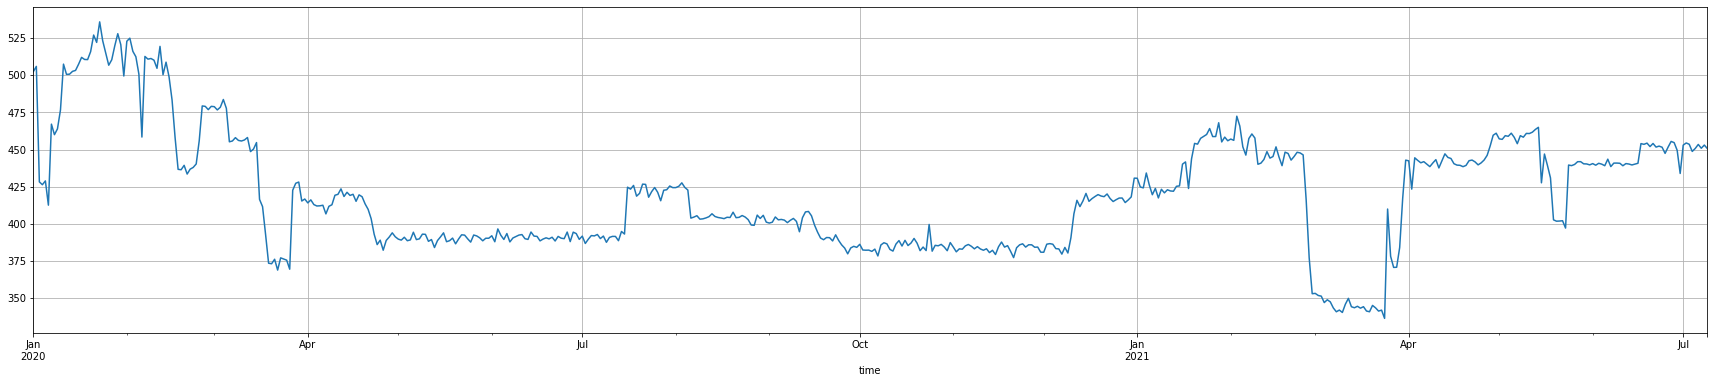

In [105]:
(test['crude_tnh'] + test['lssr_tnh']*(1-test['j70abc_on_off'])).plot(figsize=(30,6), grid=True)

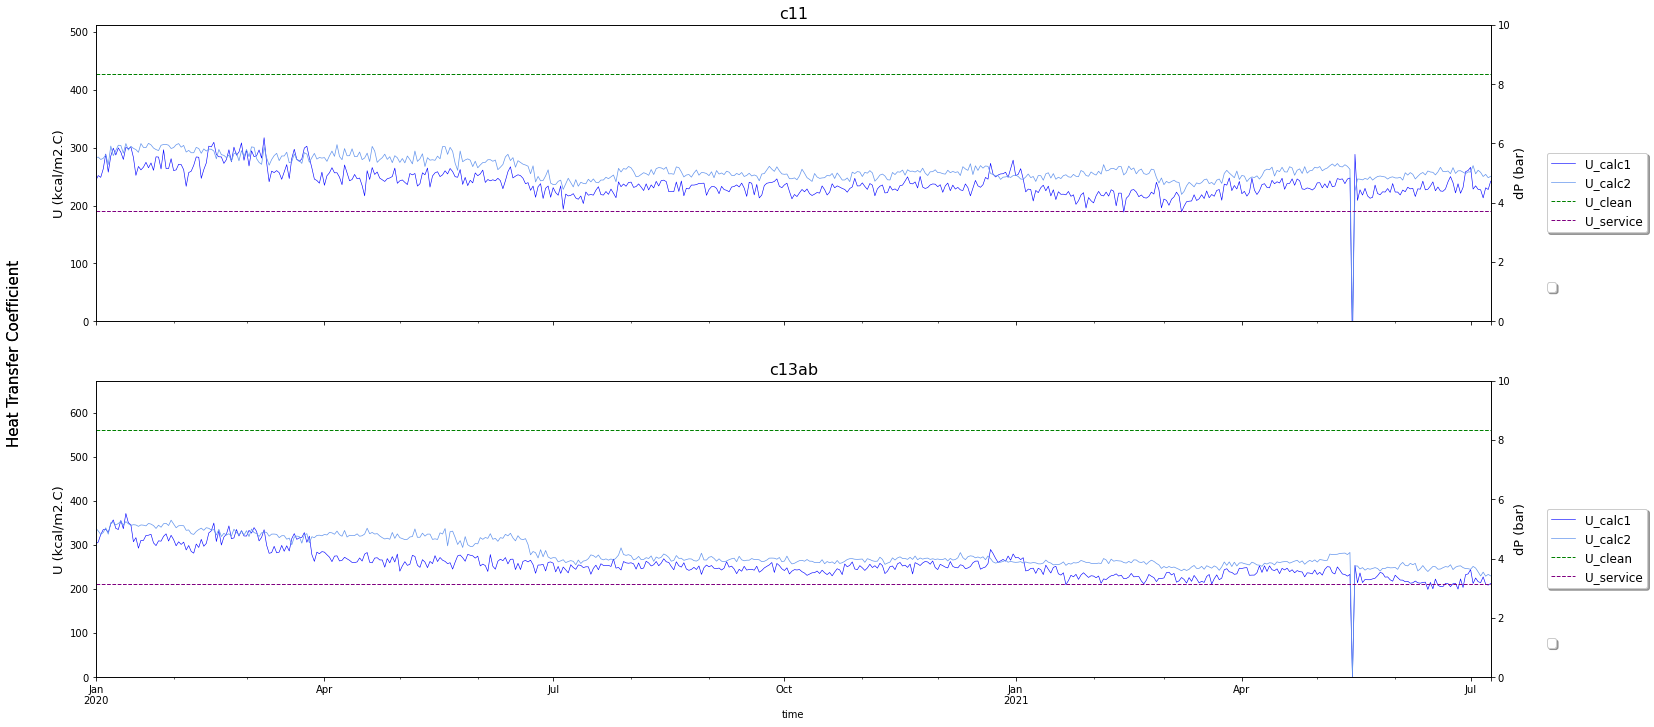

In [113]:
plot_hex(['c11', 'c13ab'], start=('2020-01-01'))

In [115]:
hex_area['c11']*230

78591.0

In [187]:
date = ('2021-06-30')

us = df[df.index==date][[col for col in df.columns if 'ucalc1' in col]].T

In [188]:
us

time,2021-06-30
c1ab_ucalc1,234.837973
c2ab_ucalc1,245.517901
c3_ucalc1,146.250563
c4ab_ucalc1,186.167943
c5ab_ucalc1,136.835101
c6ab_ucalc1,191.817434
c7ab_ucalc1,30.541050
c8ab_ucalc1,207.600402
c9ab_ucalc1,76.199231
c10ab_ucalc1,285.829144


In [191]:
df[df.index.year > 2019][[col for col in df.columns if 'ucalc1' in col]].mean()

c1ab_ucalc1       205.010268
c2ab_ucalc1       192.311310
c3_ucalc1         139.284648
c4ab_ucalc1       174.785871
c5ab_ucalc1       106.480967
c6ab_ucalc1       403.789299
c7ab_ucalc1              inf
c8ab_ucalc1       189.934274
c9ab_ucalc1        73.332074
c10ab_ucalc1      375.107803
c11_ucalc1        238.818897
c12ab_ucalc1      100.180466
c13ab_ucalc1      255.592926
c14abcd_ucalc1     81.102671
c15abc_ucalc1      28.477816
c70ab_ucalc1      128.150791
c71abc_ucalc1       5.139041
c72abcd_ucalc1     -3.004496
c73ab_ucalc1       50.847236
dtype: float64

In [165]:
exchanger = 'c73ab'

us.loc[(exchanger+'_ucalc1')][0] * hex_area[exchanger]

32495.55969628424

<AxesSubplot:xlabel='time'>

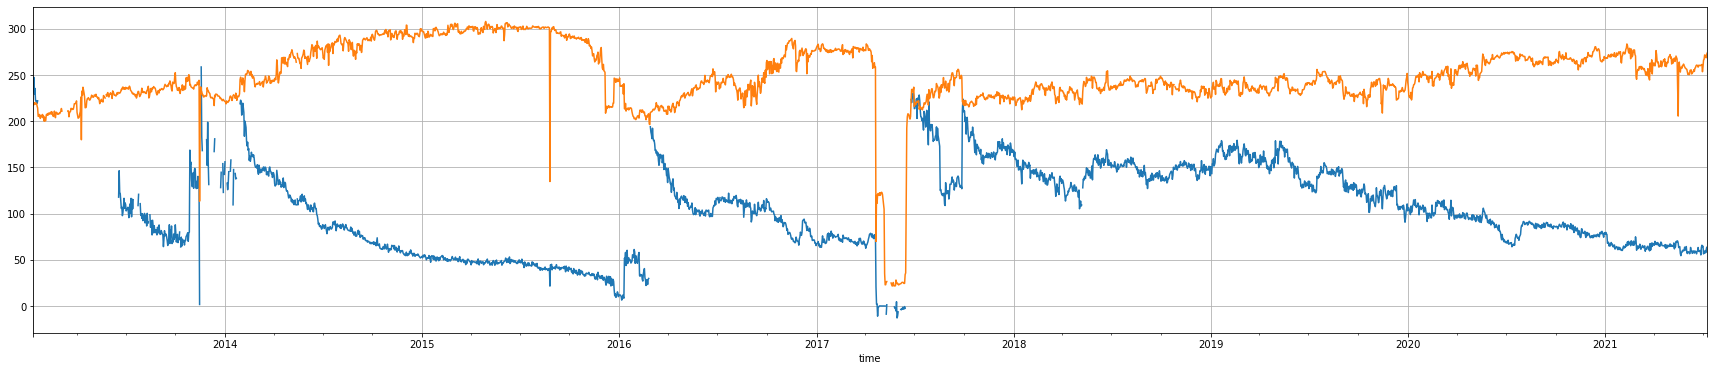

In [183]:
df['c14abcd_ucalc1'].plot(figsize=(30,6), grid=True)
df['c14abcd_ar_tout'].plot(grid=True)

In [176]:
df[df.index==date][[col for col in df.columns if 'c14abcd' in col]].T

time,2021-06-30
c14abcd_crude_pout,14.255752
c14abcd_flashed_crude_tout,223.820694
c14abcd_ar_m3h,70.420692
c14abcd_ar_tin,317.083496
c14abcd_ar_tout,253.588791
c14abcd_flashed_crude_tin,210.887558
c14abcd_lmtd,64.723486
c14abcd_flashed_crude_cp,0.646754
c14abcd_ar_cp,0.677569
c14abcd_flashed_crude_gcalh,3.461601


In [182]:
177*hex_area['c14abcd']

147104.7

<AxesSubplot:xlabel='time'>

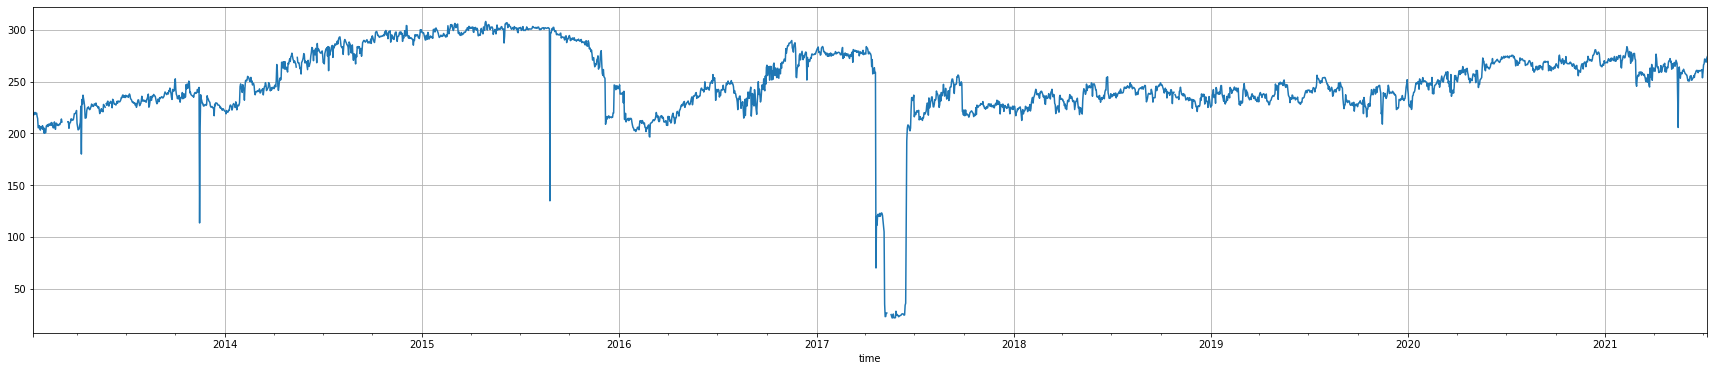

In [90]:
df['c14abcd_ar_tout'].plot(figsize=(30,6), grid=True)

<AxesSubplot:xlabel='time'>

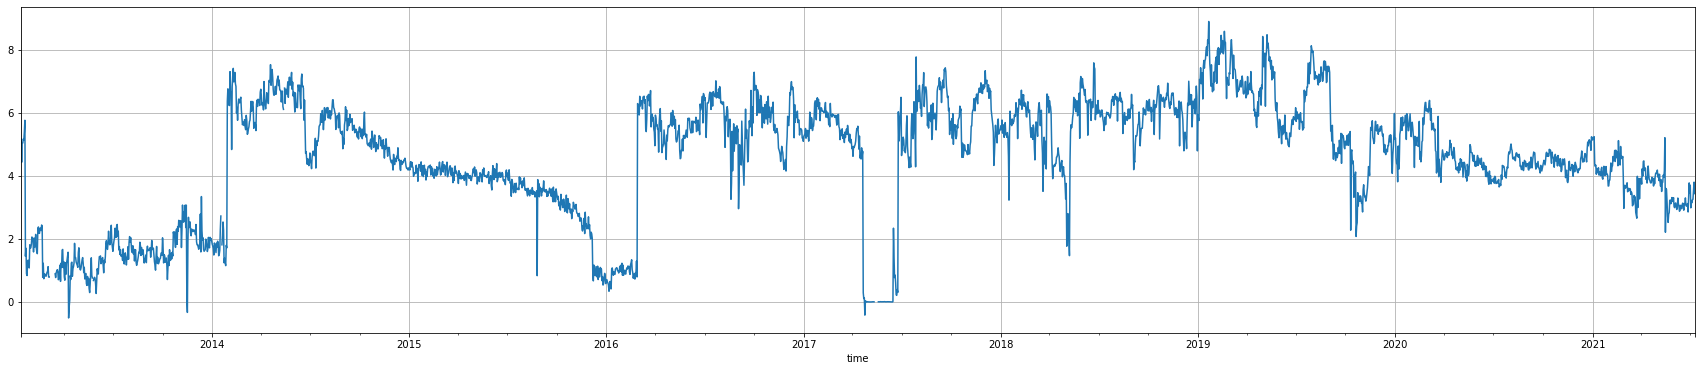

In [89]:
df['c14abcd_flashed_crude_gcalh'].plot(figsize=(30,6), grid=True)

<AxesSubplot:xlabel='time'>

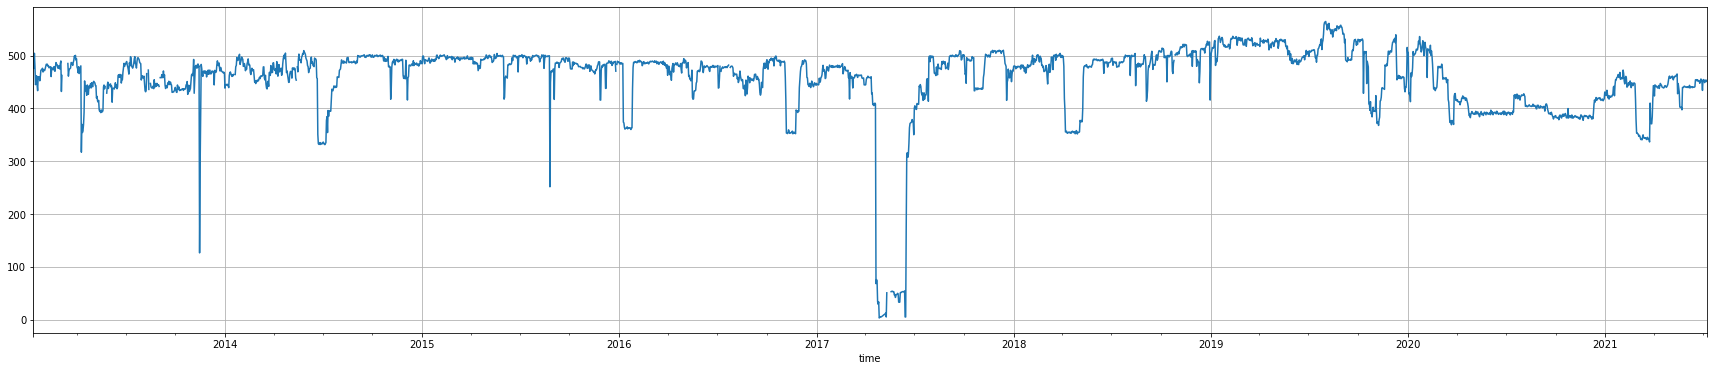

In [205]:
(df['crude_tnh'] + df['lssr_tnh']*(1-df['j70abc_on_off'])).plot(figsize=(30,6), grid=True)

<AxesSubplot:xlabel='time'>

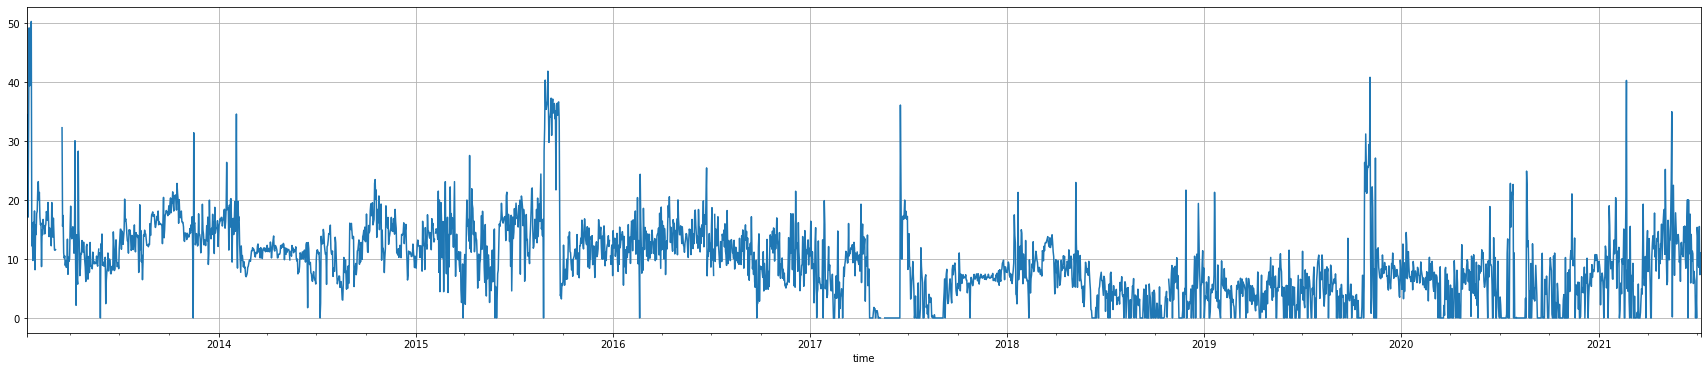

In [91]:
df['e3_lvgo_prod_tnh'].plot(figsize=(30,6), grid=True)

<AxesSubplot:xlabel='time'>

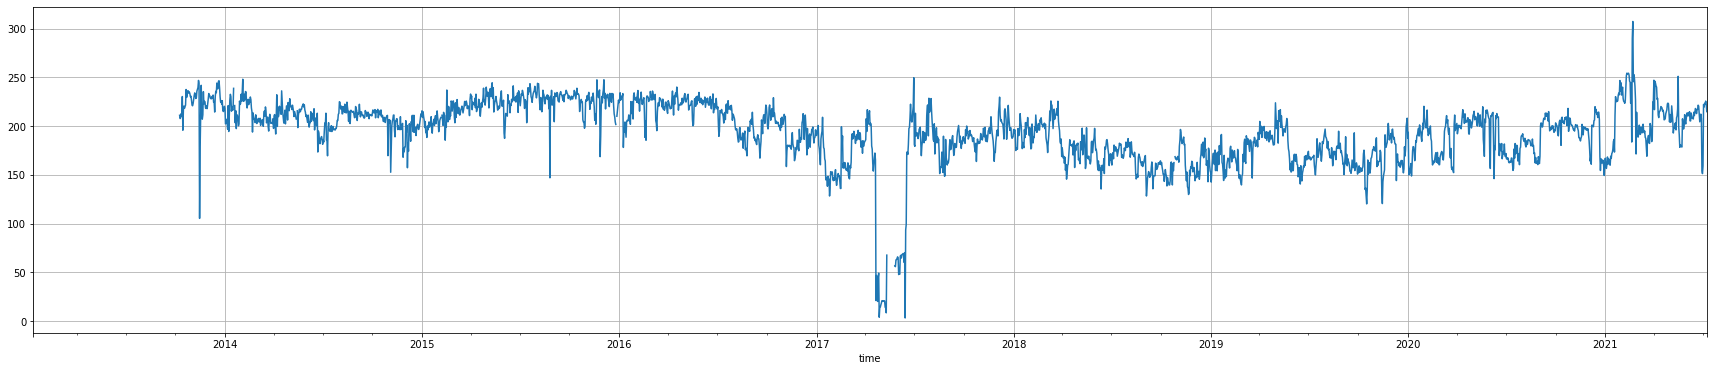

In [95]:
df['e3_feed_tnh'].plot(figsize=(30,6), grid=True)

<AxesSubplot:xlabel='time'>

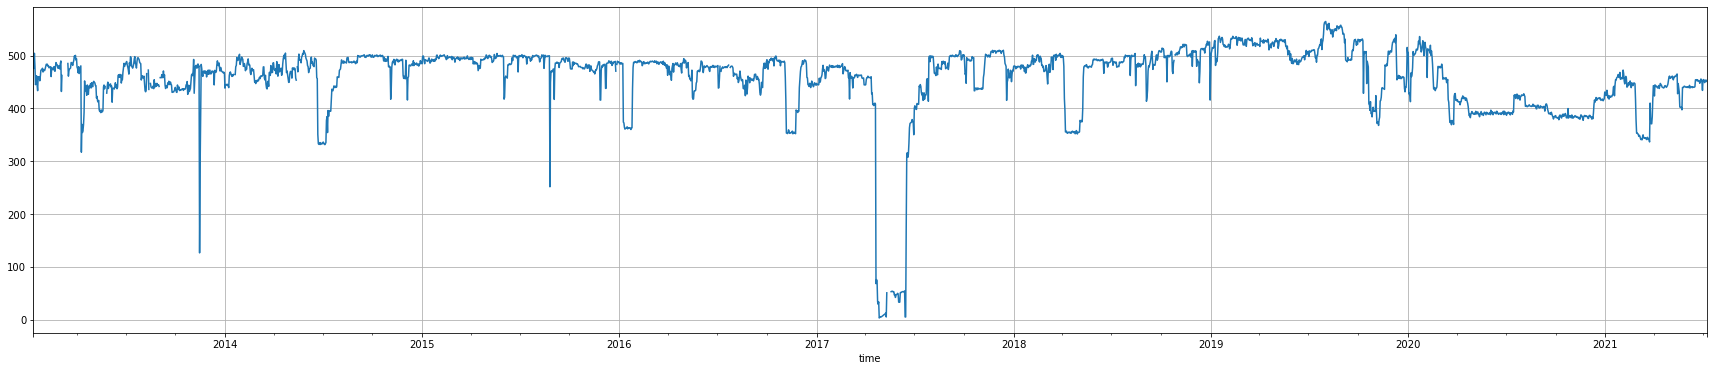

In [101]:
(df['crude_tnh']+df['lssr_tnh']*(1-df['j70abc_on_off'])).plot(figsize=(30,6), grid=True)

In [88]:
test = df[df.index.year==2020]

<AxesSubplot:xlabel='time'>

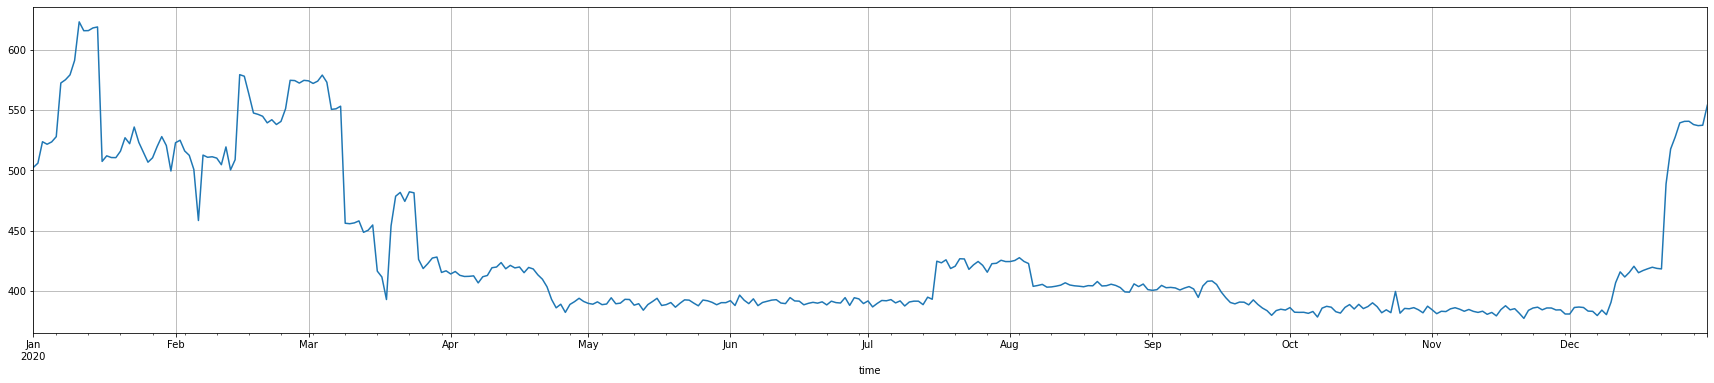

In [91]:
(test['crude_tnh']+test['lssr_tnh']).plot(figsize=(30,6), grid=True)